In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from torch.autograd import Variable

import pandas as pd
import numpy as np

import pdb
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm

from torch.nn.utils import clip_grad_norm

# import torch.backends.cudnn as cudnn
# cudnn.benchmark = True

import math

use_cuda = True

In [19]:

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_gru_layers=1, bidirectional = True, dropout_p = 0.2):
        super(EncoderRNN, self).__init__()
        
        self.h_layers = num_gru_layers
        self.hidden_size = hidden_size
        self.num_gru_layers = num_gru_layers
        self.h_layers = num_gru_layers
        
        self.bidirectional = bidirectional
        
        self.lin_in = hidden_size
        if bidirectional:
            self.h_layers = self.h_layers * 2
            self.lin_in = hidden_size * 2
        
        self.droput = nn.Dropout(dropout_p)
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers = num_gru_layers, bidirectional = bidirectional, dropout = dropout_p)
#         self.out = nn.Sequential(
#                                  nn.BatchNorm1d(self.lin_in),
#                                  nn.ReLU(True),
#                                  nn.Linear(self.lin_in, self.lin_in),
#                                  nn.BatchNorm1d(self.lin_in),
#                                  nn.ReLU(True),
#                                  nn.Linear(self.lin_in, input_size),
#                                  torch.nn.LogSoftmax(dim = 1)
#                                 )
        
    def forward(self, input, hidden):
        
#         output = self.droput(input)
        
        output, hidden = self.gru(input, hidden)        
#         output = torch.cat([torch.unsqueeze(self.out(out_batch),0) for out_batch in output],0)

        return output, hidden

    def initHidden(self, batch_size = 1):
        result = Variable(torch.zeros(self.h_layers, batch_size, self.hidden_size))
        
        return result
#         if use_cuda:
#             return result.cuda()
#         else:
#             return result
  
class Attention(nn.Module):
    def __init__(self, attn_in_size, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
#         self.attn = nn.Linear(attn_in_size*2, hidden_size)
        
        self.attn = nn.Sequential(
                                    nn.Linear(attn_in_size*2, hidden_size)
                                )
        
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.uniform_(-stdv, stdv)

    def forward(self, hidden, encoder_outputs):
        timestep = encoder_outputs.size(0)
        h = hidden.repeat(timestep, 1, 1).transpose(0, 1)
        encoder_outputs_tmp = encoder_outputs.transpose(0, 1)  # [B*T*H]
        attn_energies = self.score(h, encoder_outputs_tmp)
        
        attn_weights = F.softmax(attn_energies, dim=1).unsqueeze(1)
        
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))  # (B,1,N)
        context = context.transpose(0, 1)  # (1,B,N)
        
        return context, attn_weights

    def score(self, hidden, encoder_outputs):
        # [B*T*2H]->[B*T*H]
#         pdb.set_trace()
        
#         energy = torch.cat([torch.unsqueeze(self.attn(out_batch),0) for out_batch in torch.cat([hidden, encoder_outputs], 2)],0)
        
        energy = self.attn(torch.cat([hidden, encoder_outputs], 2))
        
        energy = energy.transpose(1, 2)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        energy = torch.bmm(v, energy)  # [B*1*T]
        return energy.squeeze(1)  # [B*T]


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, n_layers=1,  bidirectional = True, dropout_p=0.2):
        super(DecoderRNN, self).__init__()
        
        output_size = embed_size
        
        self.bidirectional = bidirectional
        
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        n_attention_heads = 6
        
        
        self.hidden_in = hidden_size
        if bidirectional:
            self.hidden_in = hidden_size * 2

        self.embed = nn.Embedding(output_size, embed_size)
        self.dropout = nn.Dropout(dropout_p, inplace=True)
        
        self.atten_list = nn.ModuleList(Attention(self.hidden_in, hidden_size) for i in range(n_attention_heads))
        
        self.gru = nn.GRU(self.hidden_in * n_attention_heads + embed_size, hidden_size, n_layers, bidirectional = bidirectional)
#         self.out = nn.Linear(self.hidden_in * 2, output_size)
        
        self.out = nn.Sequential(
                                    nn.Linear(self.hidden_in * (n_attention_heads+1), self.hidden_in * (n_attention_heads+1)),
                                    nn.BatchNorm1d(self.hidden_in * (n_attention_heads+1)),
                                    nn.ReLU(True),
                                    nn.Linear(self.hidden_in * (n_attention_heads+1), output_size)
            
                                )

    def forward(self, embedded, last_hidden, encoder_outputs):
        # Get the embedding of the current input word (last output word)
#         embedded = self.embed(input).unsqueeze(0)  # (1,B,N)
#         embedded = self.dropout(input)
        # Calculate attention weights and apply to encoder outputs

        
        h_in = last_hidden[-1]
        if self.bidirectional:
            h_in = torch.cat([last_hidden[-2], last_hidden[-1]], 1)
        
        context_list, attn_list = list(), list()
        
        for i, atten_head in enumerate(self.atten_list):
            context, attn_weights = atten_head(h_in, encoder_outputs)
            
            context_list.append(context)
            attn_list.append(attn_weights)
            
        
        output, hidden = self.gru(torch.cat([embedded] + context_list, 2), last_hidden)
        output = torch.cat([output] + context_list, 2)
        output = output.squeeze(0)  # (1,B,N) -> (B,N)
#         context = context.squeeze(0)
        
#         pdb.set_trace()
        output = self.out(output)
        
        output = output.unsqueeze(0)
        
        output = F.log_softmax(output, dim=2)
        return output, hidden, attn_weights

In [ ]:
import os
from decimal import Decimal

import seq2loc.utils as utils
from seq2loc.data.datasets import PaddedSequenceDataset, SequenceDataset

from tensorboardX import SummaryWriter


GPU_id = 0
LR = 0.001
N_EPOCHS = 5000
hidden_size = 128
batch_size = 128
num_gru_layers = 3
teacher_forcing_ratio = 0.5
log_number = 50
loss_thresh = 1.5E-4
N_LETTERS = utils.n_letters()

grad_clip = 5
seq_len_to_add = 1

bidirectional=True

ds = PaddedSequenceDataset(SequenceDataset('./data/uniprot_train.tsv', max_seq_len = 15), GPU_id = GPU_id)
ds_test = PaddedSequenceDataset(SequenceDataset('./data/uniprot_test.tsv', max_seq_len = 15), GPU_id = GPU_id)
ds_validate = PaddedSequenceDataset(SequenceDataset('./data/uniprot_validate.tsv', max_seq_len = 15), GPU_id = GPU_id)


criterion = torch.nn.NLLLoss()

enc = EncoderRNN(N_LETTERS, hidden_size, num_gru_layers, bidirectional=bidirectional).cuda(GPU_id)
dec = DecoderRNN(N_LETTERS, hidden_size, num_gru_layers, bidirectional=bidirectional).cuda(GPU_id)


opt = optim.Adam([{'params':enc.parameters()}, {'params':dec.parameters()}], lr = LR)
step = 1
# dec = enc

losses = np.array([])

iteration = 0

writer = SummaryWriter()
save_dir = './autoencoder/{}'

for epoch in range(N_EPOCHS):
 
    
    loss_thresh = 8.12E-04 / np.log(ds.sequenceDataset.max_seq_len)
    epoch_inds = utils.get_epoch_inds(len(ds), batch_size)
    pbar = tqdm(epoch_inds)

    epoch_losses = list()
    
    for batch in pbar:
        opt.zero_grad()

        x, x_inds = ds[batch]        
#         x = (x - 1) * log_number #set to log(one-hot)

        hidden = enc.initHidden(batch_size).cuda(GPU_id)

        enc_out, hidden = enc(x, hidden)
        
        #input the stop character to the stream    
        out = Variable(utils.stopChar(batch_size)).cuda(GPU_id)

        loss = Variable(torch.zeros(1,1,1).cuda(GPU_id))

        out_list = list()
        for i in range(x.shape[0]):

            out, hidden, attn_weights = dec(out.detach(), hidden, enc_out)    
            
            out_list += [out]

            loss += criterion(torch.squeeze(out,0), x_inds[i])
    
            if teacher_forcing_ratio < torch.rand(1):
                out = torch.unsqueeze(x[i],0)
            else:
#                 pdb.set_trace()
                out = utils.indicesToTensor(torch.max(out,2)[1].cpu(), ndims = N_LETTERS)
                out = Variable(out).cuda(GPU_id)
                


        loss = loss/(x.shape[0]*x.shape[1]*x.shape[2])
        loss.backward()
        
        clip_grad_norm(enc.parameters(), grad_clip)
        clip_grad_norm(dec.parameters(), grad_clip)

        opt.step()
        step += 1
        
        losses_np = np.squeeze(loss.detach().cpu().numpy()) 
        epoch_losses += [losses_np]

    
        writer.add_scalars(save_dir.format('train'), {'epoch': epoch,
                                                'loss': losses_np}, iteration)
    
        pbar.set_description('%.4E' % Decimal(str(losses_np)))
        
        iteration += 1
        
    losses = np.hstack([losses, np.stack(epoch_losses)])
    
    if np.mean(epoch_losses) < loss_thresh:
        ds.sequenceDataset.max_seq_len += seq_len_to_add
        
        if batch_size > 2:
            batch_size -= 1
    
    pbar.set_description('%.4E' % Decimal(str(np.mean(epoch_losses))))
    
    print(''.join(utils.tensorToChar(torch.cat(out_list, 0))[:,0]))
    print(''.join(utils.tensorToChar(x)[:,0]))
    
    if '.' in ''.join(utils.tensorToChar(x)[:,0]):
        pdb.set_trace()



PEEEPLSSSVVSSSS
PERPESLLVSGPSVT



SALLFFGAAAAYRRN
SALFLGVAYGATRYN



KVVTQQGGDNKLVTT
KTVVQLEGDNKLVTT



VSIKDNQKDRFFTVT
VSIKDNQKDRTFTVT



SSLPASSGLRSSGGMS
PSLPAGSGLKRSSGMS



LVIAGILFILGIILLVS
LVIAGILFILGILIVLS



WCCLSDPSIPGRCCVLER
WCCLSDPSIPGRCCVLER



SDLGPCEKIDEELNRKQYE
SDLGPCEKIHDENLRKQYE



YCGRLYGLGTVVAAKQNEDV
YCGRLYGLGTGVAQKQNEDV



VTDFVLLGFTQNNEEQKVLFV
VTDFVLLGFTQNPKEQKVLFV



SETESPRLFSSHLPIQLFPKSF
SETESPRLFSSHLPIQLFPKSF



PKKSKARILEEITVSSLMATPQD
PKKSKARILESITVSSLMATPQD



KPDEKLDAQVRAAVMMYYEDWVIV
PKDEKLDAQVRAAVEMYIEDWVIV



LVTILLLLRLVAIAGNGFITAALGV
LVTILLLLRLVAIAGNGFITAALGV



HPGTRSVSASSGPCSPAAPHPPPPPR
HPGTRSVSASSGPCSPAAPHPPPPPR



MDLGPMRKSYRGDREAFEETHLTSLDP
MDLGPMRKSYRGDREAFEETHLTSLDP



GPIDNSRIAQVKGSGHQQLKQGADYGQI
GPIDNSRIAQVKGSGHVQLKQGADYGQI



RQIAIAAMVANFTKPTADAPSLLQHDEVE
RQIAIAAMVANFTKPTADAPSLLQHDEVE



RDRERERERDREREEEKKRHSYFEPPKVDD
RDRERERERDREREEEKKRHSYFEKPKVDD



TQVTETLGMTHCCINPIIYAFVGEKFRSLFH
TQVTETLGMTHCCINPIIYAFVGEKFRSLFH



YSFDHLYNNNDIIHTPQIRKARQPKPVSKKFL
YSFDHLYNTNDIIHTPQIRKARPQKPVSFKFL



KKRLETIVQLERELRELTNERERLLRARGEADR
KRKLETIVQLERELERLTNERERLLRARGEADR



SPRLPRPPTVEEHHVSTIGMDDVCQLNQYTLKDE
SPRLPRRPTVESHHVSITGMQDCVQLNQYTLKDE



CTPSKKSLVATGNLLDLETTAKAPLSTVSANTNNM
CTPSLKSLVATGNLLDLEETAKAPLSTVSANTTNM



TEEEIEMMKMMGFAFSDSTKGKKVDGSVNAYAINVS
TEEEIEMMKLMGFASFDSTKGKKVDGSVNAYAINVS



RFPPSTPSEVLSPTEDRRSPPACSSSSSSLFSAVVAR
RFPPSTPSEVLSPTEDPRSPPACSSSSSSLFSAVVAR



PPCPRLSRELLDEKGEEVLLQDSLRCDTSPSGCLELTD
PPCPRLSRELLDEKGPEVLQDSLDRCYSTPSGCLELTD



RSFHKTCFHCMAKRKALDSTVVAAHSSEIYCKVCYGRRY
RSFHKTCFHCMACRKALDSTTVAAHESEIYCKVCYGRRY



ENSNPEQDLKLTEEESEQRKLSSEGGQPEKRSQEPEINKD
ENSNPEQDLKLTSEEESQRLKGSENGQPEKRSQEPEINKD



KCQECGKAFSHCSSLTKHRRVHTGEKPYECSECGKTFSQS
KCQECGKAFSHCSSLTKHQRVHTGEKPYECSECGKTFSQS



DFLTGVLDNLVEQNVLNWKEEEKKKYYDAKTEDKVRVMADS
DFLTGVLDNLVEQNVLNWKEEEKKKYYDAKTEDKVRVMADS



LIAGMKDVTEAQIGTTLCLHKQPVEPLPGFKSAKPMVFAGM
LIAGMKDVTEAQIGDTLCLHKQPVEPLPGFKSAKPMVFAGM



LGNVARGINIAIVNYVTGNVTATRCFDMYEDGGSPPMTKFIQ
LGNVARGINIAIVNYVTGNVTATRCFDMYEGDNSGPMTKFIQ



ELEEVFDLRMMVANILNNAEFMNQETTKAFHVRRTNRVKECL
ELLEVFDLRMMVANILNNEAFMNQEITKAFHVRRTNRVKECL



SSASRNMHFLTIKDNTLRATPVIKPIILLPLRTMSLEDSLSSG
SSASNRHMLFTIKDNTLRATPVIKPIMLPLLRTMSLEDSLSSG



EDRPKQCWENIATILEAKCALKYLIGELVSSKIHVTKLENSLR
EDRPKQCWENIATILEAKCALKYLIGELVSSKIHVTKLENSLR



FPLLKFFPASADRTVIDYNGRETLDDFKKFLEGGGQQAAGDDDD
FPTLKFFPASADRTVIDYNGERTLDGFKKFLESGGQDGAGDDDD



TTHKKIHTHEKPYKECECGKAFKRSSLLTHHKRIHTGEKPYKCE
TTHKKIHTGEKPYKCEECGKAFKRSSILTTHKRIHTGEKPYKCE



KRLVLRRDPVVRKCTLGGSSSLLVPLLTCTQRQRRCRGQRWTVQ
KRLVLRRDPSVKRTLCRGCSSLLVPGLTCTQRQRRCRGQRWTVQ



WKTQLTEHQRIHTGEKPFECNVCGKAFRHSSSLGQHENAHTGEK
WKTQLTEHQRIHTGEKPFECNVCGKAFRHSSSLGQHENAHTGEK



HFLTQTGVVPPQGGTHRPPAPRIADASALATKGSQEAAMQQVNSY
HFLTQTGHVPPQGGTHRPPAPARIADSCALTSGKQESAMSQVNSY



GVHWGYEETRTLLAILSQTEFYEALRRCRRNQQYVGAVAERLREY
GVHWGYEETRTLLAILSQTEFYEALRNCHRNSQVYGAVAERLREY



TAIAAKMSGASRILADDIDPIAGMATILNCELNRLNPFPILIQNI
TAIAAKMSGASRILANDIDPIAGMAITLNCELNRLNPFPILIQNI



PSEPEIDLEALMDLSDEETKQQLEAILGNCPPRTAEEEEELLSQLK
PSEPEIDLEALMDLSTEEQKTQLEAILGNCPRPTEAFISELLSQLK



LHKARAQLLAKGRRHRPSRSRLRDSASSAEEGEGDSGPGKKVTDGC
LHKARAQLLAKGRRHRPSRSRLRDSASSAEDGEGSDGPGGKVTDGC



FPMASPGGLELKTSSNGPQAPRRSAPGLPVPPTREVVENAFFSSEE
FPMASPPGLELKTLSNGPQAPRRSAPLGPVAPTREGVENACFSSEE



SDIDDVFLPTPDSLVLNLYESKELKIDLLLANNMNFTTNRETHSALG
SDIDDVFLPTPDSLLVNLYESKELIKDLLNALPNMFTNTRETHSALG



EFLEKTKSSGWIKLPSKFSNRDHIRGLLLPSGLAVSSDKGDCRIFTR
EFLEKTKSSGWIKLPSFKSNRDHIRGLKLPSGLAVSSDKGDCRIFTR



YGKASHSASYPWEGLNALDAAVLYYNNSSVFRQQMKPTWRVHIIIKNG
YGKASHSASYPWEGLNALDAAVLAYNNLSVFRQQMKPTWRVHGIIKNG



LFFRTQQAAIKGQNPNATFGEVSKAVVWWWDSGLEEQQQVYKRKTEAA
LFFRDTQAAIKGQNPNATFGEVSKIVASMWDSLGEEQKQVYKRKTEAA



NTEPLEDTVLSPKTTRKRGGTTEMMEPEEGVTVESQPQVKVEPLEEAIP
NTEPLEDTVLSPTKKRKRQKGTEGMEPEEGVTVESQPQVKVEPLEEAIP



LSRLKDRDPEFYKFLQENDQSLLNFSSSDSSEEEEGPFHSLPDVLEEAS
LSRLKDRDPEFYKFLQENDQSLLNFSDSDSSEEEEGPFHSLPDVLEEAS



MKEAKKVVIIEPPASVPSKQGSRSDKKKSTRKSPTFRNRPDFRKNKGRQL
MKEAKKVVIIEPPASVPSKQSGRSDKKKSTRKSPTFRNRPDFRKNKGRQL



KPTLWAEPGVVITSGSPVTLRCQGGGEQQYEELRREKTKKLWTIRPQQEL
KPTLWAEPGSVITQGSPVTLRCQGGQETQEYRLYREKKTALWITRIPQEL



RFQRLSSTSSSGQQFDEEELGCCPWLTAIFRLHDDQILWECGEDAIHYLSF
RFQRLSSTSSSGQQDFENELGCCPWLTAIFRLHDDQILEWCGEDAIHYLSF



FSDVVFYLTLIVGLGPPVGNGLVLWNLGFFIKGGPFSIYLLHLAAADFLFL
FDSVVFYLTLIVGLGGPVGNGLVLWNLGFRIKKGPFSIYLLHLAAADFLFL



LAMLSDFSHMLSVVLALVAVLAAEFFARRTHAQQKNTFGWIRAEVMGALVNA
LAMLSDSFHMLSDVLALVVALVAERFARRTHATQKNTFGWIRAEVMGALVNA



QAIQLSIEQAQVVAEQVEMKAKVVSQEKVVVYTRHKKALEERECELLWKVEI
QAIQLSIEQAQTVAEQVEMKAKVVQSEVKAVTARHKKALEERECELLWKVEK



SAVLILRSSSTAVFRRFPTIDHVVEAGFMTRERRKKFENNLSSYNKYWVPCVW
SAVLILRSVSTAVFKRFPTIDHVVEAGFMTREERKKFENLNSSYNKYWVPCVW



HSISIVALFVAITILVALRRLHCNRNYVHTQLFTTFILKAAAVFLKDAALFHS
HSISIVALFVAITILVALRRLHCPRNYVHTQLFTTFILKAGAVFLKDAALFHS



NLVSVVPQGHLQSMPTGNMRASSELHDLMAARRSKLVHEEPRKNNCQGSCKSQR
NLVSQVPQGHLQSMPTGNMRASQELHDLMAARRSKLVHEEPRKPNCQGSCKSQR



PRVYNIHSRTVTRYPANSIVVVGGCPVCRVGVLEDCFTFLGIFLAIILFPFGFI
PRVYNIHSRTVTRYPANSIVVVGGCPVCRVGVLEDCFTFLGIFLAIILFPFGFI



KMNLLRQQNLFCDVDIYINTTEFQGHKVILAMCSAFDRDQFLTTQSHHVRITILQ
KMNLLRQQNLFCDVSIYINDTEFQGHKVILAACSTFMRDQFLLTQSKHVRITILQ



GSPPRYLLYYYSDSDKGQGSGVPSRFSGSKDASANTGILLIGSLQDEDEADYYCM
GSPPRYLLYYYSDSDKGQGSGVPSRFSGSKDASANTGILLISGLQSEDEADYYCM



SNIILAGGSTSFPGLDKRLVKDIKKAAPANTAVQVIAPPERKISVWMGGSILASLS
SNIILAGGSTSFPGLDKRLVKDIAKVAPANTAVQVIAPPERKISVWMGGSILASLS



EPGTYLIVPCILEAHQKSEFVLRVFSRKHIFYEIGSNSGVVFSKEIEDQNERQDEF
EPGTYLIVPCILEAHQKSEFVLRVFSRKHIFYEIGSNSGVVFSKEIEDQNERQDEF



ADMGPINVDGGGFFEKLWKGGLVLQELSQWTVRSIHDLRFISSHQTGIPARGSHIIA
ADGMPINVGDGGLFEKKLWGLKVLQELSQWTVRSIHDLRFISSHQTGIPARGSHYIA



CDDGGGAAFSRRSTLIQHQKVHSGETRKCRKHGPAFVHGSSLTADGQIPTGEKHGRA
DCGDCGKAFSRRSTLIQHQKVHSGETRKCRKHGPAFVHGSSLTADGQIPTGEKHGRA



LKMHRRTHTLPCTCKICGKAFSRPWLLQGHVRTHTGEKPYACSHCSRAFADRSNLRAH
LKMHIRTHTLPCTCKICGKAFSRPWLLQGHVRTHTGEKPYACSHCSRAFADRSNLRAH



NKIGAYTTHLMKRIQRGPVRGISIKLQEEERERRDYYVPEVSALDQIIIEVDPDTKEM
NKIAGYVTHLMKRIQRGPVRGISIKLQEEERERRDNYVPEVSALDQEIIEVDPDTKEM



FIDDVSSAVLRASYGQSAAMPAFAGAMSLAGAQGSLWSVEGGNKLVCSGLLLKKTINVA
FIDDVVSAVLRASYGQSAAMPAFAGAMSLAGAQGSLWSVEGGNKLVCSGLLKLTKANVI



ATGSANMTKKKVSQKKQRGRPSSQPRRNIVGGRISHGWKEGDPEITQWKGTVLDQVPIN
ATGSANMTKKKVSQKKQRGRPSSQPRRNIVGCRISHGWKEGDEPITQWKGTVLDQVPIN



RELSVQLQPTDALLCVANLPPSLTQQQEFELVRPFGSLERCFLVYSERTGQSKGYGFAEY
RELSVQLQPTDALLCVANLPPSLTQQQFEELVRPFGSLERCFLVYSERTGQSKGYGFAEY



RKETDANAIIMKVDKDRQVMVLEEEFQNISPEELKMELEERQPRFVVYSYKYVHDDGRVS
RKETDNAAIIMKVDKDRQMVVLEEEFQNISPEELKMELPERQPRFVVYSYKYVHDDGRVS



GLSLPRQGICFSLFKTALLLTTAAPRSSPALLTISALSLALVLPVKELNVRFRDRLPTPIP
GLSLPRQIGCFSLFKTLASLLTALPRSSPAELTISALSLALLVPVKELNVRFRDRLPTPIP



TIVGSAAFNMFVVIVAYACIAPIGEERKIHLKRVFVVTASWSIAFYVYLYLILAVFSPGVV
TIVGSAAFNMFVVIAVCIYVIPAGESRKIKHLRVFFVTASWSIFAYVWLYLILAVFSPGVV



FKVPLQKSFEKKLAPEECFSPLDLFNIIREQNEELGIIIDLTYTQRYYKPEDLPETVPYLKI
FKVPLQKSFEKKLAPEECFSPLDLFNKIREQNEELGLIIDLTYTQRYYKPEDLPETVPYLKI



GPQGGRARGAMAHVGSRKRSRSRSRSRGRGSSKRKKKSKRDTSRNCSASTQQGRKASTAPGA
GPQGGRARGAMAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQGRKASTAPGA



SLHIHERTHTGDKPYECKVCGKATFCSSSIRYHRRTHTGEKPYECKHCKKAFISNYRRYHRET
SLHIHERTHTGDKPYECKVCGKAFTCSSSIRYHERTHTGEKPYECKHCGKAFISNYIRYHERT



APTEMAKAAPGSTKPKTKVVKAKAGAKKTGGTGGKTKPSTKKKKVRSGGGSGSSGGQVSLKKS
APTEMAKAAPGSTKPKKTKVKAKAGAKKTKGTKGKTKPSKTRKKVRSGGGSGGSGGQVSLKKS



GTEKLDDNSIFLQGPGIHPHHCDLNTDTGVVVVTPRSMDAETYVEGQRISETTLLQSGMKVQFG
GTEKLDDNSIQLFGPGIQPHHCDLTNMDGVVTVTPRSMDAETYVEGQRISETTMLQSGMKVQFG



VANMRNSKLKDINRAWKFSRFMFGKKNVMMVALGRSPSDEYDDNLHQVSKRLREGVGLLFTNRT
VANMRNSKLKDIRNAWKHSRMFFGKNKVMMVALGRSPSDEYKDNLHQVSKRLRGEVGLLFTNRT



VFPPLRKLFLEKKLDVTGVFLDGEGHQSSFYNTTEMSSLYNSSHCAFQGALRPVFSCCIPNGDTS
VFPPLKRLFLEKKLDTVGVFLDCEHGQISFYNVTEMSLIYNFSHCAFQGALRPVFSLCIPNGDTS



ELPPDSDTVGMDSSYLSVKEAGVKPPQDRASSDLPSPLEKADSESNKKGKRRNRTTFTSYQLEEL
ELPPDSDTVGMDSSYLSVKEAGVKGPQDRASSDLPSPLEKADSESNKGKKRRNRTTFTSYQLEEL



DQQVHFTPTEGDFHHAIQTLLLQVAAAFQQEEELMILEEIKIPRPEADGMPINVGDGGFLEKKWWG
DQQVHFTPTEGDFHQAIHTLLLQVAAFAYQIEELMILLEYKIPRNEADGMPINVGDGGLFEKKLWG



SILTPEVIGPIWLMLLLGTVHCISVSTTTPKPPLTSGGRKRRLLRKAAELEVHREGDGSSTTDNTQ
SIPLTEVIGPIWLMLLLGTVHCQIVSTRTPKPPLSTGGKRRRKLRKAAHLEVHREGDGSSTTDNTQ



GAEAAREGVSGPDLPVCEPSGESAPPDSALPHAARGWAPFPVAPVPALLRRGGLRPAPASGGGAWPS
GAEAAREGVSGPDLPVCEPSGESAAPDSALPHAARGWAPFPVAPVPAHLRRGGLRPAPASGGGAWPS



SKLGLGKYTDVFQQEEIQLTDFLLLTDQDKKELGITTGGARRKLMAAISELKNNRKKLFEPPNARTS
SKLGLGKYTDVFQQQEIDLQTFLTLTDQDLKELGITTFGARRKMLLAISELNKNRRKLFESPNARTS



YVDITYDFIIRRKPLFYTINLIIPCCLITSLAILVYYLPSDCGEKMTLCISVLLALTVFLLLISKIV
YVDITYDFIIRRKPLFYTINLIIPCVLITSLAILVFYLPSDCGEKMTLCISVLLALTVFLLLISKIV



LLIIGFLLCSLTCLLLETVASSPLPLSALGIQKETGSSRPSGGNHRSWLNNFRYYLWQLISSALPPA
LLIIGFLLCSLTCLLLETVASSPLPLSALGIQEKTGSKPRSGGNHRSWLNNFRDYLWQLIKSALPPA



TDQGTTLLLNVTDLKTYQGIWDTFCKKWSPHRAATSYRLKLSPADTTRGQEITVGRSETSHCFTGLS
TDQGTTLYLNVTDLKTYQIGWDTFCVKWSPHRAATSYRLKLSPADGTRGQEITVRGSETSHCFTGLS



GTMLTSENTISYAGCMSQLFFLTLSWGWWMVLFTMMAYDRYVAICFPLHYSTIMNHHCMVALLSMVMA
GTMLTSENTISYAGCMSQLFLFTWSLGAEMVLFTTMAYDRYVAICFPLHYSTIMNHHMCVALLSMVMA



RPICSANHKESKMTIFEKENFIGRQWEISDDYPSLQAMGWFNNEVGSCKIQSGAWVCYQYPGYRGYQY
RPICSANHKESKMTIFEKENFIGRQWEISDDYPSLQAMGWFNNEVGSMKIQSGAWVCYQYPGYRGYQY



MKIIKENADEDSDASLSSTERPIPIPSPLTPPDLRLRAEEIDPVYDFLHPGQQGKKPEYYYPNFLPSPF
MKIIKENADEDSASDLSDSERIPIPPSPLTPPDLNLRAEEIDPVYFDLHPGQGHTKPEYYYPNFLPSPF



GGGRAASVPCSVAPEKSCVRPQPLQVRRTFSLDTILSSYLLQQWPRDADGAFCCCTNDKATQTPLSWQE
GGGRAASVPCSVAPEKSVCRPQPLQVRRTFSLDTILSSYLLGQWPRDADGAFTCCTNDKATQTPLSWQE



LICKIKGNNLFKFPIVVVGNKSDDTHREVALDNGTTCMAEENCFFWEASAKTDVNVQELFHMLLNYKKKP
LICKIKGNNLHKFPIVLVGNKSDDTHREVALNDGATCAMEWNCAFMEISAKTDVNVQELFHMLLNYKKKP



AEVKKPGSSVKVSCAASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAKKFGQRVTITADKSTST
AEVKKPGSSVKVSCKASGGTFSSYAISWVRQAPGQGLEWMGGIIPIFGTANYAQKFQGRVTITADKSTST



ITTLNIESNFITGKGIVAIMRCLQFNETLEELRFQNHRHGGLHAAEMEIARLLKANNTLLMGGYHFELPG
ITTLNIESNFITGKGIVAIMRCLQFNETLTELRFHNQRHMLGHHAEMEIARLLKANNTLLKMGYHFELPG



NVWVALFKNNEPVMYTYDEYKKGFLDAASGSAVLLLPPGDRVFLQMPSEQAGGLYAGQYVHSSFSGYLLY
NVWVALFKNNEPVMYTYDEYKKGFLDQASGSAVLLLRPGDRVFLQMPSEQAAGLYAGQYVHSSFSGYLLY



YGTQRTLILESQNWRYAGTTWEVVFRVPSSCTTDRSGITSGHESGEVKDKNVQVVELPIVDSLHPRPPYLP
YGTQRTLILESQNWRYATGGWETVFRPVSETCTDRSGISTGHWSGEVKDKNVQVVELPIVDSLHPRPPYLP



VSEEEKGGKVYQVFESVAKYYVDMNDMMVLSIGGRWDDLLLKWMHPPPGTQLLDVAGGTGDIAFRFLNYVQ
VSEEEKGGKVYQVFESVAKKYDVMNDMMSLGIHRVWKDLLLWKMHPLPGTQLLDVAGGTGDIAFRFLNYVQ



PKKKNQQLKVGILHLGSRQKKIRQQLRSQACTWKVISSSIISQTPGINLDLGSGVKVKIIPKEEHCKMPEAG
PKKKNQQLKVGILHLGSRQKKIRIQLRSQCATWKVICKSCISQTPGINLDLGSGVKVKIIPKEEHCKMPEAG



PVIKPQTSAVEQERWDEDSFYGLWDTNDEQGLNSEFKSETAAIPSAPVLPPPPVHSSIPPPGPVPMGMPPMS
PVIKPQTSAVEQERWDEDSFYGLWDTNDEQGLNSEFKSETAAIPSAPVLPPPPVHSSIPPPGPVPMGMPPMS



NGFVLPCLGVHPVQGLPPEDQRSVKLTDDVVALIIIENYKDLLLAGIEVGLDFSPRFAGTGEQKEEQRQVLI
NGFVLPCLGVHPVQGLPPEDQRSVTLKDLDVALPIIENYKDRLLAIGEVGLDFSPRFAGTGEQKEEQRQVLI



QEEESFAEGHSEASLASALVEGEIAEEAAEKATSRGSNSGMSDNIDLTIVEDEEEESVALEQAQKVRYEGSY
QEEESFAEGHSEASLASALVEGEIAEEAAEKATSRGSNSGMDSNIDLTIVEDEEEESVALEQAQKVRYEGSY



RVLEEARFAVAFTSSMKEMAQAQWPHAKGKVYVQSQGIATTPNAAFNWNFFLQRSEIQNSADNLHIFLLICG
RVLEEARFAVAFTESMKEMAQAQWPHAKGKVYVQSQGIATTPNAAFNWNTFLQRSEINQSADNLHIFLLICG



ALTEGDTQLNWINNSVVAEELLSHHENLVFLSETVNQPHHQNVSVPSNNVHAPYSSDKEHCMVTVVYYDCMSI
ALTEGDTQLNWNIVSFPVAEELSHHENLVSFLETVNQPHHQNVSVPSNNVHAPYSSDKEHMCTVVYFDDCMSI



VPRASVPDGFLSELTQQLAQATGKPQQYIAVVHVPDQLMAFGGSSEPCALCSLHSIGKIGGAQNSRYSSLLCG
VPRASVPDGFLSELTQQLAQATGKPPQYIAVHVVPDQLMAFGGSSEPCALCSLHSIGKIGGAQNRSYSKLLCG



IAGVLQRDARLRQLEEGRVSKLRASVADPGQLKILTGDWFQEARSQRHHNAHFGSDLVRASMRRKKSTRGDQAP
IAGVLQRDARLRQLEEGRVSKLRASVADPGQLKILTGDWFQEARSQRHHNAHFGSDLVRASMRRKKSTRGDQAP



ESKEKSTVADTSIQKLEKSKQTLPGLSNGSQIKAPIPKARKMIYKSTDLNKDDNQSFPRQRTDSLKAGRRPRGI
ESKEKSTVADTSIQKLEKSKQTLPGLSNGSQIKAPIPKARKMIYKSTDLNKDDNQSFPRQRTDSLKARGAPRGI



WFLNGQEEKAGMVSSGILNQGTWTFQTMVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVG
WFLNGQEEKAGMVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRARSESAQSKMLSGVG



KKRRIFIHSVGAGTINALLDCLLEDEVISQEDMNKDRVENDTVMDKAVVLIDLTVGKGPKSCCKFIKHLCEEDP
KKRRIFIHSVGAGTINALLDCLLEDEVISQEDMNKVRDENDTVMDKARVLIDLVTGKGPKSCCKFIKHLCEEDP



FKLATTALYFTYSALEEMMERNKDHPAFAPLYFPMELHRKEALKTDMEYFFGNWEEEQVQCPKAAQKYVERIHY
FKLATTALYFTYSALEEEMERNKDHPAFAPLYFPMELHRKEALTKDMEYFFGENWEEQVQCPKAAQKYVERIHY



ARNTAAVLEAAQELLRNRPILLGHVVVAPPGAPGLAVALIIVGGTPSPDPAGLVTPRTRVSLGGEPPSEAQPQP
ARNTAAVLEAAQELLRNRPISLGHVVVAPPGAPGLVAALHIVGGTPSPDPAGLVTPRTRVSLGGEPPSEAQPQP



SHKPSAEDAEGQSPLSQKYSPSTEKCLPEIQGIFDRDPDTLLYLQLQKSEPAEPCIGSKAPKDDKTIIEEQATKI
SHKPSAEDAEGQSPLSQKYSPSTEKCLPEIQGIFDRDPDTLLYLLQQKSEPAEPCIGSKAPKDDKTIIEEQATKI



KDKDKVPPSFWIPSLTPEAKATTLEKPSRVTTTPMSGKPLRMSDLTPVHFTPLDSSVDRVGLITRSERYVCAVTR
KDKDKVLPSFWIPSLTPEAKATKLEKPSRTVTCPMSGKPLRMSDLTPVHFTPLDSSVDRVGLITRSERYVCAVTR



GKAAYTGPKERVKKTQYQSAQRAELVVAITLVQDFDQPIPIISSADVVVYQADDTETALIKYSMDDQLNQLFNLLQ
GKAAYTGPKERVIKTQYQSAQRAELVAVITVLQDFDQPINIISDSAYVVQATRDVETALIKYSMDDQLNQLFNLLQ



NIDNFRLTLRAIKLWAKRHYIYSNILGFLGGVSWAMLVCRTAQLPNYAIASTLVHKFFLVFSKWEWPNPVLLKQPE
NIDNFRLTLRAIKLWAKRHNIYSNILGFLGGVSWAMLVARTCQLYPNAIASTLVHKFFLVFSKWEWPNPVLLKQPE



GFDCHLNGTASKKKLSVHKLTPDVLAEPLSSERHFFVMAQYVENFQGNDAPVQQEINSATEYFESARVECAIQTCP
GFDCHLNGTASQKKSLVHKTLPDVLAEPLSSERHEFVMAQYVNEFQGNDAPVEQEINSAETYFESARVECAIQTCP



ICSFKDRCVSILCCKFKCVVLSSRGMKAVLLADTIEDLFSTDIPPTPAVDDGGRCYFTKICKCKLKDIACLKCGNI
ICSFKDRCVSILCCKFCKQVLSSRGMKAVLLADTEIDLFSTDIPPTNAVDFTGRCYFTKICKCKLKDIACLKCGNI



ATGVPVTRRQFDHMKDMFDEYVKKRTLQNWFWFIISIIIKLPFESFKKMVSTSLLEELHRTALSWLDQHCSLPILR
ATGVPVTRRQFDHMKDMFDEYVKTRTLQNWKFWIFSIIIKPLFESFKGMVSTSSLEELHRTALSWLDQHCSLPILR



SRENELKQVVAKADIDDYKVETDIIVADFSSGREIPLIPEEALKDKVDGILVNNVGVFYPYPFYFTQLSEDKLWDI
SRNEEKLQVVAKDIADTYKVETDIIVADFSSGREIYLPIREALKDKDVGILVNNVGVFYPYPQYFTQLSEDKLWDI



IKRLKLDTKVHLKDLKFYMWEHGDDFSLSKKMDQDLITTQKKVVVHLETILGASVQVKKLKKMKYSFQLWIAMMSAK
IKRLKLDTKVHLKDLKFYWMEHDGGSFLMSKVDQDLIMTQKKVVVHLETILGASVQHVKLKKMKYSFQLWIAMMSAK



QPYPPAQYPPPPQNGIPAEAPYPPPHPTQDSSGQTPVPTEHGMTLYTPAQTHPEQPGSEASTQPIAGTQTVPQTDEA
QPYPPAQYPPPPQNGIPAEYAPPPPHPTQDYSGQTPVPTEHGMTLYTPAQTHPEQPGSEASTQPIAGTQTVPQTDEA



CSSGQHQCDSSCTVFNGTTSSSCRCRPGWKPHHGIPNNQKDTVCTDTTFSTWTPPPGVHSQTLSRFFDKVQDLGRDSK
CSSGQHQCDSSTVCFNTVGSYSCRCRPGWKPRHGIPNNQKDTVCEDMTFSTWTPPPGVHSQTLSRFFDKVQDLGRDSK



AVARVGPVSVAIDASLTQFSFYSKGVYYDESCNSDNLNHAVLVAGYIIQGNGWHWIIKSSGGENWGNKGYILMARNKN
AVARVGPVSVAIDASLTSFQFYSKGVYYDESCNSDNLNHAVLAVGYGIQKGNKHWIIKNSWGENWGNKGYILMARNKN



TNLVSLDFNFTTESNKLSSEKRNEEVNAYHQETWKRNKTNNLMRFIFRDTPQYTIEFRRQQRPKGVCFSQMIFKKHKS
TNLVSLDFNFTTESNKLSSEKRNYEVNAYHQETWKRNKTFNLMRFIFRTDPQYTIEFGRQQRPKVGCFSQMIFKKHKS



SHGESMAQPLVVFRGNQGFNNNWLRVVPRTRFGAFARGKAVVLYTKKSGAHLRIIDGGSGYLCEMEPVAHFGLGKDEA
SHGESMAQPLSVFRGNQGFNNNWLRVVPRTRFGAFARGAKVVLYTKKSGAHLRIIDGGSGYLCEMEPVAHFGLGKDEA



WFGPKEVSTCCATAVLGNQLGTAVGFLPLPVVLPNTQTTTNLLACNISMTFGGTSAVATLLFILTAIAFKEKPRYPPS
WFGPKEVSTACATAVLGNQLGTAVGFLLPPVLVPNTQNDTNLLACNISTMFYGTSAVATLLFILTAIAFKEKPRYPPS



KKCVPCTAARPLPSCLLCNQRCLCSAESLLDYGTCLCCVKGLFYHCSDDDEDNCADEPCSCGPSSCFVRWAAMSLISL
CKCVPCTAARPLPSCWLCNQRCLCSAESLLDYGTCLCCVKGLFYHCSTDDEDNCADEPCSCGPSSCFVRWAAMSLISL



LWRSCVRQSSGFTECRPYFTILGLPAMLQMARALAIVGIVLGAIGLLVSIFALCKIRIGSMEDSAKANMTLTSGIMFI
LWRSCVRQSSGFTECRPYFTILGLPAMLQAVRALMIVGIVLGAIGLLVSIFALKCIRIGSMEDSAKANMTLTSGIMFI



TSIPAACWWVIISTTTVGYGDMYPITVPGRILGVGCVVSGIVLLALPITFIYHSFVQCYHELKFRSARYSRSLSTEFL
TSIPAACWWVIISMTTVGYGDMYPITVPGRILGGVCVVSGIVLLALPITFIYHSFVQCYHELKFRSARYSRSLSTEFL



GSKAAGEGSGAGLSPANCQSDRVNLEKSLLMKAAALPTFSHGHCTAEEVFASEDESEESSSSSAEEEDSENEEAIRKK
GSKAAGEGSKAGLSPANCQSDRVNLEKSLLMKKAALPTFDSGHCTAEEVFASEDESEESSSLSAEEEDSENEEAIRKK



PPRRRRHRNRAPSSHKMNKMMMSEEQMKLNSPTKAEPLTWAQLNKTLQATLKCTENTKMTQTPESMLLAALMIVSTVSA
PPRRRRHRNRAPSSHKMNKMMMSEEQMKLPSTNKAEPLTWAQLNKLTQLATKCLENTKMTQTPESMLLAALMIVSTVSA



PFLFMVSKTGEAETITSHYLFALGVYRTLYNFNWIWYYHFEGFFFLIAIVALGQVTLVYCDFFYLYITKVLKKGKLSLP
PQLFMVSKTGEAETITSHYLFALGVYRTLYLFNWIWRYHFEGFFDLIAIVAGLVQTVLYCDFFYLYITKVLKGKKLSLP



HCTVSIVLQAPRFVMKLNDKLVRISIFSVQLCDMYGIQSEERWGICYLGEKTSWYEVHCIKKNVVRARRQLGTIGLTGIH
HCTVSIVLQAPRFVMKLNDKLVRISIFSVQCLDMYGIQSEWREGYCILGEKTSWYEVHCICKNVVRARRQLGTIGLTGIH



KALSEEMADTLEEGAASPTSPDYSLDSPGPEKMALAFSEQEEHELPVLSRQASTSGELCPPPSGSGSFGEEPPAPQYTGP
KALSEEMADTLEEGSASPTSPDYSLDSPGPEKMALAFSEQEEHELPVLSRQASTGSELCSPSPGSGSFGEEPPAPQYTGP



RGAAGSGGPIGPPGRPGPQGPPGAAGEKVVPGEKGPIGPTGRDGVQGPVGLPGPAGPPGVAGEDGDKGEVGDPGQKGTKG
RGAAGSGGPIGPPGRPGPQGPPGAAGEKGVPGEKGPIGPTGRDGVQGPVGLPGPAGPPGVAGEDGDKGEVGDPGQKGTKG



HDKSDRGHDKSDRDRERGYDKDDRERERDRERDRDRGYDKDDREEGKERRHHRREELAPYPKSKAKVSRKDEELDPMDPS
HDKSDRGHDKSDRDRERGYDKVDRERERDRERDRDRGYDKADREEGKERRHHRREELAPYPKSKKAVSRKDEELDPMDPS



KPYTCKQCGKAFSVSSSLRRHETHHSAEKPYECQQCGKTFHHLGSFQIHMRRHTGDRPHKCKICGKGFDRPSLVRYHERIH
KPYTCKQCGKAFSVSSSLRRHETTHSAEKPYECKQCGKTFHHLGSFQIHMKRHTGDRPHKCKICGKGFDRPSLVRYHERIH



CLAGLVFVSEAGPTGTGESKPCLMVKVDDAVRGSPAINVAVVHFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYK
CLAGLVFVSEAGPTGTGESKCPLMVKVLDAVRGSPAINVAVHVFRKAADDTWEPFASGKTSESGELHGLTTEEEFVEGIYK



CNNNFAMKGKRKTLNDSDVLSAMEEMEFQRFVTPLEKLLEAYRRRQKGKKEASEQKKKDKDKKTDSEEQDKSRDEDNDEDE
CANNFAMKGKRKTLNASDVLSAMEEMEFQRFVTPLKEALEAYRREQKGKKEASEQKKKDKDKKTDSEEQDKSRDEDNDEDE



LVAAFVLRSINPFGNSRLVLFYVEYHTPWYLFELFPFILLGVFGGLGGAFFRRNNIAWCRRRKSTFKGKYPVLEVIIVAAI
LVAAFVLRSINPFGNSRLVLFYVEYHTPWYLFELFPFILLGVFGGLWGAFFIRANIAWCRRRKSTKFGKYPVLEVIIVAAI



APWVWEGHYTAKADIFALGIIWAAWLERIIFTDTEKKKELLLSYVKQVTEIVPVEGMLELNPKMELLIPVKKKSMNGRMKQ
APEVWEGHYTAKADIFALGIIIWAMLERITFIDTETKKELLGSYVKQGTEIVPVGEALLENPKMELLIPVKKKSMNGRMKQ



RNLYPGIATKEELAQGIDIPEPRVQIWFNQERSCQLRHHRRQSRPWPGRRDPQKGRRKRTAITGSTQALLLRAFEKDRFPG
RNLYPGIATKEELAQGIDIPEPRVQIWFQNERSCQLRQHRRQSRPWPGRRDPQKGRRKRTAITGSQTALLLRAFEKDRFPG



KSLKVDPRACFRQFFTKIKTADRQYMEGFDDELEAFKERVRGRAKLRIEKMKKEYEEEERKKRLGGGGLDPVEVYESLPEE
KSLKVDPRACFRQFFTKIKTADRQYMEGFNDELEAFKERVRGRAKLRIEKAMKEYEEEERKKRLGPGGLDPVEVYESLPEE



LLLLTLLCTVVGWATSNYFVGAIQEIPKAKEFMANFHKTLILKKGKTLTNEASKKKVELDNCPSVSPYLRGQSKLIFKPDLT
LLLLTLCLTVVGWATSNYFVGAIQEIPKAKEFMANFHKTLILGKGKTLTNEASTKKVELDNCPSVSPYLRGQSKLIFKPDLT



AGFLGMAVAVLLCGCIVATVSFFWEELLTQHVAGLLFLMTGIFCTISLCTYAASISYDLNRLPKLIYSLPADVEHGYSWSIF
AGFLGMAVAVLLCGCIVATVSFFWEESLTQHVAGLLFLMTGIFCTISLCTYAASISYDLNRLPKLIYSLPADVEHGYSWSIF



QPSQAAPAGGVSQPAPARGDFAYAAPAPPDGALSHPQAPRWPPHPGKSREDRDPQRDGPPGPCAVAQPGPAQAGPQGQGVLAP
QPSQAAPAEGVSQPAPARGDFAYAAPAPPDGALSHPQAPRWPPHPGKSREDRDPQRDGLPGPCAVAQPGPAQAGPQGQGVLAP



QPTQFSDTFSGQSISPAKVTAGQPTPAVYTSSEKPEAHTSAGQPLAYNTKQPTPIANTSSQQAVFTSARQLSPARSTTTQPPK
QPTQFSDTFSGQSISPAKVTAGQPTPAVYTSSEKPEAHTSAGQPLAYNTKQPTPIANTSSQQAVFTSARQLPSARTSTTQPPK



AWIADVDEINNGDDYPCLDDLEGLAAVGDDLPVGLEELRQLELQVLTAHSWREKASKTFLKKNSCYTLLEVLCPCADAGSDST
AWIADVDEIQNGDHYPCLDDLEGLVAVGRDLPVGLEELRQLELQVLTAHSWREKASKTFLKKNSCYTLLEVLCPCADAGSDST



QYLFPKAVVSLRRVWTTVHHDDYMELHFKKDIVDAGLAGDTNLYAMYLIGERTAKLQAAVVLNPGYSSIPPVFQLCLNWGKEK
QYLFPAKVVSRLVKWVTVAHEDYMELHFTKDIVDAGLAGDTNLYYMALIERGTAKLQAAVVLNPGYSSIPPVFQLCLNWKGEK



AKDKLVYVHTNGPKKKKVTLHIKWPKSVEVEGYGSKKADIEQRAAAAACQLFKGWGLLGPRLENFDAAKYRVLADRFGSPADS
AKDKLVYVHTNGPKKKKVTLHIKWPKSVEVEGYGSKKIDAERQAAAAACQLFKGWGLLGPRNELFDAAKYRVLADRFGSPADS



VLQVLWEEQQQCLQELSREQTGDLGTEQPVPGGEGMDWNICCWPSVVPGRMVEVECPRFLRMLTSRNGSCFRNCTQDGWSETF
VLQVLWEEQDQCLQELSREQTGDLGTEQPVPGCEGMWDNISCWPSSVPGRMVEVECPRFLRMLTSRNGSLFRNCTQDGWSETF



LGSLVLLVWVLAVCCSRAARGTIGARRTGQPLKEDPSAVPVFSVDYGELDFQRWEKTPEPPVPVVPEQTEYATIVFPSGMGTS
LGSLVLLVWVLAVICSRAARGTIGARRTGQPLKEDPSAVPVFSVDYGELDFQWREKTPEPPVPCVPEQTEYATIVFPSGMGTS



QPPPVPAKKSRERLANGLHPVPMPGGGALPSPDAPCLPVKRGSPASPTSPSDCPPALAPRLPSGQAGGSPPSTRPPPWLSELPE
QPPPVPAKKSRERLANGLHPVPMGPSGALPSPDAPCLPVKRGSPASPTSPSDCPPALAPRPLSGQAPGSPPSTRPPPWLSELPE



LQMIQEPKLLLVTVGKTATLHCTVTSLLPVGPVLWFRGVGPGRELIYNQKEGHFPRVTVTSTDLKRNNMDFSIRISSITPADVG
LQMIQPEKLLLVTVGKTATLHCTVTSLLPVGPVLWFRGVGPGRELIYNQKEGHFPRVTTVSDLTKRNNMDFSIRISSITPADVG



HLRPCPASQLPGLLSHGLLAGLSFAVGSSSSLLPLLLLLLLLPLAAQGGGLGQAALLALEVGVVGLGASYLLLCTALHLPSSLF
HLRPCPASQLPGLLSHGLLAGLSFAVGSSSGLLPLLLLLLLPLLAAQGGGGLQAALLALEVGLVGLGASYLLLCTALHLPSSLF



PTPALRVPSSGPYDCPASFSHPLTRVAPQPPEEDDAPYDVPLTPKPEAPLPDELEWEGGRPPGPPIYAAPSNLKRASALLNLYEA
PPTALRVPSSGPYDCPASFSHPLTRVAPQPPGEDDAPYDVPLTPKPPAELEPDLEWEGGREPGPPIYAAPSNLKRASALLNLYEA



DAARQATHHDEKTEEVKERSVFDIPIFTEFFLNSKDAREAELRQLRKSEMNFNEERAALQKHVESRRTAVEKLEVDVIQERSRNT
DAARQATHDHEKETEVKERSVFDIPIFTEEFLNHSKAREAELRQLRKSNMEFEERNAALQKHVESMRTAVEKLEVDVIQERSRNT



DFYTRVLGMTLIQKCDFPIMKFSYYFLAYEDKNDIPKEKDEKIAWALSRKALLELTHNWGTEDDETQHYSNGSSDPRGFGHIGIA
DFYTRVLGMTLIQKCDFPIMKFSLYFLAYEDKNDIPKEKDEKIAWALSRKATLELTHNWGTEDDETQSYHNGNSDPRGFGHIGIA



TGLGALLVHNRAAPLLRKTYFGGGTASAYLAGEDFYIPRQSVAQRFEDGTISFLDVIALKHGDDTLERLTGGMENIKQHTFTLAQ
TGLGALLVHNRAAPLLRKTYFGGGTASAYLAGEDFYIPRQSVAQRFEDGTISFLDVIALKHGFDTLERLTGGMENIKQHTFTLAQ



EVEHLTKVTGLSTREVRKWFSDRRYHCRNLKGSRAMIPGDHSSIIIDSVPEVSFSPSSKVPEVTCIPTTATLITHPSAKRQSWHQ
EVEHLTKVTGLSTREVRKWFSDRRYHCRNLKGSRAMIPGDHSSIIIDSVPEVSFSPSSKVPEVTCIPTTATLATHPSAKRQSWHQ



ERVNLSAAQTLRAAFIKAEKENPGLTQDIIMKILEKKSEVVNTTESLLRMAADDEVVYEIMRPEPEFQDLNEKARALKQILSKIP
ERVNLSAAQTLRAAFIKAEKENPGLTQDIIMKILEKKSVEVNFTESLLRMAADDVEEYMIERPEPEFQDLNEKARALKQILSKIP



NDANPGIRDKQGYNAVHYSAAYGHRLCQQLIASETPLDVLMETSTTDMLSDSNDRATISPLHLAAYHGHHQALEVLVQSLLDLDV
NDANPGIRDKQGYNAVHYSAAYGHRLCLQLIASETPLDVLMETSGTDMLSDSDNRATISPLHLAAYHGHHQALEVLVQSLLDLDV



FNSLPLPRAVLASPCAATVTILDDDHAGIFTFECDTIHVSESIGVMEVKVLRSSGARGTVIVPFRTVEGTAKGGGEDFEDTYGEL
FNSLPLPRAVLASPCVATVTILDDDHAGIFTFECDTIHVSESIGVMEVKVLRTSGARGTVIVPFRTVEGTAKGGGEDFEDTYGEL



SNHLRHHMIIHSGVREFTCETCGKSFKRKNHLEVHRRTHTGETPLQCEICYYQCRQRASLNWHMKKHTAEVQYNFTCDRCGKRFE
SNHLRRHMIIHSGVREFTCETCGKSFKRKNHLEVHRRTHTGETPLQCEICGYQCRQRASLNWHMKKHTAEVQYNFTCDRCGKRFE



FMKVLKCEVELAMMRKKTDDSFTQNQTRLVVIIDGLDACEQDKVLQMLTTVVRLFSKGPFIAIFASDPHIIIKAINQNLSNVLRDS
FMKVLKCEVELMARMAKTIDSFTQNQTRLVVIIDGLDACEQDKVLQMLDTVRVLFSKGPFIAIFASDPHIIIKAINQNLNSVLRDS



QERDLLKTRRISDDTFTIMYYLTTHEDHSDVAYHNSLHAAAAQQTTHVLLSTPALDAVFTDLEILAAIFAAAIDDVDHPGVSNQFL
QERDLLKTFRISSDTFITYMMTLEDHYHSDVAYHNSLHAADVAQSTHVLLSTPALDAVFTDLEILAAIFAAAIHDVDHPGVSNQFL



NKLMHQEQLKVMFIGGPNTYKDIHIEEGEEVFYQLEGDMVLRVLEQGKHRDVVIRQGEIFLLPARVHHSPQRFANTVGLVVERRRLE
NKLMHQEQLKVMFIGGPNTRKDYHIEEGEEVFYQLEGDMVLRVLEQGKHRDVVIRQGEIFLLPARVPHSPQRFANTVGLVVERRRLE



GGTTVLVELTPDIHICGIKKQQFNNLDAFVAHKQSGQCLTGTSAAPPSTVQFSSEETVPATTTTQTTRTITSETQTITVSAPEFVFE
GGTTVLVELTPDIHICGICKQQFNNLDAFVAHKQSGCQLTGTSAAAPSTVQFVSEETVPATQTQTTTRTITSETQTITVSAPEFVFE



FNRPSKVIQHQSMHSGLKPYKCVVCQKAFRFLSSLSIHQRFHVGNRVNLTRHQKTHTQRKPFCCNFCGKTFHRFSEKTQHLLIHTRK
FNRPSKVIQHQSMHSGLKPYKCDVCQKAFRFLSSLSIHQRFHVGNRVNLTRHQKTHTQRKPFSCNFCGKTFHRFSEKTQHLLIHTRK



GEAGVRLDYISLHRKGARSSISILEQEKVVAQQIRQLFPKFADTPIYNDEADPLVGWSLPQPWRMDTAYYVMVVKVIAHQQNLLLAN
GEAGVRLDYISLHRKGARSSISILEQEKVVAQQIRQLFPKFADTPIYNDEADPLVGWSLPQPWRADVTYAAMVVKVIAQHQNLLLAN



LSILGSYTLVIRAVLCIPSGAGRTKAFSTCGSHLMVSVLFYTTLMVMYVSSTSGNPAMMQKIITLVYTATMPFNLPLIYSLRNKDMK
LSILGSYTLVIRAVLCIPSGAGRTKAFSTCGSHLMVVSLFYGTLMVMYVSPTSGNPAGMQKIITLVYTAMTPFLNPLIYSLRNKDMK



TLKSFWQSFNNPWTKELEYIVSVNTLVLGHSEPGEASCSPLSSQSSEESSRQSCMVMPGVTSGSTLGAGSIGTDINAEILDLQRLQS
TLKSQWFSFTNPWTKELEYIVSVNTLVLGHSEPGEASFLPCSSQSSEESSRQSCMSVPGMSTGTVLGAGSIGTDIANEILDLQRLQS



DADLYCQNMNSGNLVSVLTQAEGAFVASLIKESSTDSSNVWIGLHDPKKNRRWHWSSGSLVSYKSWDTGSPSSANAGYCASLTSCSG
DADLYCQNMNSGNLVSVLTQAEGAFVASLIKESSTDDSNVWIGLHDPKKNRRWHWSSGSLVSYKSWDTGSPSSANAGYCASLTSCSG



SDYSFAFQRYLQRLLLVHGRWSIYRMCKFLRYFFYKNFFFTLVHFWYSFFNGYSAQTAYEDWFITLYNVLTTSPPVLMMGLLDQVDS
SDYSFAQFRYLQRLLLVHGRWSYIRMCKFLRYFFYKNFAFTLVHFWYSFFNGYSAQTAYEDWFITLYNVLYTSLPVLLMGLLDQDVS



KGPSYGLSAEVKNRLLSKYDPQKEAELRTWIEGLTGLSIGPDFQKGLGDGTILCTLMNKLQPGSVPKINRSMQNWHQLENLSNFIKA
KGPSYGLSAEVKNRLLSKYDPQKEAELRTWIEGLTGLSIGPDFQKGLKDGTILCTLMNKLQPGSVPKINRSMQNWHQLENLSNFIKA



CRGGVDTAAAPAGGAPPAHAPGPGRDAASAARGSRMRPHIFTLVVPFPTPLEAEIAHGSLAPDAEPHQRVVGKDLTVSGRILVVRWKA
CRGGVDTAAAPAGGAPPAHAPGPGRDAASAARGSRMRPHIFTLSVPFPTPLEAEIAHGSLAPDAEPHQRVVGKDLTVSGRILVVRWKA



IGMDPSSGQLVSGGVAEEAKQALKKMGEILKAAGCDFTNVVKTTVLLADINDFNTVNEIKKQYFKSNFPARAAYQVAALPKGSRIEIE
IGMDPSSGQLVSGGVAEEAKQALKNMGEILKAAGCDFTNVVKTTVLLADINDFNTVNEIYKQYFKSNFPARAAYQVAALPKGSRIEIE



CRADHLAQPQPQGHLAPVLRCGCCWRARGLPGGCCLHTEGGCSLGAQAGGRTAGWEARGRRDLGLTTTSAHSRSLLHLSSWRRPDVGE
CRADHLAQPQPQGHLAPVLRCGECWRARGLPGGCCLHTEGGCSLGAQAGWRTAGWEARGRRDLGLETTSAHSRSLLHLSSWRRPDVGE



GARRLQLPGAAQRTTDAVPPQLSLACCYEVLSAAKRQRLNELRDAAYCFMSHHYLEVLREPVAFGRLSGAERDLLLRRRLRGGRAHLL
GARRLQLPGAAQRATDAVGPQLSLANCYEVLSAAKRQRLNELRDAAYCFMSDHYLEVLREPAVFGRLSGAERDLLLRRRLRAGRAHLL



MEVFFPKFKLDQKYEMHELLRQMGIRRIFSPFADLSELSATGRNLQVSRVLQRTVIEVDERGTEAVAGILSEITAYSMPPVIKVDRPF
MEVFFPKFKLDQKYEMHELLRQMGIRRIFSPFADLSELSATGRNLQVSRVLQRTVIEVDERGTEAVAGILSEITAYSMPPVIKVDRPF



PAGRRHLPLSRRRERMSSNKEQRSAVFVILFALITILILYSSNSANEVFHYGSLRGRSRRPVNLKKWSITDGYVPILGNKTLPSRCHQ
PAGRRHLPLSRRRREMSSNKEQRSAVFVILFALITILILYSSNSANEVFHYGSLRGRSRRPVNLKKWSITDGYVPILGNKTLPSRCHQ



IIPEAPMRSSQVSALGLEAQEDEDPSYKWREEHRLSATQQSELRDVCDYAIETMPSFPKEGSADVEPNQESLVAEACDTPEHWEAVPQS
IIPEAPMRSSQVSALGLEAQEDEDPSYKWREEHRLSATQQSELRDVCDYAIETMPSFPKEGSADVEPNQESLVAEACDTPEHWEAVPQS



YKPPIYHFYSHIVSNDTVTIIVNQPNNYSFCCTSSSTYLVNQAFADQVVTAVHKVNGSGMTFESQLLSNFYTNKAFSIKKEAPFVLEAS
YKPPIYHFYSHIVSNDTTVIVKNQPVNYSFSCTYHSTYLVNQAAFDQRVATVHVKNGSMGTFESQLSLNFYTNAKFSIKKEAPFVLEAS



QNHSHQTEADFNLQDFRDTVDLDISSDSSMMSPTLASGDFPFSPCDISPFGPCLSPPLDRRALQPSPLRPPDVPPPEQYWKEVADQNQR
QNHSHQTEADFNLQDFRDTVDDLISDSSSMMSPTLASGDFPFSPCDISPFGPCLSPPLDPRALQSPPLRPPDVPPPEQYWKEVADQNQR



NMQPLKGEVVRQAFLGLMPYYKDHLEREVEIARLRAVQKKARFAKLKVCVFKEEMPITPYECLLLNSLRFERSESDGQLFEHHCEVDVS
NMQPLKGEKVRQAFLGLMPYYKDHLERIVEIARLRAVQRKARFAKLKVCVFKEEMPITPYECPLLNSLRFERSESDGQLFEHHCEVDVS



NTWARNRYYYSPDSVEFWAFSFDEMAKYDLPATIDFIVKKTGQKQLHYVGHQSGTTIGFIFFSTNPSLAKRIKTFYALAPVATVKYTKS
NTWARRNLYYSPDSVEFWAFSFDEMAKYDLPATIDFIVKKTGQKQLHYVGHSQGTTIGFIAFSTNPSLAKRIKTFYALAPVATVKYTKS



FRRRVVQEERSAGATANLPLRSGRNEVVLSRRRVPPNLQRFRGTTTAKSVCRMLSDLCQGSMHSPCANDLFSYMTCQQHEIQNPDQKQS
RFGRNVQEERSAGATANLPLRSGRNMEVSLVRRVPNLPQRFGRTTTAKSVCRMLSDLCQGSMHSPCANDLFYSMTCQHQEIQNPDQKQS



YDGKDYIALNEHLRSCTAADTAAQITQRKWEAARAEEQQRAYLEGTCCEWLRRYLEGNENTLQRAEHPKTHVTHHLVSDHEATLRCWAL
YDGKDYIALNEHLRSCTAADTAAQITQRKWEAARAAEQQRAYLEGTCVEWLRRYLENGKETLQRAEHPKTHVTHHLVSDHEATLRCWAL



QAPHKEHLYKLLVIGDLGVGKTSIIKRYVHQNFSSHYRATIGVDFALKVLHWDPETVVRLQLWIDAGQERFGNMTRVYYREAMGAFIVFD
QAPHKEHLYKLLVIGDLGVGKTSIIKRYVHQNFSSHYRATIGVDFALKVLHWDPETVVRLQLWDIAGQERFGNMTRVYYREAMGAFIVFD



CGYSGGGSGCGGGSSGGSGGGYVSSQQVTQTSCAPQPSYGGGSSGGGGSGGGSCFSSGGGGGSSGGGGGSSGIGSCCIISGGSSVCGGGS
CGYSGGGSGCGGGSSGGSGSGYVSSQQVTQTSCAPQPSYGGGSSGGGGSGGSGCFSSGGGGGSSGCGGGSSGIGSGCIISGGGSVCGGGS



DPKYFRYPDAFYPQFFLQEQRRFKKNEAFVPFSSGKRICLGEAMARMELFLYFTSTLQNFSLCSLVPLVDIDITPKLSFFGNITPTYELCL
DPKYFRYPDAFYPQHFLDEQGRFKKNEAFVPFSSGKRICLGEAMARMELFLYFTSTLQNFSLCSLVPLVDIDITPKLSGFGNITPTYELCL



TLTATGGVQSTASSKNASCYFDIEWRDRRITLRASNGKFVTSKKNGQLAASVETAGDSLLFLMKLINRPIIVFRGEHGFIKCRKVTGTLDA
TLTATGGVQSTASSKNASCYFDIEWRDRRITLRASNGKFVTSKKNGQLAASVETAGDSELFLMKLINRPIIVFRGEHGFIGCRKVTGTLDA



KFLESGGKDVETRKQIAGLQKRIQDLETEENMLENKVQDELNQLRITQVSAPPAGSMTPKSPSTDIFMMIPPPSISSSSSMPTRNGTQPPP
KFLESGGKDVETRKQIAGLQKRIQDLETENMELKNKVQDLENQLRITQVSAPPAGSMTPKSPSTDIFDMIPFSPISHQSSMPTRNGTQPPP



MPGLTAYFGLLEICKVGGEETVMVNAAAGAGGSVVGQIAKLKKCGVVAGGGSSEKVAYLQKLGDDVVFNYKTVESLEETLKKASPDGYDCY
MPGLTAYFGLLEICGVKGGETVMVNAAAGAVGSVVGQIAKLKGCKVVGAVGSDEKVAYLQKLGFDVVFNYKTVESLEETLKKASPDGYDCY



LRGRPLGPVDKYRVRKKFPLPRTIWDGEQKTHCFKERTRSLLLEWYLQDPYPNPSKKRELAQATGLTPTQVGNWFKNRRQRDRAAAAKNRL
LRGRPLGPVDKYRVRKKFPLPRTIWDGEQKTHCFKERTRSLLREWYLQDPYPNPSKKRELAQATGLTPTQVGNWFKNRRQRDRAAAAKNRL



GQFLGDPPPGLCQPELQPDSNSNFMASAKDANENWHGMPGRVEPILRRSSSESPSDNQAFQAPGSPEEGVRSPPEGAEIPGAEPEKMGGAG
GQFLGDPPPGLCQPELQPDSNSNFMASAKDANENWHGMPGRVEPILRRSSSESPSDNQAFQAPGSPEEGVRSPPEGAEIPGAEPEKMGGAG



PAPPQKTPPPSQKAPSVPTIPQKAVSPTAPKKKSLLLPAPSQKALPTSPTEYQMALSPPASRGKLPGDFDVLPTGPIGRAAVERQSSGGKP
PAPPQKTPPPSQKAPSVPTIPQKAVSPTAPKKKSLLLPAPSQKALPTSPTEYQMALSPPASRGKLPGDFDVLPTGIPGRAVLERSQSGGKP



LTKATDVSIQPITNTPMSGTTTTGTRLTASSSVTMPPGMDFTASAASHTVPIIVLNTSGLGTSTMGASTTTSAHGVRTTTGSTREPTSSTF
LTKATDVSIQPITNTPMSGTRTTGTRLTASSSVTMAPGMDFTASAASHTVPGIVLNTSGLGTSTMGASSTTSAHGVRTTTGSTREPTSSTF



ALVTLLFTLALVILSYMYIIRTILRPPSASQRKKAFSTCSSHMIIVSIYYGSCIFMYANPSAKEKASLTKGIAILNTSVAPMLPPFITTLR
ALVTLLFTLALVILSYMYIIRTILRIPSASQRKKAFSTCSSHMIVISISYGSCIFMYANPSAKEKASLTKGIAILNTSVAPMLNPFIYTLR



LKAGETIRRQQQQQQHQSPHHEALLRRDTNVLYYIKRRLACCARKLGRIREAVKIMRDLMKEFPPLTMLNIHENLLESLLELQAYPDVQAV
LKAGETIYRQSQQCQHQSPQHEAQLRRDTNVLVYIKRRLAMCARKLGRIREAVKIMRDLMKEFPPLTMLNIHENLLESLLELQAYPDVQAV



FSREPFVVWFQSPHTAVKDFVIIPLHTTPETSVKEIDELVEVYTDVKHRWKAENFIFMGDFNAGCSYVPKKAWKNIRLRTDPRFVWLIGDQ
FSREPFVVWFQSPHTAVKDFVIIPLHTTPETSVKEIDELVEVYTDVKHRWKAENFIFMGDFNAGCSYVPKKAWKNIRLRTDPRFVWLIGDQ



HRFPFSRPELLKEWVLNIGRGNFKPKQHTVICSEHFRPECFSAFGNRKNLKHNAVPTVVAFQDPTQQVRENTDPASEGGNASSSQKEKVLPE
HRFPFSRPELLKEWVLNIGRGNFKPKQHTVICSEHFRPECFSAFGNRKNLKHNAVPTVFAFQDPTQQVRENTDPASERGNASSSQKEKVLPE



SLLTQLRAEDLNIAPRKALTQPLPPPLLPTTIMIHYETDGFSLGVFLLLKKTSIPLHDHPGMHGMLKVLYGTVRSSCMDLLDAGGGQRPRAL
SLLTQLRAEDLNIAPRKATLQPLPPNLPPVTYMHIYETDGFSLGVFLLKSGTSIPLHDHPGMHGMLKVLYGTVRISCMDKLDAGGGQRPRAL



EPSRFISAPTKTPDKMGFDEVFMINLRRRQDRRERLMRALQAQEIECRLVEAVDGKAMNTSQVEALGIQMLPGYRDPYHGRPLTGGELGCFL
EPSRFISAPTKTPDKMGFDEVFMINLRRRQDRRERMLRALQAQEIECRLVEAVDGKAMNTSQVEALGIQMLPGYRDPYHGRPLTKGELGCFL



LLINKAESTLPLSEGTQTVLSPSVTCGPTGLLLCPRVILTPPHCAEVSARDWIFQLKTQAHQGHWEEVVTLDEETLNTPCYCQLEPRCCHILL
LLINKAESTLPLSEGTQTVLSPSVTCGPTGLLLCRPVILTMPHCAEVSARDWIFQLKTQAHQGHWEEVVTLDEETLNTPCYCQLEPRACHILL



LCDDLAPVARQLAPRKKLLPSNRRPAAVGAGLQNMCNTGYVNASLCQLTYTPLLANYMLSREHSQTCHRHKGCMLCTMQAHITRALHNPGHVI
LCDDLAPVARQLAPREKLPLSNRRPAAVGAGLQNMGNTCYVNASLQCLTYTPPLANYMLSREHSQTCHRHKGCMLCTMQAHITRALHNPGHVI



KNGTTYNHGLVSCDNWMNINLREVICTSRDGGDFRWWPECIYRGSTIKYLRIPDEIIDMVKEEVVAKGRGRGGLQQKKQKQGRGMGGAGRGVF
KNGETYNGHLVSCDNWMNINLREVICTSRDGDKFWRMPECYIRGSTIKYLRIPDEIIDMVKEEVVAKGRGRGGLQQQKQQKGRGMGGAGRGVF



MNAKVVVVLVLVLTALLLSDGKPVSLSYRCPCRFFESHVAARNVKHLKILNTNNCAQIILARLKNNNRQVIIDPLKKWIQEYLEKALNKRFKM
MNAKVVVVLVLVLTALCLSDGKPVSLSYRCPCRFFESHVARANVKHLKILNTPNCALQIVARLKNNNRQVCIDPKLKWIQEYLEKALNKRFKM



GKAFSPTSRPTDEQIMHAGEKPYKCQECGNAFSGKSTLIQHQVTHTGQKPCHCSVYGKAFSQSSQLTPQQQTRVGEKPALNDGSKRYFIHIKK
GKAFSPTSRPTEDQIMHAGEKPYKCQECGNAFSGKSTLIQHQVTHTGQKPCHCSVYGKAFSQSSQLTPPQQTRVGEKPALNDGSKRYFIHIKK



RTHTGEKPYECDECGRAFSQRSGLFQHQRLHTGEKRYQCSVCGKAFSQNAGLFHHLRIHTGEKPYQCNQCNKSFSRRSVLIKHQRIHTGERPY
RTHTGEKPYECDECGRAFSQRSGLFQHQRLHTGEKRYQCSVCGKAFSQNAGLFHHLRIHTGEKPYQCNQCNKSFSRRSVLIKHQRIHTGERPY



GFGSYISEVKEVLQECKTVALKRRKASSRLENLGIEPEELLRQQQEFLAKARQQQAELAQQEWLQMQQAAQQAQLAAASASASNQAGSSQDEE
GFGSYISEVKEVLQECKTVALKRRKASSRLENLGIPEEELLRQQQELFAKARQQQAELAQQEWLQMQQAAQQAQLAAASASASNQAGSSQDEE



YFSLRPDLKTKSYGNISERVELRKKLGKCSFKWYLDNVYPEMQISGSHAKPQPQIFNNPGPKRPKVLQRGRLYHLQTNKCLVAGGRPSQKGGL
YFSLRPDLKTKSYGNISERVELRKKLGCKSFKWYLDNVYPEMQISGSHAKPQQPIFVNRGPKRPKVLQRGRLYHLQTNKCLVAQGRPSQKGGL



GLGDSIFFSPGISSTTSPKLNPPPSPHNAKKKHLKKKSNNNFMVVSATGQTWHFEATTYEREDAWVQAIQSQIAASLQCSCSKSKSKQLSTQS
GLGDSICFSPGISSTTSPKLNPPPSPHANKKKHLKKKSTNNFMIVSATGQTWHFEATTYEERDAWVQAIQSQILASLQSCKSSKSKSQLTSQS



YYNETIGFFYNNSGKELSSWHPRDKVVVVALGLTVSVLVLTTNLLVIAIAASNRRFHQPIYYLLGNLAAADLFAGVAYLLFFHHTGPRTARLS
YYNETIGFFYNNSGKELSSHWRPKDVVVVALGLTVSVLVLLTNLLVIAAIASNRRFHQPIYYLLGNLAAADLFAGVAYLFLMFHTGPRTARLS



KNFAKYFLHQSHEEREHAEKLMKLQNQRGGRIFLQDIKKPDCDWDESGLNAMECALHLEKNVNQSLLELHKLATDKNDPHLCDFIETHYLNEQ
KNFAKYFLHQSHEEREHAEKLMKLQNQRGGRIFLQDIKKPDCDDWESGLNAMECALHLEKNVNQSLLELHKLATDKNDPHLCDFIETHYLNEQ



LPTVLPAPVPGCSLWPEKAALKVLGEDLLPSSPGLLMVGEDMGPQDPAALGSSRSSPPRAAGSRSHKRKLSGPPLQLQPTPPLQLRCDRDERPP
LPTVLPAPVPGCSLWPEKAALKVLGEDHLPSSPGLLMVGEDMQPKDPAALGSSRSSPPRAAGHRSHKRKLSGPPLQLQPTPPLQLRCDRDERPP



SSYLFTDTPKRYFFVVEEDNTPLSVTVTPCDAPLWWKLSLQELPEDRSGEGSGDLEPLEQQKQQIINEEGEELFSYKGNVVEYFISSSSPSGLY
SSYLFRDTPKRYFFVVEEDNTPLSVTVTPCDAPLEWKLSLQELPEDRSGEGSGDLEPLEQQKQQIINEEGTELFSYKGNDVEYFISSSSPSGLY



SWWLMKSEPESRLEKGVDVKFSIEDLKAQPKQTTCWDGVRNQYARNFLRAMKLGEEAFFYHSNCKEPGIAGLMKIVKEAYPDHTQFEKNNPHYDP
SHWLMKSEPESRLEKGVDVKFSIEDLKAQPKQTTCWDGVRNYQARNFLRAMKLGEEAFFYHSNCKEPGIAGLMKIVKEAYPDHTQFEKNNPHYDP



DDDQRSSHYDELLAAEARAIKNGKLLHSKKEVPIHRVDDISGDQTKAKQLLPFQQRAGRSEAVVEYVFGGSRLLLYLPKETCLITFLLAGIECPR
DDDQRSSHYDELLAAEARAIKNGKGLHSKKEVPIHRVADISGDTQKAKQFLPFLQRAGRSEAVVEYVFSGSRLKLYLPKETCLITFLLAGIECPR



AQPSPPTVYHERQRLELCVAAALNNLVQQLQFSQEAADEICKRLAPDSRLNPHRSLLGTGNYDVNVIMAAQQGLGLAAVWWDRRRPLSSLALPQV
AQPSPPTVYHERQRLELCAVHALNNVLQQQLFSQEAADEICKRLAPDSRLNPHRSLLGTGNYDVNVIMAALQGLGLAAVWWDRRRPLSQLALPQV



VYPMNCVPDVITTASAGSVSALPPAVVSASIGSSPGVASLLTEPSYSSSTCGSHTVPSHLAGLPSQEYAPGYNGSYLHSTYSSQPAPALPSPHPS
VYPMNCVPDVITASKAGVSSALPPADVSASIGSSPGVASNLTEPSYSSSTCGSHTVPSLHAGLPSQEYAPGYNGSYLHSTYSSQPAPALPSPHPS



LGRSHSSAGVRQGFSGQLCCWLTKEHTLAEALRLSPVPAGFWGPVEADRPPANSRRRVCPFCCCSCGDSVNEKTSLSSRVLPHPGEKTCRGGSVE
LGRSHSSAGVRQGFSGQLCCWLTKEHTLAEALRLSPVPAGFWGPVEADRPPANSHRRVCPFCCCSCGDSVNEKTSLSQRVLPHPGEKTCRGGSVE



ANAGCIAWEGGHGEFKLTDPDEVARRWGERKSKPNMNYDKSRLLARYYYDKNIMSKVHGKRYAYRFDFQGGAQACQPPPAHAHAAAAAAAAAAAA
ANAGCIAWEGGHGEFKLTDPDEVARRWGERKSKPNMNYDKLSRALRYYYDKNIMSKVHGKRYAYRFDFQGLAQACQPPPAHAHAAAAAAAAAAAA



PGAGKGTQCARIVEKYGYTHLSAGELLRDERKNPDSQYGELIKKYIKEGKIVPVEITISLLKREMDQTAAANAQKNKFLIDGFPRNQDNLQGWNK
PGAGKGTQCARIVEKYGYTHLSAGELLRDERKNPDSQYGELIEKYIKEGKIVPVEITISLLKREMDQTMAANAQKNKFLIDGFPRNQDNLQGWNK



EPACSSWRAALWWDDVVENNLYNSVDDSEEEAENKKKYKPTTEENVAKKKKRRSRSRSSSRSSNIGWELERRRQRRSRSYYVRIIRMANHPPYRR
EWACLNSAQRDLYWDVMLENYSNLVSLDLESAYENKSLPTEKNIHEIRASKRNSDRRSKSLGRNWICEGTLERPQRSRGRYVNQMIINYVKRPAT



QDYQLCIHAQNGRKCQYVGNCSAAHSPEERDMTWFMKKNKILDMQTTYDMWLKKHNPGKPGEGTPISSREGEKQQIPPTDYADIMMGYHCWLCGK
QQYDLCIHAQNGRKCQYVGNCSFAHSPEERDMWTFMKENKILDMQQTYDMWLKKHNPGKPGEGTPISSREGEKQIQMPTDYADIMMGYHCWLCGK



GKIIKRFEQKGFRLVAMKFLEASEEHLKHHYIDLDDRPFFPGLVKYMNSGPVVAMVWEGLNVVKTVRGGLMETNPADSKPGTIRGDFCIQVGRNI
GKIIKRFEQKGFRLVAMKFLPASEEHLKQHYIDLKDRPFFPGLVKYMNSGPVVAMVWEGLNVVKTGRVMLGETNPADSKPGTIRGDFCIQVGRNI



PLGETYCEEHGEKIYFFCENDAEFLCVFCRETGPHQAHTVGFLEEAIQPYRDRLRSRLAALSTEDREIEDVKCQEDQKLQVLLTQISSKKHQVETA
PLGETYCEEHGEKIYFFCENDAEFLCVFCREGPTHQAHTVGFLDEAIQPYRDRLRSRLEALSTERDEIEDVKCQEDQKLQVLLTQIESKKHQVETA



PKVDNNAIEFLLLDQQQGIHHWTPPKGHVEPGEDDLETALRETQEEAGIEAGQLTIIEGFKRELNYVARNKPKTVIIWLAEVKDYDVEIRLSHEHQ
PKVDNNAIEFLLLQASDGIHHWTPPKGHVEPGEDDLETALRETQEEAGIEAGQLTIIEGFKRELNYVARNKPKTVIYWLAEVKDYDVEIRLSHEHQ



FTNSVESLKSAHIKEPEREGKGTDLEKKDIKEGMVDVSSAAGYKKEETQLKISEMSIPQGQGAQIKKSVSDVPRGQESQVKKSESGVPKGQEAQVT
FTNSVESLKSAHIKEPEREGKGTDLEKDKIGMEVKVDSDAGIPKRQETQLKISEMSIPQGQGAQIKKSVSDVPRGQESQVKKSESGVPKGQEAQVT



RQAKPRKDIDPFPQMATLLPLRPKSCIPQIPEIQKEEFSLQQPPKSPNKSPEVKTAQTKPWKRLLYYPGSSKDDVIEKGSKYMSESSKVIHLTSFT
RQAKPRKDIDPFPQMATLLPLRPKSCIPQIPEIQKEEFSLSQPPKSPNKSPEVKTATQKPWKRELLYPGSSKDDVIEKGSKYMSESSKVIHLTSFT



THVVVYDGEHLGSSYAPRWVWMRRVFGHRTVSVLNGGFRWWLKGGHPVTSEPSRPEPAVFKATLDRSLLKTYEQVLENLESKRFLLQDSRSQGRFL
THVVVYDGEHLGSFYAPRVWWMFRVFGHRTVSVLNGGFRNWLKEGHPVTSEPSRPEPAVFKATLDRSLLKTYEQVLENLESKRFQLVDSRSQGRFL



EMSNPTQTDADSDLVGDVCDTNEDSDGDGHQDTKDNCLQPPNSSQLDSDNDGLGDECDDDDDNDGIPDYVPPGPDNCRLVPNPNQKDSDGNGVGDV
EMSNPTQTDADSDLVGDVCDTNEDSDGDGHQDTKDNCPQLPNSSQLDSDNDGLGDECDGDDDNDGIPDYVPPGPDNCRLVPNPNQKDSDGNGVGDV



QAQPNPAEVKDVFLVPLAYFLHPQVHDQHYVTRLGHRFINHIFEYTNEDPKVTQIIKGMTANLAVLVAFIILEKKPTFEVQFNLNDVLASSEELFLK
QAQPNPAEVKDVFLVPLAYFLHPQVHDQHYVTRLGHRFINHIFEYTNPEDGVTYQIKGMTANLAVLVAFIILEKKPTFEVQFNLNDVLASSEELFLK



RLPKPDLCPPVLYTLMTWRCDYDPSFRPRFTELVCSLSDYVQEMKDIMMQQERNARYRTPKILEPTAFQEPPPKPSSPKYRPPPQTNLLAPKLQFQV
RLPKPDLCPPVLYTLMTRCWDYDPSDRPRFTELVCSLSDVYQMEKDIAMEQERNARYRTPKILEPTAFQEPPPKPSRPKYRPPPQTNLLAPKLQFQV



MTGGDVAPMGRGEVTMMKKLFDWANTSRRGLLLFMDEADAFLRKRATEEISKDLRALTNAFFYHMGQHSNKFMLVLASNPLEQFDCAINSRDDVMVH
MTGGDVAPMGREGVTAMHKLFDWANTSRRGLLLFMDEADAFLRKRATEEISKDLRATLNAFLYHMGQHSNKFMLVLASNLPEQFDCAINSRIDVMVH



FTELSRIVLMRHGMEKIWRPNRVFSQQDLCCRAIVSCTPVHLIDKLPLPTVIKSHLKSFSAANGMMAVMMHGRSYSLASGAGGGGSKGNSLKRSKSI
FTELSRIVLMRHGMEKIWRPNRVFSLQDLCCRAIVSCTPVHLIDKLPLPVTIKSHLKSFSMANGMNAVMMHGRSYSLASGAGGGGSKGNSLKRSKSI



DVNIQIYPVDLGDKFRLVIASTLYEDGTLDDGEYNPTDDRPRSADQQEYMVYKGGRYEEEHTTSTEAATNLSAYVSYGGLLMRLQGDANNLHGFEVD
DVNIQIYPVDLGDKFRLVIASTLYEDGTLDDGEYNPTDDRPSRADQFEYVMYGKVYRIEGDETSTEAATRLSAYVSYGGLLMRLQGDANNLHGFEVD



AEFQRRHSMQTPVRMEWSCIGTTQQVKHNNECRDVGVVLLAVLFEGGNIAVWFQQLPFVGKESISSCNTIESGITSPSVLFWEEYEHNNRKMSGLIV
AEFQRRHSMQTPVRMEWSGICTTQQVKHNNECRDVGSVLLAVLFENGNIAVWQFQLPFVGKESISSCNTIESGITSPSVLFWWEYEHNNRKMSGLIV



LNAAETWVDISSNTAGKTLFGKMMDYLQGSGETPQTDVRWMSETGIIDVFLLLGPSISDVFRQAYSLTGTQALPPLFSLGYHQSRWNYRDEADVLEV
LNAAETWVDISSNTAGKTLFGKMMDYLQGSGETPQTDVRWMSETGIIDVFLLLGPSISDVFRQYASLTGTQALPPLFSLGYHQSRWNYRDEADVLEV



KVVPRVGNGTLCPNSTSLCSFPEMEYGFFLWALVSSLFFHAVAGLLALFTLRHHKYGRFMSVSILLMGIVGPIAAGILTSAAAGAVYRAGAKEMIPFE
KVVPRVGNGTLCPNSTSLCSFPEMWYGVFLWALVSSLFFHVPAGLLALFTLRHHKYGRFMSVSILLMGIVGPITAGILTSAAIAGVYRAAGKEMIPFE



RLPTKDFEVDLLEIGGSQNLRFYWEEFVSEVDVLVFVVSSADRRRLPPARQWLLKLKKKDPDLPVVVVANKQDLSEAMSMGLLQRELGLQAIDNQREV
RLPTKDFEVDLLEIGGSQNLRFYWKEFVSEVDVLVFVVDSADRLRLPWARQELHKLLDKDPDLPVVVVANKQDLSEAMSMGELQRELGLQAIDNQREV



RLLPTANSPSGSNQPTNPNRAQHPEGPQSREGATSPVLASLEPPTPTDLPSARRRPRVPAESGPGWLHKARRPTRGRLIDVLRHRGVPAQPRPAPGAH
RLLPTANSPSGSNQPTNPNRAQHPEGPQSREGATSPVLASLEPPTPTDLPSARARPRVPAESGPGWLHKARRPTRGILRDVLRHRGVPAQPRPAPGAH



RWKNVKVNDDNVGFGYLSLLQDATFKGWMDIMYAAVDSRNVELQKYPEESLYMYLYFVIFIIFGSFFNLNLFIGVIIDNFNQQKKKGGGQDIFMTEEQ
RWKNVKVNFDNVGFGYLSLLQVATFKGWMDIMYAAVDSRNVELQPKYEESLYMYLYFVIFIIFGSFFTLNLFIGVIIDNFNQQKKKFGGQDIFMTEEQ



LAEVESTQVRITKKKPRQPNGIINQYRVKVLEVPTGIILENTLLTGNEEYINDPAVPEIMVVVEEVVLAYEGSAEMSDSLHSAATFIYNSHPDKNFPA
LAEVESTQVRITWKKPRQPNGIINQYRVKVLVPETGIILENTLLTGNNEYINDPMAPEIVNIVEPMVGLYEGSAEMSSDLHSLATFIYNSHPDKNFPA



FRTSSSLRKHETTHTEQQPYKCKCGKAFSDLFSFQHSETTHSEEEPYECKECGKAFSSFKYFCRHERTHSETKSYECQICGKAFSRFSYLKTHERTHT
FRTSSSLRKHETTHTGEQPYKCKCGKAFSDLFSFQSHETTHSEEEPYECKECGKAFSSFKYFCRHERTHSEEKSYECQICGKAFSRFSYLKTHERTHT



SGRCTLIFICGMQLVCVLERQIFDFLGYQWAPILANFVHIIIVLLGLFGTYQRIPYYTYGIAVLLVLWTVWNVFVICFYLEAGDLSKETDLILTFNIS
SGRCTLIFICGMQLVCVLERQIFDFLGYQWAPILANFVHIIIVILGLFGTIQYRPRYITGYAVWLVLWVTWNVFVICFYLEAGDLSKETDLILTFNIS



CLQDWGPFFSLAVPSMLIICVEWMYIEIGSFMLGLLSVVDLSAQAVIYEVATVTYMIPLGLSIGVCVRVGMALGAADTVQAKRSAVSGVLSIVGISLV
CLQDWGPFFSLAVPSMLMICVEWWAYEIGSFLMGLLSVVDLSAQAVIYEVATVTYMIPLGLSIGVCVRVGMALGAADTVQAKRSAVSGVLSIVGISLV



DDQNWYKAELGGVEGFIPKNYIRVKPHPWYSGRISRQLAEEILMKRNHLGAFLIRESSSSPGEFSVSVNYGDQVQHFKVLREASGKFFLWEEKFNSLNE
DDQNWYKAELRGVEGFIPKNYIRVKPHPWYSGRISRQLAEEILMKRNHLGAFLIRESESSPGEFSVSVNYGDQVQHFKVLREASGKYFLWEEKFNSLNE



LHSLSEGDDARPPGPLACKRPPSPTLQHAASEDNLSSSTGEAPSRAVGHDGHGPPPWLRGKKKSLGKKREESLEAKRRKRRSRSFEVTGQGLSHPKTHL
LHSLSEGDDARPPGPLACKRPPSPTLQHAASEDNLSSSTGEAPSRAVGHHGDGPRPWLRGQKKSLGKKREESLEAKRRKRRSRSFEVTGQGLSHPKTHL



WGFWDCSVCTFRNSAEAFKCSICDVRKGSTTRKPRINSQLVAQQVVQQAATPPPKPKKKKEKKEKQDKEKPEKKKEISSPVTKKNNKKKTKPKSDILKD
EGFWDCSVCTFRNSAEAFKCSICDVRKGTSTRKPRINSQLVAQQVAQQYATPPPPKKEKKEKVEKQDKEKPEKDKEISPSVTKKNTNKKTKPKSDILKD



AATASPPQAPSPNRGLVTPPMKTYIVFCGENWPHLTRVTPMGGGCLAQARATTPLCRGSVASAFFPVSPLCPQEVPEAKGGPVKAAPVRSSTWGTVKDS
AATASPPQAPSPNRGLVTPPMKTYIVFCGENWPHLTRVTPMGGGCLAQARATLPLCRGSVASASFPVSPLCPQEVPEAKGKPVKAAPVRSSTWGTVKDS



TGLGMCFSFQSSITVLGFYFVRRRVLANALASMGVSLGITLWPLLSRYLLENLGWRGTFLVFGGIFLHCCICGAIIRPVATSVAPETKECPPPPPETPA
TGLGMCFSFQSSITVLGFYFVRRRVLANALASMGVSLGITLWPLLSRYLLENLGWRGTFLVFGGIFLHCCICGAIIRPVATSVAPETKECPPPPPETPA



WTPAPVQRTACNITAWGGEFGKEGEGRCEQVALSSGPPEGALHASREGPQPPGAENLRPSTGETFVQSGRWDGGWRGAMGGRRHRQASTPPRTPESIFV
WTPAPVQRTACNITAWGGEFGKEGEGRCEQVALSSGPPEGALHASREGPQPPGAENLRPSTGETFVQSGRWDGGWRGAMKGRRHRQASTPPTRPESIFV



MLESALTQSSESVTLDLLTTYDLESLRNRKMGGRPGSALPRSAQLNSKRYLILIYSVEFRDIIYPLPLYYQGKPDPVVLQGIIRSLKEELGRLQGLDGQ
MLESALTQSSESVTLDLLTYTDLESLRNRKMGGRPGSLAPRSAQLNSKRYLILIYSVEFDRIHYPLPLPYQGKPDPVVLQGIIRSLKEELGRLQGLDGQ



FIPRYRFQSNHMDMVRIESPEEISLLPKTSWNIPQPGEGDVREEALSTGGLDLIFMPGLKFDGHKRLLRGGGGYYDAYLKRCLQHQEVKPYTLALAFKE
FIPRYRFQSNHMDMVRIESPEEISLLPKTSWNIPQPGEGDVREEALSTGGLDLIFMPGLGFDKHGNRLGRGKGYYDAYLKRCLQHQEVKPYTLALAFKE



QEEEEWNDQKQIAVPLPPTLEFAVYTFNKQSKDWYAYKLVPVLASWKEQGYDKMTFSMNLQLGRTMCGKFEDDIDNCPFQESPELNNTTCCFTFIGIEP
QEEEEWNDQKQIAVYLPPTLEFAVYTFNKQSKDWYAYKLVPVLASWKEQGYDKMTFSMNLQLGRTMCGKFEDDIDNCPFQESPELNNTCTCFFTIGIEP



SWHLSGSSYRDALQRYGTSHGAPPARGPRMSYGGSTCHAYSNTRDRYGRSWESYSSCGDFHYCDREHVCRKDQRNPPSLGRVLPDPREACGSSSYVASI
SEHLSGSSYRDALQRYGTSHGAPPARGPRMSYGGSTCHAYSNTRDRYGRSWESYSSCGDFHYCDREHVCRKDQRNPPSLGRVLPDPREACGSSSYVASI



AGSWAQSVLTQPPSASGTPGQRVTISCSGSSSNIGSNTVNWYQQLPGTAPKLLIYSNNQRPSGVPDRFSKSKSGTSASLAISGLQSEDEADYYCAAWDD
AGSWAQSVLTQPPSASGTPGQRVTISCSGSSSNIGSNTVNWYQQLPGTAPKLLIYSNNQRPSGVPDRFSGSKSGTSASLAISGLQSEDEADYYCAAWDD



NQEVVDNTRLESANFGLHISRIRKDSGEENAHPRRGQIIDFQGLLTDAIKGATSELALNTFHHNPDPSERLLKPLSAIIGMNSEMRELAAVVSRDIYLH
NQEVVDNTRLESANFGLHISRIRKDSGEENAHPRRGQIIDFQGLLTDAIKGATSELALNTFDHNPDPSERLLKPLSAFIGMNSEMRELAAVVSRDIYLH



QRLIKYQMLLKGLLDFESPEDMEIDPGELGGSAKDGPKRTKDSAFSTELQQALAVIEDLIKSCELAVDLAVVTECPDDIGKGLKLLLHGPFSVWTIHKDR
QRLIKYQMLLKGLLDFESPEDMEIDPGELGGSAKDGPKRTKDSAFSTELQQALAVIEDLIKSCELAVDLAAVTECPDDIGKLGKLLLHGPFSVWTIHKDR



PSTNLYFADFYCMYTYYHYAILVLAPKGSLGDRFCRDRLPLLDIACNKFLTCSVDEGELVFRHAQDLILEIIYTEPVDLSLGTLGEISGHQLMSLSTADA
PSTNLYFADFYCMYTAYHYAILVLAPKGSLGDRFCRDRLPLLDIACNKFLTCSVEDGELVFRHAQDLILEIIYTEPVDLSLGTLGEISGHQLMSLSTADA



PPPDFFSRGVSSPIAGPAQPPWPPQPAPWSPPAFYDSSERIASRDERISVPAKRTGILQEAKRRSTTKPMFTFKEPKVSPNPELLSLLQNSEGKRGTGAG
PPPDAFSRGVSSPIAGPAQPPPWPQPAPWSQPAFYDSSERIASRDERISVPAKRTGILQEAKRRSTTKPMFTFKEPKVSPNPELLSLLQNSEGKRGTGAG



LSRDMNAYIRPSPTRGTLGVGGTTNTEAILLCEGAGYDIILIETVGVGQEEFAVADMDVVFMLLLPPAGGDELQGIKRGIEIAMDLVAVTKSDDDLIVPA
LSRDMNAYIRPSPTRGTLGGVTRTTNEAILLCEGAGYDIILIETVGVGQSEFAVADMVDMFVLLLPPAGGDELQGIKRGIIEMADLVAVTKSDGDLIVPA



KMRSRSLALLLFGGSLRKKCRRACCQRWYFTNFGAEGSGPLPIIEIIDLPQGSEMMNTITNRRHSSVELLLGGGIGGVLDDAIAWVGTSSDYKPPDTGAG
KMRSNSALRVLFSGSLRLKCRNACCQRWYFTFNGAECSGPLPIEAIIYLDQGSPEMNSTINIHRTSSVEGLCEGIGAGLVDVAIWVGTCSDYPKGDASTG



PPPHNQGHCCHGHGPPPGHLRRRGPGKKPPRFQCRQIGSVYRLPLPRKGEVLPLPEANFPSFPLPHHKHPLKPDNQPFPQSVSESCPGKFKSGFPQVSMF
PPPHNQGHCCHGHGPPPGHLRRRGPGKGPRPFHCRQIGSVYRLPPLRKGEVLPLPEANFPSFPLPHHKHPLKPDNQPFPQSVSESCPGKFKSGFPQVSMF



KAEMVCAPSPAPAPPPKPASPGPPQVEEVGHGRGSSPPRLPPGVPVISLGHSRPPGVAMPTTELGTLRPPLLQLSTLGATPPTLLAHYHPHPFLNSVYIG
KAEMVCAPSPAPAPPPKPASPGPPQVEEVGHRGGSSPPRLPPGVPVISLGHSRPPGVAMPTTELGTLRPPLLQLSTLGTAPPTLALHYHPHPFLNSVYIG



PLSSICDGSIALDAEPVTQPASLPRHSSTPDHTSTLEPPRLPQRKNLQSEKETYQLSKEVEILSRNLVEMQRCLSELTNRLHNGKKSSSVYPLSQDLPYV
PLSSICDGSIALDAEPVTQPASLPRHSSTPDHTSTLEPPRLPQRKNLQSEKETYQLSKEVEILSRNLVEMQRCLSELTNRLHNGKKSSSVYPLSQDLPYV



ISTLANKNDEIQNFDDTLHHTLKGVSENQSNILSELDEEFFFLILYLDEVEESNCCVCEEQAARKSQQIQIQQSCQNNALEESNLNNFFATTTLDIKEPE
ISTLANKNDEIQNFIDTLHHTLKGVQENSSNILSELDEEFDSLYSILDEVKESMINCIKQEQARKSQELQSQISQCNNALENSEELLEFATRSLDIKEPE



ELRDLCFCLDSERQRGRRAARQWFLFGTQASRAVREDLGGCWQKALELEGRQEELERENLALKELCLALGEEWGRPGGPSGAGGSGAGPAPELALPPCGP
ELRDLCCFLDSERQRGRRAARQWQLFGTQASRAVREDLGGCWQKLAELEGRQEELLRENLALKELCLALGEEWGPRGGPSGAGGSGAGPAPELALPPCGP



EYTTDKEPRGIIPLENLSIREVDDPRKPCCFELYIPNNKGQLIKACKTEADGYVVEGNHMVRRISAPTQEEKDEWIKSIQAVASVDPFYEMLAARKKRIS
EYTTDKEPRGIIPLENLSIREVDDPRKPNCFELYIPNNKGQLIKACKTEADGRVVEGNHMVYRISAPTQEEKDEWIKSIQAAVSVDPFYEMLAARKKRIS



DAVFAACTSTILSFTAIVLHTYLAVIHPLRYLSFMSHGAAWKAVALIWLVACCFPTFLIWLSKWQDAQLEEQGASYILPPSMGTQPGCGLLVVVTYTSIL
DAVFAACTSTILSFTAIVLHTYLAVIHPLRYLSFMSHGAAWKAVALIWLVACCFPTFLIWLSKWQDAQLEEQGASYILPPSMGTQPGCGLLVIVTYTSIL



VVCGPEQNGAVGLVCARHLRVFEEEPTIFYTTRSLDLLHRDLTQQCEKMDIPFLSYLPTEVQLINEAYGLVVDAVLGPGVEPGEVGGPCTRALATLKLLS
VVCGPEQNGAVGLVCARHLRVFEYEPTIFYPTRSLDLLHRDLTTQCEKMDIPFLSYLPTEVQLINEAYGLVVDAVLGPGVEPGEVGGPCTRALATLKLLS



IKKPLNAFMLYMMKREAKVVAECTLKESAAINQILGRRWHALSREEQAKKYELARKERQLHMQLYPGWGARNNYGKKKKRKRDKQPGETNEHSECFLNPC
IKKPLNAFMLYMKEMRAKVVAECTLKESAAINQILGRRWHALSREEQAKYYELARKERQLHMQLYPGWSARDNYGKKKKRKRDKQPGETNEHSECFLNPC



RPFECSICGKSFRCRSTLDTHQRIHTGERPYECSECGKFHRHNSNHIRRRRNHFGERSFECTECGRVFSQNSHLIRHQKVHRRERTYKCSKCGKFFMDSS
RPFECSICGKSFRCRSTLDTHQRIHTGERPYECSECGKFFRHNSNHIRHRRNHFGERSFECTECGRVFSQNSHLIRHQKVHTRERTYKCSKCGKFFMDSS



IQRPYCMRRFNESAAERHTNFCKDQSSRRVFNPAQTAALKASRAQGRAQGGMKKEPTVTSAVGALLQNRVLVATNEVPTKSGLAMDPASGAKLRQGFSKS
IQRPYCMRRFNESAAERHTNFCKDQSSRRVFNPAQTAAKLASRAQGRAQMGPKKEPTVTSAVGALLQNRVLVATNEVPTKSGLAMDPASGAKLRQGFSKS



QKLSGSESMESVDHTSDCPMQLFYFELQMAVKALLQQINIPLHQARNFRLTTQEVLEMGHNVSFLLLLPASDDVCTAPGQNNPTYPHSGFLNLPLQMFELG
QKLSGSESMESVDHTSDCPMQLFFYELQMAVKALLQQINIPLHQARNFRLYTQEVLEMGHNVSFLLLLPASDDVCTAPGQNNPYTPHSGFLNLPLQMFELG



SHLQSLLLDTLLGTKHVDSAALIKIQERSLCVASPGFNVTPSDVRTLVNGFAKNPLQARREGLYFKGKDYRCVRADEYSLYAKNETNGVVVVKTHLYLLVA
SHLQSLLLDTLLGTKHVDSAALIKIQERSLCVASPGFNVTPSDVRTLVNGFAKNPLQARREGLYFKGKDYRCVRADEYSLYAKNENTGVVVVKTHLYLLVA



AGGGGLELALACDLRVAASSAVMGLIETTRGLLPGAGGTQRLPRCLGVALAKELIFGGRRLSGTEAHVLGLVNHAVAQNEEGDAAYQRARALAQEILPQAP
ALGGGLELALACDLRVAASSAVMGLIETTRGLLPGAGGTQRLPRCLGVALAKELIFTGRRLSGTEAHVLGLVNHAVAQNEEGDAAYQRARALAQEILPQAP



FDVPLKVDIITFDTPAAGRFGIFTCFDILFFDPAIRVLRDYKVKHVVYPTAWMNQLPLLAAIEIQKAFAVAFGINVLAANVHHPVLGMTGSGIHTPLESFW
FDVPLKVDLITFDTPFAGRFGIFTCFDILFFDPAIRVLRDYKVKHVVYPTAWMNQLPLLAAIEIQKAFAVAFGINVLAANVHHPVLGMTGSGIHTPLESFW



PTTATHNPTTTSHGNVTVHPTSNSTATSQGPSTATHSPATTSHGNATVHPTSNSTATSPGFTSSAHPEPPPPSPSPSPTSKETIGDYTWTNGSQPCVHLQA
PTTATHNPTTTSHGNVTVHPTSNSTATSQGPSTATHSPATTSHGNATVHPTSNSTATSPGFTSSAHPEPPPPSPSPSPTSKETIGDYTWTNGSQPCVHLQA



KNCPGIGKVSSHLQEHSPNQRLLKSVQQCNGQNTLRNIVHLSKTFHPIVQNHDTFDLYKRNLKSSLLSSIQRKHHGGNNPVEFIGGEKTLLHGKHERTHTK
KNCPGIGKVDSHLQEHSPNQRLLKSVQQCNGQNTLRNIVHLSKTHFPIVQNHDTFDLYRKNLKSSLSLINQKRRHGINNPVEFIGGEKTLLHGKHERTHTK



EHGDSSVPVWSGMNVAGVSLKTLHPDLGTDKDKEQWKEVHKQVVESAYEVIKLKGYTSIMEGVVVADLIESAMKNLRRVHPVSTMIKGLYGIKDDVFLSVP
EHGDSSVPVWSGMNVAGVSLKTLHPDLGTDKDKEQWKEVHKQVVESAYEVIKLKGYTSWAIGLSVADLAESIMKNLRRVHPVSTMIKGLYGIKDDVFLSVP



LLTVTQNVEVPETPKASKALEVSEDVKSVKASGSVKATEVSKTPEAREAPATQASSTTQLTDTQVLAAENKSLAADTKKQNADPQAVTMPATETKKVSHVA
LLTVTQNVEVPETPKASKALEVSEDVKVSKASGVSKATEVSKTPEAREAPATQASSTTQLTDTQVLAAENKSLAADTKKQNADPQAVTMPATETKKVSHVA



STLYVVFSPSSFSTSSSLILGGPEEEEVPSGVIPNLTESIPSSPPQGPPQGPSSQPLSCSCSSFSWSFFSEESSSQKGEDTGTCGGLPDSESSFTYTLDEKV
STLYLVFSPSSFSTSSSLILGGPEEEEVPSGVIPNLTESIPSSPPQGPPQGPSQSPLSSCCSSFSWSSFSEESSSQKGEDTGTCQGLPDSESSFTYTLDEKV



ALFLLLFLWLLGIIWAFGNNTQFCTIIMMEFLYRIVVGFILIFTFFNIKGQNTKCPMSCYYIVRVLGTLGILTVFVVCPLTIFNPDYFIPISTIIVLTLLLG
ALFLLLFLWLLGIIWAFKNNTQFCTCISMEFLYRIVVGFILIFTFFNIKGQNTKCPMSCYYIVRVLGTLGILTVFWVCPLTIFNPDYFIPISITIVLTLLLG



MRSVSSSSTASASAKKIIVKHVTVIGGGLMGAGIAQVAAATGHTVVLVDQTEDILAKKSKGIEELLRKVAKKKFAENLKAGDEFVEKTLSTIATSTDAASVV
MRSVSSSSTASASAKKIIVKHVTVIGGGLMGAGIAQVAAATGHTVVLVDQTEDILAKSKKGIEESLRKVAKKKFAENLKAGDEFVEKTLSTIATSTDAASVV



GSFGQVVKAYDRVQQEWVAIKIIKNKKAFLNQAQIEVRLLELMNKHDTEMKYYIVHLKRHMMFRHHLCLVFEMLSYNLYDLLRNTNFRGVLLNLTRKFAQMQ
GSFGQVVKAYDRVEQEWVAIKIIKNKKAFLNQAQIEVRLLELMNKHDTEMKYYIVHLKRHFMFRNHLCLVFEMLSYNLYDLLRNTNFRGVSLNLTRKFAQQM



ALAEGLTEEEYQAFLVYAAGVYSNMGNYKSFGDTKFVPNLPKEKLEVRILGSEAAQQHPEEVGGLWQTCGELMFSLELRLRHLGLGKEGITTYFSGNCTMEDA
ALAEGLTEEEYQAFLVYAAGVYSNMGNYKSFGDTKFVPNLPKEKLERVILGSEAAQQHPEEVRGLWQTCGELMFSLEPRLRHLGLGKEGITTYFSGNCTMEDA



MAAFLRNQKYEDMHNIIHILQIRKLHHRLSNFPRLPGILAPETVLLPFCYKVFRKKEKKVRSQKATEFIDYSIEQSHHAILTPLQTHLTMKGSSMKCSSLSSE
MRAFLRNQKYEDMHNIIHILQIRKLRHRLSNFPRLPGILAPETVLLPFCYKVFRKKEKVKRSQKATEFIDYSIEQSHHAILTPLQTHLTMKGSSMKCSSLSSE



ETMFTSKAPVEEAFLYAKFEFECRRRGADILAYPPVVAGGNRSNTHHYVKNNQLIKDGEMVLLDGGCESSCYVSDITRWWPVNGRFTAPQAELYEAVLEIQRD
ETMFTSKAPVEEAFLYAKFEFECRARGADILAYPPVVAGGNRSNTLHYVKNNQLIKDGEMVLLDGGCESSCYVSDITRTWPVNGRFTAPQAELYEAVLEIQRD



GKPVRLGYKIWCGTTSRGYLVWFEPSQGTLFTKPDRSLDLGGSMVIKFVDALQERGFLPYHIFFKKVFTSVKLMSILRKGGVAATGTVREYRTERCPLKDPKE
GKPVRLGYKIWCGTTSRGYLVWFEPSQGTLFTKPDRSLDLGGSMVIKFVDALQERGFLPYHIFFDKVFTSVKLMSILRKKGVKATGTVREYRTERCPLKDPKE



LLWKGGATTPEPLSSFRWALLSTGLMFFYFSQVLQILGLVTEVNLNNMLCPAISDPFYGPWYRWIASGHQTLMTMTHGKVILLFSMMAGPLCKYLLDLLRLPA
LLWKGGAYTPEPLSSFRWALLSTGLMFFYHFSVLQILGLVTEVNLNNMLCPAISDPFYGPWYRIWASGHQTLMTMTHGKLVILFSYMAGPLCKYLLDLLRLPA



SPTSPKVFPLSLCSTQPDGNVVIACLVQGFQPQEPLSVTWSESGQGVTARNFPPSQDASGDLYTTSSQLTLPATQCLAGKSVTCHVKHYTNPSQDVTVPCPVP
SPTSPKVFPLSLCSTQPDGNVVIACLVQGFFPQEPLSVTWSESGQGVTARNFPPSQDASGDLYTTSSQLTLPATQCLAGKSVTCHVKHYTNPSQDVTVPCPVP



MSEEKPGEKVKTENDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVPESSLAGHSF
MSEEKPKEGVKTENDHINLKVAGQDGSVVQFKIKRHTPLSKLMKAYCERQGLSMRQIRFRFDGQPINETDTPAQLEMEDEDTIDVFQQQTGGVPESSLAGHSF



MENQRNLNVETRRISHWKDYVNVRLEAIRAEYQKMPAFHHEEEKHNLEMLKKKGKDIFHRLHLSKAKMAHRREILGGTYAELMMMCHKPDVELLQAFGDILHR
CENQRNLNVETTRISHWKDYVNVRLEAIRAEYQKMPAFHHEEEKHNLEMLKKKGKDIFHRLHLSKAKMAHRREILRGTYAELMKMCHKPDVELLQAFGDILHR



FPQSAAAAAAAAAAAAAGSPYSLLLDGSMKAEISSSSSGLPYASSLGYPTAGAGAFQGAAAAAAAAAAAAGGHTHSHPSPGNPGYAIPCNCWAWPSPGLQPPL
FPQSAAAAAAAAAAAAAGSPYSLLDLGSKMAEISSSSSGLPYASSLGYPTAGAGAFHGAAAAAAAAAAAAGGHTHSHPSPGNPGYMIPCNCSAWPSPGLQPPL



QLQSPMYFFLSHLSFADVCFSSNVTPKMLENLLSETKTISYVGCLVQCYFFIIVVVVVEYILAVMAFRDYAAGCCPLLYGSKMSRTVCVRLISVPYVYGFSVS
QLQSPMYFFLSHLSFADVCFSSNVTPKMLENLLSETKTISYVGCLVQCYFFIAVVHVEVYILAVMAFDRYMAGCNPLLYGSKMSRTVCVRLISVPYVYGFSVS



TPKAVEKELNALYDVFLEVSQHWQSKDVILLGDFNADCASLTKKRLDKLELRTPEGFHWVIADGEDTTVRASTHCTYDRVVHHGERCRSLLHTAAAFDFPTSF
TPKAVEKELNALYDVFLEVSQHWQSKDVILLGDFNADCASLTKKRLDKLELRTEPGFHWVIADGEDTTVRASTHCTYDRVVLHGERCRSLLHTAAAFDFPTSF



ISHVEALVEIPVTQEVLQEPNSNVVKVAFTVRKAGRYEIVTKLGGLNVYYSPYYKIFQPGMVVPSKTKIVCFFSTLVLTCGQPHTLHIVPRDEYDPNTNNSMSL
ISHVELAVEIPVTQEVLQEPNSNVVKVAFTVRKAGRYEITVKLGGLNVAYSPYYKIFQPGMVVPSKTKIVCHFSTLVLTCGQPHTLQIVPRDEYDNPTNNSMSL



GTRRRLQDATEQDPRPGNDVASAETAGPPSPSGIRAQARAPRHRRAPAARPPVAPAPSADGEPLQEQGGGLFHRTRSVYNGLENLTWKKVERFLVEKFHQSFSL
GTRRRLQDATEQDPRPGNDVASAETAGPPSPSGIRAQDRAPRHRRAPPARMPVAPAPSADGEPLQEQGGGLFHRTRSVYNGLELNTWMKVERLFVEKFHQSFSL



AYLRNAVVVITGTTSGLGKECAKVFYAGGAKLVLCGRNGGALEELIRELTASHATKVQTHKPYLVTFDLTSSGAIVAAAAEILQCFGYVDILVNNAGISYRGTI
AYLRNAVVVITGATSGLGKECAKVFYAAGAKLVLCGRNGGALEELIRELTASHATKVQTHKPYLVTFDLTDSGAIVAAAAEILQCFGYVDILVNNAGISYRGTI



CPQHVGLPPPARTSPLVSGHCKNIPTLEYGFLVIIMKYAEQRIPTLNEYCVVDDEQHVFQNGSMLKPAVTTRELCVFSFYTLVGMSGAAEEVATGAEVVDLLVA
CPQHVGLPPPARTSPLVSGHCKNIPTLEYGFLVQIMKYAEQRIPTLNEYCVVCDEQHVFQNGSMLKPAVCTRELCVFSFYTLGVMSGAAEEVATGAEVVDLLVA



RYVTVMNTQLWGVLVVATWVGGFVHSIVQLALMLLPPFCGPNILDNFYCDVPQVLRLACTDTSLLEFLLSSNGSLLDVVWFFLLLMYYLFILVMLRSHPGEARR
RYVTVMNTQLWVGLVVATWVGGFVHSIVQLALMLPLPFCGPNILDNFYCDVPQVLRLACTDTSLLEFLKISNSGLLDVVWFFLLLMSYLFILVMLRSHPGEARR



ENRSNFPVVLSEYLIYIVLIRILPPNNQICIAKMSMLSKSTRVELLLRRFCELCGDRKLFQVRKVCAANFGDICHAVGQEATEKFLIPKFFELCSDAVWGMRKA
ENRSNFPVVLSEYLIPIVVRYLTDPNNQIICKMASMLSKSTVERLLLPRFCELCGDRKLFQVRKVCAANFGDICHAVGQEATEKFLIPKFFELCSDAVWGMRKA



KAPRLIPHAKTFSPGDGQPLQQFKSKQEFPPLFLHTGSIPQVRFRPLPQPREAWGLSDSFQPALPQRAAQTTPASHLPVSQTNYEARKKEVEQKTEAETVITEI
KAPRLIPHAKTFSPGDGFPLLQFKSKQEFQPLFLHTGSIPQVPFRPLPQPREAWGLSDSFQPALPQRAAQTTPASHLNVSQYNTEARKKEVEQKTWAETVITEI



IVDIMAKWNRASSCKLSELLSLDLQGPVSNSPTEVQKHNLSYLFYNWSITKRTLTVWLIWFTGSLGFYSFSLNSVNLGGNEYLNLFLLGVVEIPAYTFVCIAMD
IVDIMAKWNRASSCKLSELLSLDLQGPVSNSPTEVQKHNLSYLFYNWSITKRTLTVWLIWFTGSLGFYSFSLNSVNLGGNEYLNLFLLGVVEIPAYTFVCIAMD



LAIAILMKAYQRFRQKSKASFLLLASGLVITDFGFFNLLGAIAVFVYASDKEWIRFDQSNVLCSIFGICMVFSGCCPLLLGSVMAIERCIGVTKPIFHSKTTTSK
LAIAILMKAYQRFRQKSKASFLLLASGLVITDFFGHLINGAIAVFVYASDKEWIRFDQSNVLCSIFGICMVFSGLCPLLLGSVMAIERCIGVTKPIFHSTKITSK



MAPKRQSPLPPQKKKPRPPPALGPETTSASAGLPKKGEKEQQEAIEHIDEVQNEIDRLNEQASEEILKVEQKYNKLRQPFFQKRSELIAKIPNFWVTTFVNHPQV
MAPKRQSPLPPQKKKPRPPPALGPEETSASAGLPKKGEKEQQEAIEHIDEVQNEIDRLNEQASEEILKVEQKYNKLRQPFFQKRSELIAKIPNFWVTTFVNHPQV



ATQLLQHPFIKPAKPVSILRDLITEAMEIKAKRHEEQQRELEEEEEEDDEDELDSHTMVKTSVEEVSTMRATSTMSEGAQTMIEHNSTMLESDLGTMVINSEDEE
ATQLLQHPFIKNAKPVSILRDLITEAMEIKAKRHEEQQRELEEEEENSDEDELDSHTMVKTSVESVGTMRATSTMSEGAQTMIEHNSTMLESDLGTMVINSEDEE



SSSAGPEGPQLDVPREFLPRTLTGYVPEDIWRKAEEAVNEVKRQAMSELQKAVSDAERKAHELITTERKMAERLAEAKKRQASEDALTVINQQEDSSSSCWNCGR
SSSAGPEGPQLDVPREFLPRTLTGYVPEDIWRKAEEAVNEVKRQAMSELQKAVSDAERKAHELITTERAKMERALAEAKRQASEDALTVINQQEDSSESCWNCGR



HKGKIIMHDPFAMRPFFGYNFGKYLAHWLSMAQHPAAKLPKIFHVNWFRKDKEGKFLWPGFGENSRVLEWMFNRIDGKASTKLTPIGYIPKEDALNLKGLGHINM
HKGKIIMHDPFAMRPFFGYNFGKYLAHWLSMAQHPAAKLPKIFHVNWFRKDKEGKFLWPGFGENSRVLEWMFNRIDGKASTKLTPIGYIPKEDALNLKGLGHINM



VCLCVLMAVLAAAGLTQPVPAPDPAGGGLQRAEEAPRRQLRVSQTRGGESRALHGLALARYIQQARKAPSGRMSIVKNLQNLDPSHRISDRDYMGWMDFGRRSAE
VCLCVLMAVLAAGALTQPVPPADPAGSGLQRAEEAPRRQLRVSQRTDGESRAHLGALLARYIQQARKAPSGRMSIVKNLQNLDPSHRISDRDYMGWMDFGRRSAE



RGYQQQDAHEMMRYLDLHLHLELQGFFNGVSRSALLQENSTLSASNKCCINGAASVVTIFIGGILQNEVNCLICGTESRKFDPFLDLSLDIPSQFRSKRSKNQEN
RGYQQQDAHEFMRYLLDHLHLELQGGFNGVSRSAILQENSTLSASNKCCINGASTVVTAIFGGILQNEVNCLICGTESRKFDPFLDLSLDIPSQFRSKRSKNQEN



VSEKGSCAASPPWRLIAVILGILCLVILVIAVVLGTMAIWRSNSGSNTLENGYFLSRNKENHSQPTQSSLEDSVTPTKAKKTTGVLSSPCPNPWIIYEKSCYLFS
VSEKGSCAASPPWRLIAVILGILCLVILVIAVVLGTMAIWRSNSGSNTLENGYFLSRNKENHSQPTQSSLEDSVTPTKAVKTTGVLSSPCPPNWIIYEKSCYLFS



CWKCGGVPPTTTLEMFYNDNDRVEESSNSYQIRREFLPAACLPAFLFSSTSSFFFLFSLPLSLSLFLPFFPSFFLSLLSSPSLFPSFLRQGLALSPRLECDGAIM
CWKGVCVPQTTTLEMFYNDNDRVEESSNSYQIRREFLLPACLPAFLSFSTSFSFFLSFLPLSLSLFLPFFPSFFLSLSLSPSFLPSFLRQGLALSPRLECDGAIM



PSKKFTHNHQFFFVSEPLPKRSTVGVITVTDADAGENKAVTLSILNDNDNFVLDPYSGVIKSNVSFDRQQQSSYTFDVKATDGGQPPRSSTAKVTINVMDVNDNS
NSPKFTHNHFQFFVSENLPKYSTVGVITVTDADAGENKAVTLSILNDNDNFVLDPYSGVIKSNVSFDREQQSSYTFDVKATDGGQPPRSSTAKVTINVMDVNDNS



DHQVLIKVHACGVNPVETYITSGTYSRKPLLPYTPSGDVAGVIEAGVDNASAFKGKDRVFTSSTISGGYAEYALAADHTVYKLPEKLDFKQGAAIGIPYFTAYRA
DHQVLIKVHACGVNPVETYIRSGTYSRKPLLPYTPGSDVAGVIEAVGDNASAFKKGDRVFTSSTISGGYAEYALAADHTVYKLPEKLDFKQGAAIGIPYFTAYRA



AAVRAAAWLLLGAATGLTRGPAAAFTAARSDAGIRAMCSEIILRQEVLGDKFHRDLLIKVKFGESIEDLHTCRLLKIQIIPAGLYDDPYELASLRRRNITEAVMV
AAVRAAAWLLLGAATGLTRGPAAAFTAARSDAGIRAMCSEIILRQEVLKDGFHRDLLIKVKFGESIEDLHTCRLLIKQDIPAGLYVDPYELASLRERNITEAVMV



NKIIIIHRNLEASAVIQGLVKDRSIFTGLMIDPRTKALVLNGKPGHLQFYSLQSDKQLYNLDIIQQEYINDYGLIQIELKKAAFGCFGNWLATVEQRQEKETELEL
NKIIIIHRNLEASAVIQGLVKDRSIFTGLMIDPRTKALVLNGKPGHLQFYSLQSDKQLYNLDIIQQEYINDYGLIQIELTKAAFGCFGNWLATVEQRQEKETELEL



HAASQVGKEEDRVGQVLLHVGSQAGREAGQFGHDIHQTAGHAKKEGDIAVHGVQPGVHEAGKEAGQFGGGVHHTLEQAGKEADKAVQGFHTGVHQAGKEAEKLGQG
HAASQVGKEEDRVVQGLHHGVSQAGREAGQFGHDIHHTAGQAGKEGDIAVHGVQPGVHEAGKEAGQFGQGVHHTLEQAGKEADKAVQGFHTGVHQAGKEAEKLGQG



FFLDRDGFLFRYILDYLRDLQLVLYDYFPERSRLQREAEYFELPELVRRLGAPQQPGPGPPPSRRGVHKEGSLGDELLPLGYSEPEQQEGASAGAPSPTLELASRS
FFLDRDGFLFRYILDYLRDLQLVLPDYFPERSRLQREAEYFELPELVRRLGAPQQPGPGPPPSRRGVHKEGSLGDELLPLGYSEPEQQEGASAGAPSPTLELASRS



SSSNPSSTTSSTPSSPAPFPTSSNPSSATTPPNPSPGQRDSRDNFPFAYYHHRQQQFFFPVPSAGHHWKCLLIAESLKENAFNISAFHHAAPLPEAADGTRLDDQP
SSSNPSSTTSSTPSSPAPFPTSSNPSSATTPPNPSPGQRDSRFNFPAAYFIHHRQQFIFPVPSAGHCWKCLLIAESLKENAFNISAFAHAAPLPEAADGTRLDDQP



TGGTHGNEMSVGRLARHWLHAPAELQRASFSAVPVLANPAATSGCRRYVDHDLNRTFTSSFLNSRPTPDDPYEVTRARELNQLLGPKASGQAFFDVLDLHNTTANM
TGGTHGNEMSGVYLARHWLHAPAELQRASFSAVPVLANPAATSGCRRYVDHDLNRTFTSSFLNSRPTPDDPYEVTRARELNQLLGPKASGQAFDFVLDLHNTTANM



EWECLNDDQRDLYRDVMLENYSNLVSMGHSISKPNVISYLEQGKEPWLADRELTRGQWPVLESRCETKKLFLKKAEYEEISTQWEIMEKLTRRDQFCSSFRDDWEC
EWECLNDDQRDLYRDVMLENYSNLVSMGHSISKPNVISYLEQGKEPWLADRELTRGQWPVLESRCETKKLFLKKEIYEIESTQWEIMEKLTRRDFQCSSFRDDWEC



EDENETKVIKQCYQDHNLSQNGSAPTPFLCAMQLFSHMHAVISTTACMRRSSQIFTFSNIIPVVCDPLSDYNVWSMLKPINTTGTLKPDDRVVVAATRLDSRSFFWN
EDENETKVIKQCYQDHNLSQNGSAPTFPLCAMQLFSHMHAVISTATCMRRSSIQSTFSINPEIVCDPLSDYNVWSMLKPINTTGTLKPDDRVVVAATRLDSRSFFWN



GDQLIQSHHYAAAAIRPRCVELRHLCDDFINGNKKKWDILGKSLEFHRQLDKVSQWCEAGIYLLASQAVDKCQSREGVDIALNDIAFFLGTVKEYPLLSPKEFYNEF
GDQLIQSHHYAADAIRPRCVELRHLCDDFINGNKKKWDILGKSLEFHRQLDKVSQWCEAGIYLLASQAVDKCQSREGVDIALNDIATFLGTVKEYPLLSPKEFYNEF



PTMAQGVIEYKEKFKFDPFISTNIQYFLDRFYTINRSFIMNLHQHTLFFGGDTNPVHPKHIGSIDPTCNVADVVKDAEYTAKMLCEQYPLVAEELEVEEFNAKAPDK
PTMAQGVIEYKEKFGFDPFISTNIQYFLDRFYTNRISFRMLINQHTLLFGGDTNPVHPKHIGSIDPTCNVADVVKDAYETAKMLCEQYYLVAPELEVEEFNAKAPDK



DASDMMQLLLKTQTDFNDMEDDPDIQSIMASARARMCKILGKEFQQYLPVVMGLPKMTASIKEEVALLDTQDMENMSDDDGWEFVNLGDQQSFGIKTAGLEEKSTAC
DASDVMQLLLKTQTDFNDMEDDDPQISYMISAWARMCKILGKEFQQYLPVVMGPLMKTASIKPEVALLDTQDMENMSDDDGWEFVNLGDQQSFGIKTAGLEEKSTAC



ASTVSPPICGGCLSCSKDNGCSRCQQKLFFFLRREEGRQRGELLHSCPSDYRGDYGPHMNNCARRCRIENNSCSSCDSCCCCCVGGFYHRGGFFDCPPDGFAPLELT
ASYVSNPICKGCLSCSKDNGCSRCQQKLFFFLRREGMRQYGECLHSCPSGYYGHRAPDMNRCARCRIENCDSCFSKDFCTKCKVGFYLHRGRCFDECPDGFAPLEET



IGSLILCLIIEALFWKQIKKSQTSHTRRICVVNIALSLLIADVWFIVGATVTDTNNPSGVFTAAVFFHHFFYLSLFFMMLMLGLLLAYRIILVFHHAMQQLMAVVGF
IGSLILCLIIEALFWKQIKKSQTSHTRRICMVNIALSLLIADVWFIVGATVDTTVNPSGVCTAAVFFTHFFYLSLFFWMLMLGILLAYRIILVFHHMAQHLMMAVGF



GGFTCFFRDHSYQEEAAMELKVEDPFYWVSPGVLLVLAVLPVLLLQITVGLIFLCLQYRLRGKLRAEIENLHRTFDPHFLRVPCWKITLFVIVPVLGPLVALIICYN
GGFTCFFRDHSYQEEAAMELKVEDPFYWVSPGVLVLLAVLPVLLLQITVGLIFLCLQYRLRGKLRAEIENLHRTFDPHFLRVPCWKITLFVIVPVLGPLVALIICYN



TFPNVTILSTLETLQIIKPLDVCCVTKNLLAFYVDRVFKDHQEPNPKILRKISSAANSFLYMQKTLRQCQEQRQCHCRQEATNATRVIHDPYDQLEVHAAAIKSLGE
TFPNVTILSTLETLQIIKPLDVCCVTKNLLAFYVDRVFKDHQEPNPKILRKISSIANSFLYMQKTLRQCQEQRQCHCRQEATNATRVIHDNYDQLEVHAAAIKSLGE



MVTLLPIEGQEIHFFEILESECVLYTGWIERAGSSSIYPEAKARLPEEALGGSNEEPMLPKETVLSLKRYNLGSSAMKRNVPGHVLQRPLYLTRIQVTLLCNSSAEAL
MVTLLPIEGQEIHFFEILESECVLYTGWIERASGSSIYPEAKARLPLEALLGSNKEPMLPKETVLSLKRYNLGSSAMKRNVPGHVLQRPSYLTRIQVTLLCNSSAEAL



NHPLGMNQLQALHVKALSRAMLLTSYLPPPLLRHRLKTHTTVIHQLDKALIKLGLQGLTAQEVKSACYLRGNLSTHIGEDRCRTWGLEWLQISSSLKEAELSLLLHNV
NHPLGMNQLQALHVKALSRAMLLTSYLPPPLLRHRLKTHTTVIHQLDKALAKLGIGQLTAQEVKSACYLRGLNSTHIGEDRCRTWLGEWLQISCSLKEAELSLLLHNV



EAEEDNQEEGESEAEGETAAESEFDPEIEMEAREVAKRKCPDHGLDLSTYCQEDRQLICVLVPCIGAHQGHQLSTLDEAFEELRSKDSGGLKAAMIELVERLKFKSSD
EAEEDNQEEGESEAEGETEAESEFDPEIEMEAERVAKRKCPDHGLDLSTYCQEDRQLICVLCPVIGAHQGHQLSTLDEAFEELRSKDSGGLKAAMIELVERLKFKSSD



LSFPEGALIRLLPRAQDGVDDGFWRGEFGGRVGVFPSLLVEELLGPPGPPELSDPEQMLPSPSPPSFSPPAPTSVLDGPPAPVLPGDKALDFPGFLDMMAPRLRPMRP
LSFPEGALIRLLPRAQDGVDDGFWRGEFGGRVGVFPSLLVEELLGPPGPPELSDPEQMLPSPSPPSFSPPAPTSVLDGPPAPVLPGDKALDFPGFLDMMAPRLRPMRP



GLALAGYVRPLHTLLSALVVAVALGVLWVAEETRAAVRRCRRSHPAACLLAAVAVGLLVLWVAGGACCFLFSIAGPVLLILVHASLRLRNLKNKIENKIESIGLKRTP
GLALAGYVRPLHTLLSALVVAVALGVLVWAAETRAAVRRCRRSHPAACLAAVLAVGLLVLWVAGGACTFLFSIAGPVLLILVHASLRLRNLKNKIENKIESIGLKRTP



TSKIFQCNKYVKVMHKFSNSNRHKIRHTENHKTFCEEFCKSLLMCSRLTQHKIIHTRENFYKCEECGKTFNWSTNSSKPKKIHTGEKPYKCEVCGKAFHQSSILTKHKI
TSKIFQCNKYVKVMHKFSNSNRHKIRHTENKHFRCKECDKSLCMLSRLTQHKKIHTRENFYKCEECGKTFNWSTNLSKPKKIHTGEKPYKCEVCGKAFHQSSILTKHKI



TPLDRELSVWHNITITAIEIRNHSQQSRVPVAIKVLDVNDNAPEFASEYAECFLEGKGGGQVITTVSAMKDDDPGNGHYFLYSLLPEMVNNPNFTIKKNEDNSLSILAK
TPLDRELSVWHNITIIATEIRNHSQISRVPVAIKVLDVNDNAPEFASEYEAFLCENGKPGQVIQTVSAMDKDDPKNGHYFLYSLLPEMVNNPNFTIKKNEDNSLSILAK



VLLDPYIASWKGLVRFLNSLGTIFSFISKDVVSKLRIMERLRGPPQSEHYRSQQAMVAEHLSNRLVDLERRSHHPESGCRTVLRLHRALHWLQLFLEGLRTSPEDARTS
VLLDPYIASWKGLVRFLNSLGTIFSFISKDVVSKLRIMERLRGGPQSEHYRSLQAMVAHELSNRLVDLERRSHHPESGCRTVLRLHRALHWLQLFLEGLRTSPEDARTS



KLVIPAHVRAQYVVLLRRSHGDRSRGKRQSQSFREVAGRFLASEASTHLLVFGMEQRLPPNSLEVQAVLRLFQEPVPKAALHRHGRLSPRSAQARVTVEWLRVRDDGSN
KLVIPAHVRAQYVVLLRRSHGDRSRGKRFSQSFREVAGRFLASEASTHLLVFGMEQRLPPNSELVQAVLRLFQEPVPKAALHRHGRLSPRSAQARVTVEWLRVRDDGSN



RSLLQGDEIWNALTDNYGNVVPMDWKSSHTRTLHLLTLNLSEKGVSDSLLFTTSDDEERLEQLDMHSIIVSCVNDEPLFTADQVIEEIEEMMQESPDPEDDETPTQSDR
RSLLQGDEIWNALTDNYGNVMPVDWKSSHTRTLHLLTLNLSEKGVSDSLLFDTSDDEELREQLDMHSIIVSCVNDEPLFTADQVIEEIEEMMQESPDPEDDETPTQSDR



PLGVRAPLAGPSAAARSPEQLCAPAEAAPCPAEPERSSQAALEPSSSADAGAVACRALEADSGDARRAPRARGERRRHTIAGSVDCGLLKQMKELEQEKEVLLQGLEMM
PLGVRAPLAGPSAAARSPEQLCAPAEAAPCPAEPERSQSAALEPSSSADAGAVACRALEADSGDARRAPRARGERRRHTIASGVDCGLLKQMKELEQEKEVLLQGLEMM



NSLEAVKRKIQALQQQADEAEDRAQGLQRELDGERERREKAEGDVAALNRRIQLVEEELDRAQERLATALQKLEEAEKAADESERGMKVIENRAMKDEEKMEIQEMQLK
NSLEAVKRKIQALQQQADEAEDRAQGLQRELDGERERREKAEGDVAALNRRIQLVEEELDRAQERLATALQKLEEAEKAADESERGMKVIENRAMKDEEKMEIQEMQLK



GRVADFLSWCRQKNDSGLDYQSCPTSEDCENNPVDFFWRKASIQYSKDSSGVIHVMLNGSEPTGAYPIKGFFADYEIPNLQKEKITRIEIWVVHEIGGPNVESCGEGSM
GRVADFLSWCRQKNDSGLDYQSCPTSEDCENNPVDSFWKRASIQYSKDSSGVIHVMLNGSEPTGAYPIKGFFADYEIPNLQKEKITRIEIWVMHEIGGPNVESCGEGSM



DAAWGMDRVEEKEPEVTISSIRPISERANTRREVESRSSGLESSEARQKFAGAKAISSDMFFGREVDAEYEARSRLQQLSGSSAISSSDLFGDMDGAHGAGSVSLGNVL
DAAWGMDRVEEKEPEVTISSIRPISERATNRREVESRSSGLESSEARQKFAGAKAISSDMFFGREVDAEYEARSRLQQLSGSSAISSSDLFGDMDGAHGAGSVSLGNVL



PSQYDAIKEEDLVVWVDPLDGTKEYTEGLLDNVTVLIGIYYEGKAAIGVINQPYYNYEAGPDAVLGRTIWGVLGLGAFFGFLVVVPAGKHIITTRRSHSNKLVTDCVAA
PSQYSAIKEEDLVVWVDPLDGTKEYTEGLLDNVTVLIGIAYEGKAIAGVINQPYYNYEAGPDAVLGRTIWGVLGLGAFGFQLKEVPAGKHIITTTRSHSNKLVTDCVAA



VSSFYVKRAELWDTWKVAKHLERRRVFHAMWLSFLKKKLPLSYKKKVLLVHAAIILPQLAQPTLMIDFLTRACDLGGALSLLLANGLFILIHKHNLYYPDFRYKLYGLL
VSSFYVKRAELWDTWKVAHLKEHRRVFQAMWLSFLKHKLPLSLYKKVLLIVHDAILPQLAQPTLMIDFLTRACDLGGALSLLALNGLFILIHKHNLEYPDFYRKLYGLL



MQLDADILHIPVIKPFMPETTALGAAMAAGAAEGVSVWSLEPQALSVLRMERFEPQIQATESEIRYATWKKAVMKSMGWVTSQSPEGGDPSIFSSLPLGFFIVSSMVML
MQLQADILHIPVIKPFMPETTALGAAMAAGAAEGVSVWSLEPQALSVLRMERFEPQIQATESEIRYATWKKAVMKSMGWVTSQSPEGGDPSIFSSLPLGFFIVSSMVML



LMGETVENVSKESERIWRLQRARTILEFEKMLPEWLRSRFRMGELCKVAEDDFRLCLRINVVEKWWNTTVVSFNLEDPGPVRRTDFNKIQDSSRNNSKTTLNAFEEVEE
LMGETVENVSKESERIWRLQRARTILEFEKMLPEWLRSRFRMGELCKVAEDDFRLCLRINEVKWTEWKTHVSFLNEDPGPVRRTDFNKIQDSSRNNSKTTLNAFEEVEE



EQTRPSCSAGASTSTAMGRSPPPQTSSSAPPNTSSTESLKPLANRHATASKNIFREDPIIAMVLNATKVFKYESSEENQRRMFHATVATQTFFFHVKVLNINLKRKFIKK
EQTRPSCSAGASTSTAMGRSPPPQTSSSAPPNTSSTESLKPLANRHATASKNIFREDPIIAMVLNATKVFKYESSENEQRRMFHATVATQTQFFHVKVLNINLKRKFIKK



GGHFDRSSSQPPRGGITKDSTSPGFSPHHMLHLQAAKLALLASIQAFSLLRSRLGDRDFSRLLDITPASSLSFVLDTTGSMGEEIANAKAIIAHLVEQRRGSPMEPVHYV
GGHFDRSSSQPPRGGINKDSTSPGFSPHHMLHLQAAKLALLASIQAFSLLRSRLGDRDFSRLLDITPASSLSFVLDTTGSMGEEINAAKIQARHLVEQRRGSPMEPVHYV



MYLSSQSSPIHSSTVDGNDTERKPKAQEDDVNSNLKDLSLQKIIQFVETYAEERKKYNVDQSVGNNDWSSNQEVKLEIPSFNESSSLQVTCSSAENDGILSESDIQEDNK
MYLSSQSSPIHSSTVDGNDTERKPKAQEDDVNSNLKDLSLQKIIQFVETYAEERKKYNVDQSVGNNDPSWNQEVKLEIPSFNESSSLQVTCSSAENDGILSESDIQEDNK



PLGSMPEIRDNSPEPNDPEEPQEVSSTPSDKGKKKRKRCIWSTPKRRHKKGSLPGGTASSRHGIQKKLKRVDQVPQKKDDSTCNSTVETRAQKARTECARKSRSEEIIDG
PLGSMPEIRDNSPEPNDPEEPQEVSSTPSDKKGKKRKRCIWSTPKRRHKKKSLPGGTASSRHGIQKKLKRVDQVPQKKDDSTCNSTVETRAQKARTECARKSRSEEIIDG



FIAVGYVDDTQFVRFDSDAASPRTEPRPPWIEQEGPEYWDGETRNMKSSAQTYRENLRIALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLS
FIAVGYVDDTQFVRFDSDAASPRTEPRAPWIEQEGPEYWDGETRNMKASAQTYRENLRIALRYYNQSEAGSHIIQRMYGCDLGPDGRLLRGHDQSAYDGKDYIALNEDLS



TLGSGNLRMAVMLPEGEDLNEWVAVNTVDFFNQINMLYGTITDFCTEPSCPVMSAPPKYEYHWADGTNIKKPIKCASPKYIYYLMTWVQDQLDDETLFPSKIGVPFPKNFM
TLGSGNLRMAVMLPEGEDLNEWVAVNTVDFFNQINMLYGTITDFCTEESCPVMSAGPKYEYHWADGTNIKKPIKCSAPKYIDYLMTWVQDQLDDETLFPSKIGVPFPKNFM



GPNSSKTYGIWWKRLTELLSNPQFIVDGATRTDICQGALGDCLWLLAIASLTLNHTLLDRVVPHGQQSFNGYAGIFHQWLWFQGEWVDVVVDDLLPIKDGKLVVVHSAEGN
GPNSSKTYGIKWKRPTELLSNPQFIVDGATRTDICQGALGDCWLLAAIASLTLNDTLLHRVVPHGQSFQNGYAGIFHFQLWQFGEWVDVVVDDLLPIKDGKLVFVHSAEGN



QMVSALLDAEPPILYSEYDPTRPFSEASMMGLLTNLADRELVHMINNAKRVPGFVDLTLHQQVVLLECAWLEILMIGLVWRSHEHPGKLLFAPNLLLDRNQGKCMEGVMEI
QMVSALLDAEPPILYSEYDPTRPFSEASMMGLLTNLADRELVHMINWAKRVPGFVDLTLHDQVHLLECAWLEILMIGLVWRSMEHPGKLLFAPNLLLDRNQGKCVEGMVEI



KDCQESDEALGPTMMSWNAVEKLCAKSANAIETKGFNKKDLELALSPIHNSSALPTTGRSCLVLAKKCFSEEVSWEAVELDVNNINMDTDTSQLGFHQSNQWAVDSGGISE
KDCQESDEALGPTMMSWNAVEKLCAKSANAIETKGFNKKDLELALSPIHNSSALPTTGRSCVNLAKKCFSGEVSWEAVELDVNNINMDTDTSQLGFHQSNQWAVDSGGISE



RRRRRRHRRCRRRCCNHQQRPQNRYQIPHSSVVHRNPFRSQKMSQLQRVPFFDQEDPDSYLEEEDNLPFPYPKYPRRGWGGFYQRAGLPSNVGLWGHQGGILASLPPPSLY
RRRRRRHRRCRRRCCNHQQRPQNYRQIPHSHSVFRNPHRSQKMSQLHRVPFFDQEDPDSYLEEEDNLPFPYPKYPRRGWGGFYQRAGLPSNVGLWGHQGGILASLPPPSLY



SCTCSQQWGQQQQHVVLSRRRREVEEKGGGGNQYYQQQQWSWGMDGFFKKGFFLLGTPPSPSSSNMNMMTASPADTPPPPPFFSSFAKKWWWWHGDPPPRNCASAWSFSTA
SCTCSGQQWKCSQHVCLVRSELIEQVNKGDYGWTAQNYSQFWGMTLEDGFKFRLGTLPPSPMLLSMNEMTASLPATTDLPEFFVASYKWPGWTHGPLDQKNCAASWAFSTA



FKATYDGNDTTRRREVLVVPTAILAFLVNHFFTPLEILWTFSIELESVAILPQLCFVSKTGEAETITSHYLFALGVYRTLYLFNWIWRHYFGFFFDLIAIVAGLVQTVLYC
FKATYDGNHDTFRVEFLVVPTAILAFLVNHDFTPLEILWTFSIYLESVAILPQLFMVSKTGEAETITSHYLFALGVYRTLYLFNWIWRYHFEGFFDLIAIVAGLVQTVLYC



LADQILAGNAVRAKVREGRRGRGTGEAEEEYVGPRLSRRILQQARQQQEELEAEHGTGDKPAAPRERTTRLGPRMPQDGSDDEDEEWPTLEKAATMTAGGHHAEVVVDPED
LADQILAGNAVRAGVREKRRGRGTGEAEEEYVGPRLSRRILQQARQQQEELEAEHGTGDKPAAPRERTTRLGPRMPQDGSDDEDEEWPTLEKAATMTAAGHHAEVVVDPED



FIGFATTIHQIVRQWKYKDDDDDQLFYTRLYLDPGNREKLLLNLDHKSRIFQNLNGALDEVVLKFDNRRVRIRNVAYDTLPIVVHGNGPTKLQLNYLGNYVPNGWTPEGGC
FIGFATTIHQIVRQWKYKDDDDDQLFYTRLYLDPGLREKLSLNLDHKSRIFQNLNGALDEVVLKFDRNRVRIRNVAYDTLPIVVHGNGPTKLQLNYLGNYVPNGWTPEGGC



MLCASFLGLGLSVIAVGPTFQDLATNVNRNISSSLFIFVGRALGYLSGSVIGGFLVDMMNYFLLGGISMASTTVGLYLVPFCKTAILLTVMMSIFGVSIGILDTGGNVLIL
MLCASFLGLGLSVAIVGPTFQDLATNVNRNISSLSFIFVGRALGYLSGSVIGGFLVDVMNYFLLLGISMSATTVGLYLVPFCKTAILLTVMMSIFGVSIGILDTGGNVLIL



RGHNQFAYDGKDYIALNWDLSSETAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQRADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDG
RGHNQFAYDGKDYIALNEDLSSWTAADTAAQITQRKWEAARVAEQLRTYLEGTCVEWLRRYLENGKETLQRADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDG



QGGAQRLPRAALGVTWGLDASSPLRGAVPVSTKRRLEEEQEPLRKQFLSEENMATHFQQLSLHNDHPYCSPPMTFSPALPPLRSPCSELLLWRYPGSLIPEALRLLRLGDT
QGGAQRLPRAALGVTWGLDASSPLRGAVPMSTKRRLEEEQEPLRKQFLSEENMATHFSQLSLHNDHPYCSPPMTFSPALPPLRSPCSELLLWRYPGSLIPEALRLLRLGDT



LDAEIDLLSSTLAELNGGRGHASRRPDRQAYEPPPPPAYRTGSLKPNPASPLPASPYGGPTPASYTTASTPAGPAFPVQVKVAQPVRGCGPPRRGASQASGPLPGPHFPLP
LDAEIDLLSSTLAELNGGRGHASRRPDRQAYEPPPPPAYRTGSLKPNPASPLPASPYGGPTPASYTTASTPAGPAFPVQVKVAQPVRGCGPPRRGASQASGPLPGPHFPLP



RLKEPPVDICLSKAISSSLKGFLSAMRLAHRGCNVDTPVSTLTPVKTSEFENFKTKMVITSKKDYPLSKNFPYSLEHLQTSYCGLVRVDMRMLCLKSLRKLDLSHNHIKKL
RLKEPPVDICLSKAISSSLKGFLSAMRLAHRGCNVDTPVSTLTPVKTSEFENFKTKMVITSKKDYPLSKNFPYSLEHLQTSYCGLVRVDMRMLCLKSLRKLDLSHNHIKKL



DFEMSDEQSKEEESEDGREDETTDTQRGPRCEERGLPEGRGELRGLVVPSGAEDIDLNSPDHPNHKSNESLLITVLWRRLSTFGRRGSSRPSKRQPDQIRKQESPIREGNQE
DFEMSDEQSKEEESEDGREDETTDTQRGPRECERGLPEGRGELRGLVVPSGAEDIDLNSPDHPNHKSNESLLITVLWRRLSTFGRRGSSRPSKRQPDQIRKQESPIREGNQE



EHSITLQVSDVNDNAPAFTQTSYTLFVRENNSPALHIGSVSATDRDSGTNYQVTYSLLPPQDPHLPLASLVSINADNGHLFALRSLDYEALQAFDFRVAASDRGSPALSSEA
EHSITLQVSDVNDNAPAFTQTSYTLFVRENNSPALHIGSVSATDRDSGTNAQVTYSLLPPQDPHLPLASLVSINADNGHLFALRSLDYEALQAFDFRVGASDRGSPALSSEA



RPIKILTRLTIIVDDPHSPNVLRATSDRLRASDVVAVFPKTEKLFHAATTHLDVDLVCITVTEKLPFYFKRPPINVAIDRGLAFELVYSPIIKDSTMRRYTISSALNLMQIC
RPIKILTRLTIIVSDPSHCNVLRATSSRARLYDVVAVFPKTEKLFHIACTHLDVDLVCITVTEKLPFYFKRPPINVAIDRGLAFELVYSPAIKDSTMRRYTISSALNLMQIC



DSLKEDIQKADLVISQAGAGSCLETLEKGKPLVVVINEKLMNNHQLELAKQLHKEGHLFYCTVRVLTCPGQAKSIASAPGKCQSSAALTSTAFSGLDFGLLSGYLHKQALVT
DSLKEDIQKADLVISHAGAGSCLETLEKGKPLVVVINEKLMNNHQLELAKQLHKEGHLFYCTCRVLTCPGQAKSIASAPGKCQDSAALTSTAFSGLDFGLLSGYLHKQALVT



PLFGWMKWPKNDDYKPTHYPGSDIVTKTLLRELKWHLKERERLIQEIENEQKVKKTGVDYNWLRNYQNPHTTIPVTEQRQLEVLCSQVQPCQTGTILSRFREVLAENDVLPW
PLFGWMKWPKNDSYKPTHYPGSDIVTKTLLRELKWHLKERERLIQEIENEQKVKKTGVDYNWLRNYQNPHTTIPVTEQRQLEVLCSQVQPCQTGTILSRFREVLAENDVLPW



PVYKPYLTLCAGRRYCSTIRTYMVMWRWERRRREQQVTAHHCGGWKRRGPHALTCEAICAKPCLNGGCCVVPDCCQQPPGGWWCHHCKVVVEVRTSITLSSHHCFNTAGSFT
PVYKPYLTLCAGRRICSTYRTMYRVMWREVRREVQQTHAVCCQGWKKRHPGALTCEAICAKPCLNGGVCVRPDQCECAPGWGGKHCHVDVDECRTSITLCSHHCFNTAGSFT



MADVEDGEETCALASHSGSSGSKSGGDKMFSLKKWNAVAMWSWDVECDTCAICRQVVDDACLRCQAENKQEDCVVVWGECNHSFHNCMSLWWVKQNRNCPLCQQDWVVQRIG
MADVEDGEETCALASHSGSSGSKSGGDKMFSLKKWNAVAMWSWDVECDTCAICRVQVMDACLRCQAENKQEDCVVVWGECNHSFHNCCMSLWVKQNNRCPLCQQDWVVQRIG



SARNAAVERRNLITVCRFVVKTLIDRSCFETIDDSSPEFNNFAAILEQILSHRLKEISQSCRLWAHLQIPLQGQVTWFGYESPRSFWDYIRVACRKVSQNCICSIENMENVS
SARNAAVERRNLITVCRFSVKTLIDRSCFETIDDSSPEFNNFAAILEQILSHRLKEISQSCRWLAHLQIPLQGQVTWFGYESPRSFWDYIRVACRKVSQNCICSIENMENVS



SNRAEDFRGLGCEVLGVSVDSQFTHLAWINTPRKEGGLGPLPINLLADVTRRLSEDYGVLKTDEGIAYRGLFIIDGKGLVQRITTLNDPGRRSVDMALRLVQAFQYTDEHGE
SNRAEDFRKLGCEVLGVSVDSQFTHLAWINTPRKEGGLGPLNIPLLADVTRRLSEDYGVLKTDEGIAYRGLFIIDGKGVLRQITVNDLPVGRSVDEALRLVQAFQYTDEHGE



VEDLAATSVTIFPNAELGGPFDQMNGVAGDGMINIDDTGEKRSLDLYYPSSFAPVSAPNNQFTTTGGKYDISPPPGAYSYPEYYIINVISAGLLQGVTSPTASTTTSSSVSA
VEDLAATSVTIFPNAELGGPFDQMNGVAGDGMINIDMTGEKRSLDLPYPSSFAPVSAPRNQTFTYMGKFSIDPQYPGASCYPEGIINIVSAGILQGVTSPASTTASSSVTSA



LKEVGDDDSEISKESSGVKKRIRRRFEEVEEEEPVIPGPPSESPGLMTLKQIKQMMEAATRQIEERKKQLSFISPPTPQPKTPSSSQPERLPIGNTIQPSQAATFMNDAIEK
LKEVFGDDSEISKESSGVKKRRIPRFEEVEEEPEVIPGPPSESPGMLTKLQIKQMMEAATRQIEERKKQLSFISPPTPQPKTPSSSQPERLPIGNTIQPSQAATFMNDAIEK



ELERNLSLTVWDVGGQEKMRTVWGCYCENTDGLVYVVDSTDKQRLEESRRQFEHILKNEHIKNVPVVLLANKQDMPGALTAEDITRMFKVKKLCSDRNWYVQPCCALTGEGL
ELERNLSLTVWDVGGQEKMRTVWGCYCENTDGLVYVVDSTDKQRLEESQRQFEHILKNEHIKNVPVVLLANKQDMPGALTAEDITRMFKVKKLCSDRNWYVQPCCALTGEGL



FNDAFENFALDFSREKKLELGLDYLTAPNPPSIREELCTASHDTIIVHTISDSWDFSSSEELQYTIFTGQANFISKSWCSGWLWPERRKKVEACSSSRLAGAPRGLYNSVDS
FNDAFENFALDFSREKKLLEGLDYLTAPNPPSIREELCTASHDTITVHWISDDEFSISSYELQYTIFTGQANFISKSWCSWGLWPEIRKCKEAVSCSRLAGAPRGLYNSVDS



LSTCQSIIKGLKNQSRVKLNIVRCPPVTTVLIRRPDLRYQLGFSVQNGIICSLMRGGIAERGGVRVGHRIIEINGQSVVATPHEKIVHILSNAVGEIHMTTMPAAMYRLLTA
LSTCQSIIKGLKNQSRVKLNIVRCPPVTTVLIRRPDLRYQLGFSVQNGIICSLMRGGIAERGGVRVGHRIIEINGQSVVATPHEKIVHILSNAVGEIHMKTMPAAMYRLLTA



TGKFEMESEKNYDEFMKLLGISSDVAEKIRKTFIVTEVQQDGQDFTWSQHYSGGHTMTNNTTVGKESNIQTMGGKTFKATVQMEGGKLVVNFPPRHQTSEIVGDKLVEVSTI
TGKFEMESEKNYDEFMKLLGISSDVIEKARNFKIVTEVQQDGQDFTWSQHYSGGHTMTNKFTVGKESNIQTMGGKTFKATVQMEGGKLVVNFPNYHQTSEIVGDKLVEVSTI



CKENGAYDAKHFLCYYYYGGMIYTGKKNFERALYFYEQAITTPAMMASHVILESKKKYILVSIILLGKVQQLPKYTSQIVGRFIKPLSNAYHELAQVYSTNPPSELRNLVNK
CKENGAYDAKHFLCYYYYGGMIYTGLKNFERALYFYEQAITTPAMAVSHIMLESYKKYILVSLILLGKVQQLPKYTSQIVGRFIKPLSNAYHELAQVYSTNNPSELRNLVNK



PLGRVSFELFADKVPKTAENFRALSTGEKGFGYKGSCFHRIIPGFMCQGGDFTRHNGTGGKSIYGEKFEDENFILKHTGPGILSMANAGPNTNGSQFFICTAKTEWLDGKHV
PLGRVSFELFADKVPKTAENFRALSTGEKGFGYKGSCFHRIIPGFMCQGGDFTRHNGTGGKSIYGEKFEDENFILKHTGPGILSMANAGPNTNGSQFFICTAKTEWLDGKHV



RPPRRSSQPSPTAVPASDSPPTKQEVKKAGERHKLAKERREERAKYLAAKKAVWLEKEEKAKALREKQLQERRRRLEEQRLKAEQRRAALEERQRQKLEKNKEREEAAIQRS
RPPRRSSQPSPTAVPASDSPPTKQEVKKAGERHKLAKERREERAKYLAAKKAVWLEKEEKAKALREKQLQERRRRLEEQRLKAEQRRAALEERQRQKLEKNKERYEAAIQRS



GKYATTARNSFIVLIIFTICFVPYHAFRFIYISQQLNVSSCYWKEIVHKTNEIMLVLSSFNSCLDPVMYFLMSSNIRKIMCQLLFRRFQGEPSRSESTSEFKPGYSLHDTSVA
GKYATTARNSFIVLIIFTICFVPYHAFRFIYISSQLNVSSCYWKEIVHKTNEIMLVLSSFNSCLDPVMYFLMSSNIRKIMCQLLFRRFQGEPSRSESTSEFKPGYSLHDTSVA



RPTPRTSTAVEVSPGEDMTHCSPQKTSPLTKITSGHLSQQDLESQMRELIYTDSDLVVTPIIDNPKIMKQPPVKFDAKILHLPTYSVDKLLFLKDQDWNDFLQQVCSQIDSTE
RPTPRTSTAVEVSPGEDMTHCSPQKTSPLTKITSGHLSQQDLESQMRELIYTDSDLVVTPIIDNPKIMKQPPVKFDAKILHLPTYSVDKLLFLKDQDWNDFLQQVCSQIDSTE



CTEYNKKNSVPQHVGIRILEDYDHHGLLRVRMVNLQVEDSGLYQCVIYQPPKEHHMLFDRIRLVVTKGFSGTPGSNENTSQNVYKIPPTTTKALCPLYTSPRTVTQAPPKSTA
CTERPSKNSHPVQVGRIILEDYHDHGLLRVRMVNLQVEDSGLYQCVIYQPPKEPHMLFDRIRLVVTKGFSGTPGSNENSTQNVYKIPPTTTKALCPLYTSPRTVTQAPPKSTA



WACAGYFLLQILRRIGAVGQAVSRTAWSALWLAVVAPGKAASGVFWWLGGGWYQFVTLISWLNVFLLTRCLRNICKFLVLLIPLFLLLAGLSLRGQGNFFSFLPVLNWASMHR
WACAGYFLLQILRRIGAVGQAVSRTAWSALWLAVVAPGKAASGVFWWLGIGWYQFVTLISWLNVFLLTRCLRNICKFLVLLIPLFLLLAGLSLRGQGNFFSFLPVLNWASMHR



NKRKSRVRHYLVKCPQNSSGEVVTSVTSLAPLQPKKGKRQKEKPDIPPAVPAKAPIAPTFHKPKLLKPQRKVTLPKIAEENLTYAELELIKPHRAAKGAPTSTVYAQILFEEN
NKRKSRVRHYLVKCPQNSSGETVTSVTSLAPLQPKKGKRQKEKPDIPPAVPAKAPIAPTFHKPKLLKPQRKVTLPKIAEENLTYAELELIKPHRAAKGAPTSTVYAQILFEEN



KNLRKSEEDLTAVVSVSTKFPAYERVLLREAGFKRPVVFFLPIAIDMEAKLANELPDWFQTAKTEPKDAGSEKSTGVVRLNTVRQIIEQKKHLLLDVTPKAVDLLNYTQWFPI
KNLRKSREDLTAVVSVSTKFPAYERVLLREAGFKRPVVLFGPIADIAMEKLANELPDWFQTAKTEPKDAGSEKSTGVVRLNTVRQIIEQDKHALLDVTPKAVDLLNYTQWFPI



AVEALLRAVFGVVVDEAIQKGTSVSQKVCEWKEPEELKQLLDLELRSQGESQKQILERCRAVIRSYVTTGHPRFFNLQSSGLDPHALAGRIITESLNTSQYTYEIAPVFVLME
AVEALLRAVFGVVVDEAIQKGTSVSQKVCEWKEPEELKQLLDLELRSQGESQKQILERCRAVIRYSVKTGHPRFFNQLFSGLDPHALAGRIITESLNTSQYTYEIAPVFVLME



EDEELGGSSRVPVGGGPEATLISSDVRTLSEPDDKGEEQVNFCESSNDFGPYEGGGPVAGLDSDGGPTPSSYAPSHPPRPLLPLDMQGNQILVFPSSSSSSSSQAPGQPPGNQ
EDEELGGSSRVPVGGGPEATLSISDVRTLSEPPDKGEEQVNFCESSNDFGPYEGGGPVAGLDDSGGPTPSSYAPSHPPRPLLPLDMQGNQILVFPSSSSSSSSQAPGQPPGNQ



NVHIHQESALTQLLKAGGSLKKFLFHPGDTVPSTARIGYEQLALGVTQILLGVVSCVLGVCLSLGPWTVLSASGCAFWAGSVVIAAGAGAIVHEKHPGKLAGYISSLLTLAGF
NVHIHQESALTQLLKAGGSLKKFLFHPGDTVPSTARIGYEQLALGVTQILLGVVSCVLGVCLSLGPWTVLSASGCAFWAGSVVIAAGAGAIVHEKHPGKLAGYISSLLTLAGF



AVIATWLLWLYISKTESKDAFYFAGMFRITNIEFLPEYRQKESREFLSVSRTVQQVINLVYTTSAFSKFYEQSVVADVSSNNKGGLLVHVWIVFVMPRAKGHIFCEDCVAAIL
AVIAWTLLWLYISKTESKDAFYFAGMFRITNIEFLPEYRQKESREFLSVSRTVQQVINLVYTTSAFSKFYEQSVVADVSSNNKGGLLVHFWIVFVMPRAKGHIFCEDCVAAIL



FELVDDHFVELNVGVTGLPVSDSRIIAGLLVQKFFSVYRPADDMMMIVVVTETIQPLFSTSGSEFILNSEAQFQTSQFWIMEKTKAIMKHLHQQNVKLLISVVKQPDLVSYYA
FELVDDHFVELNVGVTGLPVSDSRIIAGLVLQKDFSVYRPADGDMRMVIVTETIQPLFSTSGSEFILNSEAQFQTSQFWIMEKTKAIMKHLHSQNVKLLISSVKQPDLVSYYA



TNPWSPRRHVVPPLLEQTQYSWERQAAFRFKRKLPKYLLFTSPQENPWKHKTRRRLQHHSMADQVPPGWPPQAQQTTWARYPLAVTRYTEELCCSSIIYHQNDWPPPVVVEQQ
TNPWSPRHRVVQPTLEQTQYSWERQAAFRFKRKLPKYLLFTSPQENPWGHKRTYRLQIHSMADQVLPPGWQEEQAITWARYPLAVTKYRESELCSSSIYHQNDPWHPPVVFEQ



ILKAKGTLPRPERQALFGSWELIYGASQELLPYLEGGCWGQGLEGFCRHLELYNQFAANSERSQTTLQEQLKKNKGFRRFVRLQEGRPEFGGLQLQDLLPLPLQRLQQYENLV
ILKAKGTLRPPERQALFGSWELIYGASQELLPYLEGGCWGQGLEGFCRHLELYNQFAANSERSQTTLQEQLKKNKGFRRFVRLQEGRPEFGGLQLQDLLPLPLQRLQQYENLV



QIHRVQQRVTIKKALTLKYGEELARAKAVASKEIGKRKLEQDRFGPNKMMRLDSSPVSSPRKHSAELIAMEKRRLQKLEYEYALKIQKLKEARALKAKEQQNISPVVEEEPEF
QIHRVQQRVTIKKALTLKYGEELARAKAVASKEIGKRKLEQDRFGPNKMMRLDSSPVSSPRKHSAELIAMEKRRLQKLEYEYALKIQKLKEARALKAKEQQNISPVVEEEPEF



LGENLSHYSSGVPHHGEASHHGGSYLPHGPNPYSESFHHSEASHLSGLQHDESQHQHVPQRGWPHHQHVHHHGRSRHHEAHQHGKPPHHGETISPHSSVGSYQRGISDYHSEY
LGENLSHYSSGVPHHGEASHHGGSYLPHGPNPYSESFHHSEASHLSGLQHDESQHHQVPHRGWPHHHQVHHHGRSRHHEAHQHGKSPHHGETISPHSSVGSYQRGISDYHSEY



SELPLAPVPRKAFVEEEQEVLMKTPMLAPMPGGGKDMPPPLLLQVQKLDPPEAADDAWWAAAAAEKKTTEGTTEGGGYCCPGGPCPPPPVSVRLPPPPPLKTVPPRPPPEQPP
SELSPVQPARKAFVEEVEAQLMTKHPLAMYPNLGKDMPPDLLLQVLKQLDPERKLEDAWARCEAREKTTEVPTESGKYPCGESCPRPPETPVSRLRPQLPKTPVSSRRPEPPK



LNISFPATGCQKLIEVDDERKLRTFYEKRMATEVAADALGEEWKGYVVRISGGNDKQGFPMKQGVLTHGRVRLLLSKGHSCYRPRTTGERKRKSVRGCIVDANLSVLNLVIVK
LNISFPATGCQKLIEVDDERKLRTFYEKRMATEVAADALGEEWKGYVVRISGGNDKQGFPMKQGVLTHGRVRLLLSKGHSCYRPRRTGERKRKSVRGCIVDANLSVLNLVIVK



LITGGGRGIGRQLAREFAERGARKIVLWGRTEKCLKETTEEIRQMGTECHYFICDVGNREEVYQTAKAVREKVGDITILVNNAAVVHGKSMLDSDDDALLKSQHNNTLGQFWT
LITGGGRGIGRQLAREFAERGARKIVLWGRTEKCLKETTEEIRQMGTECHYFICDVGNREEVYQTAKAVREKVGDITILVNNAAVVHGKSLMDSDDDALLKSQHINTLGQFWT



AIAMICGLVCLWKGAPTTSLISVVVTTIIAKVLEDNKLPGAACSLTCGGADIGTAMKKDERVNLLSFTGSTQVKGQVGLMVQERFKRSLLELGGNNAIIAFEDADLSLVVPSAL
AIAMICGNVCLWKGAPTTSLISVAVTKIIAKVLEDNKLPGAICSLTCGGADIGTAMAKDERVNLLSFTGSTQVGKQVGLMVQERFGRSLLELGGNNAIIAFEDADLSLVVPSAL



SVLPRYGPPCLFKHHLSTKSNAFCTDSSSLRLSTLQLVKNHMAVHYNKILSAKAAVDCSVPSSVSTSIKYADQQRREKKKKELAQCEKEFKLTKTAMRANYKNNSKSLFNTLQK
SVLPRYGPPCLFKGHLSTKSNAFCTDSSSLRLSTLQLVKNHMAVHYNKILSAKAAVDCSVPVSVSTSIKYADQQRREKLKKELAQCEKEFKLTKTAMRANYKNNSKSLFNTLQK



KAAFDMFDADGGGDISVKELGTVMRMGLQTPTEEELDAIIEEVDEDGSGTIDFEEFLVMMVRQMKEDAKGKSEEEAAECFRIFDRNADGYIDPEELAEIFRASGEHVTDEEIES
KAAFDMFDADGGGDISVKELGTVMRMLGQTPTKEELDAIIEEVDEDGSGTIDFEEFLVMMVRQMKEDAKGKSEEELAECFRIFDRNADGYIDPEELAEIFRASGEHVTDEEIES



VTSLLSPTPATALAVRYASKKSGGSSKNLGGKSSGRRQGIKKEEGHYVHAGNIIATQRHFRWHPGAHVGVGKNKCLYALEEGIVRYTKEVYVPHPRNEEAVDLITRLPKGAVLY
VTSLLSPTPATALAVRYASKKSGGSSKNLGGKSSGRRQGIKKMEGHYVHAGNIIATQRHFRWHPGAHVGVGKNKCLYALEEGIVRYTKEVYVPHPRNTEAVDLITRLPKGAVLY



WDKDLRVSDKYLLAMVIAYFSRAGFPSWQYQRLHFFLALYLANDMEEDDEDSKQNIFHFLYGKNRSRIPLLRKRRFQLYRSMNPRAKRNRSHIPLVRKRRFQLRRCMNPRARKN
WDKDLRVSDKYLLAMVIAYFSRAGFPSWQYQRLHFFLALYLANDMEEDDEDSKQNIFHFLYGKNRSRIPLLRKRRFQLYRSMNPRARKNRSHIPLVRKRRFQLRRCMNPRARKN



EDKYMCESSGFYPAEINITEEKQTQKFPHPIEESIDVITGPTIKNMDGTFNVTSCLKLNSSQEDPGTVYQCVVRHASLHTPLRSNFTLTAARHSLSETEKTDNFSIHWWPISFI
EDKYMCESSGFYPEAINITWEKQTQKFPHPIEISEDVITGPTIKNMDGTFNVTSCLKLNSSQEDPGTVYQCVVRHASLHTPLRSNFTLTAARHSLSETEKTDNFSIHWWPISFI



VFGHSSGPMVEKYSVATQIVMGGVTGWCAGFLFQKVGKLATTAVGGGFLLQQIASHSGYVQIDWKRVEKDVNKAKRQIKKRANKAAPEINNLIEEATEFIKQNIVISSGFVGGF
VFGHSSGPMVEKYSVATQIVMGGVTGWCAGFLFQKVGKLAATAVGGGFLLLQIASHSGYVQIDWKRVEKDVNKAKRQIKKRANKAAPEINNLIEEATEFIKQNIVISSGFVGGF



IAMSSIYLAGKVEEQPLWAHDIYSVSNRYFNPSSEPLGLDSRLWELRDSIVQRELLMLRVLRFQVSFQHPKHYLLYYLVSLKNWLNCHSWQRTPVAVTAWLALRDSYHGGLCLR
IAMSSIYLAGKVEEQPLWAHDIISVSNRYFNPSSEPLGLDSRLWELRDSIVQRELLMLRVLRFQVSFQHPHKYLLYYLVSLKNWLNCHSWQRTPVAVTAWALLRDSYHGGLCLR



MRLPAQLLGLMLLWIPGSSADIVMTQTPLSLSVTPGQPASISCKSSQSLLHSDGKTYLYWYLQKPGQSPQLLIYEVSSRFSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCM
MRLPAQLLGLLMLWIPGSSADIVMTQTPLSLSVTPGQPASISCKSSQSLLHSDGKTYLYWYLQKPGQSPQLLIYEVSSRFSGVPDRFSGSGSGTDFTLKISRVEAEDVGVYYCM



PLEESERDRREESRRHGRNWGGPDFERVRCGLEHERQGRRAGLSSAGDMTLSMTGRERSEYLRWKQEERKIDQERLQRHRKPTGQWRREWDAEKTDGMKKDGPVPAHEPSHRYDD
PLEESERDRREESRRHGRNWGGPDFERVRCGLEHERQGRRAGLGSAGDMTLSMTGRERSEYLRWKQEREKIDQERLQRHRKPTGQWRREWDAEKTDGMFKDGPVPAHEPSHRYDD



VREPGPGVELGVENGLLCQLIHSPEFNLFSNSVVFESNFIQTHVPEAHFQVTKPGNWRDVEEGSATVILGVTSSVPSLPLPNVLLMANVTWPQGPFTTWSTPGDAPVINLSRLLP
VREPGPGVELGVENGLLCQLIHSPEFNLFSNSVVFESNFIQTHVPEADFQVTKPGNWRDVCEGSATVILGVTSSVPSLPLPNVLLMANVTWPQGPFTTWSTPGDAPVINLSRLLP



AASQILENGEEAPGPDPSLDRMLSSSSSVSSLNSSTLSGSQMSLSGDAEAVQVRGSVHFALHYEEGAAELRVHVIQQGLALAARRRRSDPYVKSYLLPDKQSKRKTAVKKRNLNP
AASQILENGEEAPGPDPSLDRMLSSSSSVSSLNSSTLSGSQMSLSGDAEAVQVRGSVHFALHYEPGAAELRVHVIQCQGLAAARRRRSDPYVKSYLLPDKQSKRKTAVKKRNLNP



CDVQERVLSVLLNELDVGGLKTIERRGSKSSQQEFQEVFNRSVMIIAATNRPDVLDTALLRPGRLDKIIIIPPPDHKGRLSILKVKTCTMPIGPDVSLENLAAETCFFSGADLRN
CDVQERVLSVLLNELDGVGLKTIERRGSKSSQQEFQEVFNRSVMIIAATNRPDVLDTALLRPGRLDKIIYIPPPDHKGRLSILKVCTKTMPIGPDVSLENLAAETCFFSGADLRN



VLPIFTLEPRSFLDKLSDYYYHADFLSEAALEENYPLNLKKVVKIELSGFYKKPPGLKKPYPPPPGFTFRFLWIHNRTSPTTTFAYEQSSHHPPISPAFVNNTKVGFCLSGSALA
VLPTFILEPRSFLDKLSDYYYHADFLSEAALEENPYFRLKKVVKWYLSGFYKKPKGLKKPYNPILGETFRCLWIHPRTNSKTFYIAEQVSHHPPISAFYVSNRKDGFCLSGSILA



KMDRVKQVCGDYLLSRMDVTSCISYRNFASCMGDSRLLNKVDAYIEQHLLLISEEEEFLKLPRKLLVEMLEDNVLLPSNGKLYTKVINWVQRSIWENGDSLEELMEEVQTLYYSA
KMDRVKQVCGDYLLSRMDVTSCISYRNFASCMGDSRLLNKVDAYIQEHLLQISEEEEFLKLPRLKLEVMLEDNVCLPSNGKLYTKVINWVQRSIWENGDSLEELMEEVQTLYYSA



SVWRDKEMDSDQQRSYEIDSEICPPDDDLLLPSCKEPPEDVLSPTSVATYLSSQSPPKAVSSMGTTDSQEIINNSENYEKLKYQIHLLTTEGNNQQNFIQLLKKQSCSEAIITIV
SVWRDKEMDSDQQRSYEIDSEICPPDDLASLPSCKENPEDVLSPTSVATYLSSKSQPSAKVSVMGTDQSESINTSNETEYLKQKIHDLETELEGYQNFIFQLQKHSQCSEAIITV



FLRKSNLKAPSRHYFALPTNPGEQFYMFCTLAAWLINKAGRPFEQPQEYDDPNIAASNILSELRSFGRTADFPPSKLKSGYGEHCCYVLDCFAEEALKYIGHTWKRPIYPVEELE
FLRKSNLKAPSRHYFALPTNPGEQFYMFCTLAAWLINKAGRPFEQPQEYDDPNATISNILSELRSFGRTADFPPSKLKSGYGEHVCYVLDCFAEEALKYIGFTWKRPIYPVEELE



ELAILNGTYRDANIKSPALAFSLAATAQAAPRIITGPAPVLPPAALRTPTPAGPTIMPLIRQITTAVMPNGTPHPTAAIVPPEGPAGLIYTPYEYYYTLAPATSILEYIPEPSGV
ELAILNGTYRDANIKSPALAFSLAATAQAAPRIITGPAPVLPPAALRTPTPAGPTIMPLIRQIQTAVMPNGTPHPTAAIVPPGPEAGLIYTPYEYPYTLAPATSILEYPIEPSGV



WDLGGQTSIRPWYRCYYSNTDAVIYVVSDCDDDRIGISKSELVAMLEEEELRKAILVVFANKQDMEGAMTSEMEANLLGLPALKDRKWQIFKTSAKKGTGLDEAMEELVWTLKSR
WDLGGQTSIRPYWRCYYSNTDAVIYVVDSCDRDRIGISKSELVAMLEEEELRKAILVVFANKQDMEQAMTSSEMANSLGLPALKDRKWQIFKTSATKGTGLDEAMEWLVETLKSR



SQLQASRIQEDATENIEGDSSSPSSRSGQRTSADTHGALDDHGEEFNFGDVFVHQAIHTIEYCLGCISNTASYLRLWALSLAHAQLSEVLWTMVMNSGLQTRGWGGIVGVFIIFA
SQLQASRIQEDATENIEGDSSSPSSRSGQRTSADTHGALDDHGEEFNFGDVFVHQAIHTIEYCLGCISNTASYLRLWALSLAHAQLSEVLWTMVMNSGLQTRGWGGIVGVFIIFA



PYERARQKMLLELFCKVPHLTKECLVALRCRGETCNLKAALRQEFSNLEEILEYQNTTFFGTGCISMIDYLLWPWFERLDVYGILDCVSHTPALRLWISAMKWDPTVCALLMDKS
PYERARQKMLLELFCKVPHLTKECLVALRCGRECTNLKAALRQEFSNLEEILEYQNTTFFGGTCISMIDYLLWPWFERLDVYGILDCVSHTPALRLWISAMKWDPTVCALLMDKS



REGRELTIQMDQQLLLSSNSFPEVEFRVIRSLTLGKVTENLGLDSEVAKANAMGFAGCMSSVQYNHIAPLKAALRHATVAPVTVHGTLTESSCGFMVDSDVNAVTTVHSSSDPFG
REGRELTIQMDQQLRLSYNFSPEVEFRVIRSLTLGKVTENLGLDSEVAKANAMGFAGCMSSVQYNHIAPLKAALRHATVAPVTVHGTLTESSCGFMVDSDVNAVTTVHSSSDPFG



IRELQTIIRDKTASRGDFMFSADRLIRLVVEEGLNQLPYKECMVTTPTGYKYEGVKFEKGNCGVSIMRSGEAMEQGLRDCCRSIRIGKILIQSDEETQRAKVYYAKFPPDIYRRK
IRELQTIIRDKTASRGDFMFSADRLIRLVVEEGLNQLPYKECMVTTPTGYKYEGVKFEKGNCGVSIMRSGEAMEQGLRDCCRSIRIGKILIQSDEETQRAKVYYAKFPPDIYRRK



AAPCSRAPSPIDHPRAEECGRAARDWQAAPPAAPVRDPLGEASWAPESGEDMENLYVQKKLQSVGTCFNREELPSVLQWPQGEELGATSVTNKPGLSAMRKETDQQVGERKLTYC
AAPCSRAPSPIDHPRAEECGRAARDWQAAPPAAPVRDPLGEASWAPESGEDMENLYVQLKLQSVGTCFNREELPSVLQWPQGEELGATSVTNKPGLSAMRKETDQQVGERKLTYC



KSRDRDRHREITNKSKESTWALIHSVSDAFSGWLLMLLIGLLSGSLAGLIDISAWWHTDLGECICTGGFWFNHEHCCWNSEHVTFEERDKCPEWNSWWQLIISTDEGAFAYIVNY
KSRDRDRHREITNKSKESTWALIHSVSDAFSGWLLMLLIGLLSGSLAGLIDISAHWMTDLKEGICTGGFWFNHEHCCWNSEHVTFEERDKCPEWNSWSQLIISTDEGAFAYIVNY



WPIPAFEAPEEVPTTKKIKLSGLALDHKVTGDLFYTHVTEMGQRLSQKAPSLEDGSDAFMSPQDVRGTSENLPERSVPLRKSLCSPTFLWSLLTMMMQQLRIIFYMAVVNKMLEY
WPIEAFPAPEEVNYTKKIKLSGLALDHKVTGDLFYTHVTTMGQRLSQKAPSLEDGSDAFMSPQDVRGTSENLPERSVPLRKSLCSPTFLWSLLTMGMTQLRIIFYMAAVNKMLEY



SIQERHTDHSFPNKECGIGQKQLQQIERQKKCLAFRNPGPQVADFNPTTRQQKKKARMSKMNEYFSTKYKIMRKYDKSGRLICNDADLCDCLEKNCLGCFYPCPKCNSNKCGPEC
SIQERHTDHSFPEKNCQIGQKQLQQIERQLKCLAFRNPGPQVADFNPETRQQKKKARMSKMNEYFSTKYKIMRKYDKSGRLICNDADLCDCLEKNCLGCFYPCPKCNSNKCGPEC



SERLALRQRLCCRSFKWYLENVYPEMRVYNNTLTYGEVRNSKASAYCLDQGAEDGDRAILYPCHGMSSQLVRYSADGLLQLGPLGSTAFLPDSKCLVDDGTGRMPTLKKCEDVAR
SERLALRQRLKCRSFKWYLENVYPEMRVYNNTLTYGEVRNSKASAYCLDQGAEDGDRAILYPCHGMSSQLVRYSADGLLQLGPLGSTAFLPDSKCLVDDGTGRMPTLKKCEDVAR



NRYTFNEDEGELPEWFVQEEKQHRIQRLPVGKKEVEHYRKRWREIRARPIKKVAEAKARKKRRMLKRLEQTRKKAEAVVNTVDISEREKVAQLRSLYKKAGLGKEKRHVTYVVAK
NRYTFNEDEGELPEWFVQEEKQHRIRQLPVGKKEVEHYRKRWREINARPIKKVAEAKARKKRRMLKRLEQTRKKAEAVVNTVDISEREKVAQLRSLYKKAGLGKEKRHVTYVVAK



DITVPPKGASILQQAGVEMKSEFLATKAKQFQRSQQVVLTKLFNLFCCYIYHVLWHSEFPKPQILKHACKECLEKCIEQNITSISFPALGTGNMEIKKETAAEILFDEVLTFAKD
DITVGPVAKSILQQAGVEMKSEFLATKAKQFQRSQLVLVTKGFNLFCKYIYHVLWHSEFPKPQILKHAMKECLEKCIEQNITSISFPALGTGNMEIKKETAAEILFDEVLTFAKD



GVLVCALWFFIPESPRWLISQGRFEEAEVIIRKAAKANGIVVPSTIFDPSELQDLSSKKQQSHNILDLLRTWNIRMVTIMSIMLWMTISVGYFGLSLDTPNLHGDIFVNCFLSAM
GVLCVALWWFIPESPRWLISQGRFEEAEVIIRKAAKANGIVVPSTIFDPSELQDLSSKKQQSHNILDLLRTWNIRMVTIMSIMLWMTISVGYFGLSLDTPNLHGDIFVNCFLSAM



SCQKGERVLLQYYLGHSSPKCLPPTLHLVCTQFSLYLVDERLLLVPMLWWNHGLPSPLLLARLLPPPRPSCVQPLLLGGQGGQLQLLHLAGEGASVPRLAGPPQSLPSRIDSLPA
SCQKGERVLLTQYLGHSSPKCLPPTLHLVCTQFSLYLVDERLPLVPMLKWNHGLPSPLLLARLLPPPRPSCVQPLLLGGQGGQLQLLHLAGEGASVPRLAGPPQSLPSRIDSLPA



EEDIASRYPTLETWQVKSRQNKTNKNSVSSCDQEHQSALEEAQKPPNNNVVIPECAHGGLYKPVQCHPSTGYCWVVLVDTGRPIPGTSTRYEQPKCDNTARAHPAKARDLYKGRQ
EEDIASRYPTLWTEQVKSRQNKTNKNSVSSCDQEHQSALEEAKQPKNDNVVIPECAHGGLYKPVQCHPSTGYCWCVLVDTGRPIPGTSTRYEQPKCDNTARAHPAKARDLYKGRQ



SQLVLRRDSRSLEGSSDTALPLRRAGSLCSPLDEPVSPPSRAQRSRSLPQPKLGTQLPSWLLAPASRPQRRRPFLSGDEDPKASTLRVVVFGSDRISGKVARAYSNLRRLENNRP
SQLVLRRDSRSLEGSSDTALPLRRAGSLCSPLDEPVSPPSRAQRSRSLPQPKLGTQLPSWLLAPASRPQRRRPFLSGDEDPKASTLRVVVFGSDRISGKVARAYSNLRRLENNRP



EEPVKKVLEKKFHTVSGSKCEIKVAQPKEVYQQQQYGSGGRGNNRGNGGGGGGGGGGGGQQSQWNQGYGNYWQQGGYYQGGGGPGYGYYDYSPGYYGYYGPGYDYQSGSTNYGSK
EEPVKKVLEKKFHTVSGSKCEIKVAQPKEVYQQQQYGSGGRGNRNRGNRGSGGGGGGGGQSQSWNQGYGNYWNQGYGYQQGYGPGYGGYDYSPYGYYGYGPGYDYSQGSTNYGKS



HPTLLTEAPLNPKANREKMTQIMFETFNVPAMAVAIQAVLSLYASRGTTIIVLDSGDGVTHNVIIYEGYAHPAAIMRLDLAGRDLTDYMLKITTERSYFSVTTAEERIVRDIKEK
HPTLLTEAPLNPKANREKMTQIMFETFNVPAMYVAIQAVLSLYASGRTTGIVLDSGDGVTHNVPIYEGYALPHAIMRLDLAGRDLTDYLMKILTERGYSFVTTAEREIVRDIKEK



EVVTESEGKKEMNVFGGVVVCTGHHTNAHLLPESFPGIEKFKGFYHQSRYYKNPEGFTGKRVIIIGIGNSGGDLAVEISQTAKQVFLSTRRGAWILNRVGDYGYPADVLFSSRLT
EVVTESEGKKEMNVFDGVMVCTGHHTNAHLPLESFPGIEKFKGQYFHSRDYKNPEGFTGKRVIIIGIGNSGGDLAVEISQTAKQVFLSTRRGAWILNRVGDYGYPADVLFSSRLT



SMAETTMMPEEIELEMAKIQRLREVLVRRESELRFMMDQIDLCKDIMDLKQLQENLVAIPEKEKTKLQKQREDELIQKIHKLVQKRDFLVDDAEVERLREQEEDKEMADFLRIKL
SMAETTMMPEEIELEMAKIQRLREVLVRRESELRFMMDDIQLCKDIMDLKQELQNLVAIPEKEKTKLQKQREDELIQKIHKLVQKRDFLVDDAEVERLREQEEDKEMADFLRIKL



NTLHDTGDKELKKFSLTSLELDSESTTELPLVEKFSYCSLSTPSLFANNNMEIFHPPQSTAASVAKESSLASSFLEETEEYIHSNAMEVCNNETISVSSYKIWKDDCLLMVWSVT
NTLHDTGDKELKKFSLTSELLDSESLTELPLVEKFSYCSLSTPSLFANNNMEIFHPPQSTAASVAKESSLASSFLEETTEYIHSNAMEVCNNETISVSSYKIWKDDCLLMVWSVT



MCIFATTLPWASVLRVWDMFFCEGVKIIFRVALVLLRHTLGSVEKLRSCQGMYETMEQLRNLPQQCMQEDFLVHEVTNLPVTEALIERENAAQLKKWRETREELQYRPSRRLHGS
MCIFARTLPWASVLRVWDMFFCEGVKIIFRVALVLLRHTLGSVEKLRSCQGMYETMEQLRNLPQQCMQEDFLVHEVTNLPVTEALIERENAAQLKKWRETRGELQYRPSRRLHGS



GEKPYECHICHTRFTQSGTMKIHILQKHGENVPKYQCPHCATIIARKSDLRVHMRNLHAYSAAELKCRYCSAVFHERYALIQHQKTHKNEKRFKCKHCSYACKQERHMTAHIRTHT
GEKPYECHICHTRFTQSGTMKIHILQKHGENVPKYQCPHCATIIARKSDLRVHMRNLHAYSAAELKCRYCSAVFHERYALIQHQKTHKNEKRFKCKHCSYACKQERHMTAHIRTHT



ARSWSPSSSASSSASPGRSQSPRAAAAALSQQQLLQERLRLERERKQQEELMKAFETPEEKRARRLAKKEAKERKKREKMGWGEEYMGYTTTFNPFGDNNLLGTFIWNKALEKKGI
ARSWSPSSSASSSASPGRSQSPRAAAAALSQQQSLQERLRLREERKQQEELMKAFETPEEKRARRLAKKEAKERKKREKMGWGEEYMGYTNTDNPFGDNNLLGTFIWNKALEKKGI



ECGILSEELKNLVMNTGPYYFVKNLPLHELITPEFISTFIKKGSCYALTYNTHIDEDNTVALLPNGKLILSLDKDTYEETGLQGHPSFFSGRKIMKFIVSIDLMELSLNLDSKKYE
ECGILSEELKNLVMNTGPYYFVKNLPLHELITPEFISTFIKKGSCYALTYNTHIDEDNTVALLPNGKLILSLDKDTYEETGLQGHPSQFSGRKIMKFIVSIDLMELSLNLDSKKYE



VEPKGSLEVNCSTTCNQPEVGGLETSLDKILLDEQAQEKHILVSNISHDTVLQCHFTCSGKQESMNSNVSVYQPPRQVILTLQPTLVAVGKSFTIECRVPTVEPLDSLTLFLFRGNE
VEPKGSLEVNCSTTCNQPEVGGLETSLDKILLDEQAQWKHYLVSNISHDTVLQCHFTCSGKQESMNSNVSVYQPPRQVILTLQPTLVAVGKSFTIECRVPTVEPLDSLTLFLFRGNE



RKGPFFGLAMFANMPVESELERGARMKSVGILSPSYLTLRYYMHFLENQVRHQLEMPGHYSHLAAFYEDKKGVLHAGPGRGSSLPPVYWLPSIHRYMYPMKKITQPAGCMSQFIKFF
RKGPFFGLACFANMPVESELERGARMKSVGILSPSYTLLYRYMHFLENQVRHQLEMPGHYSHLAAFYEDKKGVLHAGPGRGSSLPPVYWLPSIHRYMYPEMKITHPAGCMSQFIKFF



PDEKCPPKDINNHFVQYYRDALAGNVVSNLGHSFFSQSFLGSKEGGGFLYVTSTYQSLDDLVLPTPPYLFGILIQKWETPWAKVFPIRLMLRLGAEYRLYPCPLFSVRFRKPLFGET
PDEKCLPKDIFNHFVQLYRDALAGNVVSNLGHSFFSQSFLGSKEHGGFLYVTSTYQSLQDLVLPTPPYLFGILIQKWETPWAKVFPIRLMLRLGAEYRLYPCPLFSVRFRKPLFGET



SCGSCGGSKGVCGSCGGCKGGCGSCGSKGGCCSGSCCVPVCCSSSGGSCGSGGGVCGFRGGSKGGCGSCGSCCCQSYKPCCPSSGCGSSCQQSSCCKPSCSQSSCCCPCCSQSSCCK
SCGSCGGSKGVCGSCGGCKGGCGSCGGSKGGCGSSCCVPVCCSSSCGSCGGSKGVCGFRGGSKGGCGSCGCSQCSCYKPCCCSSGCGSSCCQSSCCKPSCSQSSCCKPCCSQSSCCK



STPITIAYRGRSRNKTQDFEELSQIRSAEPSQSFSPNLGSPSPPETPNLSHCSVCIGKYLLLEPLEGDVHFRAVHLHSGEELVCKVDFISCYSESLAPCFCLSAHSNINQTTEIILG
STPITIARYGRSRNKTQDFEELSSIRSAEPSQSFSPNLGSPSPPETPNLSHCVSCIGKYLLLEPLEGDHVFRAVHLHSGEELVCKVFDISCYQESLAPCFCLSAHSNINQITEIILG



AAQALVSNGCRGSIINISSIVGKVGNVGQTNYAASKAGVIGLTQTAARELGRHGIRCNSVLPGFIATPMTQKVPQKVVDKITEMIPMGHLGDPEDVADVVAFLASEDSGYITGTSVE
AAQALVSNGCRGSIINISSIVGKVGNVGQTNYAASKAGVIGLTQTAARELGRHGIRCNSVLPGFIATPMTQKVPQKVVDKITEMIPMGHLGDPEDVADVVAFLASEDSGYITGTSVE



LFHYCIGNGFSRELTRRGSFTDFSTLPSGAFKAASFFIGLSMMLIIACIICFTLFFFCNTATVYKICAWMQLTSAACLVLGCAIFPDGWDSDEVKRMVKEKTDGTTLKACSVRWAIIL
LFHYCIGNGFSRELTCRGSFTDFSTLPSGAFKAASFFIGLSMMLIIACIICFTLFFFCNTATVYKICAWMQLTSAACLVLGCMIFPDGWDSDEVKRMCGEKTDKYTLGACSVRWAYIL



RCKLSRTGPEFENVIKRLLCARTFHTRIGGDLTHGIINRGRRANAEQMGLQGSAQHFNIFPLLDWTDGKKTEVQKREGTDSIPAAGRSGTANQPSIAPHRCLFSRGITALDGLKRGRG
RCKLSRTGPEFENVIKRLLCARTFHTRIGGDLTHGIINRGRRANAEQMGLQGSAQHFNIFPLDLWTQGKKTEVQKREGTDSIPAAGRSGTANQPSIAPHRCLFSRGITALDGLKRGRG



VQAMQISSEKEEDDNEKRQDPGDNEWWGGGGGGGMEKSSGPWNKTAPVQAPPAPVITTETPEAETTSGVRYPPGARLTTTRKTPQGPPEIYSDTQFPSLQDTAKHVESRKDKEMEKSF
VQAMQISSEKEEDDNEKRQDPGDNWEEGGGGGGGMEKSSGPWNKTAPVQAPPAPVIVTETPEPAMTSGVYRPPGARLTTTRKTPQGPPEIYSDTQFPSLQSTAKHVESRKDKEMEKSF



MPPPPTTQGAPRTSSFTPTTLTNGTSHSPTALNGASSPPNGFSNGPSSSSSSSLANQQLPPACGARQLSKLKRFLTTLQQFGNDISPEIGERVRTLVLGLVNSTLTIEEFHSKLQEAT
MPPPPTTQGAPRTSSFTPTTLTNGTSHSPTALNGAPSPPNGFSNGPSSSSSSSLANQQLPPACGARQLSKLKRFLTTLQQFGNDISPEIGERVRTLVLGLVNSTLTIEEFHSKLQEAT



AFSPAAGNTWRTVADGVQLETHTVQGLSPNTIYLFLVRAVGAWGSSEPSPVSEPVRTQDSSPSRPVEDPWRGQQGLAEVAVRLQEPIVLGPRTLQVSWTVDGPVQLVQGFRVSWRVAG
AFSPAAGNTWRTVADGVQLETHTVSGLQPNTIYLFLVRAVGAWGLSEPSPVSEPVRTQDSSPSRPVEDPWRGQQGLAEVAVRLQEPIVLGPRTLQVSWTVDGPVQLVQGFRVSWRVAG



SPVILQFGHAETLLPLLLLMGYFKDKEPLTAYYNKKQMHRKFRSGLIVPYASNLIFVLYHMENKKTPKEQFRVQMLLNEKVLPLAYSQETVSFYEDLKNHYKDILQSCQTSEECELAR
SPVILQFGHAETLLPLLSLMGYFKDKEPLTAYNYKKQMHRKFRSGLIVPYASNLIFVLYHCENAKTPKEQFRVQMLLNEKVLPLAYSQETVSFYEDLKNHYKDILQSCQTSEECELAR



SNICAVAAVQGGKVGRKHGIKRGRRPSIRSPAQRARGPWIHESKHPAFAKQQINLEMPNSRATTELAWVCSSTSRKKKWARSLTLSTAPLSPPPSLVHCEDCSCLPGCHSGDLYNLAP
SNICAVFAVQGGKVGRKHGIKRGRRPSIRSPAQRARGPWIHESKHPAFAKQQINLEMPNSRATTELAWVCSSTSRKKKWARSLTLSTAPLSPPPSLVHCEDCSCLPGCHSGDLYNLAP



LLCTLFISLRSSDHRQVNSLMQTEECPPMLDATQQQQQVAACEGRAFDNEQDGVTYYSSFFHFCLLLASLHVMTMLTNWYGPKETRGAISTTWAVVVKACASWAGLLLYLWTLVAPLL
LLCTLFISLRSSDHRQVNSLMQTEECPPMLDATQQQQQVAACEGRAFDNEQDGVTYSYSFFHFCLVLASLHVMMTLTNWYKPGETRKMISTWTAVWVKICASWAGLLLYLWTLVAPLL



VLHRRRRYKKKQVEEQMRDNSPVHLQYSMYGHKTTHHTTERPSASLYEQHMVSPMVHVYRSPSFGPKHLEEEEERNEKEGSDAKQQQRSLLEQENHSPLTGSNMKYKTTNQSTEFLSF
VLHRRRRYKKKQVDEQMRDNSPVHLQYSMYGHKTTHHTTERPSASLYEQHMVSPMVHVYRSPSFGPKHLEEEEERNEKEGSDAKHLQRSLLEQENHSPLTGSNMKYKTTNQSTEFLSF



DVLTTYVTILIGDFLRACFVRFCNYCWCWDLEEGYYSYTEFDISGNVLALIFNQGMIMWGSFFAPSLPGINILRRHTSCYFQMWAVMCCNVPEARVFKASRSNNFYLGMLLLILFLST
DVLTTYVTILIGDFLRACFVRFCNYCWCWDLEYGYPSYTEFDISGNVLALIFNQGMIWMGSFFAPSLPGINILRLHTSMYFQCWAVMCCNVPEARVFKASRSNNFYLGMLLLILFLST



GELHHDIDGFNEEKSNWMRYVNPAHSPREQNLAACQNGMINYFYIIKPIPANQELLVWYCRDFAERLHYPPPGTLTMTMLTQTQSSLKQPSTKKNELCPKNVPKREYSVKEILKLDSN
GELHHFIDGFNEEKSNWMRYVNPAHSPREQNLAACQNGMNIYFYTIKPIPANQELLVWYCRDFAERLHYPYPGELTMMNLTQTQSSLKQPSTEKNELCPKNVPKREYSVKEILKLDSN



LIFNKIHHLLNQFCSAHTLQEVYIELFDQIDENLKQALQKDLNLMAPGLTIQAVRVTKPKIPEAIRRNFELMEAEKTKLLIAAQKQKVVEKEAETERKKAVIEAEKIAQVAKIRFQQK
LIFNKIHHELNQFCSAHTLQEVYIELFDQIDENLKQALQKDLNLMAPGLTIQAVRVTKPKIPEAIRRNFELMEAEKTKLLIAAQKQKVVEKEAETERKKAVIEAEKIAQVAKIRFQQK



VDLHTAGQDEYSILPYSFIIGVHGYVLVYSVTSLHQSVSIESLYQKLHEGHGKTRVPVVLVGNKADLSPEREVQAVEGKKLAESWGATFMESSARENQLTQGIFTKVIQEIARVENSY
HLVDTAGQDEYSILPYSFIIGVHGYVLVYSVTSLHSFQVIESLYQKLHEGHGKTRVPVVLVGNKADLSPEREVQAVEGKKLAESWGATFMESSARENQLTQGIFTKVIQEIARVENSY



VTVNGNLVDYHTIHPSLPMENGPGAADLYSTPQYRWEPSDESSRKREEEEEEKEEFEEERSREEKRSIKHHAMVSVFQFIMKQSYICALIAMMAWSITYHSWLTFVLLIWSCTLWMIRN
VTVNGNPVDYHTIHPSLPMENGPGKADLYSTPQYRWEPSDESSEKREEEEEEKEEFEEERSREEKRSIKVHAMVSVFQFIMKQSYICALIAMMAWSITYHSWLTFVLLIWSCTLWMIRN



PSGPPGKPGYGSPGLQGEPGLPGPPGPSAVGKPGVPGLPGKPGERGPYGPKGDVGPAGLPGPRGPPGPPGIPGPAGISVPGKPGQQGPTGAPGPRGFPGEKGAPGVPGMNGQKGEMGYG
PSGPPGKPGYGSPGLQGEPGLPGPPGPSAVGKPGVPGLPGKPGERGPYGPKGDVGPAGLPGPRGPPGPPGIPGPAGISVPGKPGQQGPTGAPGPRGFPGEKGAPGVPGMNGQKGEMGYG



FYCDMPAVMRLACADTRVHKTALYIISFIVLSIPLSLISISYVFIVVAILRIRSAEGRQQAYSTCSSHILVVLLQYGCTSFIYLSPSSSYSPEMGRVVSVAYTFITPINNPLIYSLRNK
FYCDMPAVMRLACADTRVHKTALYIISFIVLSIPLSLISISYVFIVVAILRIRSAEGRQQAYSTCSSHILVVLLQYGCTSFIYLSPSSSYSPEMGRVVSVAYTFITPILNPLIYSLRNK



LATCYFFTIEFGLCKQEGQRRAYGAGLLSSIGELKHALSDKAVCKAQDPKTTCLQECLITTFQEAYFVSESFEEAKEKMRDFAKSITRPFSVYFNPYTQSIEILKDTRSIENVVQDLRS
LATCYFFTIEFGLCKQEGQLRAYGAGLLSSIGELKHALSDKACVKAFDPKTTCLQECLITTFQEAYFVSESFEEAKEKMRDFAKSITRPFSVYFNPYTQSIEILKDTRSIENVVQDLRS



SQENYGSSMGGPNRNVTVTQTPSSGDWGLNNSKAGREMMMNSNSGMRPGGDYNTSLPRPALGGSIPTLPLRSNSIPGARPVLQQQQQMLQMEGPEIPGGMGANPYGQAAASNQLGSWPD
SQENYGSSMGGPNRNVTVTQTPSSGDWGLPNSKAGRMEPMNSNSMGRPGGDYNTSLPRPALGGSIPTLPLRSNSIPGARPVLQQQQQMLQMRPGEIPMGMGANPYGQAAASNQLGSWPD



CCKFCKQVLSSRGMKAVLLADTEIDLFSTDPIPTNAVDFTGRCYFTKICKCKLKDIACLKCGNIVGYHVIVPCSSCLPSCNNGHFWMFHSQAVYDINRLDSTGVNILLWGNLPEIEEST
CCKFCKQVLSSRGMKAVLLADTEIDLFSTDIPPTNAVDFTGRCYFTKICKCKLKDIACLKCGNIVGYHVIVPCSSCLPSCNNGHFWMFHSQAVYDINRLDSTGVNILLWGNLPEIEEST



GQVWIALYNLLLSPEAQARYCLTSFKAARLLKLRAFLTDTLLDQLPNLAHLQSFLAHLTLTETQPPKKDLVLEQIPEIWERLERERNGKIQAIAKHQLQHVFSPSEQDLRLQARRWAET
GQVWIALYNLLLSPEAQARYCLTSFAKGRLLKLRAFLTDTLLDQLPNLAHLQSFLAHLTLTETQPPKKDLVLEQIPEIWERLERENRGKWQAIAKHQLQHVFSPSEQDLRLQARRWAET



GKTAIIRQFLFGDYPERHRPTDGPRLYRPAVLLDGAVYDLSIRDGDDAGPGSSPGGPEEWPDAKDWSLQDTDAFVLVYDICSPDSFDYVKALRQRIAETRPAGAPEAPILVVGNKRDRQ
GKTAIIRQFLFGDYPERHRPTDGPRLYRPAVLLDGAVYDLSIRDGDVAGPGSSPGGPEEWPDAKDWSLQDTDAFVLVYDICSPDSFDYVKALRQRIAETRPAGAPEAPILVVGNKRDRQ



SLSQQKFCKRKLQEKIPAEALDFTTKLPRVLSLYIFSFLDPRSLCRCAQVCWHWKNLAELDQLWCLKMLRFNWYINFSPTPFEQGIWKKHYIQMVKELHITKPKTPPKDGFVIADVQLV
SLSQQKFCCRKLQEKIPAEALDFTTKLPRVLSLYIFSFLDPRSLCRCAQVCWHWKNLAELDQLWMLKCLRFNWYINFSPTPFEQGIWKKHYIQMVKELHITKPKTPPKDGFVIADVQLV



GETHLWSQQVSEDGKPHPFKINLESEPQDGNYFHEKHNIRPKFVVIPGRSSGCSTPSGIDCGSGRSTPSSVSTVSTICPGDLVVAAKLAPNIPLMEELLGKKIVHQAFTNPMQLYSDDN
GETHLWSPQVSEDGKAHPFKINLESEPQDGNYFEHKHNIRPKPFVIPGRSSGCSTPSGIDCGSGRSTPSSVSTVSTICPGDLKVAAKLAPNIPLEMELPGVKIVHAQFNTPMQLYSDDN



MRPVDADEAREPREEPGSPLSPAPRAGRENLASLERERARAHWRRAALKKEIQSLLDAIKSEVEAEERGARAPAPRPRAAEEERVARLCAEAERKAAEAAMRGRRIVELHQRIAGCECC
MRPVDADEAREPREEPGSPLSPAPRAGRENLASLERERARAHWRARRKLLEIQSLLDAIKSEVEAEERGARAPAPRPRAEAEERVARLCAEAERKAAEAARMGRRIVELHQRIAGCECC



GNEEELAFRKAKIRHPLATFFHLFFRSSAVVTYVSCDWFSKSFVGCFVMVLLLLSLDFWSVKNVTGRLLVGLRWWNQIDEDGKSWHIFEARKVSPNSIAATEAEARIFWLGLIICPMIW
GNEEELAFRKAKIRHPLATFFHLFFRVSAIVTYVSCDWFSKSFVGCFVMVLLLLSLDFWSVKNVTGRLLVGLRWWNQIDEDGKSHWIFEARKVSPNSIAATEAEARIFWLGLIICPMIW



LLLTVMAFDQYLAICRPLLYPNIMTGHLYAKLVILCWVCGFLWFLIPIVLISQKPFCGPNIIDHVVCDPGPLFALDCVSAPRIQLFCTTLSSLVIFGNFLFIIGSYTLVLKALLGMPSS
LLLTVMAFDQYLAICRPLLYPNIMTGHLYAKLVILCWVCGFLWFLIPIVLISQKPFCGPNIIDHVVCDPGPLFALDCVSAPRIQLFCYTLSSLVIFGNFLFIIGSYTLVLKAVLGMPSS



SSESQLASTESDKPTTGRVYESDSSNHCMLSPSSSGHLADSDTLSSAEENEPSQAETAVEGDPGGVSGATVGRKSRRSRSESETSMMAAKKNRQSDDKQNGRVAKVKGHRSQKHKEIIR
SSESQLASTESDKPTTGRVYESDSSNHCMLSPSSSGHLADSDTLSSAEENEPSQAETAVEGDPSGVSGATVGRKSRRSRSESETSTMAAKKNRQSSDKQNGRVAKVKGHRSQKHKERIR



PPALGFKYDYAAGGGGGDGGGGAGPPHDPPSCQSLESDSSSSLLNGGNKGAGAGDPGSLVSPLNPGGGLSASGAPYWPINSRSRKKRKPYSKLQLAELEGEFLVNEFITRQRRRELSDR
PPALGFKYDYAAGGGGGDGGGGAGPPHDPPSCQSLESDSSSSLLNEGNKGAGAGDPGSLVSPLNPGGGLSASGAPWYPINSRSRKKRKPYSKLQLAELEGEFLVNEFITRQRRRELSDR



QVGIPVDDEAGQRLGYSVTAAKQGIFQVVSCRICMAIPAMAIPPLIMDTLKEKDFLKRRPWLGAPLQVGLVGFLLVFATPLCCALFPQKSSIHISNLEPELRAQIHEQNPSVVEYYYKN
QVGIPVADEAGQRLGYSVTAAKQGIFQVVISRICMAIPAMAIPPLIMDTLEKKDFLKRRPWLGAPLQVGLVGFCLVFATPLCCALFPQKSSIHISNLEPELRAQIHEQNPSVEVVYYNK



VYNVGLCICLFDITKLEDAYVFPGDGASHTKVHFRCVVFHPFLDEILIGKIKGSSPEGVHSSLGFFDDILIPPELLQQPAKFDEAEQVWVWEYETEEGAHDLYMDTGEEIRFRVVDESF
VYNVGLCICLFDITKLEDAYVFPGDGASHTKVHFRCVVFHPFLDEILIGKIKGCSPEGVHVSLGFFDDILIPPESLQQPAKFDEAEQVWVWEYETEEGAHDLYMDTGEEIRFRVVDESF



IGGYYRRAASNMALGKFRAALRDYETVVKVKPHDKDAKMKYQECNKIVKQKAFERAIAGDEHRSSVVDSLDIESMTIEDEYSGPKLEDGKVTISFMKELMQWYKDHKKLHRKCAYQILV
IKGYYRRAASNMALGKFRAALRDYETVVKVKPHDKDAKMKYQECNKIVKQKAFERAIAGDEHKRSVVDSLDIESMTIEDEYSGPKLEDGKVTISFMKELMQWYKDQKKLHRKCAYQILV



LKGSLLFTAGPLEEERFGFPAFSGISRLTWLVSLFGELSLVSATLEERKEDQYMKMTVCLETEKKSPLSWIEEKGPGLKRNRYLSFFFKSGSLENVPNVGVNKNIFLKDQNIFVQKLLG
LKGSLLFTAGPLEEERFGFPAFSGISRLTWLVSLFGELSLVSATLEERKEDQYMKMTVCLETEKKSPLSWIEEKGPGLKRNRYLSFHFKSGSLENVPNVGVNKNIFLKDQNIFVQKLLG



EETHLTSLDPVKQFAAWFEEAVQCPDIGEANAMCLATCTRDGKPSARMLLLKFFKKDGFRFFTNFESRKGKELDSNPFASLVFYWEPLNRQVRVEGPVKKLPEEEAECYFHSRPKSSQI
EETHLTSLDPVKQFAAWFEEAVQCPDIGEANAMCLATCTRDGKPSARMLLLKGFGKDGFRFFTNFESRKGKELDSNPFASLVFYWEPLNRQVRVEGPVKKLPEEEAECYFHSRPKSSQI



RLAYSEYPDDSLDLDPSMLDSIWKPLDFFANEKGANFHDVTTDNKLLRISKNGKVLISIRLTLTLSCPMDLKNFPMDVQTCTMQLESFGYTMNDLIFWWLSDGPVQVAEGLTLPQFILKE
RLAYSEYPDDSLDLDPSMLDSIWKPDLFFANEKGANFHDVTTDNKLLRISKNGKVLYSIRLTLTLSCPMDLKNFPMDVQTCTMQLESFGYTMNDLIFEWLSDGPVQVAEGLTLPQFILKE



FISVLFAPTRLSCMLARLEIKQLGNRSQPGIKFITLLSYGGGTSNLILEGVKKLSDSYMVTVNLLVPGKESKKIISVRTTGSRAAFVKAVGFKDSQKKLLLDPKVLRIFPDFFVLKETTQ
FISVLFAPTRLSCMLARLEIKQLGNRSQPGIKFTIPLSGYGGTSNLILEGVKKLSDSYMVTVNGLVPGKESKIVFSVRNTGSRAAFVKAVGFKDSQKKVLLDPKVLRIFPDKFVLKERTQ



WTEGGITPVFEPRAVSHLVTWQDGRCSSEFLASLPQPKSHLSVATGFFCATIFWLLKYRPEFLKSYDAAGTIHDYVVAMLCGLPRPLMSDQNAASWGYFNTQSQSWNVETLRSSGFPVHL
WTEGGITPVFEPRAVSHLVTWQDGRCSSEFLASLPQPKSHLSVATGFGCATIFWLLKYRPEFLKSYDAAGTIHDYVVAMLCGLPRPLMSDQNAASWGYFNTQSQSWNVETLRSSGFPVHL



WSVQVDHQLFALEKLDVTGNGHEEVVAMAWDGQTYIIDHNRVVVRFQVDENIRAFCAGLYACKEGRNSPCLVYVTFNQKIYVYWEVQLERMESTNLVKLLETKPEYHSLLQELGVDPDDL
WSVQVDHQLFALEKLDVTGNGHEEVVACAWDGQTYIIDHNRTVVRFQVDENIRAFCAGLYACKEGRNSPCLVYVTFNQKIYVYWEVQLERMESTNLVKLLETKPEYHSLLQELGVDPDDL



ESLTVEVDIDRNPPQLQGRRKFNILTSNQKTLTPEKGQSQGLIWDFGYLTLVEQRSGGSGKGGNKGPLGVTEELHIISFTVKYTYQGLKQELKTDTLPVVISINMNLQSIAAASVLWFNL
ESLTVEVSIDRNPPQLQGFRKFNILTSNQKTLTPEKGQSQGLIWDFGYLTLVEQRSGGSGKGSNKGPLGVTEELHIISFTVKYTYQGLKQELKTDTLPVVIISNMNQLSIAWASVLWFNL



PAYLKRLPVPESITGFARLTVSEWLRLLPFLGVLALLGYLAVRPFLPKKKQQKDSLINLKIQKENPKVVNENNIEDLCTLKAAYCRCWRSKTFPACDGSHNKHNELTGDNVGPLILKKKE
PAYLKRLPVPESITGFARLTVSEWLRLLPFLGVLALLGYLAVRPFLPKKKQQKDSLINLKIQKENPKVVNEINIEDLCLTKAAYCRCWRSKTFPACDGSHNKHNELTGDNVGPLILKKKE



ITQQDLAPQQRAAPQQKRSSPSEGLCPPGHHISEDGRDCISCKYGQDYSTHWNDLLFCLRCTRDDSGEVELSPCTTTRNTVCQCEEGTFREEDSPEMRCKRTGGCPRCMVKVDDCTPWSD
ITQQDLAPQQRAAPQQKRSSPSEGLCPPGHHISEDGRDCISCKYGQDYSTHWNDLLFCLRCTRCDSGEVELSPCTTTRNTVCQCEEGTFREEDSPEMCRKCRTGCPRGMVKVGDCTPWSD



EHTFVTRLNRYRGYNPDDDYSTQWLLVMEKLKCCGVNNYTDFSGSFSMETGTTHYRRSCCKSIGSVSCDGRDVSPNVIQQKGCHFKLLKITKTQSFTLSGSSLGAAVIQRWGSRYVAQAG
EHTFVTLRKNYRGYNEPDDYSTQWNLVMEKLKCCGVNNYTDFSGSSFEMTTGHTYPRSCCKSIGSVSCDGRDVSPNVIHQKGCFHKLLKITKTQSFTLSGSSLGAAVIQRWGSRYVAQAG



QEVANSLALKSVHALSRLGGALAEEQATPENPTIRKSLAGMLTPYVARKLAVASVTEILKMLNQNTESPYLWITNNTRAELLEFLESQQENMIKKCDGDKTYGSEFVYSDHAKELIVGEI
QEVANSLAKLSVHALSRLGGYLAEEQATPENPTIRKSLAGMLTPYVARKLAVASVTEILKMLNSNTESPYLIWNNSTRAELLEFLESQQENMIKKGDCDKTYGSEFVYSDHAKELIVGEI



TQFWDLNAKLVEIPTKMRVERWAFNFSELIRDKPGRQSFQYFLKKEFSGENLGFWEACEDLKYGDQSKVKEKAEEIYKLFLAPGARRIWNIDGKTMDITVKGLKHPHRYVLDAAQTHIYM
TQFWDLNAKLVEIPTKMRVERWAFNFSELIRDPKGRQSFQYFLKKEFSGENLGFWEACEDLKYGDQSKVKEKAEEIYKLFLAPGARRWINIDGKTMDITVKGLKHPHRYVLDAAQTHIYM



CKVWRNPLNLFRGAEYRRYTWVTGKEPLTYYDMNLSAQDHQTFFTCDTDFRPPSDTVHGAAQWRENPPARKKAAAQALELNNDCATAYVLLAEEAETTIVDAERLKKQALAAGETIYRQS
CKVWRNPLNLFRGAEYRRYTWVTGKEPLTYYDMNLSAQDHQTFFTCDTDFLRPSDTVMQKAWRERNPPARIKAAYQALELNNDCATAYVLLAEEEATTIVDAERLFKQALKAGETIYRQS



PHGGGGRSSVSGIVATVFGATLFGGRYVLHNHGRGGSQVIIPYRCDKYDIMHLRPMGDLGQLLFLWEDARDKDSIRRVVQSHNVVINLRGIDWETKNFDFEDVVFKIPQAIAQLSKEAGV
PHGKGGRSSVSGIVATVFGATGFLGRYVVNHLGRMGSQVIIPYRCDKYDIMHLRPMGDLGQLLFLEWDARDKDSIRRVVQHSNVVINLIGRDWETKNFDFEDVFVKIPQAIAQLSKEAGV



ECINAASFNFLGLLDNPRVKAAALASLKKYGVGTCGPRGFYGTFDVHLDLEDRLAKFMKTEEAIIYYSGFAATISAAYPSSKRGDIVFVDRAACFAIQKGQQASRSDILLFKHNDMADLE
ECINFASFNFLGLLDNPRVKAAALASLKKYGVGTCGPRGFYGTFDVHLDLEDRLAKFMKTEEAIIYSYGFATIASAIPAYSKRGDIVFVDRAACFAIQKGLQASRSDIKLFKHNDMADLE



LNLDQNVVRLQRNKTGERVFKCDICSKTFKYNSDLQRHQRSHTGEKPYECGRCGRAFTHSSNLVLHHHIHTGNKPFKCDECGKTFGNNSHLRLHRRIHTGEKPFGCGECGKAFSRSSTLI
LNLDQNVVRLQRNKTGERVFKCDICSKTFKYNSDLSRHQRSHTGEKPYECGRCGRAFTHSSNLVLHHHIHTGNKPFKCDECGKTFGLNSHLRLHRRIHTGEKPFGCGECGKAFSRSSTLI



LQLPATNLANLANLPPGTKLYLTTNSKNPSGKGKLLLIPQAGILRANNNANQQSGSAASGGSGAGGGGGGGGGGGSGSGGGGSTGGGGGTAGGTTQSTAGGPGISQHLTYTSYILKQTPQ
LQLPATNLANLANLPPGTKLYLTTNSKNPSGKGKLLLIPQGAILRATNNANLQSGSAASGGSGAGGGGGGGGGGGSGSGGGGSTGGGGGTAGGGTQSTAGPGGISQHLTYTSYILKQTPQ



MQNEKFFRNDFSGEVDFRDIDLTDWYLTPAQDSLKKSPFYPSDYQQQSSLALNSFCMVQEHLHLEQQQHHHQKQVVVEPQQQLCQKMKHQMVNGMFENWNSNQFVPFNCPQQDPQQYNVF
MQNEKFFRNDFSGEVDFRDIDLTDEILTYVQDSLSKSPFIPSDYQQQQSLALNSSCMVQEHLHLEQQQQHHQKQVVVEPQQQLCQKMKHMQVNGMFENWNSNQFVPFNCPQQDPQQYNVF



KRKVLEATGPGGSQAINLLRRSNSTTQVSQPRSGSPRPETTTDLFMPFPGSPSGKKRPASLSTAPEEKGATWNVLDDQPRGFTLPSNARSSSALDSPAGPRRKECTVALAPNFTANNRSN
KRKVLEATGPGGSQAINNLRRSNSTTQVSQPRSGSPRPTEPTDFLMLFEGSPSGKKRPASLSTAPSEKGATWNVLDDQPRGFTLPSNARSSSALDSPAGPRRKECTVALAPNFTANNRSN



NMDWDRLKAKDLLANFLSFKPKGGVIFSVKIYPSEFGKERMKEEQQVGPVELLSIPEDAPEKDWTSREKLRDYQFKRLKYYYAVVDCDSPETASKIYECDDGLEFESSCFSIDLRFIPDD
NMDWDRLKAKDLLALFNSFKPKGGVIFSVKIYPSEFGKERMKEEQVQGPVELLSIPEDAPEKDWTSREKLRDYQFKRLKYYYAVVDCDSPETASKIYEDCDGLEFESSCSFIDLRFIPDD



VPSVAAAYPLGLSPTTAASPNLSYSRPYGHLLSYPYTEPANPGDSYPSCQLPAALSQPLCGPAWPPQELEADSEKPRLSEEESPRRPQAPAKKLRKPRTIYSSLQLHQNNFRFQHTQYLA
VPSVAAAYPLGLSPTTAASPNLSYSRPYGHLLSYPYTEPANPGDSYLSCQQPAALSQPLCGPAEHPQELEADSEKPRLSPEPSERRPQAPAKKLRKPRTIYSSLQLQHLNQRFQHTQYLA



LYHVVKYTGGSAELLFFVGELCFPDEGFSGLVSIHVSLLEYAMQDIPLTPIFTDTVIFRIIPWIMTPNILPPVSVFVCCMKDNYLFLKEVKNLVEKTNCELCKVFQYLNRGDRWIQDEIE
LYHVVKYTGGSAELLFFVEGLCFPDEGFSGLVSIHVSLLEYMAQDIPLTPIFTDTVIFRIAPWIMTPNILPPVSVFVCCMKDNYLFLKEVKNLVEKTNCELKVCFQYLNRGDRWIQDEIE



TFVSPEAISPDLVKKIRDFHRKILLLPEMMRMFSENLAHHLEIDSGVITLDPQTASRSLVLSEDRKSVRYRTQKKLLPDSPLRFDGLPAVLGFPGFSSGRHRWQVDLQLGDGGGCTVGVA
TFVSPEAISPDLVKKIRDFHRKILTLPEMMRMFSENLAHHLEIDSGVITLDPQTASRSLVLSEDRKSVRYTRQKKSLPDSPLRFDGLPAVLGFPGFSSGRHRWQVDLQLGDGGGCTVGVA



ENDYNPGSMNIVSNASCTTNCLAPLAKVIHERFGIVEGLMTTVHSYTATQKTVDGPSRKAWRDGRGAHQNIPPASTGAAKAVTKVIPELKGKLTGMAFRVPTPDVSVVDLTCRLAQPAPY
ENDYNPGSMNIVSNASCTTNCLAPLAKVIHERFGIVEGLMTTVHSYTATQKTVDGPSRKAWRDGRGAHQNIIPASTGAAKAVTKVIPELKGKLTGMAFRVPTPDVSVVDLTCRLAQPAPY



PPRSRISVPIKRNAILHRNEWRPPAGAQKARSIKMIRRPKIAMVCGHYDYYYAQLDMLRRRMASPSPIHYEQENTGVEDYGQETRHGPSPSQWPAEYLQRKFEAQQYKLKVEKQLGLRPS
PPRSRISVPIKRNAILHRNEWRPPAGAQKARSIKMIERPKIAAVCGHYDYYYAQLDMLRRRAHKPSYHPIPQENTGVEDYGQETRHGPSPSQWPAEYLQRKFEAQQYKLKVEKQLGLRPS



AGPVGDDLFHWQATIMGPPDSAYQGGVFFLTVHFPTDYPFKPPKAIFTTKIYHPNINSNGSICLDILRSQWSPALTVSKVLLSICSLLCDPNPDDPLVPDIAQIYKSDKEKYNRHAREWT
AGPVGDDLFHWQATIMGPPDSAYQGGVFFLTVHFPTDYPFKPPKIAFTTKIYHPNINSNGSICLDILRSQWSPALTVSKVLLSICSLLCDPNPDDPLVPDIAQIYKSDKEKYNRHAREWT



APAAGMNAAVRSAVRTGISHGHTVYVVHDGFEGLAKGQVQEVGWHDVAGWLGGRGSMLGTKRTLPKGQLESIVNEIRRYGIHALLVVGGFEAYEGVLQLVEARGRYEELCIVMCVIPATI
APAAGMNAAVRSAVRTGISHGHTVYVVHDGFEGLAKGQVQEVGWHDVAGWLGRGGSMLGTKRTLPKGQLESIVENIRIYGIHALLVVGGFEAYEGVLQLVEARGRYEELCIVMCVIPATI



RVQLPPEIQLAQRLAGNEQVTRARAVRKLRKIYVARTQRAAGGFTHDELLKVWKGLFYCMWMQDKPLLQEELGRTISQLVHAFQTTEAQHLFLQAQWQTMNREWTGIDRLRLDKFYMLMR
RVQLPPEIQLAQRLAGNEQVTRDRAVRKLRKYIVARTQRAAGGFTHDELLKVWKGLFYCMWMQDKPLLQEELGRTISQLVHAFQTTEAQHLFLQAFWQTMNREWTGIDRLRLDKFYMLMR



TRRLSALHPPEKHGGRTMVQLFEKGYGKDAAGIAMEAIAFARNQGDDVVLVDTAGRMQDNAPLMTALAKLINVTTPDLVLFVGEALVGNEAVDQLVKFNRALADHSMAQTPRLIDGIVLT
TRRLSALHPPEKHGGRTMVQLFEKGYGKDAAGIAMEAIAFARNQGFDVVLVDTAGRMQDNAPLMTALAKLITVNTPDLVLFVGEALVGNEAVDQLVKFNRALADHSMAQTPRLIDGIVLT



TLSLLPLVRRARGRVVNVSSVMGRVSLFGGGYCISKYGVEAFSDSRRRELSYFGVKVAMIEPGYFKTAVTSKERFLKSFLEIWDRSSPEVKEAYGEKFVADYKKSAEQMEQKCTQDLSLV
TLSLLPLVRRARGRVVNVSSVMGRVSLFGGGYCISKYGVEAFSDSLRRELSYFGVKVAMIEPGYFKTAVTSKERFLKSFLEIWDRSSPEVKEAYGEKFVADYKKSAEQMEQKCTQDLSLV



ESQTVLSSGSDPKVESSSSAPGLTSVSPPVTSTTSAASPEEEEESEDESEILEESPCGRWQKRREEVNQRNVPGIDSAYLAMDTEEGVEVVWNEVFQSERKNYKLQEEKVRAVFDNLIQL
ESQTVLSSGSDPKVESSSSAPGLTSVSPPVTSTTSAASPEEEEESEDESEILEESPCGRWQKRREEVNQRNVPGIDSAYLAMDTEEGVEVVWNEVQFSERKNYKLQEEKVRAVFDNLIQL



LRRKENPHVRYIEQTHTKLESSVCANEMRKVSKSSTHPQHNPNENEILVADTYDQSQSPMAKAHGTSSYTPSKSSFNLATVVAETLGLGVQEESETQGPMSPLGDELYHCLEGNHKKQPF
LRRKENPHVRYIEQTHTKLEHSVCANEMRKVSKSSTHPQHNPNENEILVADTYDQSQSPMAKAHGTSSYTPDKSSFNLATVVAETLGLGVQEESETQGPMSPLGDELYHCLEGNHKKQPF



NGLTALPAESFTSSPLSDVNLSHNQLREVSVSAFTTHSQGRALHVDLSHNLIHRLVPHPTRAGLPAPTIQSLNLAWNRLHAVPNLRDLPLRYLSLDGNPLAVIGPGAFAGLGGLTHLSLA
NGLTALPAESFTSSPLSDVNLSHNQLREVSVSAFTTHSQGRALHVDLSHNLIHRLVPHPTRAGLPAPTIQSLNLAWNRLHAVPNLRDLPLRYLSLDGNPLAVIGPGAFAGLGGLTHLSLA



NPGALIKDIRENGMKVGLAIKPGTSVEYLAPWANQIDMALVMTVEPGFGGQKFMEDMMPKVHWLRFQFPSLDIEVDGGVGPDTVHKCEEAGANMIVSGSAIMRSEDPRSVINLLRNVCSE
NPGALIKDIRENGMKVGLAIKPGTSVEYLAPWANQIDMALVMTVEPGFGGQKFMEDMMPKVHWLRTQFPSLDIEVDGGVGPDTVHKCAEAGANMIVSGSAIMRSEDPRSVINLLRNVCSE



VCPECGRGFCQRSDLIKHQRTHTGEKPYLCPECGRRFSQKASLSIHQRKHSGEKPYVCRECGRFHRYTSSLTNHKRIHSGERPFVCQECGRGFRQKIALLLHQRTHLEEKPFVCPECGRG
VCPECGRGFCQRSDLIKHQRTHTGEKPYLCPECGRRFSQKASLSIHQRKHSGEKPYVCRECGRHFRYTSSLTNHKRIHSGERPFVCQECGRGFRQKIALLLHQRTHLEEKPFVCPECGRG



VQPPEMIGPMRPEQFSDEVEPATPEEGEPATQRQDPAAAQEGEDEGASAGQGPKPEADSQEQGHPQTGCECEDGPDGQEMDPPNPEEVKTPEEEMRSHYVAQTGILWLLMNNCFLNLSPR
VQPPEMIGPMRPEQFSDEVEPATPEEGEPATQRQDPAAAQEGEDEGASAGQGPKPEADSQEQGHPQTGCECEDGPDGQEMDPPNPEEVKTPEEEMRSHYVAQTGILWLLMNNCFLNLSPR



HAALRETVNALISDQKLQEIFSRGPYSVQGHRVKIYQPEGEEGWLYGVVSHHDSITRLMEVSVTESGEIKVVDPRLIHVMLMDNSAPQSEGGTLKAVKSSKGKKKRESIEGKDGRRRKSA
HAALRETVNALISDQKLQEIFSRGPYSVQGHRVKIYQPEGEEGWLYGVVSHQDSITRLMEVSVTESGEIKSVDPRLIHVMLMDNSAPQSEGGTLKAVKSSKGKKKRESIEGKDGRRRKSA



AYKWSYAQMQPSLPLQFLVWVTFPLVLILFSALFCHLISPQAGVSVIPEMKTILRGVLVKEYLTMKAFVAKVVALTAGLGSGIPVGKEGPFVHIASICAAVLSKFMSVFCGVYEQPYYYS
AYKWSYAQMQPSLPLQFLVWVTFPLVLILFSALFCHLISPQAVGSGIPEMKTILRGVVLKEYLTMKAFVAKVVALTAGLGSGIPVGKEGPFVHIASICAAVLSKFMSVFCGVYEQPYYYS



PNTKDLSLNKLGIQTDKHGDIIVDEFFNPRVKGIYAVDGVCCKLANLPVAIAAGRKLAHRLFEYKEDSKLDYNNIPTVVFSHPPIGTVGLTEDEAIHKYGIENVKTYSTSFTPMYHAVTK
PNTKDLSLNKLGIQTDDKGHIIVDEFQNTNVKGIYAVGDVCGKALLTPVAIAAGRKLAHRLFEYKEDSKLDYNNIPTVVFSHPPIGTVGLTEDEAIHKYGIENVKTYSTSFTPMYHAVTK



LKVPPYLGYRFLGERDCGAPCEPGRANGLMYFKEEERRFARLWVGVWSVLCCASTLFTLVTYLVDMRRFSYPERPIIFLSGCYFMVAVAHVAGFLLEDRAVCVERFSDDGYRTVAQGTKK
LKVPPYLGYRFLGERDCGAPCEPGRANGLMYFKEEERRFARLWVGVWSVLCCASTLFTVLTYLVDMRRFSYPERPIIFLSGCYFMVAVAHVAGFLLEDRAVCVERFSDDGYRTVAQGTKK



DKDKTSTVAPTIHTTVPSPTTTPTPKEKPEAGTYSVNNGNDTCLLATMGLQLNITQDKVASVININPNTTHSTGSCRSHTALLRLNSSTIKYLDFVFAVKENNRFYLKEVNISMYLVNGS
DKDKTSTVAPTIHTTVPSPTTTPTPKEKPEAGTYSVNNGNDTCLLATMGLQLNITQDKVASVININPNTTHSTGSCRSHTALLRLNSSTIKYLDFVFAVKNENRFYLKEVNISMYLVNGS



GAPGKDGPAGLRGFPGERGLPGTAGGPGLKGNEGPSGPPGPAGSPGERGAAGSGGPIGPPGRPGPQGPPGAAGEKGVPGEKGPIGPTGRDGVQGPVGLPGPAGPPVGAGEDGDKGEVGDP
GAPGKDGPAGLRGFPGERGLPGTAGGPGLKGNEGPSGPPGPAGSPGERGAAGSGGPIGPPGRPGPQGPPGAAGEKGVPGEKGPIGPTGRDGVQGPVGLPGPAGPPGVAGEDGDKGEVGDP



QKQRLEFAFYVIEQTGTQPFNRAMFFNVGFKEAMKDSVWDCVIFHDVHHLPENDNNYYGCGEMPRHFAAKLDKYMYILPYKEFFGGVSGTVVEQFRKINGFPNAFWGWGGEDDDLWNRVH
QKQRLEFAFYVIEQTGTQPFNRAMLFNVGFKEAMKDSVWDCVIFHDVDHLPENDRNYYGCGEMPRHFAAKLDKYMYILPYKEFFGGVSGLTVEQFRKINGFPNAFWGWGGEDDDLWNRVH



KQVLSSRGMKAVLLADTEIDLFSTDIPPTNAVDFTGRCYFTKICKCKLKDIACLKCGNIVGYHVIVPCSSCLLSCNNGHFWMFHSQAVYDINRLDSTGVNVLNWGNLPEIEESTDEDVLN
KQVLSSRGMKAVLLADTEIDLFSTDIPPTNAVDFTGRCYFTKICKCKLKDIACLKCGNIVGYHVIVPCSSCLLSCNNGHFWMFHSQAVYDINRLDSTGVNVLLWGNLPEIEESTDEDVLN



SSYLNPNSLEGKKGYYKGTCASVKVYKLGIFSVVSCLKKESFTVTKKGLALKSSMDSRISLNYPPGVFTSPVLVQLKIQPVDPALVAHLKAQQDTFYSVQSTSPLIHIQHPSTYPFQKPV
SSYLNPNSLEGMKGGYKGTCASVKVYKLGIFSVVSCLKKESFTVTKKGLALKSSMDSRISLNYPPGVFTSPVLVQLKIQPVDPALVAHLKAQQDTFYSVQSTSPLIHIQHPSTYPFQKPV



SYELAFSALKYQDILETILIDSCIFPSTTIPDHLSSLIIVMLYDFQDRKFQTRVLSDNEEPISEVQEVENLLNSFKIKLAAALARCRIKHDALSIYHILPETVRKSELRATSLLLYAWIN
SYELAFSALKYQDILETILIDSCIFPSTTIPDHLSSLIIVMLYDFQDRKFQTRVLSDNEEPISEVQEVENLLNSFKIKLAAALARCRIKHDALSIYHILPETVRKQELRASTLPLYAWIN



TAVQNSETHETCDAHHRGHSRACTGHSKRHRSRALGVQTPSIRKSLVTSVRAMSEAVYQDLAQVWAQQIHSPLTCEQLTLLTRLRGPLCAQVQTLYSMATQAAYVFPAESWLVPATLPGP
TAVHNSEIQETCDAHHRGHSRACTGHSKRHRSRALGVQTPSIRKSLVTSVRAMSEAVYQDLAQVWAQQIHSPLTCEQLTLLTRLRGPLCAQVQTLYSMATQAAYVFPAESWLVPATLPGP



LALLTLIISVTTSWLNSFKSPQVYLKEEEEKNEKRQKLVRKKQQEAQGEKASRYIENVLKPHQEMKLRKLEERFYQMTGEAWKLSSGHLLGGDEGTSQQSFETSNREAAKSQNLPKPLTE
LALLTLIISVTTSWLNSFKSPQVYLKEEEEKNEKRQKLVRKKQQEAQGEKASRYIENVLKPHQEMKLRKLEERFYQMTGEAWKLSSGHKLGGDEGTSQTSFETSNREAAKSQNLPKPLTE



RQVLVSADDRVKKCIGGVIFFHETLYQKDDNGVPFVRTIQDKGIVVGIKVDKGVVPLAGTDGETTTQGLDGLSERCAQYKKDGADFKKWRCVLKISERTPSALAILENANVLARYASICQ
RQVLFSADDRVKKCIGGVIFFHETLYQKDDNGVPFVRTIQDKGIVVGIKVDKGVVPLAGTDGETTTQGLDGLSERCAQYKKDGADFAKWRCVLKISERTPSALAILENANVLARYASICQ



SEVFIGRLPQDVYEHQLIPLFQRVGRLYEFRLMMTFSGLNRGFAYARYSSRRGAQAAIATLHNHPLRPSCPLLVCRSTEKCELSVDGLPPNLTRSALLLALQPLGPGLQEARLLPSPGPAP
SEVFIGRLPQDVYEHQLIPLFQRVGRLYEFRLMMTFSGLNRGFAYARYSSRRGAQAAIATLHNHPLRPSCPLLVCRSTEKCELSVDGLPPNLTRSALLLALQPLGPGLQEARLLPSPGPAP



MELRGAPLVVICQGKIMLEDGNVHVTQGAGRFIPCSPFSDYVYKRIKARRKMADLHAVPRGMYDGPVFDLTTTPKGGTPAGSARGSPTRPNPPVRNLQQSGFSLSGTQVDEGVRSASKRIV
MELRGAPLVVICQGKIMLEDGNLHVTQGAGRFIPCSPFSDYVYKRIKARRKMADLHAVPRGMYDGPVFDLTTTPKGGTPAGSARGSPTRPNPPVRNLHQSGFSLSGTQVDEGVRSASKRIV



GTHSPESDSIQWFHNGNLIPTHTQPSYRFKANNNDSGEYTCQTGQTSLSDPVHLTVLSEWLVLQTPHLEFQEGETIVLRCHSWKDKPLVKVTFQQNGKSKKFSRSDPNFSIPQANHSHSGD
GTHSPESDSIQWFHNGNLIPTHTQPSYRFKANNNDSGEYTCQTGQTSLSDPVHLTVLSEWLVLQTPHLEFQEGETIVLRCHSWKDKPLVKVTFFQNGKSKKFSRSDPNFSIPQANHSHSGD



RKELLISTSELKEMSEYYFDGKGKAFRPIIVALMARACNIHNHNHRHVQASQRAIALIAEMIHTASLVHDDVIDDASSRRGKHTVNKIWGEKKAVLAGDLILSAASIALARIGNTTVISIL
RKELLISTSELKEMSEYYFDGKGKAFRPIIVALMARACNIHHNNSRHVQASQRAIALIAEMIHTASLVHDDVIDDASSRRGKHTVNKIWGEKKAVLAGDLILSAASIALARIGNTTVISIL



ITRAFCLHQEIMRLACADITFNLRYPVPIISLTIFLDCLIILFSYILILNTVIGIASGEERAKALNTCISHICSVLIFYVTVMGLTFIYRFGKNVPEVVHIIMSYIYFLFPPLMNVPIISI
ITRAFCLHQEIMRLACADITFNRLYPVILISLTIFLDCLIILFSYILILNTVIGIASGEERAKALNTCISHISCVLIFYVTVMGLTFIYRFGKNVPEVVHIIMSYIYFLFPPLMNPVIYSI



MGFIFSKSMNESMKNQKEFMLMNARLQLERQLIMQSEMRERQMAMQIAWSREFLKYFGTFFGLAASILIAGAIKKKKPAFLVPIVPLSFILTYQYDLGYGTLLERMKGEAEDILETEKSKL
MGFIFSKSMNESMKNQKEFMLMNARLQLERQLIMQSEMRERQMAMQIAWSREFLKYFGTFFGLAAISLTAGAIKKKKPAFLVPIVPLSFILTYQYDLGYGTLLERMKGEAEDILETEKSKL



TVQRRVEPKVTVYPARTQTLHHHNLLVCSVNGFYPGSIEVRWFRNSQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRAQSESAQSKMLSGVGGFVLGL
TVQRRVEPKVTVYPARTQTLQHHNLLVCSVNGFYPGSIEVRWFRNSQEEKAGVVSTGLIQNGDWTFQTLVMLETVPRSGEVYTCQVEHPSVTSPLTVEWRAQSESAQSKMLSGVGGFVLGL



RDGRKVTVIERDLKEPDRIVGEFLQPGGYHVLKDLGLGDTVEGLDAQVVNGYMIHDQESKSEVQIPYPLSENNQVQSGRAFHHGRFIMSLRKAAMAEPNAKFIEGVVLQLLERDDVVMGVQ
RDGRKVTVIERDLKEPDRIVGEFLQPGGYHVLKDLGLGDTVEGLDAQVVNGYMIHDQESKSEVQIPYPLSENNQVQSGRAFHHGRFIMSLRKAAMAEPNAKFIEGVVLQLLEEDDVVMGVQ



SLFFSLVPPGRSMEVTVPATLNVLNGSSARLPCTFNSCTTVNHGQFSLNWTYQECNNCSEEMFLQFRMKIINLKLERFQDRVEFSGNPSKYDVSVMLRNVQPEDEGIYNCYIMNPPDRHRG
SLFFSLVPPGRSMEVTVPATLNVLNGSDARLPCTFNSCYTVNHKQFSLNWTYQECNNCSEEMFLQFRMKIINLKLERFQDRVEFSGNPSKYDVSVMLRNVQPEDEGIYNCYIMNPPDRHRG



KQGGKARAKAKSRSSRAGLQFPVRRVHRLLRKGNYSERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPHRLRLAIRNDEELNLLLRRVTIAGGGPQNIQNAVLLKPPEESHHK
KQGGKARAKAKSRSSRAGLQFPVGRVHRLLRKGNYSERVGAGAPVYLAAVLEYLTAEILELAGNAARDNKKTRIIPRHLQLAIRNDEELNKLLGRVTIAQGGVLPNIQAVLLPKKTESHHK



AVRARSPECLLLLVDSGAEVAATERQGGRTALHLATEMEELGLVTHLVTKLRANVNARTFAGNTPLHLAAGLGYPTTTRLLLKAGADIHAENEEPLCPLPSPPTSDSDSDSEGPEKDTRSS
AVRARSPECLDLLVDSGAEVEATERQGGRTALHLATEMEELGLVTHLVTKLRANVNARTFAGNTPLHLAAGLGYPTLTRLLLKAGADIHAENEEPLCPLPSPPTSDSDSDSEGPEKDTRSS



QHPELTPLLEKERDGLRCRGNRSPVPDVEDPATEEPGESFCDKVMRWFQAMLQRLHTWWHGVLAWVKEKVVALVHAVQALWKQQFSFCCLLSELFMSSFQSYGAPRGDKEELTPQKCSEPQ
QHPELTPLLEKERDGLRCRGNRSPVPDVEDPATEEPGESFCDKVMRWFQAMLQRLQTWWHGVLAWVKEKVVALVHAVQALWKQFQSFCCSLSELFMSSFQSYGAPRGDKEELTPQKCSEPQ



SFYADIYMEDGLIKQIGDNLIVPGGVKTIEANGKMVIPGGIDVHTHQQMPYKGMTTVDDFFQGTKAALAGGTTMIIDHVVPEPESSLTYAYEKWREWADGKSCCDYALHVDITHWNDSVKQ
SFYADIYMEDGLIKQIGDNLIVPGGVKTIEANGKMVIPGGIDVHTHFQMPYKGMTTVDDFFQGTKAALAGGTTMIIDHVVPEPESSLTEAYEKWREWADGKSCCDYALHVDITHWNDSVKQ



ELQEAQDQRRDAELRVHELEKLDVEYRGQAQAIFELKEQISLAEKKMLDYERLQRAEAQGKQEVESLREKLLVAENRLQAVEALCSSQHTHMIESNDISEETIRTKETVEGLQDLKNKRDK
ELQEAQDQRRDAELRVHELEKLDVEYRGQAQAIEFLKEQISLAEKKMLDYERLQRAEAQGKQEVESLREKLLVAENRLQAVEALCSSQHTHMIESNDISEETIRTKETVEGLQDKLNKRDK



SLLCLMVQGVVDRELQLAGFDPSQDGLQPGALSSLTNGSAAMLDCGRDCYAIRVATALTLMTGLYQVLMGVLRLGFVSAYLSQPLLDGFAMGGSVTILTSQLHHLLGVRIPRHQGPGMVVL
SLLCLMVGQVVDRELQLAGFDPSQDGLQPGANSSTLNGSAAMLDCGRDCYAIRVATALTLMTGLYQVLMGVLRLGFVSAYLSQPLLDGFAMGASVTILTSQLKHLLGVRIPRHQGPGMVVL



RTACLLLPGRLDCRLGPGAPAGAQPAQPPSSYSLPLLCLKVFRWPDLRHSSEVRRLCCCESYGKINPPLVCCNPHHLSRLCELESPPPPYSRYPMDFLKPTADCPDAVPSSAETGGTNYLA
RTACLLLPGRLDCRLGPGAPAGAQPAQPPSSYSLPLLLCKVFRWPDLRHSSEVKRLCCCESYGKINPELVCCNPHHLSRLCELESPPPPYSRYPMDFLKPTADCPDAVPSSAETGGTNYLA



SVLTVKTSTREWNGTYHCIFRYKNSYSIATKDVIVHPLPLKLNIMVDPLEATVSCSGSHHIKCCIEEDGDYKVTFHTGSSSLPAAKEVNKKQVCYKHNFNASSVSWCSKTVDVCCHFTNAA
SVLTVKTSTREWNGTYHCIFRYKNSYSIATKDVIVHPLPLKLNIMVDPLEATVSCSGSHHIKCCIEEDGDYKVTFHTGSSSLPAAKEVNKKQVCYKHNFNASSVSWCSKTVDVCCHFTNAA



GGTCFNTLGGHSCVCGNGTGSESCSQNIDDCATAVCFHGATCHDRVASFYCACPMGKTGLLCHLDDACVSNPCHEDAICDTNPVNGRAICTCPGTFTGGACDQDVDECSIGANPCEHLGRC
GGTCFNTLGGHSCVCVNGWTGESCSQNIDDCATAVCFHGATCHDRVASFYCACPMGKTGLLCHLDDACVSNPCHEDAICDTNPVNGRAICTCPPGFTGGACDQDVDECSIGANPCEHLGRC



LLSLAVDDLLLAVACMPFTLLPNLMGTFIFGTVICKAVSYLMGVSVSVSTLSLVAIALERYSAICRPLQARVWQTRSHAARVIVATWLLSGLLMVPYPVYTVVQPVGPRVLQCVHRWPSAR
LLSLAVSDLLLAVACMPFTLLPNLMGTFIFGTVICKAVSYLMGVSVSVSTLSLVAIALERYSAICRPLQARVWQTRSHAARVIVATWLLSGLLMVPYPVYTVVQPVGPRVLQCVHRWPSAR



KAFGSGANLAYHQRIHTGEKPFECKECGKAFGSGSNLTHHQRIHTGEKPYECKECGKAFSFGSGLIRHQIIHSGEKPYECKECGKSFSFESALIRHHRIHTGEKPYECIDCGKAFGSGSNL
KAFGSGANLAYHQRIHTGEKPFECKECGKAFGSGSNLTHHQRIHTGEKPYECKECGKAFSFGSGLIRHQIIHSGEKPYECKECGKSFSFESALIRHHRIHTGEKPYECIDCGKAFGSGSNL



AATLGADVVVTDLEELQDLLKMNINMNKHLVTGSVQKKVKKWGEEIEGFPSPPDFILMADCIYYEESLEPLLKTLKDISGFETCIICCYEQRTMGKNPEIEKKYFELLQLDFDFEKIPLEK
AATLGADVVVTDLEELQDLLKMNINMNKHLVTGSVQAKVLKWGEEIEGFPSPPDFILMADCIYYEESLEPLLKTLKDISGFETCIICCYEQRTMGKNPEIEKKYFELLQLDFDFEKIPLEK



IIDENKFVCKEDYLSNSSVAFENSLHSATTGSDPSLSPSSQDPSQDDAKDSESANVSDKEAGSNENDDQNLGAKRGGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIQV
IIDENKFVCKEDYLSNSSVAKENSLHSATTGSDPSLSPDSQDPSQDDAKDSESANVSDKEAGSNENDDQNLGAKRRGPRTTIKAKQLETLKAAFAATPKPTRHIREQLAQETGLNMRVIQV



AVSWVPEEGEKLDQEDEDQVKGTGQWTNKMEFVLSVAGEIIGLGNVWRFPYLCYKNGGGAFFIPYFIFFFVCGIPVFFLEVALGQYTSQGSVTAWRKICPLFQGIGLASVVIESYLNVYYI
AVSWVPEEGEKLDQEDEDQVKDRGQWTNKMEFVLSVAGEIIGLGNVWRFPYLCYKNGGGAFFIPYFIFFFVCGIPVFFLEVALGQYTSQGSVTAWRKICPLFQGIGLASVVIESYLNVYYI



QEMDNLVAEHPGLVSVVNIGSSFENRPMNVLKFSTGGDKPAIWLDAGIHAREWVTQTAALWTANKIVSDYGKDPSITSIILLLDIFLLPVTNPDGYVFSQTKNRMWRKTRSKVSGSLCVGV
QEMDNLVAEHPGLVSKVNIGSSFENRPMNVLKFSTGGDKPAIWLDAGIHAREWVTQATALWTANKIVSDYGKDPSITSILDALDIFLLPVTNPDGYVFSQTKNRMWRKTRSKVSGSLCVGV



SQTSVYLQEWDIPFEQVELGEPIGQGRWGRVHRGRWHGEVAIRLLEMDGHNQDHLKLFKKEVMNYRQTRHENVVLFMGACNMPPHLAIITSFCKGRTLHSVFRDPKTLLIINKTRQIAQEI
SQTSVYLQEWDIPFEQVELGEPIGQGRWGRVHRGRWHGEVAIRLLEMDGHNQDHLKLFKKEVMNYRQTRHENVVLFMGACMNPPHLAIITSFCKGRTLHSFVRDPKTSLDINKTRQIAQEI



GGAGLSGRASGGAQSPLRYLHVLWQQDAEPRDELRCKIPAGRLRRAARPHRRLGPTGKEVHALKRLRSDANNNDVETVQQLLEDGADPCAADDKGRTALHFASCNGNDQIVQLLLDHGADP
GGAGLSGRASGGAQSPLRYLHVLWQQDAEPRDELRCKIPAGRLRRAARPHRRLGPTGKEVHALKRLRDSANANDVETVQQLLEDGADPCAADDKGRTALHFASCNGNDQIVQLLLDHGADP



QCTRVTTLTGKKIIETWKDARIHVVEEVEPSSGGGGCYVQDLSSDLQVGVIKPWLLLGSQDIAADLDTLKKNKVTHNILVAYGVENAFLSDFTYKSISILDLPETNILSYFPECFEFIEEA
QCTRVTTLTGKKIIETWKDARIHVVEEVEPSSGGGCGYVQDLSSDLQVGVIKPWLLLGSQDAAHDLDTLKKNKVTHILNVAYGVENAFLSDFTYKSISILDLPETNILSYFPECFEFIEEA



VKKEVKEEEPGAPGKEGAAEGPLDPSGYNPAKNNYHPVEDACWKPGQKVPYLAVRRTFEKIEEVSARLRMVETLSNLLRSVVALSPPDLLPVLYLSLNHLGPPQQGLELGVQGGGLLVAVA
VKKEVKEEEPGAPGKEGAAEGPLDPSGYNPAKNNYHPVEDACWKPGQKVPYLAVARTFEKIEEVSARLRMVETLSNLLRSVVALSPPDLLPVLYLSLNHLGPPQQGLELGVGDGVLLKAVA



STKSMKKSHEHGSKKSSHKTKPKILGKKKAVKEKIPSHHFMPGSPTKTVYKKPQEKKGKCCGRATQNPSVLTCRGQRCPCYSNRKACLDCICRGCQNSYMANGEKKLEAFAVPEKALEQTR
STKSMKKSHEHGSKKSHSKTKPGILKKDKAVKEKIPSHHFMPGSPTKTVYKKPQEKKGCKCGRATQNPSVLTCRGQRCPCYSNRKACLDCICRGCQNSYMANGEKKLEAFAVPEKALEQTR



LGRGVELIKDTEDPDDEGEGEEGLSVTPSSPEGDSPKESPPEILSGARSVVATMGDVWLPWAEGSGCDGPVVLGTEGQFIGDPEKGMGKDTSSHHMNRVIAGVTESLGEAGTEAQIEVTSEW
LGRGVELIKDTEDPDDEGEGEEGLSVTPSSPEGDSPKESPPEILSGARSVVATMGDVWLPWAEGSGCDGPVVLGTEGQFIGDPEKGMGKDTSSLHMNRVIAGVTESLGEAGTEAQIEVTSEW



LLAEQHQRTSSGTSIAGNPFQAKQGPSQNFPRESCKPVSHGVIFKQQNLSSSSNAQDRPDHHHSFQAKGIWKKPEEMPTACPGHSPRSQMALTGISPPLAQSPPEVPKQQLLSYELGQGHAQ
LLAEQHQRTSSGTSIAGNPFQAKQGPSQNFPRESCKPVSHGVIFKQQNLSSSSNADQRPHDSHSFQAKGIWKKPEEMPTACPGHSPRSQMALTGISPPLAQSPPEVPKQQLLSYELGQGHAQ



NEEKLEIGIQDASSENCQLQESQKQLLQEAEVEKWQVSELNKQKITFEDKSVAAEQVLNDKENHIETLTERLLKIKDQAAVLEEDITDDGNLELEMNSELKDGAYLDNPPKGALKKLIHAAK
NEEKLEIGIQDASSENCQLQESQKQLLQEAEVWKEQVSELNKQKITFEDSKVHAEQVLNDKENHIETLTERLLKIKDQAAVLEEDITDDGNLELEMNSELKDGAYLDNPPKGALKKLIHAAK



DDISLLHESQSDRASFGEGTEPDQEPPPPYQEQVPVPVYHPTPSQTRLATQLTEEEQIRIAQRIGLIQHLPKGVYDPGRDGSEKKIRECVICMMDFVYGDPIRFLPCMHIYHLDCIDDWLMR
DDISLLHESQSDRASFGEGTEPDQEPPPPYQEQVPVPVYHPTPSQTRLATQLTEEEQIRIAQRIGLIQHLPKGVYDPGRDGSEKKIRECVICMMDFVYGDPIRFLPCMHIYHLDCIDDWLMR



LLEQILNNNDSLTRKSESSNTTSLTRSKIGWTPEKTNRFPSCEELETTKVTMQKSDDVLHDLGQKEKETNSMVPPKESLSMLKLPDLPQNSVKLQTTNTTRSVLKDAEKILRGVQNNKKVLE
LLEQILNNNDSLTRKSESSNTTSLTRSKIGWTPEKTNRFPSCEELETTKVTMQKSDDVLHDLGQKEKETNSMVQPKESLSMLKLPDLPQNSVKLQTTNTTRSVLKDAEKILRGVQNNKKVLE



LPLWQEKTQLSSLSRLLGLMRPSSLRQYLDSVPLPPCQEQQPKASAELDHKACYLCHSLLMLAGVVVSCQDITPDQWGELQLLCMQLDRHISTQIRESPQAMHRTMLKDAATQTYIRWQELL
LPLWQEKTQLSSLSRLLGLMRPSSLRQYLDSVPLPPCQEQQPKASAELDHKACYLCHSLLMLAGVVVSCQDITPDQWGELQLLCMQLDRHISTQIRESPQAMHRTMLKDLATQTYIRWQELL



HCPDCGQQWFPSLELGHWLYQTELVENECYQVFLDRINRADYCPECYPDNPANRSLVLPWSFPLEWAPQNLTRWTFEKACHPFLGNPPLVRKRIHDSRVAGFNPALQLILTRTDKTLNKKLG
HCPDCGQQWFPSLELGHWLYQTELVENECYQVFLDRINRADYCPECYPDNPANRSLVLPWSFPLEWAPQNLTRWTFEKACHPFLLGPPLVRKRIHDSRVAGFNPALQLILTRTDKTLNKKLG



SVQGQGPVTMEAERSKATAVALGSFPAGGPAELSLRLGEPLTIVSEDGDWWTVLSEVSGREYIIPSVHVAKVSHGWLYEGLSREKAEELLLLPGNPGGAFLIRESQTRRGSYSLVVRLSRPA
SVQGQGPVTMEAERSKATAVALGSFPAGGPAELSLRLGEPLTIVSEDGDWWTVLSEVSGREYNIPSVHVAKVSHGWLYEGLSREKAEELLLLPGNPGGAFLIRESQTRRGSYSLSVRLSRPA



CFPYYPPPGVLFPKKEPDDSRDEDEDEDESSEEDSEDEEPPPKRRLQKKTPAKSPGKAASVKQRGSKPAPKVSAAQRGKARPLPKKAPPKAKTPAKKTRPSSTVIKKPSGGSSKKPATSARK
CFPYYPSPGVLFPKKEPDDSRDEDEDEDESSEEDSEDEEPPPKRRLQKKTPAKSPGKAASVKQRGSKPAPKVSAAQRGKARPLPKKAPPKAKTPAKKTRPSSTVIKKPSGGSSKKPATSARK



GLNPFGDSTHAAAAAAAAAAFKLSPKAAHHSSSGQSSAFTPQGSGYANALGHHHHHHHHHHTTSQVPSYGGAASAAFNSTREFLFRQRSSGLSEAASGGGQHGLFAGSASSLHAPAGIPEPP
GLNPFGDSTHAAAAAAAAAAFKLSPAAAHDLSSGQSSAFTPQGSGYANALGHHHHHHHHHHHTSQVPSYGGAASAAFNSTREFLFRQRSSGLSEAASGGGQHGLFAGSASSLHAPAGIPEPP



AFPPRRRLRLGPRGLPLLLSGLLLPLCRAFNLDVSDPPEYSGPEGSYFFFAVDFFVPSASSRMFLLVGAPKANTTQPGIVEGGQVLKCDWSSTRRCQPIEFDATGNRDYAKDDPLEFKSHQW
AFPPRRRLRLGPRGLPLLLSGLLLPLCRAFNLDVDSPAEYSGPEGSYFGFAVDFFVPSASSRMFLLVGAPKANTTQPGIVEGGQVLKCDWSSTRRCQPIEFDATGNRDYAKDDPLEFKSHQW



QVKARPDLLPGWTVRTVLGSSENALGVCSTDAAPLAAVDLKWEHNPAVFLGPGCVYAAAPVGRFTAHWRVPLLTAAGPALGFGKVDEYALTTRAGPSYAKLGDFVAALHRRLGWERQALMLY
QVKARPDLLPGWTVRTVLGSSENALGVCSDTAAPLAAVDLKWEHNPAVFLGPGCVYAAAPVGRFTAHWRVPLLTAGAPALGFGVKDEYALTTRAGPSYAKLGDFVAALHRRLGWERQALMLY



ALSFSGAIGLTFLMLGCALEDYGVYWPLFVLIFHAISPIPHFIAKRVTYDSDATSSACRELAYFFTTGIVVSAFGFPVILARVAVIKWGACGLVLAGNAVIFLTIQGFFLIFGRGDDFSWEQ
ALSFSGAIGLTFLMLGCALEDYGVYWPLFVLIFHAISPIPHFIAKRVTYDSDATSSACRELAYFFTTGIVVSAFGFPVILARVAVIKWGACGLVLAGNAVIFLTIQGFFLIFGRGDDFSWEQ



GNHIEGSPERDPSPVPKPSPKITRKTDPETFLNKGDTRSSLLSATRKFKTSVSFTVTMAANGNRNSKLMEPNLIKDWQHMQSKGCFFLEEDGEIISHQYRMQIAQRSMVYLTIKPLNLSQVE
GNHIEGSPERDPSPVPKPSPKITRKTDPETFLNKGDTRSSLLSATRKFKTSVSFTVTMGANGNRNSKLMEPNLIKDWQHMQSKGCFFLEEDGEIISHQYRMQIAQRSMVYLTIKPLNLSQVE



PKASPAPSHNSGTPAPYAQAVAPPAPSGPSTTQPRPPSVQPSGGGGGGSGGGGSSSSNSSSAGGGAGKQNGYYSTSSVVADSPAEVALSSSGGNNASSQALGPPSGPHNPPPSTSKEPSAAA
PKASPAPSHNSGTPAPYAQAVAPPAPSGPSTTQPRPPSVQPSGGGGGGSGGGGSSSSSNSSAGGGAGKQNGATSYSSVVADSPAEVALSSSGGNNASSQALGPPSGPHNPPPSTSKEPSAAA



CSGVIHVTKEVKEVATLSCGHNVSVEELAQTRIYWQKEKKMVLTMMSGDKNIWPEYKNRTIFDITNNLSIVILALRPSDEGTYECVVLKYEKDAFKREHLAEVTLSVKADFPTPSISDFEIP
CSGVIHVTKEVKEVATLSCGHNVSVEELAQTRIYWQKEKKMVLTMMSGDMNIWPEYKNRTIFDITNNLSIVILALRPSDEGTYECVVLKYEKDAFKREHLAEVTLSVKADFPTPSISDFEIP



RSRSSSWGRNRRRSDSLKESRHRRFRSSQSKSRSKSLPRRSTSARQSTTPRRNFGSRGRSRSKSLQKRSKSIGKSQSSSPQKQTSSGTKSRSHGRHSDSIARSPCKSPKGYTNSETKVQTAK
RSRSSSWGRNRRRSDSLKESRHRRFSYSQSKSRSKSLPRRSTSARQSRTPRRNFGSRGRSRSKSLQKRSKSIGKSQSSSPQKQTSSGTKSRSHGRHSDSIARSPCKSPKGYTNSETKVQTAK



ASKDLSPEKNTYETELSQWEMSDRLENCDLEESNSRDYLEAKGKMEKQQENQKEYFRQGMIIYDKMSIFNQHTYLSQHSRWHSTEKPYKCKECGKAFRRASHLTQHQSIHTGEKPYECKQCGK
ASKDLSPEKNTYETELSQWEMSDRLENCDLEESNSRDYLEAKGKMEKQQENQKEYFRQGMIIYDKMSIFNQHTYLSQHSRCHSTEKPYKCKECGKAFRRASHLTQHQSIHTGEKPYECKQCGK



NIIRFFPMTKEFIDGSLQMGGKVLVHGNAGISRSAAFVIAYIMETFGMKYRDAFAYVQERRFCINPNAGFVHQLQEEAAIYLAKLTIQMMSPLQIERSLSVHSGTTGSLKRTHEEEDDFGTMQ
NIIRFFPMTKEFIDGSLQMGGKVLVHGNAGISRSAAFVIAYIMETFGMKYRDAFAYVQERRFCINPNAGFVHQLQEYEAIYLAKLTIQMMSPLQIERSLSVHSGTTGSLKRTHEEEDDFGTMQ



GLPEEATALAAPSPPRARARAAPRPLGAHGRRRSPAKRAEAASMLAADVRGKTRSLGRAEVALGAQGPREKPAPPQKAKRSVPPASPARAPPATETPGPEKAATDLPAPETPRKKTPIQKPPR
GLPEEATALAAPSPPRARARAAPRPLGAHGRRRSPAKRAEAASMLAADVRGKTRSLGRAEVALGAQGPREKPAPPQKAKRSVPPASPARAPPATETPGPEKAATDLPAPETPRKKTPIQKPPR



AQDTVDFLSLDLSYECQNEASLRQKLSKLQTIEPKVKVFIFNLKLPDCPSTMKNPASLLFSLFEAINKDQVLTIGFDINEFLSCSSSSKKSMSCSLTGSLALQPDQQQHDTETDSSPASAYQR
AQDTVDFLSLDLSYECQNEASLRQKLSKLQTIEPKVKVFIFNLKLPDCPSTMKNPASLLFSLFEAINKDQVLTIGFDINEFLSCSSSSKKSMSCSLTGSLALQPDQQQDHETTDSSPASAYQR



AVISEDKRQVSSPKPQIIYGARGTRYQTFVNFNYCTGILGSQSITSGGDIEYVDVSKKTAWELGVCAGFQPDAMCNIEKNENYQPKYGYIVWGEEEVVKCKFFSDQQFTTVVPPFPIVLSVII
AVISEDKRQVSSPKPQIIYGARGTRYQTFVNFNYCTGILGSQSITSGKHYWEVDVSKKTAWILGVCAGFQPDAMCNIEKNENYQPKYGYWVIGLEEGVKCSAFQDSSFHTPSVPFIVPLSVII



VSYRIKEIAQDALKFMHMGRRKKLTTTDIDYALKLKNVEELYGFHAQEFIPFRFASGGGRELYFYEEKEVDLSDIINTPLPRVPLDVCLKAHWLSIEGCQPAIPENPPPAPKEQQKAEATEPL
VSYRIKEIAQDALKFMHMGKRQKLTTSDIDYALKLKNVEPLYGFHAQEFIPFRFASGGGRELYFYEEKEVDLSDIINTPLPRVPLDVCLKAHWLSIEGCQPAIPENPPPAPKEQQKAEATEPL



NTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTVQRMYGCDGGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQRTDAP
NTRNVKAQSQTDRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQRTDAP



DEHTPVEDEEEVTHQKSSSSDSNSEEHRKKKTSRRSNKKKRKNKSSKRKHRKYSDSDSSSESDTNSDSDDDKKRVKAKKKKKKKKHKTKKKKNKKTKKESSDSCCKDSEEDLSEATWMEQPNV
DEHTPVEDEEEVTHQKSSSSDSNSEEHRKKKTSRSRNKKKRKNKSSKRKHRKYSDSDSNSESDTNSDSDDDKKRVKAKKKKKKKKHKTKKKKNKKTKKESSDSSCKDSEEDLSEATWMEQPNV



FREARSGIKEEKSRGFSNEVSSKNRIPQEKCILQTDVKVEENPDADSDFDAKSSADDEIEETRVNCRREKVIETPENDFKHHRSQNHSRSPSEERGHSTRHHTKGSRTSRGHEKREDQHQQKQ
FREARSGIKEEKSRGFSNEVSSKNRIPQEKCILQTDVKVEENPDADSDFDAKSSADDEIEETRVNCRREKVIETPENDFKHHRSQNHSRSPSEERGHSTRHHTKGSRTSRGHEKREDQHQQKQ



QRHESHHIRDFCFQEIEKDIHNFEFQWQEEERNGHEAPMTEIKELTGSTDRHDQRHAGNKPIKDQLGSFFHSHLPELHIFQPEWKIGNQVEKSIINASLILTSQRISCSPKTRISNNYGNNSL
QRHESHHIRDFCFQEIEKDIHNFEFQWQEEERNGHEAPMTEIKELTGSTDRHDQRHAGNKPIKDQLGSSFHSHLPELHIFQPEWKIGNQVEKSIINASLILTSQRISCSPKTRISNNYGNNSL



LLGSRLETTLYSDQELAYLQQGEEAMQKALGILSNQEGWKKESQQDNGDKMMSKVVPDVGKVFRLEVVVDQMPRRLYEELVERMEAMGEWPPNVKEIKVLQKIGKDTFITHELAAEAAGNLVG
LLGSRLEETLYSDQELAYLQQGEEAMQKALGILSNQEGWKKESQQDNGDKVMSKVVPDVGKVFRLEVVVDQPMERLYEELVERMEAMGEWNPNVKEIKVLQKIGKDTFITHELAAEAAGNLVG



PQRGSRAPESRVVAQVLTLLDGASGDREVVVVGATNRPDALDPALRRPGFFDREVVIGTPTLKQRKEILQVITSKMPISSHVDLGLLAEMTVGYVGADLTALCREAAMHLALHSEKNQDNPVI
PQRGSRAPESRVVAQVLTLLDGASGDREVVVVGATNRPDALDPALRRPGRFDREVVIGTPTLKQRKEILQVITSKMPISSHVDLGLLAEMTVGYVGADLTALCREAAMHALLHSEKNQDNPVI



CRKQDGGQAGIHECLQYAGPVPALTQACQIPCQDDCQLTSWSKFSSCNGDCGAVRTRKRTLVGSSKKKEKCKNSHLYPLIETQYCPCDKYNAQPVGNWSDIILPEGKVEVLLGMKVGQDIKEC
CRKQDGGQAGIHECLQYAGPVPALTQACQIPCQDDCQLTSWSKFSSCNGDCGAVRTRKRTLVGKSKKKEKCKNSHLYPLIETQYCPCDKYNAQPVGNWSDCILPEGKVEVLLGMKVQGDIKEC



DLGALQRQLPDTPPYSASDSCSPPQVKKACYPTLRPTAGRTPAPFLHPTAAPAMPPMHPLQSTSGMGDSCQIHGGFHSCHSNASHLATPLDQSVSSHLGIGCSYPQQPLCHSPGASLPPTKKR
DLGALQRQLPDTPPYSASDSCSPPQVKGACYPTLRPTAGRTPAPFLHPTAAPAMPPMHPLQSTSGMGDSCQIHGGFHSCHSNASHLATPLDQSVSSHLGIGCSYPQQPLCHSPGASLPPTKKR



LFVEAFTSRRCEVLKMMVQAWPFPCLLLGSLMKTPDLEILHYVVDGIDCLLKQKVRPRRWKLQVLELRDVDENFWTIWSGARPLSCSPEMASKRQTVEDCPRTGEKQPLKVFMDVCLKEKFMD
LFVEAFTSRRCEVLKVMVQAWPFPCLPLGSLMKTPDLEILHYVVDGIDCLLAQKVRPRRWKLQVLELRDVDENFWTIWSGARPLSCSPEAMSKRQTVEDCPRTGEKQPLKVFMDVCLKEKFMD



CDNDTVPSSVSINRIITRKVQQPNPQPVPASSHSIVSTGSVTHVSSVSTDSAGSSYSISGILGITSPSADTNKRKRDEGIQESPVPNGHSPPKRDFLRKQMRGDLFTQQQLEVLDRVFERQHY
CDNDTVPSVSSINRIIRTKVQQPPNQPVPASSHSIVSTGSVTQVSSVSTDSAGSSYSISGILGITSPSADTNKRKRDEGIQESPVPNGHSLPGRDFLRKQMRGDLFTQQQLEVLDRVFERQHY



DEYRNDYCEGYVPRHYHRDIESGYRIHCSKSSVRSRRSSPKRKRNRHCSSHQSRSKSHRRKRSRSIEDDEEGHLICQSGDVLRARYEIVDTLGEGAFGKVVECIDHGMDGMHVAVKIVKNNGR
DEYRNDYCEGYVPRHYHRDIESGYRIHCSKSSVRSRRSSPKRKRNRHCSSHQSRSKSHRRKRSRSIEDDEEGHLICQSGDVLRARYEIVDTLGEGAFGKVVECIDHGMDGMHVAVKIVKNVGR



QNLVLIPLHAAPHQAVAEIDALYDVYLDVIDKWGTDDMLFLGDFNADCSYVRAQDWAAIRLRSSEVFKWLIPDSADTTVGNSDCAYDRIVACGARLRRSLKPQSATVHDFQEEFGLDQTQALA
QNLVLIPLHAAPHQAVAEIDALYDVYLDVIDKWGTDDMLFLGDFNADCSYVRAQDWAAIRLRSSEVFKWLIPDSADTTVGNSDCAYDRIVACGARLRRSLKPQSATVHDFQEEFGLDQTQALA



EQANYTIQSLKDTKTTVDAMKLGVKEMKKAYKQVKIDQIEDLQDQLEDMMEDANEIQEALSRSYGTPELDEDDLEAELDALGDELLADEDSSYLDEAASAPAIPEGVPTDTKNKDGVLVDEFG
EQANYTIQSLKDTKTTVDAMKLGVKEMKKAYKQVKIDQIEDLQDQLEDMMEDANEIQEALSRSYGTPELDEDDLEAELDALGDELLADEDSSYLDEAASAPAIPEGVPTDTKNKDGVLVDEFG



KSLLLELPILLCCFRALSGSLSMRNDAVNEIVAVKNNFPVIEIVQCRMCHLQFPGEKCSRGRGTCIATTEEACMVGRMFKRDGNPWLTFMGCLKNCADVKGIRWSVYLVNFRCCRSHDLCNED
KSLLLELPILLCCFRALSGSLSMRNDAVNEIVAVKNNFPVIEIVQCRMCHLQFPGEKCSRGRGICTATTEEACMVGRMFKRDGNPWLTFMGCLKNCADVKGIRWSVYLVNFRCCRSHDLCNED



LTCSSLPGSPGKTAPLPGPAQAGAGQPLPKGALCVAAIVEAPAPHTSQERVWIIRRLLSAAALAGCCLTSTPLLLLPPAAQAARCPGRWFCGGSSLPTGGAQTILSSWWWFHFLNWLAQQEEE
LTCLSLPGSPGKTAPLPGPAQAGAGQPLPKGCAAVKAEVGIPAPHTSQEVRIHIRRLLSWAAPGACGLRSTPCALPQALPQARPCPGRWFFPGCSLPTGGAQTILSLWTWRHFLNWALQQREE



MENFRNIQVDEANLLTQQGLIVPDPPPYNKGAFRIEINFPAEYPFKPPRITFKTKIYHPNIDEKGQVCLPVISAENWKPAKTDDQVIQSLIALVNDPQPEHPLRADLAEEYSNDRKKFCKNAE
MENFRNIQVDEANLLTWQGLIVPDNPPYNKGAFRIEINFPAEYPFKPPRITFKTKIYHPNIDEKGQVCLPVISAENWKPATKTDQVIQSLIALVNDPQPEHPLRADLAEEYSNDRKKFCKNAE



HQINIYLSDRISLHRRLPERWNPLCKEKKYDYDNLPRTSVIIAFNNEAWSLLLRTVYSVLETSPDILLEEVILVDDYSDREHLKERLANELSGPPKVRLIRANKREGLVRARLLGASAARGDV
HQINIYLSDRISLHRRLPERWNPLCKEKKYDYDNLPRTSVIIAFYNEAWSTLLRTVYSVLETSPDILLEEVILVDDYSDREHLKERLANELSGLPKVRLIRANKREGLVRARLLGASAARGDV



LDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKSSPWKRQIDLALLQFVGDGEMEELETLWLTGICHNEKNEVMSSQLDIDNMAGVFYMLAAAMALSLITFIWEHLFYWKLRF
LDAFIYDAAVLNYKAGRDEGCKLVTIGSGYIFATTGYGIALQKGSPWKRQIDLALLQFVGDGEMEELETLWLTGICHNEKNEVMSSQLDIDNMAGVFYMLAAAMALSLITFIWEHLFYWKLRF



GIETGSEDLEILPNGLAFISSGLKYPGIKSFNPNSPGKILLMDLNEEDPTVLLLGITGSKFDVSSFNPHGISTFTDEDNAMYLLVVNHPDAKSTVELFKFQEEEKSLLHLKTIRHKLLPNLND
GIETGSEDLEILPNGLAFISSGLKYPGIKSFNPNSPGKILLMDLNEEDPTVLELGITGSKFDVSSFNPHGISTFTDEDNAMYLLVVNHPDAKSTVELFKFQEEEKSLLHLKTIRHKLLPNLND



SSGNDDDLTIPRAAINKMIKETLPNVRVANDARELVVNCCTEFIHLISSEANEICNKSEKKTISPEHVIQALESLGFGSYISEVKEVLQECKTVALKRRKASSRLENLGIPEEELLRQQQELF
SSGNDDDLTIPRAAINKMIKETLPNVRVANDARELVVNCCTEFIHLISSEANEICNKSEKKTISPEHVIQALESLGFGSYISEVKEVLQECKTVALKRRKASSRLENLGIPEEELLRQQQELF



NFDKCISNQIRQMEEVKISKKSKVGILPFVAEFEEFAGLAESIFKNAERRGDLDKAYTKLIRGVFVNVEKVANESQKTPRDVVMMENFHHIFATLSRLKISCLEAEKKEAKQKTYDHLQSYVI
NFDKCISNQIRQMEEVKISKKSKVGILPFVAEFEEFAGLAESIFKNAERRGDLDKAYTKLIRGVFVNVEKVANESQKTPRDVVMMENFHHIFATLSRLKISCLEAEKKEAKQKYTDHLQSYVI



QIAKIYQQNPEAYSHTERISLVSSFAASLFLGSYSPIDYSDGSGMNLLQIQDKVWSQACLGACAPHLEEKLSPPPVCVSVVGAISSYYVQRYGFPPGCKVVAFTGDNPASLAGMRLEEGDIAV
QIAKIYQQNPEAYSHTERISLVSSFAASLFLGSYSPIDYSDGSGMNLLQIQDKVWSQACLGACAPHLEEKLSPPVPSCSVVGAISSYYVQRYGFPPGCKVVAFTGDNPASLAGMRLEEGDIAV



SRTEDETRTQILSIKKVTSEDLKRSYVCHARSAKGEVAKAAKVKQKVPAPRYTVELAGGFGATVLLVVILIVVYHYVLLEMVLFYRAHFGTDETILDGKEYDIYVSYARNAEEEEFVLLTLRGV
SRTEDETRTQILSIKKVTSEDLKRSYVCHARSAKGEVAKAAKVKQKVPAPRYTVELACGFGATVLLVVILIVVYHVYWLEMVLFYRAHFGTDETILDGKEYDIYVSYARNAEEEEFVLLTLRGV



LHRPLDHEMGGNRPDVIESIDSQVLQEARPPLVSADDEIYSTSKAFIGPIYKPPEKKKRNEGRNEAHVLNGINDRGGQKEKQKFNSEKSEIDNELFQFYKEIEELEKEKDGFENSCKESEPSQE
LHRPLHDEMPGNRPDVIESIDSQVLQEARPPLVSADDEIYSTSKAFIGPIYKPPEKKKRNEGRNEAHVLNGINDRGGQKEKQKFNSEKSEIDNELFQFYKEIEELEKEKDGFENSCKESEPSQE



SALESHKRIHTGEKPYRCQVCDTAFTWNSQLARHTRIHTGEKTYKCNECGKTFSYKSSLVWHRRLHGGEKSYKCKVCDKAFVCRSYVAKHTRIHSGMKPYKCNECSKTFSNRSSVVCRHRIHSG
SALESHKRIHTGEKPYRCQVCDTAFTWNSQLARHTRIHTGEKTYKCNECGKTFSYKSSLVWHRRLHGGEKSYKCKVCDKAFVCRSYVAKHTRIHSGMKPYKCNECSKTFSNRSSLVCHRRIHSG



KEVPSSAVLRSLRVNVGPDGEETRAQTVQKSPEFLSTSESSSLLQDLQPSDSTSFILLNLTRAGLGSSAEHLVFVQDEAEDSGNDFLSSESTDSSIPWFLRVQELAHDSLIAATRAQLAKNAKT
KEVPSSAVLRSLRVNVGPDGEETRAQTVQKSPEFLSTSESSSLLQDLQPSDSTSFILLNLTRAGLGSSAEHLVFVQDEAEDSGNDFLSSESTDSSIPWFLRVQELAHDSLIAATRAQLAKNAKT



KIDEKPETFESLVAKLNDAERELSEISERLKASSQVLSESPSQDSLDAFMSEMKSGDTLVGSSRKKLHLRTFELRKEQQRLKGLIKIVKPAEIPELKKTETQTTGAENKAKKLTLPLFGAMKGG
KIDEKPETFESLVAKLNDAERELSEISERLKASSQVLSESPSQDSLDAFMSEMKSGSTLDGVSRKKLHLRTFELRKEQQRLKGLIKIVKPAEIPELKKTETQTTGAENKAKKLTLPLFGAMKGG



GCGPSCCAPVYCCLCVCCCVPACSCSSCGKRGCGSCGGSKGCCGSCGCSQCCSCKPCCCSSGCGSSCCQCSCCKPYCSQCSCCKPCCSSSGRGSSCCQSSCCKPCCSSSGCGSSCCQSSCCKPC
GCGPSCCAPVYCCKPVCCCVPACSCSSCGKRGCGSCGGSKGGCGSCGCSQCSCCKPCCCSSGCGSSCCQCSCCKPYCSQCSCCKPCCSSSGRGSSCCQSSCCKPCCSSSGCGSSCCQSSCCKPC



PGPGNRWGGCADNLSYGLLMGAKFSDAPMKVKKTGSQANLMKRLHNSEVGRQALRASLEMKKKCHGVSGSCSIRTCWKGLQELQDVAADLKTRYLSATKVVHRPMGRRKHLVPKDLDIRPVKDS
PGPGNRWGGCADNLSYGLLMGAKFSDAPMKVKKTGSQANKLMRLHNSEVGRQALRASLEMKCKCHGVSGSCSIRTCWKGLQELQDVAADLKTRYLSATKVVHRPMGTRKHLVPKDLDIRPVKDS



GFKRKAGTSSLTECVLNKATNVAHWTTPSLKCIRDPALVHQRPAPPSTVTTAGVTPQPESLSPSGKEPAASSPSSNNTAATTAAIVPGSQLMPSKSPSTGTTEISSHESSHGTPSQTTAKNWEL
GFKRKAGTSSLTECVLNKATNVAHWTTPSLKCIRDPALVHQRPAPPSTVTTAGVTPQPESLSPSGKEPAASSPSSNNTAATTAAIVPGSQLMPSKSPSTGTTEISSHESSHGTPSQTTAKNWEL



KRASSVLPEHHEAFNRLLGDPVVQKFLAWDKDLRVSDKYLLAMVIAFYSRAGLFSWQYQRIHFFLALYLASDMEEDNQAPKQDIFSFLYKKNYSQRPLFHKLRYQLLCSMRWRTWVSPEEMEEI
KRASSVLPEHHEAFNRLLGDPVVQKFLAWDKDLRVSDKYLLAMVIAYFSRAGLFSWQYQRIHFFLALYLASDMEEDNQAPKQDIFSFLYGKNYSQRPLFHKLRYQLLCSMRWRTWVSPEEMEEI



FKEKNESLQYETSNPTVQLKIPQLRVSSVSKSQPDGSGLLDVMYQVSKTSSVLEGSALQKLKNILPKQNKIECSGPVTHSSVDSYFLHGDLSPLCLNSKNGTVDGTSENTEDGLDRKDSKQPRK
FKEKNESLQYETSNPTVQLKIPQLRVSSVSKSQPDGSGLLDVMYQVSKTSSVLEGSALQKLKNILPKQNKIECSGPVTHSSVDSYFLHGDLSPLCLNSKNGTVDGTSENTEDGLDRKDSKQPRK



DILGTCATEQSRCLRAYLGLIGTAMTPNFVSNVNTSVALSCTCRGSGNLQEEEEMLEGFFSHNPCLTEAIAAKMRFHSQLFSQDWPHPTFAVMAHQNENPAVRPQPWVPSLFSCTLPLILLLSL
DILGTCATEQSRCLRAYLGLIGTAMTPNFVSNVNTSVALSCTCRGSGNLQEECEMLEGFFSHNPCLTEAIAAKMRFHSQLFSQDWPHPTFAVMAHQNENPAVRPQPWVPSLFSCTLPLILLLSL



LALACDIRVAASSAKMLGVETKLAIIPGGGGTQRLPRAIGMSLAKELIFSARVLDGKEAKAVGLISHVLEQNQEGDAAYRKALDLAREFLPQGPVAMRVAKLAINQGMEVDLVTGLAIEEACYA
LALACDIRVAASSAKMGLVETKLAIIPGGGGTQRLPRAIGMSLAKELIFSARVLDGKEAKAVGLISHVLEQNQEGDAAYRKALDLAREFLPQGPVAMRVAKLAINQGMEVDLVTGLAIEEACYA



TDHQELKMPLFVLFLSIYLTFVGVNLGLILLIRADTSLNTPCAFFLSNLAVVDFCYSSVITPKMLGNFLYKQNVISFDACATQLGCFLTFMISESLLLASMAYDRYVAICNPLLYMVVHTPGIC
TDHQELKMPLFVLFLSIYLFTVVGNLGLILLIRADTSLNTPMYFFLSNLAFVDFCYSSVITPKMLGNFLYKQNVISFDACATQLGCFLTFMISESLLLASMAYDRYVAICNPLLYMVVMTPGIC



AEKRARVVRELQQSERKYVIILEIVRDVYVAPLALAASNNTNAALAANIQIICCDILQILSLNRQQLLRDDRQQEEGGPAYYVVVWVTSSGGTNTTNNNYYNFNNIIIKIIEKKAAAYFIRREF
AEKRARVVRELLQSERKYVQILEIVRDVYVAPLKAALSSNRAILSAANIQIIFCDILQILSLNRQFLDNLRDRLQEWGPAHCVGEIVTKFGSQLNTYTNFFNNYPVILKTIEKCREMIPAFRTF



ACSVLWVIFAFSALFSFTVKWLRRSRHIAQTGLKVLGSRDPPASAFQSAGITGVSRCPGHPSRKFHQVDINSFTRITDRALYWKPAPRLSSPPLRAAPGNCQQMEAARLFLSLRLWAWRGGGES
ACSVLWVIFAFSALFSFTVKWLRRSRHIAQTGLKVLGSRDPPASAFQSAGITGVSRCPGHPSRKFHQVDINSFTRITDRALYWKPAPRLSSPPLRAAPGNCQQMAPARLFLSLRLWAWRGGGES



HPSHQPPASTLSPNPTSSTESLGYLSSLSSSQPPEPLRPLKHPSHKPRGRSLPRRRNPGWVSWSDSMQADSETDTIICPMCKAPERSCPHTWWVPSSPRVIRGVGRCSDPNLGLSWRQEAAAAW
HPSHQPPASTLSPNPTSSTESLGYLSSLSSSQPPEPLRPLKHPSHKPRGRSLPRRRNPGWVSWSDSMQADSETDTIICPMCKAPERSCPHTWWVPSSPRVIRGVGRCSDPNLGLSWRQEAARAW



LSLKVVPRVGNGTLCPNSTSLCSFPEMWYGVFLWALVSSLFFHVPGALLLAFTLRHHKYGRFMSVSILLMGIVGPIITAALTSAAIAGVYRAAGKEMIPFEALTLGTGQTFCVLVVSFLRILAT
LSLKVVPRVGNGTLCPNSTSLCSFPEMWYGVFLWALVSSLFFHVPAGLLALFTLRHHKYGRFMSVSILLMGIVGPITAGILTSAAIAGVYRAAGKEMIPFEALTLGTGQTFCVLVVSFLRILAT



ELAPNLPPMDYRKSPIVHVPMSLIIQMEELRENPFKERIVAAFSEDGEGNLTFNDFVDMFSVLCESAPRELKANYAFKIYDFNTDNFICKEDLELTLARLTKSELDEEEVVLVCDKVIEEADLD
ELAPNLVPMDYRKSPIVHVPMSLIIQMPELRENPFKERIVAAFSEDGEGNLTFNDFVDMFSVLCESAPRELKANYAFKIYDFNTDNFICKEDLELTLARLTKSELDEEEVVLVCDKVIEEADLD



TFQLPMCTNKFIDHISCELLAVVRLACVDTSSNEAAIMVSSIVLLMTPFCLVLLSYIRIISTILKIQSREGRKKAFFTCASHLTVVAYLCTTTTQTYIQPHSPPSVLQEKLISVFYAIVMPLLN
TFQLPMCTNKFIDHISCELLAVVRLACVDTSSNEAAIMVSSIVLLMTPFCLVLLSYIRIISTILKIQSREGRKKAFHTCASHLTVVALCYGTTIFTYIQPHSGPSVLQEKLISVFYAIVMPLLN



QVWFQNRRAKWKKRKKTTNVFRAPGTLLPTPGLPPFPSAAAAAAAAMGDSLCSFHANDTRWAAAAMPGVSQLPLPPALGRQQAMAQSLSQCSLAAGPPPNSMGLSNSLAGSNGAGLQSHLYQPA
QVWFQNRRAKWKKRKKTTNVFRAPGTLLPTPGLPQFPSAAAAAAAAMGDSLCSFHANDTRWAAAAMPGVSQLPLPPALGRQQAMAQSLSQCSLAAGPPPNSMGLSNSLAGSNGAGLQSHLYQPA



MKPYPGTEEESFITPLVLYCVLAATPTAIIFEGEISMYFIKSTRESLIAQEKTILTGECCYLNPLLRRIIRFTGVFAFGFKATDIFVNAGFVVTGHLTPYFLTVCKPNYTSADCQAHHQFINNG
MKPYPGTEEESFITPLVLYCVLAATPTAIIFIGEISMYFIKSTRESLIAQEKTILTGECCYLNPLLRRIIRFTGVFAFGLFATDIFVNAGQVVTGHLTPYFLTVCKPNYTSADCQAHHQFINNG



LQARERGLGEANPAYALILDFQPPPLQNLSEMGIIHELGYSSIIPMMKRAFSACGTLGLIMSGIFDNPGPIKNTLKKAFTMLWSFVVTYYLESLRVALSNEEMVPFIFHLKTQTANMLSGPIST
LQARERGLGEANPAYALILDFQPPELQNLSEMGINHELGYSSIIPMMKRAFSACGTLGLIMSGIFDNPGPIKNTLKKAFTMLWSFTVYTRLESLRVALSNEEMVPFIFHLKTQTANMLSGPIST



IEGFTEDEEDESGGEGQYRERDEFVVKIEDIETFKEALKTGKEPPAIWKVQAKLLQKFVPEIRDGQREAFATNSYLGYFGDAKSKYKRIYVKFIENANKKEYVRVCSKKPRNKPSQTIRTVQAK
IEGFTDEEDTESGGEGQYRERDEFVVKIEDIETFKEALKTGKEPPAIWKVQKALLQKFVPEIRDGQREFAATNSYLGYFGDAKSKYKRIYVKFIENANKKEYVRVCSKKPRNKPSQTIRTVQAK



GQASVGKTSILEQLLYGNHVVGSEMIETQEDIYVGSIETDRGVREQVRFYDRRGLRDGAELPRHCFSCTDGYVLVYSTDSRESFQRVELLKKEIDKSKDKKEVTIVVLGNKCDLQEQRRVDPDV
GQASVGKTSILEQLLYGNHVVGSEMIETQEDIYVGSIETDRGVREQVRFYDTRGLRDGAELPRHCFSCTDGYVLVYSTDSRESFQRVELLKKEIDKSKDKKEVTIVVLGNKCDLQEQRRVDPDV



SLLLALAAGLAVARPPNIVLIFADDLGYGDLGCYGHPSSTTPNLDQLAAGGLRFTDTYVPVSLCTPSRAALLTGRLPVRMGMYPGVLVPSSRGGLPLEEVTVAEVLAARGYLTGAMGKWHLGVG
SLLLALAAGLAVARPPNIVLIFADDLGYGDLGCYGHPSSTTPNLDQLAAGGLRFTDFYVPVSLCTPSRAALLTGRLPVRMGMYPGVLVPSSRGGLPLEEVTVAEVLAARGYLTGMAGKWHLGVG



DDTSSEVLDELYRATREFTRSRKEAQKMLKNLVKVALKLGLLLRGDQLGGEELALLRRFRHRARCLACTAVSFHQVDFTFDRRVLAAGLLECRDLLHQAVGPHLTAKSHGRINHVFGHLADCDF
DDTSSEVLDELYRATREFTRSRKEAQKMLKNLVKVALKLGLLLRGDQLGGEELALLRRFRHRARCLAMTAVSFHQVDFTFDRRVLAAGLLECRDLLHQAVGPHLTAKSHGRINHVFGHLADCDF



QTVAWFPLYYELKIAFVINLLSPYTKGASLIYRKFLHPLLSQEEERDDIYIVQAKERGYETMVNFGRQGLNLAATAAVTAAVKSSGAITELLRSFSMHDLTTIQGDEPVGQRPYQPLPEAKKKS
QTVAWFPLYYELKIAFVIWLLSPYTKGASLIYRKFLHPLLSSKEREIDDYIVQAKERGYETMVNFGRQGLNLAATAAVTAAVKSQGAITERLRSFSMHDLTTIQGDEPVGQRPYQPLPEAKKKS



GENLASKIADFGLSRGEEVYVKKTMGRLPVRWMAIESLNYSVYTTKSDVWSFGVLLWEIVSGGLTPYCGMTCAELYEKLPQGYRMYQPRNCDDEVYELMRQCWRDRPEERPPFIQIALQLGRML
GENLASKIADFGLSRGEEVYVKKTMGRLPVRWMAIESLNYSVYTTKSDVWSFGVLLWEIVSLGGTPYCGMTCAELYEKLPQGYRMEQPRNCDDEVYELMRQCWRDRPYERPPFAQIALQLGRML



EFRRAKHYKSPSELLEICELSQEKMSSVFEDSNVYMLHMMYQAMGVCLYMQDWEGALQYGQKIIKPYSKHYPLYSLNVASMWLKLGRLYMGLEHKAAGEKALKKAIAIMEVAHGKDHPYISEIK
EFRRAKHYKSPSELLEICELSQEKMSSVFEDSNVYMLHMMYQAMGVCLYMQDWEGALQYGQKIIKPYSKHYPLYSLNVASMWLKLGRLYMGLEHKAAGEKALKKAIAIMEVAHGKDHPYISEIK



WNSYNNRRDLNFERGGDITLRCPVMLVVGDQAPHEDAVVECNSKLDPTQTSFLKMDDSGGQPQLTQPGKLTEAFKYFLQGMGYMASSCMTRLSRSRTASLTSAASVDGNRSRSRTLSQSSESGT
WNSYNNRRDLNFERGGDITLRCPVMLVVGDQAPHEDAVVECNSKLDPTQTSFLKMADSGGQPQLTQPGKLTEAFKYFLQGMGYMASSCMTRLSRSRTASLTSAASVDGNRSRSRTLSQSSESGT



DDGAEETEEEVVAENPCQNHHCKHGKVCELSENNTPMCVVQDPTSCPAPIGEFEKVCSNDNKTFDSSCHFFATKFTLEGTKKGHKLHLDYIGPCKYIPPCLDSELTEFPLRMRDWLKNVLVTLY
DDGAEETEEEVVAENPCQNHHCKHGKVCELDENNTPMCVCQDPTSCPAPIGEFEKVCSNDNKTFDSSCHFFATKCTLEGTKKGHKLHLDYIGPCKYIPPCLDSELTEFPLRMRDWLKNVLVTLY



QMNHLNTIANAMAAAQIHSPSSRAGTSVIKERIPESPSPAPSEEENHRPGSQTSSHTSSSVSSSPSQMDHHLERMEEPPVQIPIMKSPLDKIQLTPGQALPAGFPGPFIFADSLSSVETLLTNIQ
QMNHLNTIANMAAAAQIHSPLSRAGTSVIKERIPESPSPAPSLEENHRPGSQTSSHTSSSVSSSPSQMDHHLERMEEVPVQIPIMKSPLDKIQLTPGQALPAGFPGPFIFADSLSSVETLLTNIQ



MAQHPCQDQEQKVEMTSKQQRSTSIEETMRPQEKQVTITETLWDQVLTVFKDIQKELQEDARIRGMSNCSMTPMTSAPRTGSIRPPDSLMTPKLRRLQFSSGEQPSGGRIHNLKTQLFSQSAYYP
MAQHPCQDQEQKVEMTSKQQRSTSIEETMRPQEKQVTITETLWDQVLTVFKDIQKELQEDARIRGMSNCSMTPMTSAPRTGSIRPPDSLMTPKLRRLQFSSGEQPSGGRIHNLKTQLFSQSAYYP



LCKTCIEAHQRVKFTKDHLIRKEEDVSESVGASGSRPQFCPVHKQEQLKLFCETCDRLTCRDCQLLEHKEHRYQFLEEAFQNQKGAIENLLAKLLEKKNYVHFAATQVQNRIKEVNETNKRVEQE
LCKTCIEAHQRVKFTKDHLIRKKEDVSESVGASGQRPVFCPVHKQEQLKLFCETCDRLTCRDCQLLEHKEHRYQFLEEAFQNQKGAIENLLAKLLEKKNYVHFAATQVQNRIKEVNETNKRVEQE



HRLHTPMYFLLSQLSLMDVMLVSTTVPKMAADYLTGSKAISRAGCGAQIFFLPTLGGGECFLLAAMAYDRYAAVCHPLRYPTLMSWQLCLRMNLSCWLLGAADGLLQAVATLSFPYCGAHEIDHF
HRLHTPMYFLLSQLSLMDVMLVSTTVPKMAADYLTGSKAISRAGCGAQIFFLPTLGGGECFLLAAMAYDRYAAVCHPLRYPTLMSWQLCLRMNLSCWLLGAADGLLQAVATLSFPYCGAHEIDHF



RSLYSLGGARSISFNVASGSGWAGGYGFGRGRASGFAGSMFGSVALGSVCPSCCPPGGIHQVTINKSLLAPNLVELEPEIQKVRAQEREQIKVLNNKFASFIDKVRFLEQQNQVLETKWELLQQL
RSLYSLGGARSISFNVASGSGWAGGYGFGRGRASGFAGSMFGSVALGSVCPSLCPPGGIHQVTINKSLLAPLNVELDPEIQKVRAQEREQIKVLNNKFASFIDKVRFLEQQNQVLETKWELLQQL



PVAPRTKERSTVSLPAHRHPEPPKCKDFVPFGGGIREDIARRFPLYPLDFTDGIIGKNAAVGKYITTTLFLYFACLLPTIAFGSLNDENTDGAIDVQKTIAGQSIGGLLYALFSGQPLVILLTTA
PVAPRTKERSTVSLPAHRHPEPPKCKDFVPFGKGIREDIARRFPLYPLDFTDGIIGKNKAVGKYITTTLFLYFACLLPTIAFGSLNDENTDGAIDVQKTIAGQSIGGLLYALFSGQPLVILLTTA



VFKEEDPIHLRCHSWKNTLAKKVTYNQLGKFRKYFHHNSDFYIPKATLKDSGSYFCRGLFGSKNVSSETVNITITQGLAVSTISSFFPPGYQVSFCLVMVLLFAVDTGLYFVVKTNIRSSTRDWK
VFKEEDPIHLRCHSWKNTALHKVTYLQNGKGRKYFHHNSDFYIPKATLKDSGSYFCRGLFGSKNVSSETVNITITQGLAVSTISSFFPPGYQVSFCLVMVLLFAVDTGLYFSVKTNIRSSTRDWK



VNQPKFNQRRISSAKFLGELYNYRMVESAVIFRTLYSFTSFGVNPDGSPSSLDPPEHLFRIRLVCTILDTCGQYFDRGSSKRKLDFFLVYFQRYVWWKKSLEVWTKDHPFPIDIDYMISDTLELL
VNQPKFNQRRISSAKFLGELYNYRMVESAVIFRTLYSFTSFGVNPDGSPSSLDPPEHLFRIRLVCTILDTCGQYFDRGSSKRKLDCFLVYFQRYVWWKKSLEVWTKDHPFPIDIDYMISDTLELL



GTDFRASAAPLPRLAHQSWALLHEESPLNNFLLSHGPGIRFFNLTSTFSRHSDYPLSLQWLPGTAYLRRVPPPPMERMEWRRGGYAPLLYLQSHCDVPADRDRYVRELMRHIPVDSYGKCLQNRE
GTDFRASAAPLPRLAHQSWALLHEESPLNNFLLSHGPGIRLFNLTSTFSRHSDYPLSLQWLPGTAYLRRPVPPPMERAEWRRRGYAPLLYLQSHCDVPADRDRYVRELMRHIPVDSYGKCLQNRE



SALQDKKDSYQPCVNIPIPTSLKEETRLIESSTKPVVKLLYNRSNNKYSYTSNSDDHLLKNIELFDKLSLRFNGRVLFIKDVIGDEICCWSFYGQGRKLAEVCCTSIVYATEKKQTKVEFPEARI
SALQDKKDSYQPVCNIPIITSLKEEERLIESSTKPVVKLLYNRSNNKYSYTSNSDDHLLKNIELFDKLSLRFNGRVLFIKDVIGDEICCWSFYGQGRKLAEVCCTSIVYATEKKQTKVEFPEARI



CYTFSHASEDIRKTFEINQKSGEITLRAPLDFETIESYSIIIQATDGGLLFGKSTVIIHVIDVNDNAPEIEVSTSITPTPENTPETVVMVFSIQDIDSGDNGRIVCSIPEDLPFVLKSSVENYYT
CYTFSHASEDIRKTFEINQKSGEITLRAPLDFETIESYSIIIQATDGGGLFGKSTVIIHVIDVNDNAPEITVSSITSPIPENTPETVVMVFSIQDIDSGDNGRIVCSIPEDLPFVLKSSVENYYT



FPHPFLPNVDFVGGLHCKPAKPLPKEMEEFVQSSGENGVVVFSLGSMVSNMTEERANVIATALAKIPKQVLWRFDGNKPDALGLNTRLYKWIPQNDLLGHPKTRAFITHGGANGIYEAIIHGIPM
FPHPFLPNVDFVGGLHCKPAKPLPKEMEEFVQSSGENGVVVFSLGSMVSNMTEERANVIATALAKIPQKVLWRFDGNKPDALGLNTRLYKWIPQNDLLGHPKTRAFITHGGANGIYEAIYHGIPM



SKDDWREFRTLVIEMVMADTMCCFFQQIKAMKTALQQPEAIEKPKALSLMLHTADISHPAKAWDLHHRWTMSLLEEFFRQGDREAELGLPFSPLCDRKSTMVAQSQVGFIDFIVEPTFTVLTDMT
SKDDWREFRTLVIEMVMATDMSCHFQQIKAMKTALQQPEAIEKPKALSLMLHTADISHPAKAWDLHHRWTMSLLEEFFRQGDREAELGLPFSPLCDRKSTMVAQSQVGFIDFIVEPTFTVLTDMT



CHHCKGNLSQDMLLTHQCSHATEHPLPCAQCPKHFTPQADLSSTSQHADSETPPTCEHCARTTHHPSRLTYHLRVHNSTERPFPCPDCPKRFADQARLTSHRRAHASERPFRCAQCGRSFSLKIS
CHHCGKNLSQDMLLTHQCSHATEHPLPCAQCPKHFTPQADLSSTSQDHASETPPTCPHCARTFTHPSRLTYHLRVHNSTERPFPCPDCPKRFADQARLTSHRRAHASERPFRCAQCGRSFSLKIS



NQNIKKAIEVQIQKPQEGRSTACQRQQVFCDEELLSETKNTSSDSLTKFKNGVVFLLDATKEGNVGRFLNHSCCPNLLVQNVFVETHNRNFPLVAFFTNRYVKARTELWWDYGYEAGTVPEKEIF
NQNIKKAIEVQIQKPQEGRSTACQRQQVFCDEELLSETKNTSSDSLTKFNKGNVFLLDATKEGNVGRFLNHSCCPNLLVQNVFVETHNRNFPLVAFFTNRYVKARTELTWDYGYEAGTVPEKEIF



FISRLVRGGLAESTGLLAVSDEILEVNGIEVAGKTLDQVTDMMVANSHNLIVTVKPANQRNNVVRGASGRLTGPPSAGPGPAEPDSDDDSSLDVIENRQPPSSNGLSQGPCPCHLLCGCRRPGTR
FISRLVRGGLAESTGLLAVSDEILEVNGIEVAGKTLDQVTDMMVANSHNLIVTVKPANQRNNVVRGASGRLTGPPSAGPGPAEPDSDDDSSDLVIENRQPPSSNGLSQGPPCWDLHPGCRHPGTR



FDALVQAQTGLGTAAVIVMDRSTDIVKAIARRIEFYKHESCGQCTPCREGVDWMNKVMARFVRGDARPAEIDSLWEISKQIEGHTICALGDGAAWPVQGLIRHFRPELEERMQRFAQQHQARQAA
FDALVQAQTGLGTAAVIVMDRSTDIVKAIARLIEFYKHESCGQCTPCREGVDWMNKVMARFVRGDARPAEIDSLWEISKQIEGHTICALGDGAAWPVQGLIRHFRPELEERMQRFAQQHQARQAA



KKGGKKEPVVAVEPPLAKEMKEFYHIQIRDLEDRLARYQRKWDELAVQEKMFRQEFEQLANNKKEIVAFLKRTLNQQVDEITDLNEQLQNLQLAKEMEKDAFEAQLAQVRHEFQETKDQLTTENI
KKGGKKEPVVAVEPPLAKEMKEFYHIQIRDLEDRLARYQRKWDELAVQEKMFRQEFEQLANNKKEIVAFLKRTLNQQVDEITDLNEQLQNLQLAKEMEKDAFEAQLAQVRHEFQETKDQLTTENI



REGGVSSRELVKKVSDVIWNSLSRSYFKDRAHIQSLFSFITGWSPVGTKLDSSGVFFAVVGACQALGLRVVHLALSEDHAWVVFGPNGEQTAEVTWHGKGNEDRRGQTVNAGVAERSWLYLGGSY
REGGVSSRELVKKVSDVIWNSLSRSYFKDRAHIQSLFSFITGWSPVGTKLDSSGVAFAVVGACQALGLRDVHLALSEDHAWVVFGPNGEQTAEVTWHGKGNEDRRGQTVNAGVAERSWLYLKGSY



TAVNILTTTEEGYRMLFQDLEKKKERLVVVDCESERLNAILGQIIKLEKNGIGYHYILANLGFMDIDLNKFKESGANVTFGQLVNYTDTIPAKIMQQWKNSDARDHTRVDWKRPKYTSALTYDGV
TAVNILTTTEEGYRMLFQDLEKKKERLVVVDCESERLNAILGQIIKLEKNGIGYHYILANLGFMDIDLNKFKESGANVTGFQLVNYTDTIPAKIMQQWKNSDARDHTRVDWKRPKYTSALTYDGV



RREETKEAAPLLTQTRLITQHALARHYHYNSCCRRKRREEPPGPSVSLSPMPPSVEGHSSKIIKRIEEAAPQEAAESFTVAAAAPPASTTRRRADDRLLTSRSHGGGHGRRDWEDREEEDFDDDD
RREETKAEAPLLTQTRLITQSALHRAPHYNSCCRRKYRPEAPGPSVSLSPMPPSEVKLQSGKISREPEPAAGPQAEESATVSAPAPMSPTRRRALDHYLTLRSSGWIPDGRGRWVKDENVEFDSD



MAGPSLACCLLGLLALTSACYIQNCPLGGKRAAPDLDVRKCLPCGPGGKGRCFGPNICCAEELGCFVGTAEALRCQEENYLPSPCQSGQKACGSGGRCAVLGLCCSPDGCAADPACDAEATFSQR
MAGPSLACCLLGLLALTSACYIQNCPLGGKRAAPDLDVRKCLPCGPGGKGRCFGPNICCAEELGCFVGTAEALRCQEENYLPSPCQSGQKACGSGGRCAVLGLCCSPDGCHADPACDAEATFSQR



SFSALQLVIVLVPGALFHLYAACKSINQECILQKPITTIIYILSVLLRISLAAIAFWLQIYLKGFQVKSLYLCDARSLGENMIIRCMVPEHFEKTIFLIAINTFTTITLILFVAEIFEIIFRRLY
SFSALQLVIVLVPGALFHLYAACKSINQECILQKPIYTIIYILSVLLRISLAAIAFWLQIYLFGFQVKSLYLCDARSLGENMIIRCMVPEHFEKTIFLIAINTFTTITILLFVAEIFEIIFRRLY



MEPDMYWNKPPPQPPYTAASAQFRRASFMGSTFNISLNKEEMEFQPQQEDEEDAHAGIIGRFLGLQSHDHHPNRANSRTKLLWPKRESLLHEGLPKNHKAAKQNVRGQEDNKAWKLKAVDAFKSA
MEPDMYWNKPEPQPPYTAASAQFRRASFMGSTFNISLNKEEMEFQPNQEDEEDAHAGIIGRFLGLQSHDHHPPRANSRTKLLWPKRESLLHEGLPKNHKAAKQNVRGQEDNKAWKLKAVDAFKSA



IGESTIYCGDNSVWSRAAPECKVVKCRFPVVENGKQISGFGKKYYYKATVMFECDKGFYLDGSDTIVCDSNSTWDPPVPKCLKVLPPSSTKPPALSHSVSTSSTTKSPASSASGPRPTYKPPVSN
IGESTIYCGDNSVWSRAAPECKVVKCRFPVVENGKQISGFGKKFYYKATVMFECDKGFYLDGSDTIVCDSNSTWDPPVPKCLKVLPPSSTKPPALSHSVSTSSTTKSPASSASGPRPTYKPPVSN



QTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCQTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCQTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCISSSC
QTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCQTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCQTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCISSSC



YLYIDVMLENYMNLASVEWEIQPRTKRSSLQGQKLFNFIFSGIQMTRGYSGWKCCDCKNCGEVFREQFCLKTHMRVQNGGNTSEGNCYGKDTLSVHKEASTGQELSKFNPCGKVFTLTPGLAVHL
YLYRDVMLENYMNLASVEWEIQPRTKRSSLQQGFLKNQIFSGIQMTRGYSGWKLCDCKNCGEVFREQFCLKTHMRVQNGGNTSEGNCYGKDTLSVHKEASTGQELSKFNPCGKVFTLTPGLAVHL



WIGTGHVVYQGAFYYNRAFTKNIIKYDLRQRFVASWALLPDVVYEDTTPWKWRGHSDIDFAVDESGLWVIYPAVDDRDEAQPEVIVLSRLDPGDLSVHRETTWKTRLRRNSYGNCFLVCGILYAV
WIGTGHVVYQGAFYYNRAFTKNIIKYDLRQRFVASWALLPDVVYEDTTPWKWRGHSDIDFAVDESGLWVIYPAVDDRDEAQPEVIVLSRLDPGDLSVHRETTWKTRLRRNSYGNCFLVCGILYAV



ADGPNQVSELKSMEEELDKMEREACCFGSEDESSSKAETEYSFDDWDWQNGSLSSLSLPESTREAKSNLNNMSTTEEYLISKCVLDLKIMQTIMHENDDRLRNIEQILDEVEMKQKEQEERMSLW
ADGPNQVDELKSMEEELDKMEREACCFGSEDESSSKAETEYSFDDWDWQNGSLSSLSLPESTREAKSNLNNMSTTEEYLISKCVLDLKIMQTIMHENDDRLRNIEQILDEVEMKQKEQEERMSLW



VVLVPYTSEHVPSRYHEWMKSEELQRLTASEPLTLEQEYAMCQQESEDADKCTFIVLDAEKWQAQPGATEESCMVGDVNLFLTDLEDLTLGEIEVMIAEPSCRGKGLGTEAVLAMLSYGVTTLGL
VVLVPYTSEHVPSRYHEWMKSEELQRLTASEPLTLEQEYAMQCSWQEDADKCTFIVLDAEKWQAQPGATEESCMVGDVNLFLTDLEDLTLGEIEVMIAEPSCRGKGLGTEAVLAMLSYGVTTLGL



LEEQLDNETKERQAACKQVRRTEKKLKDVLLQVDDERNRAEQYKDQADKASTRLKQLKRQLEEAEEEAQRANASRRKLQRLEEDATETADAMNREVSSLKNKLRRGDLPFVVPRRMARKGAGDSS
LEEQLDNETKERQAACKQVRRTEKKLKDVLLQVDDERRNAEQYKDQADKASTRLKQLKRQLEEAEEEAQRANASRRKLQRELEDATETADAMNREVSSLKNKLRRGDLPFVVPRRMARKGAGDGS



AAALAFLSQESRTRAGGVGGRRVPAPVTMDSFFFGCELSGHTRSFTFKVEEEDDAEHVLALTMLCLTEGAKDENNVVEVVANNHDHQEIAVPVANLKLSCQPMLSLDDFQLQPPVTFRLKSGSGP
AAALAFLSQESRTRAGGVGGLRVPAPVTMDSFFFGCELSGHTRSFTFKVEEEDDAEHVLALTMLCLTEGAKDECNVVEVVARNHDHQEIAVPVANLKLSCQPMLSLDDFQLQPPVTFRLKSGSGP



EGDIKPYSSSDREFLKVAVEPPWLPPRNPRRATPPAHPPPRSSSLGNSPERGPLRPFVPEQELLRSLRLCPPHPTARLLLAADPGGSPAQRRRTRGTPPGLVAQSCCYSRHGGVNSSSPNTGNQD
EGDIKPYSSSDREFLKVAVEPPWPLNRAPRRATPPAHPPPRSSSLGNSPERGPLRPFVPEQELLRSLRLCPPHPTARLLLAADPGGSPAQRRRTRGTPPGLVAQSCCYSRHGGVNSSSPNTGNQD



NLKISLLNKDKIELDSSSPASKENEEKVCLEYENELEKLCEELQATLDGLTKIQVKMEKLSSTTKKIGELENYHYGEESKRPPLFHTWPTTHFYEVSHKLLEMYRKELLLKRTVAKELAHTGDPD
NLKISLLNKDKIELDSSSPASKENEEKVCLEYNEELEKLCEELQATLDGLTKIQVKMEKLSSTTKGICELENYHYGEESKRPPLFHTWPTTHFYEVSHKLLEMYRKELLLKRTVAKELAHTGDPD



VAVSQPIRTDLPPPPPPPPHHYAGDFDGMSMDLPLPPPPSANQIGLPSAQVAAAERRKREEHQRYYEKEKARLEEERERKRRQQERKLGQMRTQSLNPAPFSPLTAQQMKPEKPSTLQRPQETVI
VAVSQPIRTDLPPPPPPPPVHYAGDFDGMSMDLPLPPPPSANQIGLPSAQVAAAERRKREEHQRWYEKEKARLEEERERKRREQERKLGQMRTQSLNPAPFSPLTAQQMKPEKPSTLQRPQETVI



MARLCRRVPCTLLLGLAVVLLKARLVPAAARAELSRSDLSLIQQQQQQQQQQQQQKQQLEEAEEERTEVPGATSTLTVPVSVFLLKVQVNDIISRQYLSQAVVEVFVNYTKTNSTVTKSNGAVLI
MARLCRRVPCTLLLGLAVVLLKARLVPAAARAELSRSDLSLIQQQQQQQQQQQQQQKQLEEAEEERTEVPGATSTLTVPVSVFMLKVQVNDIISRQYLSQAVVEVFVNYTKTNSTVTKSNGAVLI



VLESVARIVKVQLPAYLKRLPVPESITGFARLTVSEWLRLLPFLGVLALLGYLAVRPFLPKKKQQKDSLINLKIQKENPKVVNEINIEDLCLTKAAYCRCWRSKTFPACDGSHNKHNELTGDNVG
VLESVARIVKVQLPAYLKRLPVPESITGFARLTVSEWLRLLPFLGVLALLGYLAVRPFLPKKKQQKDSLINLKIQKENPKVVNEINIEDLCLTKAAYCRCWRSKTFPACDGSHNKHNELTGDNVG



ADDVSGNKHETYTTILNQDAQNKSPSAVMSHESDAAHSDSARSSSSKLELSPDVNKIRKSEPKIKKSVSHERVSKMNFKLTGKGITFFSSESKKYERPKDDREEEFNTWVNNMYVFFVNLTFHAY
ADDVSGNKHETIYTILNQDAQNKSPSAVMSHESDAAHSDSARSSSSKLELSPDVNKIRKSEPKIKKSVSHERVSKMNFKLTGKGITFFSSESKKYERPKDDREEEFNTWVNNMYVFFVNTLFHAY



TNIEVINCSITEIETTTSSIPGASDTDLIPTEVVKASSTSDPPALPDSTEAKPHITEVTASAETLSTAGTTESAAPDATVGTPLPTNSATEREVTAPGATTLSGALVTVSRNPLEETSALSVETP
TNIEVINCSITEIETTTSSIPGASDTDLIPTEGVKASSTSDPPALPDSTEAKPHITEVTASAETLSTAGTTESAAPDATVGTPLPTNSATEREVTAPGATTLSGALVTVSRNPLEETSALSVETP



KYKVSYKGPGPGIKFSAEALRCHLRDHVNVSMVEVTDFPFNTSEWEGYLPKESIRTKAGPWGRCAVVSSAGSLKSSQLGREIDDHDAVLRFNGAPTANFQQDVGTKTTIRLMNSQLVTTEKRFLK
KYKVSYKGPGPGIKFSAEALRCHLRDHVNVSMVEVTDFPFNTSEWEGYLPKESIRTKAGPWGRCAVVSSAGSLKSSQLGREIDDHDAVLRFNGAPTANFQQDVGTKTTIRLMNSQLVTTEKRFLK



GMTELGCDSMEKLKALPLRELQLEKDTAKFKDFYQFTFTFAKNPGQKGLDLEMAVAYWKLVLSGRFKFLDCLNTFLMEHHKRSIPRDTWNLLLDFGNMIADDMSNYDEEGAWPVLIDDFVEYARP
GMTELGCDSMEKLKALLPRLEQELKDTAKFKDFYQFTFTFAKNPGQKGLDLEMAVAYWKLVLSGRFKFLDLWNTFLMEHHKRSIPRDTWNLLLDFGNMIADDMSNYDEEGAWPVLIDDFVEYARP



CWLAPEQTAGKKKPFVYTQGQAVLNRAFFPCFDTPAVKYKYSALIEVPDGFTAVMSASTWEKRGPNKFFFQMCQPIPSYLIALAIGDLVSAEVGPRSRVAAEPCLIDAAKEEYNGVIEEFLATGE
CWLAPEQTAGKKKPFVYTQGQAVLNRAFFPCFDTPAVKYKYSALIEVPDGFTAVMSASTWEKRGPNKFFFQMCQPIPSYLIALAIGDLVSAEVGPRSRVWAEPCLIDAAKEEYNGVIEEFLATGE



TAGSDASSKLRALQNRCLVPGWYAIHIERWLSAYHANQILVLDGKLLRTEPAKVMDMVQKFLGVTNTIDYHKTLAFDPKKGFWCQLLEGGKTKCLGKSKGRKYPEMDLDSRAFLKDYYRDHNIEL
TAGSDASSKLRALQNRCLVPGWYATHIERWLSAYHANQILVLDGKLLRTEPAKVMDMVQKFLGVTNTIDYHKTLAFDPKKGFWCQLLEGGKTKCLGKSKGRKYPEMDLDSRAFLKDYYRDHNIEL



LQPPEASIAVVSIPRQLPGSHSEAGVQGLSAGDDELLGSHCVAQTLLEGLLDSAPPPSASQNAEMIETSGDCTTQAGLQLLASSDPPALASKNAEVTGTMSQDTEVDMKEVELNELEPEKQPMNA
LQPPEASIAVVSIPRQLPGSHSEAGVQGLSAGDDSELGSHCVAQTGLELLASGDPLPSASQNAEMIETGSDCVTQAGLQLLASSDPPALASKNAEVTGTMSQDTEVDMKEVELNELEPEKQPMNA



ALGFKELGPYSSKTRGIEIKERTYWCADPQFIIGGATRTDWGQAALCDGWLLAAIASLTLNEEILARVVPLNQSFQENYAGIFHFQFWQYGEWVEVVVDDRLPTKDGELLFVHSAEGSEFWSALLE
ALGFKELGPYSSKTRGIEWKRPTEICADPQFIIGGATRTDICQGALGDCWLLAAIASLTLNEEILARVVPLNQSFQENYAGIFHFQFWQYGEWVEVVVDDRLPTKDGELLFVHSAEGSEFWSALLE



KRVDLLEQVAREHEEYQAGVDEFQLWLKAVVECGKNVLGRNVCLPIRQTLQRLDDIAKDFPRGEESLETLEEQSAGVIRNTSPLGAEKITGELEEMRKVLEKLRALWEEEEERLRGLLRSRGAWEQ
KRVDLLEQVAREHEEYQAGVDEFQLWLKAVVEKVNGCLGRNCKLPITQRLSTLQDIAKDFPRGEESLETLEEQSAGVIRNTSPLGAEKITGELEEMRKVLEKLRALWEEEEERLRGLLRSRGAWEQ



QFSNLTQHKRIHTGEKPYKCKECCKAFNKFSNLTQHKRIHTGEKPYKCEECGNVFNECSHLTRHRRIHTGEKPYKCEECGKAFTQFASLTRHKRIHTGEKPYQCEECGKTFNRCSHLSSHKRIHTG
QFSNLTQHKRIHTGEKPYKCKECCKAFNKFSNLTQHKRIHTGEKPYKCEECGNVFNECSHLTRHRRIHTGEKPYKCEECGKAFTQFASLTRHKRIHTGEKPYQCEECGKTFNRCSHLSSHKRIHTG



KGPVPTFQPFQRSISADDDLQESSRPPQRKSLYESFVSSSDRLRELGPDGEEAEGPGAGDGPPRSFDWGYEERSGAHSSASPPRSRSRDRSHERNRDRDRDRRRDRDRDRDRDRERDRDRDRDRDR
KGPVPTFQPFQRSISADDDLQESSRRPQRKSLYESFVSSSDRLRELGPDGEEAEGPGAGDGPPRSFDWGYEERSGAHSSASPPRSRSRDRSHERNRDRDRDRERDRDRDRDRDRERDRDRDRDRDR



VHRHLDVRILLTNIRTKSTFLPPLPTSVQNLAHPPEVVLTDFQTLDGSQYNPVKQQLVRYATSCYSCCPRLASVLLYSDYGIGEVPVEPLDVPLPSTIRPASPVAGSPKQPVRGYYRGAVGGTFDR
VHRHLDVRILLTNIRTKSTFLPPLPTSVQNLAHPPEVVLTDFQTLDGSQYNPVKQQLVRYATSCYSCCPRLASVLLYSDYGIGEVPVEPLDVPLPSTIRPASPVAGSPKQPVRGYYRGAVGGTFDR



MSISSALAMVFMGAKGNTAQQMSQALCFSKIGGEDGDIHRGFQSLLVAINRTDTEYVLRTAPGLFGEKSYDFLTGFTDSCGKFYQATIKQLDFVNDTEKSTTRVNSWVADKTKGENILLFYFDNIL
MSISSALAMVFMGAKGNTAAQMSQALCFSKIGGEDGDIHRGFQSLLVAINRTDTEYVLRTANGLFGEKSYDFLTGFTDSCGKFYQATIKQLDFVNDTEKSTTRVNSWVADKTKGENILLFYFDNIL



FGEEHVGIIVAASFFRRASDVAAVRAALGPEGHGIKIISKIENHEGVKRFDEILEVSDGIMVARGDLGIEIPAEKVFLAQKMMIGRCNLAGKPVVCATQMLESMITKPRPRTAETSDVANAVLDGA
FGVEHGVDIVFASFVRKASDVAAVRAALGPEGHGIKIISKIENHEGVKRFDEILEVSDGIMVARGDLGIEIPAEKVFLAQKMMIGRCNLAGKPVVCATQMLESMITKPRPTRAETSDVANAVLDGA



HQVLLHVGLPPREPVLSCRSNTYPKGFYCSWHLPTPTYIPNTFNVTVLHGSKIMVCEKDPALKNRCHIRYMHLFSTKYIKVSISSVNALGHNATAITFDEFTIVKPDPPENVVARPVPSNPRRLEV
HQVLLHVGLPPREPVLSCRSNTYPKGFYCSWHLPTPTYIPNTFNVTVLHGSKIMVCEKDPALKNRCHIRYMHLFSTIKYKVSISVSNALGHNATAITFDEFTIVKPDPPENVVARPVPSNPRRLEV



LGTHGASGAAGFVQAPLSQQRWVGVSSELHCEAVGSPVPEIQWWFEGQGPNDTCSQLWDGARLDRVHIHATYHQAAASTISITDELLTETETYERCCSSDPDNNHLTRPAPVVWVRAQAVVLVLEP
LGTHGASGAAGFVQAPLSQQRWVGGSVELHCEAVGSPVPEIQWWFEGQGPNDTCSQLWDGARLDRVHIHATYHQHAASTISIDTLVEEDTGTYECRASNDPDRNHLTRAPRVKWVRAQAVVLVLEP



AAGSPHHRALFPLDRAPGAPGGGQAKAISDIALSFLDMVNHFDSDFSHRLHLCDIKPENFAIRSDFTVVAIDVDMAFFEPKMREILEQNCTGDEDCNFFDCFSRCDLRVNKCGAQRVNNNLQVICD
AAGSPHHRALFPLDRAPGAPGGGQAKAISDIALSFLDMVNHFDSDFSHRLHLCDIKPENFAIRSDFTVVAIDVDMAFFEPKMREILEQNCTGDEDCNFFDCFSRCDLRVNKCGAQRVNNNLQVICD



GKVLQPVLKMKVDELFLYWLSEASTQRMLQDCLRRIKAPGRDQPTPGDGEQPGAWPTAPLAAPRPSGLEPPGTPGPGPALPLGAASSPRNAPHVRGTRRSAGTRVVQTRKEPELPPATSFSIPTFY
GKVLQPVLKMKVDELFLYWLSEASTQRMLQDCLRRIKAPGRDQPTPGDGEQPGAWPTAPLAAPRPSGLEPPGTPGPGPALPLGAASSPRNAPHVRGTRRSAGTRVVQTRKEEPLPPATSQSIPTFY



NLKVKDVQLPVITLNFVPGVGIFQCVSTGMTVTGKFFMGGNMEIIVALNITATNRLLRDEETGLPVFKSEGCEVILVNVKTNLPSNMLPKMVNKFLDSTLHKVLPGLMCPAIDAVLVYVNKKWTNL
NLKVKDVQLPVITLNFVPGVGIFQCVSTGMTVTGKSFMGGNMEIIVALNITATNRLLRDEETGLPVFKSEGCEVILVNVKTNLPSNMLPKMVNKFLDSTLHKVLPGLMCPAIDAVLVYVNRKWTNL



TQEQHSKEYIERFRREKNEGEIERIMMNYDKLKSRLGEIHDSKMRLEQDLKNQALDNREIDKKMNSIKPDLIQLRKIRDQHLVWLNHKGVRQKRLNVWLGIKNEDADENYFINEEDENLPHYDEKT
TQEQHSKEYIERFRREGNEKEIERIMMNYDKLKSRLGEIHDSKMRLEQDLKNQALDNREIDKKMNSIKPDLIQLRKIRDQHLVWLNHKGVRQKRLNVWLGIKNEDADENYFINEEDENLPHYDEKT



LNTPKIDMERLLGGQLGLEDFIFAHVKGIEKEVNVYKSEDSLGLTITDNGVGYAFIKRIKDGGVIDSVKTICVGDHIESIGGNNIVGWRHYDVAKKLKELKKEELFTMKLIEPKKAFEIELRSKAG
LNTPKIDMERLLGGQLGLEDFIFAHVKGIEKEVNVYKSEDSLGLTITDNGVGYAFIKRIKDGGVIDSVKTICVGDHIESINGENIVGWRHYDVAKKLKELKKEELFTMKLIEPKKAFEIELRSKAG



MLQEQHNQPHKDIQAPPPELSLSLPFPIQWETVSIFTRKHGNLTVDHIQNNSSDGAKKPTPPDYYEECQSQPAVSSPHHIIPQKQHYAPPPSPSSVPNHQMPPPPQDVVTPNSVRSQVPALTTTYD
MLQEQHNQPHKDIQAPPPELSLSLPFPIQWETVSIFTRKHGNLTVDHIQNNSDSGAKKPTPPDYYPECQSQPAVSSPHHIIPQKQHYAPPPSPSSPVNHQMPYPPQDVVTPNSVRSQVPALTTTYD



MTLLNLLLQTIFYGVTCLDDVLKRTKGGKDIKFLTAFRDLLFTTLAFPVSTFVFLAFWILFLYNRDLIYPKVLDTVIPMWLNHAMHTFIFPITLAEVVLRPHSYPSKKTGLTLLAAAASAYISRIL
MTLLNLLLQTIFYGVTCLDDVLKRTKGGKDIKFLTAFRDLLFTTLAFPVSTFVFLAFWILFLYNRDLIYPKVLDTVIPVWLNHAMHTFIFPITLAEVVLRPHSYPSKKTGLTLLAAASIAYISRIL



ATLAVRRVKFFGQHGGEVNSSAFSPDGQMLLTGSEDGCVYGWETRSGQLLWRLGGHTGPVKFCRFSPDGHLFASASCDCTVRLWDVARAKCLRVLKGHQRSVETVSFSPDSRQLASGGWDKRVMLW
ATLAVRRVKFFGQHGGEVNSSAFSPDGQMLLTGSEDGCVYGWETRSGQLLWRLGGHTGPVKFCRFSPDGHLFASASCDCTVRLWDVARAKCLRVLKGHQRSVETVSFSPDSRQLASGGWDKRVMLW



HPVVHHEGYPFAAAAAAAAAAAASKCSHEENPYFHGWLIGHPEMSPPSYSMLSAYSPEYASGAAGLDHSHYGGVPPGAGPPGLGGPRPVKRRGTANRKERRRTQSINSAFAELRCCIPNVPADTKL
HPVVHHEGYPFAAAAAAAAAAAASRCSHEENPYFHGWLIGHPEMSPPDYSMALSYSPEYASGAAGLDHSHYGGVPPGAGPPGLGGPRPVKRRGTANRKERRRTQSINSAFAELRECIPNVPADTKL



PTAPASAKRTKAAATAGGQGKAARKEKGGKHKGTSGPAALAEDKSEAQGPVQILTVGQSDHAQDAGETAAGGGERPSGQDLRATMQRKGISSSMSFEEDEEDEEENSSSSSQLNSNRTPSSATSRK
PTAPASAKRTKAAATAGGQGGAARKEKKGKHKGTSGPAALAEDKSEAQGPVQILTVGQSDHAQDAGETAAGGGERPSGQDLRATMQRKGISSSMSFDEDEEDEEENSSSSSQLNSNTRPSSATSRK



PQLPRKSSPKSTAPVMDLLGLDAPVACSIANSKTSNTLEKDLDLLASVPSPSSGSSRKVVGSMPTAGSAGSVPENLLNFPEPGSKSEEIGKKQLSKDSILSLYGSTPPQMPQQAMFMAPAQMAYPT
PQLPRKSSPKSTAPVMDLLGLDAPVACSIANSKTSNTLEKDLDLLASVPSPSSSGSRKVVGSMPTAGSAGSVPENLNLFPEPGSKSEEIGKKQLSKDSILSLYGSQTPQMPTQAMFMAPAQMAYPT



GVKKCCTLGCNKSCVVPISKQKLAEFGGECPADPLPCEELCDGDASCPQGHKCCSTGCGRTCLGDIEGGRGGDCPKVLVGLCIVGCVVDENCQAGEKCKCSGCGRFCVPPVLPPLKTMNPNWTVRSD
GVKKCCTLGCNKSCVVPISKQKLAEFGGECPADPLPCEELCDGDASCPQGHKCCSTGCGRTCLGDIEGGRGGDCPKVLVGLCIVGCVMDENCQAGEKCCKSGCGRFCVPPVLPPKLTMNPNWTVRSD



RAKSCGERDVKGIRTLFLGIPDENFEDHSAPPPPEEKDSGFFMLRKDSERRTALHRTLTEDQDKIVRNLMESLAQGAEEPKLKWEHITTLIASLREFVRSTDRKIIATTLSKKLLELDFDSHGISQV
RAKSCGERDVKGIRTLFLGIPDENFEDHSAPPSPEEKDSGFFMLRKDSERRATLHRILTEDQDKIVRNLMESLAQGAEEPKLKWEHITTLIASLREFVRSTDRKIIATTLSKLKLELDFDSHGISQV



ISDLLMILTFPFKILSDAKLGTGPLRTFVCQVTSVIFYFTMYISISFLGLITIDRYQKTTRPFKTSNKKNLLGAKILSVVIWAFMFLLSLPNMILTRQQPRDKNVKKCSFLKSEFGLVWHEIVNYIC
ISDLLMILTFPFKILSDAKLGTGPLRTFVCQVTSVIFYFTMYISISFLGLITIDRYQKTTRPFKTSNPKNLLGAKILSVVIWAFMFLLSLPNMILTNRQPRDKNVKKCSFLKSEFGLVWHEIVNYIC



LEFRTLYAASCPPLPAAAQQPPVGGGGSRQRQRPEVSSSRRSVAPPPPPPDGPPPARAAACRVPPTAPSPALSRDLDRRRRQRPAPSPGRPGSSSSADRSQSQSSSSSDGGEESGKSSSPSKAKAPI
LEFRTLYAASCPLPPAPPQKPSVIGGLQRGRSPHRVSRRRSVAPASPPPPDGPLAHRLAACRVSPATPGPALSDILRSVQRARTPSGPPARPSRSMWDLSRLSQLSGSSDGDNELKKSWGSKDTPAK



SKESEVLIYARRDSQCIDCFQAFLPVHCRYHRPHSEDGEASIVVNPPDLLMFCDQEFPILKCWAHSEVAAPCALENEDICQWNKMKYKSVYKNVILQVPVGLTVHTSLVCSVTLLITILCSTLILVA
SKESEVLIYARRDSQCIDCFQAFLPVHCRYHRPHSEDGEASIVVNNPDLLMFCDQEFPILKCWAHSEVAAPCALENEDICQWNKMKYKSVYKNVILQVPVGLTVHTSLVCSVTLLITILCSTLILVA



TVLTMTTNITHLREILPKYPYVKIADMYLMGGFVFSVMALLEYALVPNIFFGGGPQRQKAAAEKAASANNEKMRLDVNKIFYKDIKQNGTYYRSLWDPTGLNSNTRRTNTYDFSLYTMDPHENILLS
TVLTMTTINTHLRETLPKIPYVKAIDMYLMGCFVFVFMALLEYALVNYIFFGRGPQRQKKAAEKAASANNEKMRLDVNKIFYKDIKQNGTQYRSLWDPTGNLSPTRRTTNYDFSLYTMDPHENILLS



QTFLLPAEYAFFCNSYSKDRGPWIVKPVASSRGRGVYLINNPNQISLEENILVSRYNIPPLLIDDFKFDRVYYVLVTSYDPLVIYLYEEGLARFATVRYDQGAKNIRNQFMHLTNYSVNKKSGDYVS
QTFLLPAEYAEFCNSYSKDRGPWIVKPVASSRGRGVYLINNPNQISLEENILVSRYINNPLLIDDFKFDVRLYVLVTSYDPLVIYLYEEGLARFATVRYDQGAKNIRNQFMHLTNYSVNKKSGDYVS



SSAPTLPDVTIRNVSRHIQMSLMGKGEPPWLCRLQLELPLQAMEEQQLGNLEARWEVEKHKNEVSGSTSREVWADADFICPVLKQCTNPKLNENKNIHQAKECEKSPFLSLSPHQQWKPGLPRRNDA
SSAPTLPDVTIRNVSRHIQMSLMGKGEPPWLCRLQLEPLLQAMEEQQLGNLEARWEVEKHGNEVSGSTSREVWEDADFICPVLKQCTNPKLNENKNIHQAKECEKSPFLSLSPHQQWKPGLPRRNDA



IKIWTSKQGEGMVKLLDELSPNTAPHKYYRGFRYVHPLTEEAIEEMERDGLERAIAFTQYPQYSCSTTGSSLNAIYRYYNQVGRKPTMKWSTIDRWPTHHLLIQCFADHILKELDHFPLEKRSEVVI
IKIWTSKQGEGMVKLLDELSPNTAPHKYYIGFRYVHPLTEEAIEEMERDGLERAIAFTQYPQYSCSTTGSSLNAIYRYYNQVGRKPTMKWSTIDRWPTHHLLIQCFADHILKELDHFPLEKRSEVVI



VAAATAAAGAGPAMAVWTRATAAGLVELLLRERWVRVVAELSGESLSLTGDAAAAELEPALGPAAAAFNGLPNGGGAGDSLPGSPSRGLGPPSPPAPPRGPAGEAGASPPVRRVRVVKQEAGGLGIS
VAAATAAAGAGPAMAVWTRATKAGLVELLLRERWVRVVAELSGESLSLTGDAAAAELEPALGPAAAAFNGLPNGGGAGDSLPGSPSRGLGPPSPPAPPRGPAGEAGASPPVRRVRVVKQEAGGLGIS



APASVLGLLLQKLRDDGCQAYYLQGGFNKFQTEYSEHCETNVDSSSSPSSSPPTSVLGLGGLRISSDCSDGESDRELPSSATESDGSPVPSSQPAFPVQILPYLYLGCAKDSTNLDVLGKYGIKYIL
APASVLGLLLQKLRDDGCQAYYLQGGFNKFQTEYSEHCETNVDSSSSPSSSPPTSVLGLGGLRISSDCSDGESDRELPSSATESDGSPVPSSQPAFPVQILPYLYLGCAKDSTNLDVLGKYGIKYIL



SHLSFLDLCYTTTTVPQMLVNMGSSQKTISYGGCTVQYAVFHWLGCTECIVLAAMALDRYVAICKPLHYAVLMHRALCQQLVALAWLSGFGNSFVQVVLTVQLPFCGRQVLNNFFCEVPAVIKLSCA
SHLSFLDLCYTTTTVPQMLVNMGSSQKTISYGGCTVQYAVFHWLGCTECIVLAAMALDRYVAICKPLHYAVLMHRALCQQLVALAWLSGFGNSFVQVVLTVQLPFCGRQVLNNFFCEVPAVIKLSCA



SYASLLIIKSHSNLIKGVSKEVKKSSHLLPCSFVAIGILVAFFLLIAQCPWTYYVYGLPPPPIWYAVLREFQVIQDLVVSVLTYPLSHFVGYLLAFTLGIEVLVLSFFYRYMLTAGLTAFAAWPFLT
SYASLLIIKSHSNLIKGVSKEVKKPSHLLPCSFVAIGILVAFFLLIQACPWTYYVYGLLPLPIWYAVLREFQVIQDLVVSVLTYPLSHFVGYLLAFTLGIEVLVLSFFYRYMLTAGLTAFAAWPFLT



KFRPVPGSALQIFELCAQEQRKEVRLESAERLAEAVQERQQYAWLCSQLRRKARLGSVSLDLCDGDTGEPRYTLHVVDSPTVKPSRHNHFAIFIIPQGRETEWLFGMDEGRKLQAASAGFRRLITVA
KFRPVPGSALQIFELCAQEQRKPVRLESAERLAEAVQERQQYAWLCSQLRRKARLGSVSLDLCDGDTGEPRYTLHVVDSPTVKPSRDNHFAIFIIPQGRETEWLFGMDEGRKQLAASAGFRRLITVA



NINLVPKPVVPNNTTKYNSALDTNATMINSFNKFPYPTQAELSWLTAASKHPEEHIRIWFATQRLKHGISWSPEEVEEARKKMFNGTIQSVPPTITVLPAQLAPTKVTQPILQTALPCQILGQTSLV
NINLVPKVPVPLNTTKYNSALDTNATMINSFNKFPYPTQAELSWLTAASKHPEEHIRIWFATQRLKHGISWSPEEVEEARKKMFNGTIQSVPPTITVLPAQLAPTKVTQPILQTALPCQILGQTSLV



AKTNTFCGTPDYIAPEILLGQKYNHSVDWWSFGVLYYEMLIGSSPFHGQDEEELFHSIRMDNPFYPRWLEKEAKDLLVKLFVREPEKRLGVRGDIRQHPLFREINWEELERKEIDPPFRPKVKSPFD
AKTNTFCGTPDYIAPEILLGQKYNHSVDWWSFGVLLYEMLIGQSPFHGQDEEELFHSIRMDNPFYPRWLEKEAKDLLVKLFVREPEKRLGVRGDIRQHPLFREINWEELERKEIDPPFRPKVKSPFD



VEETRHHAEVVKKVNEMIVTGQYGRLFAVVHFASRQWKVTSEDLILIGNELDLACGERIRLEKVLLVGADNFTLLGKPLLGKDLVRVEATVIEKTESWPRIIMRFRKRKNFKKKRIVTTPQTVLRIN
VEETRHHAEVVKKVNEMIVTGQYGRLFAVVHFASRQWKVTSEDLILIGNELDLACGERIRLEKVLLVGADNFTLLGKPLLGKDLVRVEATVIEKTESWPRIIMRFRKRKNFKKKRIVTTPQTVLRIN



HVAATYGLPGVLLAVLNSGVQVDLEARDFEGLTPLHTAILALNVAMRPSDLCPRVLSTQARDRLDCVHMLLQMGANHTSQEIKSNKTVLHLAVQAANPTLVQLLLELLRGDLRTFVNMKAHGNTALH
HVAATYGLPGVLLAVLNSGVQVDLEARDFEGLTPLHTAILALNVAMRPSDLCPRVLSTQARDRLDCVHMLLQMGANHTSQEIKSNKTVLHLAVQAANPTLVQLLLELPRGDLRTFVNMKAHGNTALH



SGTQFVCETVIRSLTLDAAPDHNPPCRQKSLQMTFALPEGPLGNEKEEIIHIAEEEAVMEEEEDEEDEEEEDELKDDVQSSQSASSEDYIIILPECFDTSRPLGDSMYSSALSQPGLERGAEGKPGV
SGTQFVCETVIRSLTLDAAPDHNPPCRQKSLQMTFALPEGPLGNEKEEIIHIAEEEAVMEEEEDEEDEEEEDELKDEVQSQSSASSEDYIIILPECFDTSRPLGDSMYSSALSQPGLERGAEGKPGV



RLYKLYTSTEVLLDRGKGKLQDSVGYRISSNVDVALLWRNPDGDDDQLIQIEMKDVNVENVNQQRGEKSIFKGKSPSKIMGKENLEAGQPRTLLHLIHGKVKEFYSYQNEAVAIENIKRGLASLFQT
RLYKLTYSTEVLLDRGKGKLQDSVGYRISSNVDVALLWRNPDGDDDQLIQITMKDVNVENVNQQRGEKSIFKGKSPSKIMGKENLEALQRPTLLHLIHGKVKEFYSYQNEAVAIENIKRGLASLFQT



VLFEVHSLKLLAAHCHIQHQYLMPENVVEEKTKAMDLHAVLAELPRPRRPPLQWRYSEVSFMELDKFLEDVRNGIYPLMNFAATRPLGLPRVLAPPPEEVQKAKTPTPEPFDDETRKVIQMQCNLER
VLFEVHSLKLLAAHCFIQHQYLMPENVVEEKTKAMDLHAVLAELPRPRRPPLQWRYSEVSFMELDKFLEDVRNGIYPLMNFAATRPLGLPRVLAPPPEEVQKAKTPTPEPFDSETRKVIQMQCNLER



NSSSSSNSGAVAGSGNTEGHSTLNTMFPPTANMLLPTGEGQSGRAALRDKLMSQQKDALRKRKQPPTTVLSLLRQSQMDSSAVPKPGPDLLRKQGQGSFPISSMSQLLQSMSCQSSHLSSNSTPGCG
NSSSSSNSGAVAGSGNTEGHSTLNTMFPPTANMLLPTGEGQSGRAALRDKLMSQQKDALRKRKQPPTTVLSLLRQSQMDSSAVPKPGPDLLRKQGQGSFPISSMSQLLQSMSCQSSHLSSNSTPGCG



PRKRFTYSQDYLSAMVEPLDLKEEEKKKAQKKRQAWLTARGFQVTGLQSDTESSFQDLKLPPIKELNEWVEENSLFANVLEPVLDRDRWSWDRHHVDFDLYKKPPPFLELLPSPAPKPVTVRKKKGN
PRKRFTYSQDYLSAMVEPLDLKEEEKKAQKKSRQAWLTARGFQVTGLQSDTESSFQDLKLPPIKELNEEWKENSLFANVLEPVLDRDRWSWDRHHVDFDLYKKPPPFLELLPSPAPKPVTVRKKKGN



DYNHEILGQQINDFTLPDVNLIGEHSDAAELGRMLQLILGCAVNCEQKQEYIQAIMMMEESVQHVVMTAIQELMSKESPVSAGNDAYVDLDRQLKKTTENELEALSAKEEIAQRCHELDMQVAALQE
DYNHEILGQQINDFTLPDVNLIGEHSDAAELGRMLQLILGCAVNCEQKQEYIQAIMMMEESVQHVVMTAIQELMSKESPVSAGNDAYVDLDRQLKKTTEELNEALSAKEEIAQRCHELDMQVAALQE



PRIQMLLFGLFSFFYVFTLLGNGTILGLISLDSRLHAPMYFFLSHLAVVDIYYACNTVPRMLVNLLHPAKPISFAGRMMQTFLFSTFAVTECLLLVVMSYDLYVAICHPLRYLAIMTWRVCITLAVT
PRIQMLLFGLFSLFYVFTLLGNGTILGLISLDSRLHAPMYFFLSHLAVVDIAYACNTVPRMLVNLLHPAKPISFAGRMMQTFLFSTFAVTECLLLVVMSYDLYVAICHPLRYLAIMTWRVCITLAVT



ELSSMSGFEEGSELNGFEGTDMKDMRLEAEAVVNDVLFAVNNMFVSKSLRCADDVAYINVETKERNRYCLELTEAGLKVVGYAFDQVDHDLQTPYHETVYSLLDTLSPAYREAFGNALLQRLEALKR
ELSSMSGFEEGSELNGFEGTDMKDMRLEAEAVVNDVLFAVNNMFVSKSLRCADDVAYINVETKERNRYCLELTEAGLKVVGYAFDQVDDHLQTPYHETVYSLLDTLSPAYREAFGNALLQRLEALKR



AEAYSRSQLEEQAARSAEYGSSLQSSRSEIADLNVRIQKLRSQILSVKSHCLKLEENIKTAEEQGELAFQDAKTKLAQLEAALQQAKQDMARQLRKYQELMNVKLALDIEIATYRKLVEGEEGRMDS
AEAYSRSQLEEQAARSAEYGSSLQSSRSEIADLNVRIQKLRSQILSVKSHCLKLEENIKTAEEQGELAFQDAKTKLAQLEAALQQAKQDMARQLRKYQELMNVKLALDIEIATYRKLVEGEEGRMDS



KEKAVTDEKPKQKDKPGEEEEKCDISSKYHYLTENDLEESPKGLLDILKSLENTVTSAINKAQNGTPSWGGYPSIHAAQQLPNMMKLSLGSSGKSTPLKPMFGNEEIVSPTKNQTLVSPPSSQTSPMP
KEKAVTDEKPKQKDKPGEEEEKCDISSKYHYLTENDLEESPKGGLDILKSLENTVTSAINKAQNGTPSWGGYPSIHAAYQLPNMMKLSLGSSGKSTPLKPMFGNSEIVSPTKNQTLVSPPSSQTSPMP



EGGFSKFAAEFSLHCETNLDGSCSSSSPPLPVLGLGGLRISSDSSSDIESDLDRDPNSATDSDGSPLSNSQPSFPVEILPFLYLGCAKDSTNLDVLEEFGIKYILNVTPNLPNLFENAGEFKYKQIPI
EGGFSKFQAEFSLHCETNLDGSCSSSSPPLPVLGLGGLRISSDSSSDIESDLDRDPNSATDSDGSPLSNSQPSFPVEILPFLYLGCAKDSTNLDVLEEFGIKYILNVTPNLPNLFENAGEFKYKQIPI



DLVQKPSYYVRLGSLSTKLHSRAYQQALSRVKEAKQKSQQTISQLHSTVHLIEFARKNVYSANQKIQDAQDKLYLSWVEWKRSIGYDDTDESHCAEHIESRTLAIARNLTQQLQTTCHTLLSNIQGVP
DLVQKPSYYVRLGSLSTKLHSRAYQQALSRVKEAKQKSQQTISQLHSTVHLIEFARKNVYSANQKIQDAQDKLYLSWVEWKRSIGYDDTDESHCAEHIESRTLAIARNLTQQLQTTCHTLLSNIQGVP



ADTDEMSANKINSFELDRADRDPSNMYTKYIYHRIPRSREVQQSWPSTVFTTLHSMWLSFPLIHRVKPDLVLCNGPGTCVPICVSALLLGILGIKKVIIVYVESICRVETLSMSGKILFHLSDYFIVQ
ADTDEMSANKINSFELDRADRDPSNMYTKYYIHRIPRSREVQQSWPSTVFTTLHSMWLSFPLIHRVKPDLVLCNGPGTCVPICVSALLLGILGIKKVIIVYVESICRVETLSMSGKILFHLSDYFIVQ



GTNNIHGRYPHTKKIKAKIIIIHPNFILESYVNDAILFHLKKAVRYNDYIQPICLPFDVFQILDGNTKCFISGEGRTKEEGNATNILQDAEVHYISREMCNSERSYGGIIPNTSFCAGDEDGAFDTCR
GTNNIHGRYPHTKKIKIKAIIIHPNFILESYVNDIALFHLKKAVRYNDYIQPICLPFDVFQILDGNTKCFISGWGRTKEEGNATNILQDAEVHYISREMCNSERSYGGIIPNTSFCAGDEDGAFDTCR



LLGCQDSPGLRAARPTSPPQDHRPTCPVGGTKDALDLPGGGSPRESHGLAQGSSEEEELPSLAFLLGSQHKLPWWWLPQSPVPASGLLSPEKWGPQGTHQFPSAERGGLNLAPSPANKAKKRPLFGSL
LLGCQDSPGLRAARPTSPPQDHRPTCPGVGTKDALDLPGGSPVRESHGLAQGSSEEEELPSLAFLLGSQHKLLPWWLPQSPVPASGLLSPEKWGPQGTHQFPSAERRGLNLAPSPANKAKKRPLFGSL



PIVSLPEQEIKTLEEDEEELFKMRKALFRFASENDLPEWKERGTGDVKLLKHKEKGAIRLMMRRDKTLCICANHYITPMMELKPNAGSDRAWVWNTHADAFDECPKPELLAIRFLNAENAQKFKTKFE
PIVSLPEQEIKTLEEDEEELFKMRAKLFRFASENDLPEWKERGTGDVKLLKHKEKGAIRLLMRRDKTLKICANHYITPMMELKPNAGSDRAWVWNTHADFADECPKPELLAIRFLNAENAQKFKTKFE



EKNGNYYKDIKQYVFTTQNPNGTESEISVRATTDLNFALKNDKTVNATTYEKSTIEEETTTSEPSHKNIQRSTPNVPAFWTMLAKAINGTAVVMDDKDQLFHPIPESDVNATQGENQPDLEDLKIKIM
EKNGNYYKDIKQYVFTTQNPNGTESEISVRATTDLNFALKNDKTVNATTYEKSTIEEETTTSEPSHKNIQRSTPNVPAFWTMLAKAINGTAVVMDDKDQLFHPIPESDVNATQGENQPDLEDLKIKIM



HLVVHTGRKDFLCQYCAQRFGRKDHLTRHVKKSHSQELLKIKTEPVDMLGLLSCSSTVSKKEELSPVLCMASRDVMGTKAFPGMLPMGMYGAHIPTMPSTGVPHSLVHNTLPMGMSYPLESSPISSPA
HLVVHTGRKDFLCQYCAQRFGRKDHLTRHVKKSHSQELLKIKTEPVDMLGLLSCSSTVSVKEELSPVLCMASRDVMGTKAFPGMLPMGMYGAHIPTMPSTGVPHSLVHNTLPMGMSYPLESSPISSPA



HDVDDSLRDSPHSERYVSALTTPARLSPVDFHYSLATQVPTFEITSNNSAHAVSLPPAAPISYRLAEQQPLLRHPAPPGPGPGPGPGPGPGADMQRSYDSYYYPAAGPGPRRGTCALGGSLGSLPASP
HDSVDSLRDSPHSERYVSALTTPARLSPVDFHYSLATQVPTFEITSPNSAHAVSLPPAAPISYRLAEQQPLLRHPAPPGPGPGPGPGPGPGADMQRSYDSYYYPAAGPGPRRGTCALGGSLGSLPASP



GAEGPSTLDEGLFLRSQEAAATVQLFQEHHRKAEELLAAAAQRHQQLQKQCQQQQQKRQRLKEELEKHGMQVPAQAQSTQEEEAGPGDVASPKPLKGERPGAAHQAGPDVLIGQEDTLHPDLSPRGFQ
GAEGPSTLDEGLFLRSQEAAATVQLFQEEHRKAEELLAAAAQRHQQLQQKCQQQQQKRQRLKEELEKHGMQVPAQAQSTQEEEAGPGDVASPKPLKGERPGAAHQAGPDVLIGQEDTLHPDLSPRGFQ



NASMSSNTPLVRIARLSSGESPLTAPLSSEEPPPLAKEESSIIRLTLGLPLGEGVVGVVVMEAAARRRRDKKVAPAAVVKLLLDDKKKKKDDDMMMMMMMKMKKKMIIMNKGLLNLGQQLLLLLGGGS
NASMSSNTPLVRIARLSSGEGPTLANVSELELPADPKWELSRARLTLGKPLGEGCFGQVVMAEAIGIDKDRAAKPVTVAVKMLKDDATDKDLSDLVSEMEMMKMIGKHKNIINLLGACTQGGPLYVLV



PAGPEDQPLTPTGSPPQSGLGRHLGVVIGILVAVVLLLLLLLLLFLILRQRRHGKHWTSTQRKADFQHPAGAVGPEPTDRGLQWRSSPAADAQEENLYAAVKDTQPEDGVEMDTRAAASEAPQDVTYA
PAGPEDQPLTPTGSDPQSGLGRHLGVVIGILVAVVLLLLLLLLLFLILRHRRQGKHWTSTQRKADFQHPAGAVGPEPTDRGLQWRSSPAADAQEENLYAAVKDTQPEDGVEMDTRAAASEAPQDVTYA



NSAGNEFTQDQMGIVEDIKKCKKFVALDPIEEKKVPLSEHTIRYVLPDGKEIQLCQERFLMSECFFKPSLIKSMQLGLHTQTVSCLNKCDIALKRDLMGNILLCGGSTMLSGFPNRLQKELSSMCPND
NSAGNEFTQDQMGIVEDIKKKCCFVALDPIEEKKVPLSEHTIRYVLPDGKEIQLCQERFLCSEMFFKPSLIKSMQLGLHTQTVSCLNKCDIALKRDLMGNILLCGGSTMLSGFPNRLQKELSSMCPND



RLVSLYFDTKRYQEALHLGSQLLRELKKMDDKALLVEVQLLESTKYHALSNLEKARAALTSARTTANAIYCPPKLQATLDMQSGIIHAAEEKDWKTAYSYFYEAFGYYDSIDSPKAITSLKYMLLCKI
RLVSLYFDTKRYQEALHLGSQLLRELKKMDDKALLVEVQLLESKTYHALSNLPKARAALTSARTTANAIYCPPKLQATLDMQSGIIHAAEEKDWKTAYSYFYEAFEGYDSIDSPKAITSLKYMLLCKI



ICHPLRYRLIMSWSLCVELLVGSLLLGFLLSLPLTILIFHLPFCHNDEIYHFYCDMPAVMRLACADTRVHKTALYIISAFIILSIPPSLISSYVIFVVAILRIRSAEGRQQAYSTCSSHILVVLLQYG
ICHPLRYRLIMSWSLCVELLVGSLVLGFLLSLPLTILIFHLPFCHNDEIYHFYCDMPAVMRLACADTRVHKTALYIISFIVLSIPLSLISISYVFIVVAILRIRSAEGRQQAYSTCSSHILVVLLQYG



RLFSTGLAHRGLEDTDGDGDSGKYAFPVGLTHHYVPCSLSSKPLVVLHLVLEMGFSRVLCFTNSRENSHRLFLLVQAFGGVDVAEFSSRYGPGQRRMILKQFEQGKIQLLISTDATARGIDVQGVELV
RLFSTGLAHRGLEDTDGDGDSGKYAFPVGLTHHYVPCSLSSKPLVVLHLVLEMGFSRVLCFTNSRENSHRLFLLVQAFGGVDVAEFSSRYGPGQRRMILKQFEQGKIQLLISTDATARGIDVQGVELV



VLPLYRGSSVSASRVVKPRQSSPQLHLLASYTKKHHTSSVYSISERLEMKPGPQAQGLVMEAATHSQGDGDTSLDSKLTQQLIEFEKSLAGPGTEPDKILRHFSIMDFNSEKDIVRGSSKLITEQELP
VLPLYRGSSVSASRVVKPRQSSPQLHNLASYTKKHHTSSVYSISERLEMKPGPQAQGLVMEAATHSQGDGSTDLDSKLTQQLIEFEKSLAGPGTEPDKILRHFSIMDFNSEKDIVRGSSKLITEQELP



HRVLKLAHTDIFILELLMISNNGLLTTLWFFLLLVSYIVILSLPKSQAGEGRRKAISTCTSHITVVTLHFVPCIYVYARPFTALPMDKAISVTFTVISPLNNPLIYTLRNHEMKSAARRLKRRLVPSD
HRVLKLAHTDIFILELLMISNNGLLTTLWFFLLLVSYIVILSLPKSQAGEGRRKAISTCTSHITVVTLHFVPCIYVYARPFTALPMDKAISVTFTVISPLLNPLIYTLRNHEMKSAMRRLKRRLVPSD



LAPLMWRRAVSSVAGSAVGAEPGLLRLVVQRLPVGAAFCRACQTPNFVRGLHSEPGLEERAEGTVNEGRPESDAADHTGPKFDIDMMVSLRLQELARDICVQQVPPEMRYTDYFVIVSGSSTRHLHAM
LAPLMWRRAVSSVAGSAVGAEPGLRLLAVQRLPVGAAFCRACQTPNFVRGLHSEPGLEERAEGTVNEGRPESDAADHTGPKFDIDMMVSLLRQENARDICVIQVPPEMRYTDYFVIVSGTSTRHLHAM



MGALSDAIASSATTHGASIFTEKTVAKVQVNSEGCQVGVVLEDGTEVRSKMVLSNTSPQITFLKLTPQEWLPEEFLERISQLDTRSPVTKINVAVDRLPSFLAAPNAPRGQPLPHHQCSIHLNCEDTL
MGALSDAIASSATTHGASIFTEKTVAKVQVNSEGCVQGVVLEDGTEVRSKMVLSNTSPQITFLKLTPQEWLPEEFLERISQLDTRSPVTKINVAVDRLPSFLAAPNAPRGQPLPHHQCSIHLNCEDTL



DEFGEQLSKVISLICIAVWIINIGHFNDPVHGGSWIRGAIYYFKIAVALAVAAIPEGLPAVITTCLALQRTTMAKKNAIVRSLPSVETLGCTSVICSDKTGTLTTNQMSVCRMFILDRVEGDTCSLNE
DEFGEQLSKVISLICIAVWIINIGHFNDPVHGGSWIRGAIYYFKIAVALAVAAIPEGLPAVITTCLALGTRRMAKKNAIVRSLPSVETLGCTSVICSDKTGTLTTNQMSVCRMFILDRVEGDTCSLNE



SKPPNPALGKTATDSDERIDDEIDTEVEETQEEKIKLECEQQPKKFRHSAISPKSLLHRKSRSKDYDVYSDNDICSQESEDNFAKELQQYIQAREMANAAQPEESTKKEGVKDTPQAAKQKNKNLKAG
SKPPNPALGKTATDSDERIDDEIDTEVEETQEEKIKLECEQIPKKFRHSAISPKSSLHRKSRSKDYDVYSDNDICSQESEDNFAKELQQYIQAREMANAAQPEESTKKEGVKDTPQAAKQKNKNLKAG



VVLAVQYLHSLHLIDRDLKEPNLLIDQQGYLQVTDFGFKKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWIWLGVLIYEMAVGFPPFYADQPIQIYEKIVSGRVRFPSKLSSDLKHLLRSLLQVDL
VVLAVQYLHSLDLIHRDLKPENLLIDQQGYLQVTDFGFAKRVKGRTWTLCGTPEYLAPEIILSKGYNKAVDWWALGVLIYEMAVGFPPFYADQPIQIYEKIVSGRVRFPSKLSSDLKHLLRSLLQVDL



LLLRNIEKQSAQLTEIINSLIAPLNLSPTSSPLSSKSCSHKCLANGIYRSASENLDELSSSSSWLLNQKHSKKKRKDRTRLKSSSLTFMSTSARRRPLQSFHKRKLYRLSPTFYWTPQTLPSKETAFL
LLLRNIEKQSAQLTEIINSLIAPLNLSPTSSPLSSKSCSHKCLANGIYRSASENLDELSSSSSWLLNQKHSKKKRKDRTRLKSSSLTFMSTSARTRPLQSFHKRKLYRLSPTFYWTPQTLPSKETAFL



LAAAQEFDPHTVMQRNYNVARVSGVWYSIFMASDDLNRIKENGDLRVFVRNIEHLKNGSLIFDFEYMVQGECVAVVVVCEKTEKNGEYSINEEGQNTVAVSETDYRLFITFHLQNFRNGTETHTLALY
LIAAQEFDPHTVMQRNYNVARVSGVWYSIFMASDDLNRIKENGDLRVFVRNIEHLKNGSLIFDFEYMVQGECVAVVVVCEKTEKNGEYSINYEGQNTVAVSETDYRLFITFHLQNFRNGTETHTLALY



LHAFVELHEFTDLNLVQALRQFWLSFRLPGEAQKIDRMMEAFFQRYCQCNNGVFQTTDTCYVLSFAIIMLNTSLHNPPVKDKPTVERFIAMNRGINDGGDLPEELLRNLYESIKNEPFKIPEDDGNDL
LHAFVELHEFTDLNLVQALRQFLWSFRLPGEAQKIDRMMEAFAQRYCQCNNGVFQSTDTCYVLSFAIIMLNTSLHNPNVKDKPTVERFIAMNRGINDGGDLPEELLRNLYESIKNEPFKIPEDDGNDL



CEDKFTKSKTVYSILRHVAEVLEYTKDEQLESLFQRTAWVFDDKYKRPGYGAYDAFKHAVSDPSILDSLDLNEDEERVLINNINRRLTPQAVKIRADIEVACYGYEGIDAVKEALRAGLNCSTENMPI
CEDKFTKSKTVYSILRHVAEVLEYTKDEQLESLFQRTAWVFDDKYKRPGYGAYDAFKHAVSDPSILDSLDLNEDEREVLINNINRRLTPQAVKIRADIEVACYGYEGIDAVKEALRAGLNCSTENMPI



APEKDPEQPPKGRVDSCVSDAAVPAQDPSNSDPGTETELADTALDLLLLLLTEQWKWLCTENMQKFLRLIFGTRVQLWEVVQVANLTSPQRWVQYLLLLQESIWPGGVLPKFPRPVRTQEQKLAAEKQ
APEKDPEQPPKGRVDSCVSDAAVPAQDPSNSDPGTETELADTALDLLLLLLTEQWKWLCTENMQKFLRLIFGTLVQRWLEVQVANLTSPQRWVQYLLLLQESIWPGGVLPKFPRPVRTQEQKLAAEKQ



QIAICGMSTWSKRSLSQEDAPQTPRPVAEIVPSFINKDTETIIIMLEFIANLPPELKAALSERQPSLPELQQYVPALKDSNLSFEEFKKLIRRNQSEAADSNPSELKYLGLDTSSQKKRRPYVALFEK
QIAICGMSTWSKRSLSQEDAPQTPRPVAEIVPSFINKDTETIIIMLEFIANLPPELKAALSERQPSLPELQQYVPALKDSNLSFEEFKKLIRNRQSEAADSNPSELKYLGLDTHSQKKRRPYVALFEK



LLLGRYTEEEQKTVALIKAVFGKSAMKHMVILFTRKEELEGQSFHDFIADADVKLKSIVKECGNRCCAFSNSKKTSKAEKESQVQELVELIEKMVQCNEGAYFSDDIYKDTEERLKQREEVLRKIYTD
LLLGRYTEEEQKTVALIKAVFGKSAMKHMVILFTRKEELEGQSFHDFIADADVGLKSIVKECGNRCCAFSNSKKTSKAEKESQVQELVELIEKMVQCNEGAYFSDDIYKDTEERLKQREEVLRKIYTD



MRQVGTSQSGTSQIGMSQPGTWQTGLSQPVPQQPPKSPPGMWNRGMWSWMGMQSSVVQLGNQAGRPSQSKNSTGGGSSPGRGQPGIWWPPGGGSLLLQQQDDDLQLSQLGLSQPGRSQPSVSSSGGMM
MRQVGTSQSGTSQIGMSQPGTWQTGLSQPVPRQPNKSPPGMWQRGMWQPGMSQQVPSQLGMRQPGTSQSSKNQTGMSHPGRGQPGIWEPGPSQPGLSQQDLNQLVLSQPGLSQPGRSQPSVSQMGMRQ



VQELMSCLDLKECGHAYSGIVAHQKHLLPTSPPISQASEGASSDIHTPAQMLLSTLQSTQRPTLPVGSLSSDKELTRPNETTIHTAGHSLAAGPEAGENQKQPEKNAGPATRTSATVPVLCLLAIIFI
VQELMSCLDLKECGHAYSGIVAHQKHLLPTSPPISQASEGASSDIHTPAQMLLSTLQSTQRPTLPVGSLSSDKELTRPNETTIHTAGHSLAAGPEAGENQKQPEKNAGPTARTSATVPVLCLLAIIFI



NRHKIRHTENKHFRCKECDKSLCMLSRLTQHKKIHTRENFYKCECCGKTFNWSTNLSKPKKIHTGEKPYKCEVCGKAFHQSSILTKHKIIRTGEKPYKCAHCGKAFKQSSHLTRHKIIHTEEKPYKCE
NRHKIRHTENKHFRCKECDKSLCMLSRLTQHKKIHTRENFYKCEECGKTFNWSTNLSKPKKIHTGEKPYKCEVCGKAFHQSSILTKHKIIRTGEKPYKCAHCGKAFKQSSHLTRHKIIHTEEKPYKCE



RVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFD
RVLHRDLKPQNLLINTEGAIKLADFGLARAFGVPVRTYTHEVVTLWYRAPEILLGCKYYSTAVDIWSLGCIFAEMVTRRALFPGDSEIDQLFRIFRTLGTPDEVVWPGVTSMPDYKPSFPKWARQDFS



MRTPGPPPVLLLLLAGAPAARPTPPTCYSRMRALSQEITRDFNLLQVSEPEEPCVRYLPRLYLDIHNYCVLDKLRDFVASPPCWKVAQVDSLKDKARKLYTIMNSFCRRDLVFLLDDCNALEPIPYVT
MRTPGPLPVLLLLLAGAPAARPTPPTCYSRMRALSQEITRDFNLLQVSEPSEPCVRYLPRLYLDIHNYCVLDKLRDFVASPPCWKVAQVDSLKDKARKLYTIMNSFCRRDLVFLLDDCNALEYPIPVT



LNVDLTEFQTNLVPYNRIHFPLATYAPVISAEKAYHEQLSVAEITNACFEPANQMVKCDPRHGKYMCCCLYYRGDVVPKDVNAAIAAKITKRSIQFVDWCPTGFKVGINYQPPTVVPGGDLAKVQRAV
LNVDLTEFQTNLVPYPRIHFPLATYAPVISAEKAYHEQLSVAEITNACFEPANQMVKCDPRHGKYMACCLLYRGDVVPKDVNAAIAAIKTKRSIQFVDWCPTGFKVGINYQPPTVVPGGDLAKVQRAV



PVQFNFNKIRPGEVLFRLHREPDLPGTLLQEDILVVINVSPLEWGHVLLVPEPARQLPQRLLPAALRAGIEAVLLSLHPGFRVGFNSLGGLASVNHLHLHGYYLAHRLPVEQAPSEPLDPGGHLHLLQ
PVQFNFNKIRPGEVLFRLHREPDLPGTLLQEDILVVINVSPLEWGHVLLVPEPARQLPQRLLPGALRAGIEAVLLSLHPGFRVGFNSLGGLASVNHLHLHGYYLAHRLPVEQAPSEPLDPGGHLHLLQ



SGALVGFSCPGVQDSAALTIQESPVHILSPQDRVSLTTTTSERVVLTCELSRVDFPATWYKDGQKVEESELLVVKMDGRKHRLILPEAKVQDSGEFECRTEGVSAFFGVTVQDPPVHIVDPREHVFVH
SGALVGFSCPGVQDSAALTIQESPVHILSPQDRVSLTFTTSERVVLTCELSRVDFPATWYKDGQKVEESELLVVKMDGRKHRLILPEAKVQDSGEFECRTEGVSAFFGVTVQDPPVHIVDPREHVFVH



QALAACSTCTPGEGGPPAAALICSYECHGSFLLHELTTTTFCFYCCNKSKKFLELLKLKNDCALNNSKGGYDNFNGLNCYYIYIIYDEPIIIDPDAWVVVVVAFFDDGWWLRGGHGA.AAQQ.ECVEQ
QALYACSTCTPEGEEPAGICLACSYECHGSHKLFELYTKRNFRCDCGNSKFKNLECKLLPDKAKVNSGNKYNDNFFGLYCICKRPYPDPEDEIPDEMIQCVVCEDWFHGRHLGAIPPESGDFQEMVCQ



VKTAQKLWADRISLAGSNIFTIGVQDFVPFVQCKAKFHAPSFFVDVPVQFDIYLKADCPHPIRFSKLCVSFNNQYENQFCVIEEASKANEVLENLTQGKMCLVPGKTRKLLFFFVAKTEDVGKKIEIT
VKTAQKLWADRISLAGSNIFTIGVQDFVPFVQCKAKFHAPSFHVDVPVQFDIYLKADCPHPIRFSKLCVSFNNQEYNQFCVIEEASKANEVLENLTQGKMCLVPGKTRKLLFKFVAKTEDVGKKIEIT



HNPQCTADLGAQYITCTPHYAKKHQRFYDELLAYGVLRPLSSPIEGMVMKEGDCNFVAPQGISSIIKHYLKESGAEVYFRHRVTQINLRDDKWEVSKQTGSPEQFDLIVLTMPVPEILQLQGDITTLI
HNPQCTADLGAQYITCTPHYAKKHQRFYDELLAYGVLRPLSSPIEGMVMKEGDCNFVAPQGISSIIKHYLKESGAEVYFRHRVTQINLRDDKWEVSKQTGSPEQFDLIVLTMPVPEILQLQGDITTLI



VPPGPVETVELPEQVDAIVSEWMGYGLLHESMLSSVLHARTKWLKEGGLLPPASAELFIAPISDQMLEWRLKWSQQVKQHYGVDMSCLEGFATRCLMGHSEIVVQGLSGEDVLARPQRFAQLELSRAG
VLPGPVETVELPEQVDAIVSEWMGYGLLHESMLSSVLHARTKWLKEGGLLLPASAELFIAPISDQMLEWRLGFWSQVKQHYGVDMSCLEGFATRCLMGHSEIVVQGLSGEDVLARPQRFAQLELSRAG



AKPFLPGREPGANLLSPWAFPAAVAPPAGRPETTCDVCGKVFPHRSRLAKHQRYHAAVKPFGCEECGKGFVYRSHLAIHQRTHTGEKPFPCPDCGKRFVYKSHLVTHRRIHTGERPYRCAFCGAGFGR
AKPFLPGREPGANLLSPWAFPAAVAPPAGRPETTCDVCGKVFPHRSRLAKHQRYHAAVKPFGCEECGKGFVYRSHLAIHQRTHTGEKPFPCPDCGKRFVYKSHLVTHRRIHTGERPYRCAFCGAGFGR



SSTQANSIVLESSSSQEPTGDGKPPALPPKQSKKNSWNQIHSSSHQQDLESIINETFDIPSSPEKPTPNGGIPDHNLVLIRMKPDENGRFGFNVKGGYDQKMPVISSRVAPGTPADLCVPRLNEGDQV
SSTQANSIVLESSPSQETPGDGKPPALPPKQSKKNSWNQIHYSHSQQDLESHINETFDIPSSPEKPTPNGGIPHDNLVLIRMKPDENGRFGFNVKGGYDQKMPVIVSRVAPGTPADLCVPRLNEGDQV



EIPIDGTELSHYRQRALLQSQPVRRTPLLHNFLHMLSRSSSGIQGGEQSTVQDSATPSPPPPPPSPSTERPRTSAYARLRQRVSYPTAECCQHLGILCLCSRCSGTRVPSLLPHQDSVPPASARATTP
EIPIDGTELSHYRQRALLQSQPVRRTPLLHNFLHMLSSRSSGIQVGEQSTVQDSATPSPPPPPPQPSTERPRTSAYIRLRQRVSYPTAECCQHLGILCLCSRCSGTRVPSLLPHQDSVPPASARATTP



LVRVLFELARYHAPSTIFDLELLSVMSQRGTASGGEHEGSLRMKTELLVQMDGLARSEDLVFVLAASNLPWELDCAMLRRLEKRILVDLPSREARQAMIYHWLPPVSKSRALELHTELEYSVLSQETE
LVRVLFELARYHAPSTIFLDELESVMSQRGTASGGEHEGSLRMKTELLVQMDGLARSEDLVFVLAASNLPWELDCAMLRRLEKRILVDLPSREARQAMIYHWLPPVSKSRALELHTELEYSVLSQETE



WKDYVLIGDYSSSAQFYVTFAVFVFLYCIAALLLYVGYTSLYLDSRKLPMIDFVVTLVATFLWLVSTSAWAAKLTDIKIATGHNIIDELPPCKKKAVLCYFGSVTSMGSLNVSVIFGFLNMILWGGNA
WKDYVLIGDYSSSAQFYVTFAVFVFLYCIAALLLYVGYTSLYLDSRKLPMIDFVVTLVATFLWLVSTSAWAKALTDIKIATGHNIIDELPPCKKKAVLCYFGSVTSMGSLNVSVIFGFLNMILWGGNA



ASHKIEKEEQEKKRKEEEERRRREEEERERLQKEEEKRRREEEERLRREEEERRRIEEERLRLEQQKQQQIAALNSQTAVFQQQYAAQQPYGNYEQQQIILRQLQEQHYQQYMQQLYQVQLAQQQAAL
ASHKIEKEEQEKKRKEEEERRRREEEERERLQKEEEKRRREEEERLRREEEERRRIEEERLRLEQQKQQIMAALNSQTAVQFQQYAAQQYPGNYEQQQILIRQLQEQHYQQYMQQLYQVQLAQQQAAL



NLHSAHTKLQTWGQIFEKQRETKHHLFGGQSQKAVQPPHLFLWLMLLKNMLLAKFSFYFHEALSRQTTASEMKTLTAKANPDFFGKISSFIKRDDAANVSLIFDNRGSESFQGHGYHHPHSYREAPKG
NLHSAHTKLQTWGQIFEKQRETKKHLFGGQSQKAVQPPHLFLWLMKLKNMLLAKFSFYFHEALSRQTTASEMKTLTAKANPDFFGKISSFIRKYDAANVSLIFDNRGSESFQGHGYHHPHSYREAPKG



VAAEPKQSGSFRYLQGMLEAGEGGDWPPGGPPNRLKPTSAKLLAPLSGLQGLPECTRCGHVIGGTIVKARDLLYHPECFMCSDCGLNLKQGGYFFLDERLYCESHAAARVKPPEGYDVVAVYPNAKVE
VAAEPKQSGSFRYLQGMLEAGEGGDWPGPGGPRNLKPTASKLGAPLSGLQGLPECTRCGHGIVGTIVKARDKLYHPECFMCSDCGLNLKQRGYFFLDERLYCESHAKARVKPPEGYDVVAVYPNAKVE



FDNLFSKMEQLFLQLILRIPSNILLPEDKCKETPYSEEDFQHLQKEIEQLQEKYKTELCTKQALLAELEEQKIVQAKLKQTLTFFDELHNVGRDHGTSDFRESLVSLVQNSRKLQNIRDNVEKESKRL
FDNLFSKMEQLFLQLILRIPSNILLPEDKCKETPYSEEDFQHLQKEIEQLQEKYKTELCTKQALLAELEEQKIVQAKLKQTLTFFDELHNVGRDHGTSDFRESLVSLVQNSRKLQNIRDNVEKESKRL



HSWIKAIRRRNVRGEDSGRKPERRRLKTTRLKEYTIKSHSSLPPNNSYADFERFSKVLEEAAAAEEGLRELQRSRRLCHEDVEALAAIYEEKEAWYREESDSLGQDLRRLRQELLKTEALKRQAQEEA
HSWIKAIRRRNVRGEDSGRKPERRRLKTTRLKEYTIKSHSSLPPNNSYADFERFSKVLEEAAAAEEGLRELQRSRRLCHEDVEALAAIYEEKEAWYREESDSLGQDLRRLRQELLKTEALKRQAQEEA



LKQTKRNAKVYEKMASKLFEMTGERRLGEEIKIKITNMTFQYRKLKCMTDSESAPPDWPYYLAIDGILAKVPESCDGKLPDSQPPGPSTSQTEASLSPPAKSTPLYFPYNQCSYEGRFEDDRSDSSSS
LKQTKRNAKVYEKMASKLFEMTGERRLGEEIKIKITNMTFQYRKLKCMTDSESAPPDWPYYLAIDGILAKVPESCDGKLPDSQPPGPSTSQTEASLSPPAKSTPLYFPYNQCSYEGRFEDDRSDSSSS



LKQDIPIHKETEDDRGHDTIGMVVHHKTGIIAAGTSTNGIKFKIHGRVGDSPIPAAGAYADDTAGAAAATGNGDILMRFLPSYQAVEYMRRGEDPTIACQKVISRIQKHFPEFFGAVICANVTGSYGA
LKQDIPIHKETEDDRGHDTIGMVVIHKTGHIAAGTSTNGIKFKIHGRVGDSPIPGAGAYADDTAGAAAATGNGDILMRFLPSYQAVEYMRRGEDPTIACQKVISRIQKHFPEFFGAVICANVTGSYGA



GEEARTISGGEEAETASGGEEAETASGGEEAGTASGGEEAGIASGGEAGTASGGEEAGTASGGDEAWTTSGKEEADLLGVRQEEYGAVPGERLLEATGKVWVLEEEGDEEREAEVSPFPKQPQVLGTE
GEEARTISGGEEAETASGGEEAETASGGEEAGTASGGEEAGIASGGEAGTASGGEEAGTASGGDEAWTTSGKEEADLLGVRQTEYGAVPGERLLEATGKVWVLEEEGDEEREAEVSPFPKQPQVLGTE



KVCQAYKAPRSHHCRCKNRCVMKMDHHCWWINNCCGYQNHASFTLFLLLAPLGCIQAAIIFVMTMYTQLYHRLSFGWNTVKIDMSAARRDPLPIVPFGLAAFATTLFALGLALGTTIAVGMLFFIQMK
KVCQAYKAPRSHHCRKCNRCVMKMDHHCPWINNCCGYQNHASFTLFLLLAPLGCIHAAFIFVMTMYTQLYHRLSFGWNTVKIDMSAARRDPLPIVPFGLAAFATTLFALGLALGTTIAVGMLFFIQMK



LALSTAAQAEPVQFKDCGSVDGVIKRVCVSPCPTQPCQLSKGQSYSVNVTFTSNIQSKSSKAVVHGILMGVPVPFPIPEPDGCGSGINCPIQKDKTYSYLNKLPVKSEYPSIKLVVEWQLQDDKNQSL
LALSTAAQAEPVQFKDCGSVDGVIKEVNVSPCPTQPCQLSKGQSYSVNVTFTSNIQSKSSKAVVHGILMGVPVPFPIPEPDGCKSGINCPIQKDKTYSYLNKLPVKSEYPSIKLVVEWQLQDDKNQSL



AASHHRVAMARLLQQTSDWIRVDPWESEQAQWMETVKVLRHHHSKLLRSPPQMEGPDHGKALFSTPAAVPELLLLCAADVLKFQTPNNLHKDAIQEIVVEKLFGVVVVGGHDLGPKISSEAPLLRHHQ
AASHHRVAMARLALQTSDWIRVDPWESEQAQWMETVKVLRHHHSKLLRSPPQMEGPDHGKALFSTPAAVPELKLLCGADVLKTFQTPNLWKDAHIQEIVEKFGLVCVGRVGHDPKGYIAESPILRMHQ



KSIHYLYFSMILSTVTLITVSTVSWFTEPPSKEMVSHLWWFFHHHPVVQKEQAPPAAPLSLTLSQNGMPEASSSSSQVFEMQSENTSKTHSCDMTPKQSKVVKAILWLCGIQEGKKEELPARAEAIIV
KSIHYLYFSMILSTVTLITVSTVSWFTEPPSKEMVSHLTWFTRHDPVVQKEQAPPAAPLSLTLSQNGMPEASSSSSVQFEMVQENTSKTHSCDMTPKQSKVVKAILWLCGIQEKGKEELPARAEAIIV



DINDNAPVFEKSRYEVSTRENNPLSLHLIIIKAHDADLGINGKVSYRIQDSPVAHLVAIDSNTGEVTAQRSLNYEEMAGFEFQVIAEDSGQPMLASSVSVWVSLLDANDNAPEVVQPVLSDGKASLSV
DINDNAPVFEKSRYEVSTRENNLPSLHLITIKAHDADLGINGKVSYRIQDSPVAHLVAIDSNTGEVTAQRSLNYEEMAGFEFQVIAEDSGQPMLASSVSVWVSLLDANDNAPEVVQPVLSDGKASLSV



SVPGIPGPSSPQPVQSEAKMRLKAALTQQHPPVTNGDTVKGHGSGVLRTQSEESRPQSLQQPATSTTETPASPAHTTPQTQSTSGRRRRAANEDPDEKRRKFLERNRAAASRCRQKRKVWVQSLEKKA
SVPGIPGPSSPQPVQSEAKMRLKAALTQQHPPVTNGDTVKGHGSGLVRTQSEESRPQSLQQPATSTTETPASPAHTTPQTQSTSGRRRRAANEDPDEKRRKFLERNRAAASRCRQKRKVWVQSLEKKA



SDTFHTMNTQQSTPSNNVHTSLSHVQNGAPFPAAFPKDNIHFKPINTNLDRENEAAKTDALSLTSQNKTFDPKKENPIVLLSDFYYGQHKGEGQPEQKTHTTFKCLSCVKVLKNVKFMNHVKHHLEFE
SDTFHTMNTQQSTPSNNVHTSLSHVQNGAPFPAAFPKDNIHFKPINTNLDRENELAKTDILSLTSQNKTFDPKKENPIVLLSDFYYGQHKGEGQPEQKTHTTFKCLSCVKVLKNVKFMNHVKHHLEFE



HQRIHTGEKPYECSECEKTFCCQSALNVHRRSHTGEKPYECSQCGKFLCTKSALIAHQITHRGKGSYECNECGKFFCHKSTLTIHQRTHTGEKHGVFNKCGRISIVKSNCSQCKRMNTKENLYECSEH
HQRIHTGEKPYECSECEKTFFCQSALNVHRRSHTGEKPYECSQCGKFLCTKSALIAHQITHRGKKSYECNECGKFFCHKSTLTIHQRTHTGEKHGVFNKCGRISIVKSNCSQCKRMNTKENLYECSEH



PEMLWRRKKRRPCLEGMQQQGLGGVPARARAVTYHLEDLRRQQSIIWELKKAWQSSSGAASEPVVLGEEGCGFPSTNEYPDLEEERATYPQEEDRFLTPGRAQLLWSPWSPLDQEEACASRQLHSLAS
PEMLWRRKKRRPCLEGMQQQGLGGVPARVRAVTYHLEDLRRRQSIINELKKAQWGSSGAASEPVVLGEEGCGFPSTNEYPDLEEERATYPQEEDRFLTPGRAQLLWSPWSPLDQEEACASRQLHSLAS



SIMSLTGISSKDAGDYKCKAKNLAGMSEAVVTVTVLGITTTPIPPDTSERTGDDPEWDVQPGSGRSTSSSSASSYLWSSSFSPTSSFSASTLSPPTSAAFSLSPFSSVTVSSTTTLSTSISASTTMAN
SIMSLTGISSKDAGDYKCKAKNLAGMSEAVVTVTVLGITTTPIPPDTSERTGDHPEWDVQPGSGRSTSVSSASSYLWSSSFSPTSSFSASTLSPPSTASFSLSPFSSSTVSSTTTLSTSISASTTMAN



LSERFINVPPQIALPMYQQLKKELAGAHRTNKPCGKCYFYLLISKTFVEAGKNNSKKKPSNKKKAALMFANAEEEFFYEKAILKFNYSVQEESDTCLGGKWSFDDPVMMPLTAVALIPGDKMNEIMDK
LSERFINVPPQIALPMYQQLQKELAGAHRTNKPCGKCYFYLLISKTFVEAGKNNSKKKPSNKKKAALMFANAEEEFFYEKAILKFNYSVQEESDTCLGGKWSFDDVPMTPLRTVMLIPGDKMNEIMDK



EKLPEFNRLHLQRLVSNESQRRQLVGKLQVLVEEAFGCQLQNRDVLNPVEVERILLLRQGHICRLQDLVSPVYSYLWTRPAVGRAQLDAISEKVDVIAKRVLGLLERSSSSLTQDMLNGELKKLSEGL
EKLPEFNRLHLQRLVSNESQRRQLVGKLQVLVEEAFGCQLQNRDVLNPVYVERILLLRQGHICRLQDLVSPVYSYLWTRPAVGRAQLDAISEKVDVIAKRVLGLLERSSMSLTQDMLNGELKKLSEGL



SRNSTSSQSQTSTASRKANSSVGKWQDRYGRAESPDLRRLPGAIDVIGQTIIISRVEGRRRANENSNIQLVSERSATEVDNNFSKPPPFFPPGAPPTHLPPPPFLPPPPTVSTAPPLIPPPGFPPPPG
SRNSTSSQSQTSTASRKANSSVGKWQDRYGRAESPDLRRLPGAIDVIGQTITISRVEGRRRANENSNIQVLSERSATEVDNNFSKPPPFFPPGAPPTHLPPPPFLPPPPTVSTAPPLIPPPGFPPPPG



EVYHGTMEEDKQPEIYLTATDLKRLISKALEEEQSLDVGTIQFTDEIAGLSPAFGPDTQSELPTSFAVITEDATLSPELPPVEPQLETVDGAEHGLPDTSWSPPAMASTSLSEAPPFFMASSIFSLTD
EVYHGTMEEDKQPEIYLTATDLKRLISKALEEEQSLDVGTIQFTDEIAGSLPAFGPDTQSELPTSFAVITEDATLSPELPPVEPQLETVDGAEHGLPDTSWSPPAMASTSLSEAPPFFMASSIFSLTD



AAIGIQRNRTVCYDLSPPALATHYMPYGMALTVIGFLLPFAALLACYCLLACRLCRQDGPAEPVAQERRGKAARMAVVVAAAFAISFLPHHITKTAYLAVRSTPGVPCTVLEAFAAAYKGTRPFASAN
AATGIQRNRTVCYDLSPPALATHYMPYGMALTVIGFLLPFAALLACYCLLACRLCRQDGPAEPVAQERRGKAARMAVVVAAAFAISFLPFHITKTAYLAVRSTPGVPCTVLEAFAAAYKGTRPFASAN



QSLSQTGTELKIINDFLFQQSIDNINFFKVQRYCEKSMISKKLFGFTERYGAVFSSREQPKLAGFQQFLQSLQPRTTEALAAPADESQASVPQPASPLMHIEGFLAALTTANQDGRVILSRQGSLSES
QSLSQTGTELKTINDFLFQSQIDNINLFKVQRYCEKSMISRKLFGFTERYGAVFSSREQPKLAGFQQFLQSLQPRTTEALAAPADESQASVPQPASPLMHIEGFLAALTTANQDGRVILSRQGSLSES



LSQRTITVGVYEAAKLLNVDPDNVVLCLLAADEDDDRDVALQIHFTLIQAFCCENDINILRVSNGGRLAELLLLETDAGPAASEGAEQPPDLHCVLVTNPHSSQWKDPALSQLICFCRESRYMDQWVP
LSQRTITVGVYEAAKLLNVDPDNVVLCLLAADEDDDRDVALQIHFTLIQAFCCENDINILRVSNPGRLAELLLLETDAGPAASEGAEQPPDLHCVLVTNPHSSQWKDPALSQLICFCRESRYMDQWVP



KRRVLFSQAQVYELERRFKQQKYLSAPEREHLASMIHLTPTQVKIWFQNHRYKMKRQAKDKAAQQQLGQDSGGGGGGGGTGCPQQQQAQQQSPRRVAVPVLVKDGKPCQAGAPAPGAASLQGHAQQQA
KRRVLFSQAQVYELERRFKQQKYLSAPEREHLASMIHLTPTQVKIWFQNHRYKMKRQAKDKAAQQQLQQDSGGGGGGGGTGCPQQQQAQQQSPRRVAVPVLVKDGKPCQAGAPAPGAASLQGHAQQQA



YWQDENVYFQNDLKLRVRILIDGTLIIFRVKPEDSGKYTCVPSNSLGRSPSASAYLTVQYPARVLNMPPVIYVPVGIHGYICCPVDAEPAATVVKWNKDGRPLQVEKNLGWTLMEDGSIRIEEATEEA
YWQDENVYFQNDLKLRVRILIDGTLIIFRVKPEDSGKYTCVPSNSLGRSPSASAYLTVQYPARVLNMPPVIYVPVGIHGYIRCPVDAEPPATVVKWNKDGRPLQVEKNLGWTLMEDGSIRIEEATEEA



TFLQPLSWAVPPAPPQPGRVKEDLLELMMLQNAQMHQLLLSRLVAGALQPRPASPCPQVYLEVPQEEPEEEEEEMDVREKGPLVFHHHYLPYLMPSPGALPPWPAPFFPTPACQPYLQDVPRIQHCPA
TFLQPLSWAVPPAPPQPGRVKEDLLELMMLQNAQMHQLLLSRLVAGALQPRPASPCPQVYLEVPQEEPEEEEEEMDVREKGPLVFHHHYLPYLMPSPGALLPWPAPFFPTPACQPYLQDVPRIQHCPA



HLLFTADNHTEPPARFRATFAQHVQPGQYVLVAGVPGLQPARVAAVSTHVALGAYAPLTKHGTLVVTDVVASCFAAVADHHLAQLAFWPLRLFHSLAWGSWTPGEGVHWYPQLLYRLGRLLLEEGSFH
HLLFTADNHTEPAARFRATFASHVQPGQYVLVAGVPGLQPARVAAVSTHVALGAYAPLTKHGTLVVEDVVASCFAAVADHHLAQLAFWPLRLFHSLAWGSWTPGEGVHWYPQLLYRLGRLLLEEGSFH



SLMRLDLGELKKLEYISEGAEFGNFNLKYLNLGMCNIKDMPNLTPLVGLEELEMSGNHFFEIRPGFFSGKSSGLKKWMWNSHVSLIERNAFDGAASLVELNALHNANSSLPHDDFLFPYRELVHHLHH
SLMRLDLGELKKLEYISEGAFEGLFNLKYLNLGMCNIKDMPNLTPLVGLEELEMSGNHFPEIRPGSFHGLSSLKKLWVMNSQVSLIERNAFDGLASLVELNLAHNNLSSLPHDLFTPLRYLVELHLHH



SSRACNFFNNVGGNLKGLENWLLKSEKSSYQKCNSHSTTSSFSIEMEKVGDQELPDQDEMDLSDWLVTPQESHKLRKPENGSRETSEKFKLLFQSYNVNDWLVKTDSCTNCQGNQPKGVEIENLGNLK
SSRACNFFNNVGGNLKGLENWLLKSEKSSYQKCNSHSTTSSFSIEMEKVGDQELPDQDEMDLSDWLVTPQESHKLRKPENGSRETSEKFKLLFQSYNVNDWLVKTDSCTNCQGNQPKGVEIENLGNLK



EAEKRKLVAGLTANEGSQYNPQVADLKAFSKHIYNAYLKNFNMTKKKARSILTGKASHTAPFVIHDIETLWQAEKGLVWKQLVNGLPPYKEISVHVFYRCQCTTVETVEELTEFAKSIPSFSSLFLND
EAEKRKLVAGLTANEGSQYNPQVADLKAFSKHIYNAYLKNFNMTKKKARSILTGKASHTAPFVIHDIETLWQAEKGLVWKQLVNGLPPYKEISVHVFYRCQCTTVETVRELTEFAKSIPSFSSLFLND



SQLSPAEQNVAAILGVSESFIGKKASGQAIGKKVDKNVVRRLYLSFVLYTLLKETNIWTVSEKFNMPRGYIQNLLTGTASFSSCVLHFCEELEEFWVYAALLVELTKKLTYCVKAELIPLMEVTGVLE
SQLSPAEQNVAAILGVSESFIGKKASGQAIGKKVDKNVVNRLYLSFVLYTLLKETNIWTVSEKFNMPRGYIQNLLTGTASFSSCVLHFCEELEEFWVYRALLVELTKKLTYCVKAELIPLMEVTGVLE



AIEDIRQLKERVTNLGGHHKQIYRLAVKEEDVQNVMAALVEEKLDKLNNQSFGTDLPPVDHQVEEHNIFHNEVKAIGPHLAKDGDKEQNSELRAKYQKLLAASQARQQHLSSLQDYMQRCTNELYWLD
IAEDIRQLKERVTNLRGKHKQIYRLAVKEVDPQVNWAALVEEKLDKLNNQSFGTDLPLVDHQVEEHNIFHNEVKAIGPHLAKDGDKEQNSELRAKYQKLLAASQARQQHLSSLQDYMQRCTNELYWLD



GLAFIAYPKAVTMMPLPTFWSILFFIMLLLLGLDSQFVEVEGQITSLVDLYPSFLRKGYRREIFIAFVCSYSYLLLLTMVTEGGMYVFQLFDYYAASGVCLLWVAFFECFVIAWIYGGDNLYDGIEDM
GLAFIAYPKAVTMMPLPTFWSILFFIMLLLLGLDSQFVEVEGQITSLVDLYPSFLRKGYRREIFIAFVCSISYLLGLTMVTEGGMYVFQLFDYYAASGVCLLWVAFFECFVIAWIYGGDNLYDGIEDM



TLETPQPAENSMLVQKLEDKISLLNSEKWSLMEQIRRLKSEMDFLKNEHFAIPAVCDSVQPPLDQLPHKDSEDSGQHPDVNSSDKGKNDDIHLSISDEADSTIPKENSPNSFPRREREGMPPSSLSSK
TLETPQPAENSMLVQKLEDKISLLNSEKWSLMEQIRRLKSEMDFLKNEHFAIPAVCDSVQPPLDQLPHKDSEDSGQHPDVNSSDKGKNTDIHLSISDEADSTIPKENSPNSFPRREREGMPPSSLSSK



AAAWSLYQAGCSLRLLCPQAFSTTVWQFLAVLQEQFGSMAGSNVYLTPPNSQGFAPHYDDIEAFVLQLEGRKLWRVYRPRVPTEELALTSSPNFSQDDLGEPVLQTVLEPGDLLYFPRGFIHQAECQD
AAAWSLYQAGCSLRLLCPQAFSTTVWQFLAVLQEQFGSMAGSNVYLTPPNSQGFAPHYDDIEAFVLQLEGRKLWRVYRPRVPTEELALTSSPNFSQDDLGEPVLQTVLEPGDLLYFPRGFIHQAECQD



TETQQNTIVVDTGVTSLDIDKKKVKMQVWDTAGQERFRTITQSYYRSAHAAIIAYDLTRRSTFESIPHWIHEEEKYGAANVVIMLIGNKCDLWEKRHVLFEDACTLAEKYGLLAVLETSAKESKNIEE
TETQQNTIGVDFTVRSLDIDGKKVKMQVWDTAGQERFRTITQSYYRSAHAAIIAYDLTRRSTFESIPHWIHEIEKYGAANVVIMLIGNKCDLWEKRHVLFEDACTLAEKYGLLAVLETSAKESKNIEE



QTLDLTGKNLHPDVTGRLLSQGVIAFCCPRSFMDQPLAEHFSPFRVQHMDNSNSVIEVSTLHGILSQCSKLQNLSLEGLRLSDPIVNTLAKNSNLVRNNLSGCSGFSEFALQTLLSSCSRLDELNLSW
QTLDLTGKNLHPDVTGRLLSQGVIAFRCPRSFMDQPLAEHFSPFRVQHMDLSNSVIEVSTLHGILSQCSKLQNLSLEGLRLSDPIVNTLAKNSNLVRLNLSGCSGFSEFALQTLLSSCSRLDELNLSW



KGKWMYRGEWSHGFKGRYGVRSQLCTPATYEGTWSNGLQDGYGVETYGDGGTYQGQWAGGMRHGYGVRQSVPYGMATVIRSPLRTSLASLRSEQSNGSVLHDAAAAADSPAGTRGGFVLNFHADAELA
KGKWMYRGEWSHGFKGRYGVRQSLCTPARYEGTWSNGLQDGYGVETYGDGGTYQGQWAGGMRHGYGVRQSVPYGMATVIRSPLRTSLASLRSEQSNGSVLHDAAAAADSPAGTRGGFVLNFHADAELA



LLKNISGSTVLKILPSYRDTIIPQQVFVKCHDYDNPYDDNLIPCKEAGLKFSKGEILQIVNREDPNWWQASHVKEGGSAGLIPSQFLEEKRKAFVRRDWDNSGPFCGTISSKKKKKMMYLTTRNAEFD
LLKNISGSVTLKILPSYRDTITPQQVFVKCHFDYNPYNDNLIPCKEAGLKFSKGEILQIVNREDPNWWQASHVKEGGSAGLIPSQFLEEKRKAFVRRDWDNSGPFCGTISSKKKKKMMYLTTRNAEFD



LPDLKEKENDELDIQLKVFDENKEDDLTELSHRLNDIRAEMDDMNEVYHLLYNMLKDTAAENYFLSILQHFLLIRNDYYIRPQYYKIIEECVSQIVLHCSGMDPDFKYRQRLDIDLTHLIDSCVNKAK
LPDLKEKENDELDIQLKVFDENKEDDLTELSHRLNDIRAEMDDMNEVYHLLYNMLKDTAAENYFLSILQHFLLIRNDYYIRPQYYKIIEECVSQIVLHCSGMDPDFKYRQRLDIDLTHLIDSCVNKAK



GLHLLIQSLFAFLEHRRMRRAGQALKLPSPRRGSVALCIAAYQEDPDYLRKCLRSAQRISFPDLKVVMVMDGNRQEDAYMLDIFHEVLGGTEQAGFFVWRSNFFEAGEGETEASLQEGMDRVRDVVRA
GLHLLIQSLFAFLEHRRMRRAGQALKLPSPRRGSVALCIAAYQEDPDYLRKCLRSAQRISFPDLKVVMVVDGNRQEDAYMLDIFHEVLGGTEQAGFFVWRSNFHEAGEGETEASLQEGMDRVRDVVRA



MWNPNAGQPGPNPYPPNIGCPGGSNPAHPPPINPPFPPGPCPPPPGAPHGNPAFPPGGPPHPVPQPGYPGCQPLGPYPPPPPPPGGPIPPVNPLAPGMVGPAVIVDKKMQKKMKKAHKKMHKHQKHHK
MWNPNAGQPGPNPYPPNIGCPGGSNPAHPPPINPPFPPGPCPPPPGAPHGNPAFPPGGPPHPVPQPGYPGCQPLGPYPPPYPPPAPGIPPVNPLAPGMVGPAVIVDKKMQKKMKKAHKKMHKHQKHHK



GRRRRRLRRRPRGLRCSRLPPPPPLPLLLLGLLAAAGPGAARAKETAFVEVVLFESSPSGDYTTYTTGLTGRFSRAGATLSAEGEIVQMHPLGLCNNNDEEDLYEYGWVGVVKLEQPELDPKPCLTVL
GRRRRRLRRRPRGLRCSRLPPPPPLPLLLGLLLAAAGPGAARAKETAFVEVVLFESSPSGDYTTYTTGLTGRFSRAGATLSAEGEIVQMHPLGLCNNNDEEDLYEYGWVGVVKLEQPELDPKPCLTVL



VYVNYARTEDFFKLEREMGINKTGCIVIARYGKIFRGNKVKNAMLAGAIGIILYSDPADYFAPEVQPYPKGWNLPGTAAQRGNVLNLNGAGDPLTPGYPAKEYTFRLDVEEGVGIPRIPVHPIGYNDA
VYVNYARTEDFFKLEREMGINCTGKIVIARYGKIFRGNKVKNAMLAGAIGIILYSDPADYFAPEVQPYPKGWNLPGTAAQRGNVLNLNGAGDPLTPGYPAKEYTFRLDVEEGVGIPRIPVHPIGYNDA



SPGYLGTRCECQDGENQSVYQNLCREAEGKPLCSGRGDCSCNQCSCFESEFGKIYGPFCECDNFSCARNKGVLCGGHGECHHGECKCHAGYIGDNCNCSTDISTCRGRDGQICSERGHCLCGQCQCTE
SPGYLGTRCECQDGENQSVYQNLCREAEGKPLCSGRGDCSCNQCSCFESEFGKIYGPFCECDNFSCARNKGVLCSGHGECHCGECKCHAGYIGDNCNCSTDISTCRGRDGQICSERGHCLCGQCQCTE



GVSENLKHTTQDDASRTRAPGLSSQHPKPDTTVSGDTETGQSPGVFNTKESGMKDIKSELAEVKDTLKNKSDKLEELDGKVKGYEGQLRQLQEAAQGPTVTMTTNELYQAYVDSKIDALREELMEGMD
GVSENLKHATQDDASRTRAPGLSSQHPKPDTTVSGDTETGQSPGVFNTKESGMKDIKSELAEVKDTLKNKSDKLEELDGKVKGYEGQLRQLQEAAQGPTVTMTTNELYQAYVDSKIDALREELMEGMD



PLGNGDLALKFGYPTPHGGCQKMDTTFTEGAVPGQFSNPAMALSDIRVAFSDYQHFALLYLEMRKGGLRNQWLQLYGGRAAGRRPRHPRFGSGMSPLCLHQPFLHAEGGTAGSWCLWPRVPAPPCPSL
PLGNGDLALKFGYPTPHGGCQKMDTTFTEGAVPGQFSNPAMALSDIRVAFSDYQHFALLYLEMRKGGLRNQWLQLYGGRAAGRRPRHPRFGSGMSPLCLHQPFLHAEGGTAGSWCLWPRVPAPPCPSL



GGGGGGGGSSAHSQDGSHQPVFISKVHTSVDGLQGIYPRVGMAHPYESWFKPSHPGLGAAGEVGSAGASSWWDVGAGWIDVQNPNSAAALPGSLHPAAGGLQTSLHSPLGGYNSDYSGLSHSAFSSGA
GGGGGGGGSSAHSQDGSHQPVFISKVHTSVDGLQGIYPRVGMAHPYESWFKPSHPGLGAAGEVGSAGASSWWDVGAGWIDVQNPNSAAALPGSLHPAAGGLQTSLHSPLGGYNSDYSGLSHSAFSSGA



LRMSEHRNEAGGNYLEMRLKSSFLRGLGSWKSNPLRLGGWTILLTLTMGQGEPGGPGQDPWVPHELLLPSLCSSDHASSWGSGSITCAWRGGDSSSHPLVSGHILSNSPVAAVMCSSMGTHLSPFKGT
LRMSEHRNEALGNYLEMRLKSSFLRGLGSWKSNPLRLGGWTILLTLTMGQGEPGGPQGDPWVPHELLLPSLCDSSHASSWGSGSITCAWRGGDSSSHPLVSGHILSNSPVAAVMCSSMGTHLSPFKGT



FLRAVRAALTSTVPDLLCLLARGSPRGLASGRLPLAVHSAQHGPGSGAPWLRIARRRRRFVLSKHWGDDCYLTNRLWQDLKPPSHVENGQELRLAPPVQWALQVQGNQLQTAVLCLRMAPPEPAGSRQ
FLRAVRAALTSTVPDLLCLLARGSPRGLASGRLPLAVHSAQHGPGSGAPWLRIARRALRFVLSKHWGDDCYLTNRLWQDLKPPSHVENGQELRLAPPVQWALQVQGNQLQTAVLCLRMAPPEPAGSRQ



MLLLLLAVWVLTGELWPGAEARAAPYGVRLCGREFIRAVIFTCGGSRWRRSDILAHEAMGDTFPDADADEDSLAGELDEAMGSSEWLALTKSPQAFYRGRPSWQGTPGVLRGSRDVLAGLSSSCCKWG
MLLLLLAVWVLTGELWPGAEARAAPYGVRLCGREFIRAVIFTCGGSRWRRSDILAHEAMGDTFPDADADEDSLAGELDEAMGSSEWLALTKSPQAFYRGRPSWQGTPGVLRGSRDVLAGLSSSCCKWG



YECNDCGKSFRQKTTLSLHQRIHTGEKPYICKECGKSFHQKANLTVHQRTHTGEKPYICNECGKSFSQKTTLALHEKTHNEEKPYICSECGKSFRQKTTLVAHQRTHTGEKSYECPHCGKAFRMKSYL
YECNDCGKSFRQKTTLSLHQRIHTGEKPYICKECGKSFHQKANLTVHQRTHTGEKPYICNECGKSFSQKTTLALHEKTHNEEKPYICSECGKSFRQKTTLVAHQRTHTGEKSYECPHCGKAFRMKSYL



ADVTQVTSLWLAHNEVRTVEPGALAVLSQLKNLDLSHNFISSFPWSDLRNLSALQLLKMNHNRLGSLPRDALGALPDLRSLRINNNRLRTLAPGTFDALSALSHLQLYHNPFHCGCGLVWLQAWAAST
ADVTQVTSLWLAHNEVRTVEPGALAVLSQLKNLDLSHNFISSFPWSDLRNLSALQLLKMNHNRLGSLPRDALGALPDLRSLRINNNRLRTLAPGTFDALSALSHLQLYHNPFHCGCGLVWLQAWAAST



GSPQDLVTKDITDTSIGAYWTSAPGMVRGYRVSWKSLYDDVDTGEKNLPEDIIHTMIENLQPETKYRISVFATYSSGEGEPLTGDATTELSQDSKTLKVDEETENTMRVTWKPAPGKVVNYRVVYRPH
GSPQDLVTKDITDTSIGAYWTSAPGMVRGYRVSWKSLYDDVDTGEKNLPEDAIHTMIENLQPETKYRISVFATYSSGEGEPLTGDATTELSQDSKTLKVDEETENTMRVTWKPAPGKVVNYRVVYRPH



TMEDLISYSFQVARGMFLLSSRKWCIRDLAARNILLSENNVVKICDFGLARDIYKNPDYVRKGDTRLPLKWMAPESIFDKIYSTKSDVWSYGVLLWEIFSLGGSPYPGVQMDEDFCSRLREGMRMRAP
TMEDLISYSFQVARGMEFLSSRKCIHRDLAARNILLSENNVVKICDFGLARDIYKNPDYVRKGDTRLPLKWMAPESIFDKIYSTKSDVWSYGVLLWEIFSLGGSPYPGVQMDEDFCSRLREGMRMRAP



KAKCCEEELDFRAVVVDEVVLTIEQGLLLGRINGELITIYPQVVVVRVPTPWVQSDSDITVLRHLEKMGCRLMNRPQAILNCVNKFWTFQELAGHGVPLPDTFSYGGHENFAKIMDEAEVLEFPMVVK
KAKCCEEELDFRAVVMDEVVLTIEQGNLGLRINGELITAYPQVVVVRVPTPWVQSDSDITVLRHLEKMGCRLMNRPQAILNCVNKFWTFQELAGHGVPLPDTFSYGGHENFAKMIDEAEVLEFPMVVK



MSEYGRMTDTERDQIDQDAQIFMRTCSEIAQQLRTEAHKEIHSQQVKEHRTAVLDFIEDYLKRVCKLYSEQRAIRVKRVVDKKRLSKLEPEPNTKTRESTSSEKVSQSPSKDSEENPATEERPEKILA
MSEYGRMTDTERDQIDQDAQIFMRTCSEAIQQLRTEAHKEIHSQQVKEHRTAVLDFIEDYLKRVCKLYSEQRAIRVKRVVDKKRLSKLEPEPNTKTRESTSSEKVSQSPSKDSEENPATEERPEKILA



TAVFLLQLAAGILGFVFSDKARGKVSEIINNAIVHYRDDLDLQNLIDFGQKKFSCCGGISYKDWSQNMYFNCSEDNPSRERCSVPYSCCLPTPDQAVINTCCGQGMQAFDYLEASKVIYTNGCIDKLV
TAVFLLQLAAGILGFVFSDKARGKVSEIINNAIVHYRDDLDLQNLIDFGQKKFSCCGGISYKDWSQNMYFNCSEDNPSRERCSVPYSCCLPTPDQAVINTMCGQGMQAFDYLEASKVIYTNGCIDKLV



VKDRPYGGQENRIQITFIVEDVNDNPATCQKFTFSIMVPERTAKGTLLLDLNKFCFDDDSEANNNRFNFTMPGSVGGGSRFLQDPAGSGKIVLIGDLDYENPSNLAAGNKYTVIIQVQDVAPPYYKNN
VKDRPYGGQENRIQITFIVEDVNDNPATCQKFTFSIMVPERTAKGTLLLDLNKFCFDDDSEAPNNRFNFTMPSGVGSGSRFLQDPAGSGKIVLIGDLDYENPSNLAAGNKYTVIIQVQDVAPPYYKNN



PELASRLTRISAVLLEGMNKETFNLKEVLNSIGIQTCVEVNKTLMERGLPTLNAEIQANLIGQFSSIEEEDNPIWSLIDKRIKLYMRRLLCLPSPQKCMPPMPGGLAVIQQELEALGSQYANIVNLNK
PELASRLTRISAVLLEGMNKETFNLKEVLNSIGIQTCVEVNKTLMERGLPTLNAEIQANLIGQFSSIEEEDNPIWSLIDKRIKLYMRRLLCLPSPQKCMPPMPGGLAVIQQELEALGSQYANIVNLNK



EEVPFVVTKCTAEIEHRALDVQGIYRVSGSRVRVERLCQAFENGRLLVELSGNSPHDVSSVLKRFLQELTEPVIPFHLYDAFISLAKTLHADPGDDPGTPSPSPEVIRSLKTLLVQLPDSNYNTLRHL
EEVPFVVTKCTAEIEHRALDVQGIYRVSGSRVRVERLCQAFENGRALVELSGNSPHDVSSVLKRFLQELTEPVIPFHLYDAFISLAKTLHADPGDDPGTPSPSPEVIRSLKTLLVQLPDSNYNTLRHL



ELMGRGLHLSDIPIHDATRDVILVGEQAKAQGGLKKRMDKLKATLERTHQALEEEKKKTVDLLYSIFPGDVAQQLWQGQQVQARKFDDVTMLFSDIVGFTAICAQCTPQMVSIMLNELYTRFDHQCGF
ELMGRGLHLSDIPIHDATRDVILVGEQAKAQDGLKKRMDKLKATLERTHQALEEEKKKTVDLLYSIFPGDVAQQLWQGQQVQARKFDDVTMLFSDIVGFTAICAQCTPMQVISMLNELYTRFDHQCGF



DSFSAKASVSVTAEDEGTQRLTCAVILGNQSQETLQTVTIYSFPAPNVILTKPEVSEGTEVTVKCEAHPRAKVTLNGVPAQPLGPRAQLLLKATPEDNGRSFSCSATLEVAGQLIHKNQTRELRVLYG
DSFSAKASVSVTAEDEGTQRLTCAVILGNQSQETLQTVTIYSFPAPNVILTKPEVSEGTEVTVKCEAHPRAKVTLNGVPAQPLGPRAQLLLKATPEDNGRSFSCSATLEVAGQLIHKNQTRELRVLYG



GPGAYVYLYIIKKTRTRSTQQFRVFESFYEHVNQKLPEPPPLASNLFAQLAENIASSLHVASCYVCGGMNMGDQWPWEARELMPQDNFLLTASSLEPAPSSQSIWFLKTSIIGKFCIARWGKAFTDPV
GPGAYVYLYIIKKTRTRSTQQFRVFESFYEHVNQKLPEPPPLASNLFAQLAENIASSLHVASCYVCGGMNMGDQWPWEARELMPQDNFTLTASSLEPAPSSQSIWFLKTSIIGKFCIARWGKAFTDPV



HPKQEKRSVFQTINQFLDLTLFTHRGFLLYLSGNVIMFFGLFAPLVFLSSYGKSQHYSSEKSAFLLSILAFMDVMARPSMGLVANTKPIRPRIQYFFAASVVANGVCMHLAPLSTTYVGFCVYAGFFG
HPKQEKRSVFQTINQFLDLTLFTHRGFLLYLSGNVIMFFGLFAPLVFLSSYGKSQHYSSEKSAFLLSILAFVDMVARPSMGLVANTKPIRPRIQYFFAASVVANGVCHMLAPLSTTYVGFCVYAGFFG



CPTWKVFDSNEESGYLVLTIVISGGFFIFQGQTLLEGFSLIGSKDWLKIVRRVDCLLFGTTIKDKSRLFRVQFSGSEKEQALEHCCSCVQKLAQYITVQVPDGNIQELQLIPGPPRATESQGKDSAKS
CPTWKVFDSNEESGYLVLTIVISGHFFIFQGQTLLEGFSLIGSKDWLKIVRRVDCLLFGTTIKDKSRLFRVQFSGESKEQALEHCCSCVQKLAQYITVQVPDGNIQELQLIPGPPRATESQGKDSAKS



LYPNIMTGHLYAKLVILCWVCGFLWFLIPIVLISQKPFCGPNIIDHVVCDPGPLFALDCVSAPRIQLFCYTLSSLVIFGNFLFIIGSYTLVLKAVLGMPSSTGRHKAFSTCGSHLAVVSLCYSPLMVM
LYPNIMTGHLYAKLVILCWVCGFLWFLIPIVLISQKPFCGPNIIDHVVCDPGPLFALDCVSAPRIQLFCYTLSSLVIFGNFLFIIGSYTLVLKAVLGMPSSTGRHKAFSTCGSHLAVVSLCYSPLMVM



LGLQDGSTSLLPEQLLSAPKQRVNVQKPPFSSPTLPSHFTLTSVVGDGQPQGIESQPKELGLENSHDGHNNVEILPPKPDCKLEKKKVELQEKSRWEVLQQEQRLMEEKNKRKKALAAKAIAERSKRT
LGLQDGSTSLLPEQLLSAPKQRVNVQKPPFSSPTLPSHFTLTSPVGDGQPQGIESQPKELGLENSHDGHNNVEILPPKPDCKLEKKKVELQEKSRWEVLQQEQRLMEEKNKRKKALLAKAIAERSKRT



SPGHRKRASPKGSLSSAQPHSWMLTPSPLNSHCAHREPISSSPQPVANGPKQKKKSNWRSTTRLRIIRLRDRLEPRPLAILEDYADPFDVQETGEGSAGASGAPEKVPENDGYMEPYEAQKMMAEIRG
SPGHRKRASPKGSLSSAQPHSWMLTPSPLNSHCAHREPISSSPQPVANGPKQKKKSNWRSTTRLRIIRLRDRLEPRPLAILEDYADPFDVQETGEGSAGASGAPEKVPENDGYMEPYEAQKMMAEIRG



DIPNFFQLFCNFSVSIYESVSETITKMLKAIEDLPKQDKAPDHGGLISKMLPGQDRGLCGELDQNLSRCFKFHEKCQKCQAHLSEDCPDVPALHTELDEAIRLVNVSNQQYGQILQMTRKHLEDTAYL
DIPNFFQLFCNFSVSIYESVSETITKMLKAIEDLPKQDKAPDHGGLISKMLPGQDRGLCGELDQNLSRCFKFHEKCQKCQAHLSEDCPDVPALHTELDEAIRLVNVSNQQYGQILQMTRKHLEDTAYL



ARAYGRSRPKLWSAIPPYNAQQDYHARSYFQSHVVPPLLRKTDQDHGGTGRDGWIVDYIHIFGQGQRYLNRRNWAGTGHSLQQVTGHHDYNADLKPIDGFNGRFGYRRNTPALRQSTSVFGEVTFHPL
ARAYGRSRPKLWSAIPPYNAQQDYHARSYFQSHVVPPLLRKTDQDHGGTGRDGWIVDYIHIFGQGQRYLNRRNWAGTGHSLQQVTGHDHYNADLKPIDGFNGRFGYRRNTPALRQSTSVFGEVTHFPL



SVAAAYPLGLSPTTAASPNLSYSRPYGHLSLYPYTEPANPGDSYLSCQQPAALSQPLCGPAEHPQELEADSEKPRLSPEPSERRPQAPAKKLRKPRTIYSSLQLQHLNQRFQHTQYLALPERAQLAAQ
SVAAAYPLGLSPTTAASPNLSYSRPYGHLLSYPYTEPANPGDSYLSCQQPAALSQPLCGPAEHPQELEADSEKPRLSPEPSERRPQAPAKKLRKPRTIYSSLQLQHLNQRFQHTQYLALPERAQLAAQ



DFDVDDAKVLLGLKERSTSEPAVPPEAAEPHTEPEEQVPVEAENQPIEDEAKEQIQSLLHEMVHAEHVEGEDLQQEDGPTGEPQQEDDEFLMATDVDDRFETLEPEVSHEETEHSYHVEETVSQDCNQ
DFDVDDAKVLLGLKERSTSEPAVPPEEAEPHTEPEEQVPVEAEPQNIEDEAKEQIQSLLHEMVHAEHVEGEDLQQEDGPTGEPQQEDDEFLMATDVDDRFETLEPEVSHEETEHSYHVEETVSQDCNQ



NAELLRQAKHEANDYRRQLQSLTCDLESLRGTNESLERQMREQEERHVREAASYQEALARLEEEGQSLKDEMARHLQEYQDLLNVKLALDIEIATYRKLLEGEENRITIPVQTFSNLQIRETSLDTKS
NAELLRQAKHEANDYRRQLQSLTCDLESLRGTNESLERQMREQEERHVREAASYQEALARLEEEGQSLKDEMARHLQEYQDLLNVKLALDIEIATYRKLLEGEENRITIPVQTFSNLQIRETSLDTKS



SKPPAPNPTPPRNLDSRTFITIGDRNFEVEADDLVTISELGRGAYGVVEKVRHAQSGTIMAVKRRRATVNSQEQKRLLMDLDINMRTVDCFYTVTFYGALFREGDVWICMELMDTSLDKFYRKVLDKN
SKPPAPNPTPPRNLDSRTFITIGDRNFEVEADDLVTISELGRGAYGVVEKVRHAQSGTIMAVKRIRATVNSQEQKRLLMDLDINMRTVDCFYTVTFYGALFREGDVWICMELMDTSLDKFYRKVLDKN



HSQTDSLEDEEIEAFYKMLTQRVEIDRTFAEAAGSGETLSVDQLVTFLQHQQREEAAGPALALSLIERYEPSETAKAQRQMTKDGFLMYLLDASGSAFSLAHRRVYSHMGQPLSHYLVSSSHNTYLLE
HSQTDSLEDEEIEAFYKMLTQRVEIDRTFAEAAGSGETLSVDQLVTFLQHQQREEAAGPALALSLIERYEPSETAKAQRQMTKDGFLMYLLSADGSAFSLAHRRVYQDMGQPLSHYLVSSSHNTYLLE



KPYVCDRCGKAFRNSSGLTVHKRIHTGEKPYECDECGKAYISHSSLINHKVSHQGKQPYNCECGKSFNYRSVLDQHKRIHTGKKPYRCNECGKAFNIRSNLTKHKRTHTGEESLNVIYVGSYSGTSQK
KPYVCDRCGKAFRNSSGLTVHKRIHTGEKPYECDECGKAYISHSSLINHKSVHQGKQPYNCECGKSFNYRSVLDQHKRIHTGKKPYRCNECGKAFNIRSNLTKHKRTHTGEESLNVIYVGSYSGTSQK



RHGSPKHTRSHTSTATQTPRAGSSSRARSRAPGPRDTDDDEEEPDPYGFIVQTAEIAEIARLSQTLVKDVAILAQEIHDVAGDGDTLGSSEPAHSASLSNMPSTPASTISAREELVQRIPEASLNFQK
RHGSPKHTRSHTSTATQTPRAGSSSRARSRAPGPRDTDDDEEEPDPYGFIVQTAEIAEIARLSQTLVKDVAILAQEIHDVAGDGDTLGSSEPAHSASLSNMPSTPASTISAREELVQRIPEASLNFQK



LLEAKEAENITTGCAEHCSLNENITVPDTKVNFYAWKRMEVGQQAVEVWQGLALLSEAVLRGQALLVNSSQPWEPLQLHVDKAVSGLRSLTTLLRALGAQKEAISPPDAASAAPLRTITADTFRKLFR
LLEAKEAENITTGCAEHCSLNENITVPDTKVNFYAWKRMEVGQQAVEVWQGLALLSEAVLRGQALLVNSSQPWEPLQLHVDKAVSGLRSLTTLLRALGAQKEAISPPDAASAAPLRTITADTFRKLFR



IVKKQIVKLKLPSLKSVDLVIQELINTVKKCTKKLANFPRLCEETERIVANHIREREGKTKDQVLLLIDIQVSYINTNHEDFIGFANAQQRSSQVHKKTTVGNQGTNLPPSRQIVIRKGWLTISNIGI
IVKKQIVKLKGPSLKSVDLVIQELINTVKKCTKKLANFPRLCEETERIVANHIREREGKTKDQVLLLIDIQVSYINTNHEDFIGFANAQQRSSQVHKKTTVGNQGTNLPPSRQIVIRKGWLTISNIGI



LILDVKAEPIDDGKGLNLSFPVAANVTVAGPIIGQIINLKASLDLLTAVTIETDPTTHQPVAVLGECASDPTSISLSLLDKHSQIINKFVNSVINTLKSTVSSLLQKEICPLIRIFIHSLDVNVIQQV
LILDVKAEPIDDGKGLNLSFPVTANVTVAGPIIGQIINLKASLDLLTAVTIETDPQTHQPVAVLGECASDPTSISLSLLDKHSQIINKFVNSVINTLKSTVSSLLQKEICPLIRIFIHSLDVNVIQQV



SGDKGISAFPESDNLFKWVGTIHGAAGTVYEDLRYKLSLEFPSGYPPNAPTVKFLTPCYHPNVDTQGNICLDILKEKWSALYDVRTILLSIQSLLGEPNIDSPLNTHAAELWKNPTAFKKYLQETYSK
SGDKGISAFPESDNLFKWVGTIHGAAGTVYEDLRYKLSLEFPSGYPYNAPTVKFLTPCYHPNVDTQGNICLDILKEKWSALYDVRTILLSIQSLLGEPNIDSPLNTHAAELWKNPTAFKKYLQETYSK



HSIPTGLHANLSEGRPVGPARRGASSLLGPEGFFLGKMGFREAVAAGDVDLPQVREELEAQLSCFRELLGRAPTHADGHQHVHVLPGVCQVFAEALQAYGVRFTRLPLERGVGGCTWLEAPARAFACA
HSIPTGLHANLSEGRPVGPARRGASSLLGPEGFFLGKMGFREAVAAGDVDLPQVREELEAQLSCFRELLGRAPTHADGHQHVHVLPGVCQVFAEALQAYGVRFTRLPLERGVGGCTWLEAPARAFACA



MAAFMLGSLLRTFKQMVPSAASGQVRSHYVDWRMWRDVKRRKMAYEYADERLRINSLRKNTILPKILQDVADEEIAALPRDSCPVRIRNRCVMTSRPRGVKRRWRLSRIVFRHLADHGQLSGIQRATW
MAAFMLGSLLRTFKQMVPSSASGQVRSHYVDWRMWRDVKRRKMAYEYADERLRINSLRKNTILPKILQDVADEEIAALPRDSCPVRIRNRCVMTSRPRGVKRRWRLSRIVFRHLADHGQLSGIQRATW



GGAAWWPEGDAKPGVGVGRLPPRLPALLTATRRAVRKRGLLRSLLPPPLLSAGASRESAPRQPGPGERERPRRRVAREDPPFLGAFLGELLPSRFREFLHQLQEKCAEEPEPLTSPAPQHQRGVLEHC
GGAAWWPEGDAKPGVGVGRLPPRLPALLTATRRAVRKRGLLRSLLPPPLLSAGASRESAPRQPGPGERERPRRRVAREDPDFLGAFLGELLPSRFREFLHQLQEKCAEEPEPLTSPAPQHQRGVLEHC



SLEWLQKWLDESTPTKPIDNHACLCSHDKLPPDKISIMKRISEYAAIDFYSRYGGGPRLTVKALCKECVVERCRILRLKNQLNEDYKTVNNLLKAAVKGSDGFWVGKSSLRSWRQLALEQLDEDQGDAE
SLEWLQKWLDESTPTKPIDNHACLCSHDKLHPDKISIMKRISEYAADIFYSRYGGGPRLTVKALCKECVVERCRILRLKNQLNEDYKTVNNLLKAAVKGSDGFWVGKSSLRSWRQLALEQLDEQDGDAE



ASDRFNFILASTNSDQLFVNNQNEVEGGKYGIISLRTLKIPSFHVYVLRNLYVPNRKVKSLCWASLNQLDSHVLLCFEGITDAPSCAVLLPASRFLSVHTRVNQPGMLCSFQIPEAWSCAWSLNTRAYH
ASDRFNFILASTNSDQLFVVNQVEVEGSKYGIISLRTLKIPSFHVYVLRNLYVPNRKVKSLCWASLNQLDSHVLLCFEGITDAPSCAVLLPASRFLSVHTRVNQPGMLCSFQIPEAWSCAWSLNTRAYH



GILKLSQTDSATTQVSEVTAQPPEEEEEDQNEDQDVPDLTNFTVEELKQRYDSVINRLYTGIQCYSCGCRFTTSQTDVYADHLDWHYRQNRTEKDVSRKVTHRRWYYSLTDWIEFEEIADLEERAKSQQ
GILKLSQTDSATTQVSEVTAQPPPEEEEDQNEDQDVPDLTNFTVEELKQRYDSVINRLYTGIQCYSCGMRFTTSQTDVYADHLDWHYRQNRTEKDVSRKVTHRRWYYSLTDWIEFEEIADLEERAKSQF



AEPPFQNNSSKRRQQLKTTQLVTHRDRGSCTHRAQGLLAARTTRLQSRPLQQEWEESTTALNLPSALAPQGLTAKDAFHLGDTDPIQEGARDFAAGGPFQDRQASVAAQTLSWERGQGFSRHHGNHLLY
AEKPHQNSCNSVRQLFKTKQLVTHRDRGSCTHRAQGLLAARTTALQRSPLQQEIWESTTALNLPSALAPQGLTAKDAHFLGDTDPIQEGARDHAAGGPFQDRQASVAAQTLSWERGQGFSRHHGNHLLY



KRGPYQPCCQQQTSSPSRCTLLVTSSKPIWTAQKSSIYWTFDPAAGTFNIMMIIQNNQQGDYYCGGIEEEEEINTTIIISVLLAAAPPPSSPPWPPLLLLLTTLPPSSSLGGPPGSSSSSSGGKKARRR
KRGPYQPKSWCQQTSPSRCTLLVTSSKPWTAVQKSHYTIWDKPNAGFFNITMIQLTQNDSGFYWCGIYNASENIITVLRNISLVVSPAPTTSPMWTLPWLPTSTVLITSPEGTSGHPSINGSETRKSRA



QLGLARAASGISSVGASIFSLVWVVVYTPQGTAAAGGLGLALALLWWWWVVYYWQDWWRRGLLGGGGFFFFVVLVSASAAFFFTTFLVLAITTHQLLDTTPSSSSSVEWSWFFKKWLLLLLLYYRYRRR
QLGLRAAYSGISSVAGFSIFLVWTVVYRQPGTAAMGGLAGVLALWVLVTHVMYMQDYWRTWLKGLRGFFFVGVLFSAVSIAAFCTFLVLAITRHQSLTDPTSYYLSSVWSFISFKWAFLLSLYAHRYRA



GPHPCPKPVVAPKLRLSGWWWLKKQLLEEAPEPPCPEERQSLEPEVPTTEEQPVPAPTEQEVPALTAPRARRRRRSRWDDVAALRCSVEAAQGRLAGPSGGETHPASLRTLLFLYRPRFRAKKLQEATR
GPHPCPVPKVAPKPRLSGWTWLKKQLLEEAPEPPCPEPRQSLEPEVPTPTEQEVPAPTEQEVPALTAPRAPASRTSRMWDAVLYRMSVAEAQGRLAGPSGGEHTPASLTRLPFLYRPRFNARKLQEATR



TFTYIPNNNAAGASSFSTTALDPDSKEIIQIIESLAETQQQVKPSLSYNIISSTTVVSYRLASDYFEQQELQMMQQTASDSGDPNPSSLTSSSLVFLDQNDNAPEILYPALPTDGSTGVELAPRSAEPG
YFTYIPENNARGASIFSVTALDPDSKENAQIIYSLAEDTIQGVPLSSYISINSDTGVLYALRSFDYEQFHELQMQVTASDSGDPPLSSNVSLSLFVLDQNDNAPEILYPALPTDGSTGVELAPRSAEPG



KEFWIALLDSAGPLPDTPPPEISSFEFTTGFTLYGMLYKPHQDDPGKKYPTVFLYIGLVQVQQNNNKKFFGGYFRLNTLASLGYVVVVIDNRGSCFRGLKFEGAFYYKMGQIEIDDQVEGLQYLASYYD
KEFWATILDSAGPLPDYTPPEIFSFESTTGFTLYGMLYKPHDLQPGKKYPTVLFIYGGPQVQLVNNRFKGVKYFRLNTLASLGYVVVVIDNRGSCHRGLKFEGAFKYKMGQIEIDDQVEGLQYLASRYD



GTVGGPLLEVLRRRQQCKEGGTTTGGAALSLDDVSSPPKSPEGGTSAQTTPSKIPRYKGQGKKKTSGQKAGDKKANDEANQDDTSVSLSEPKSKSSLHLLSHETGIGSFLSNRTLDGKDGAKLCPDEDD
GTVGGPLLLEVIRRCQQKEKGPTTGEGALDLSDVHSPPKSPEGKTSAQTTPSKIPRYKGQGKKKTSGQKAGDKKANDEANQSDTSVSLSEPKSKSSLHLLSHETKIGSFLSNRTLDGKDKAGLCPDEDD



LEGHCLVRVVAEELERVRIIPHTVLAMASSEFFISLEEKYGHCRARKRTSMETALALEKLFPKFQQVLGIVTPGIVVTPMGGSSNRNQEIIIGGEGFLAFPPQIEGIKIQPHFFIKDPKNLTLERHQLT
LEGHCLVRVVAEELENVRILPHTVLYMADSETFISLEECRGHKRARKRTSMETALALEKLFPKQCQVLGIVTPGIVVTPMGSGSNRPQEIEIGESGFALLFPQIEGIKIQPFHFIKDPKNLTLERHQLT



IYRLYHSCADPTCGGTGPDARWWDYQACTIINNFAASSNVTDMFPLLPFTDELRQYYCLDTWGVWPRPDWLLTSFWGGDLRAASNIIFSNGNLDPIAGGGIRRNLSASVIAVTIQGGAHHLDLRASHPE
IYRLYHSCADPTGCGTGPDARAWDYQACTEINLTFASNNVTDMFPDLPFTDELRQRYCLDTWGVWPRPDWLLTSFWGGDLRAASNIIFSNGNLDPWAGGGIRRNLSASVIAVTIQGGAHHLDLRASHPE



VAILRDAEFYEHRKEERCSRVWGTTCTKHPHIKMVMESGDWVVGGDLQVLEKIRWDDGLDQYRLTLLELKQKCKEMNAADVFMFQLRNPVHNGQALLMQDTRRRLLEEGYKHPVLLLHPLGGWTKDDDV
VAILRDAEFYEHRKEERCSRVWGTTCTKHPHIKMVMESGDWLVGGDLQVLEKIRWNDGLDQYRLTPLELKQKCKEMNADAVFAFQLRNPVHNGHALLMQDTRRRLLERGYKHPVLLLHPLGGWTKDDDV



IKDSLLVLTWKKLLDDFNRIFWCGQSKLAERVRRDWEEDAGLGYQFLNGANNVVLRRSAHLPARLVFPPGMEELQAQLEKELEGGFLTEDDFSLLDGIKANVILCSQHHLAAPLVMLKLQPDGKLLPMV
IKDSLNVLTCWKDLDDFNRIFWCGQSKLAERVRDSWKEDALFGYQFLNGANPVVLRRSAHLPARLVFPPGMEELQAQLEKELEGGTLFEADFSLLDGIKANVILCSQQHLAAPLVMLKLQPDGKLLPMV



RSSHLIGHQRIHTGEKPYECNECGKTFRQTSQLIVHLRTHTGEKPYECSECGKAYRHSSHLIHHQRLHNGEKPYKCNECAKAFTQSSRLTDHQRTHTGEKPYECNECGEAFIRSKSLARHQVLHPGKKP
RSSHLIGHQRIHTGEKPYECNECGKTFRQTSQLIVHLRTHTGEKPYECSECGKAYRHSSHLIQHQRLHNGEKPYKCNECAKAFTQSSRLTDHQRTHTGEKPYECNECGEAFIRSKSLARHQVLHTGKKP



VVCPVSVTRPGFESLFFCQYFASLWNIGISVFIQDGPVLVVRLILFYTMKFINQMLVFFAAKNFLVVVLQLYRLVVLALAVRASLRSQSEGLKGEHGCRATTSESGSPSRDWQNESKEGLAIPLRGSPV
VVCPVSVTERGFPSLFFCQYSADLWNIGISVFIQDGPFLVVRLILMTYFKVINQMLVFFAAKNFLVVVLQLYRLVVLALAVRASLRSQSEGLKGEHGCRAQTSESGPSQRDWQNESKEGLAIPLRGSPV



INKKCFFEEGGGFPDLGSEYSTRKNSQDIIYNSYMDDDEHGSSSESEDEALGKYHEALRSTRNSRLLLADSQQRPAAWETRQKYSELSAAEYDGSYEASIDEGNCIQRMRRTPPLDELQPPPYQDDSGG
INKKFCFENVGGFPDLGSEYSTRKNSQDKIYNSYMDKDEHGSSSESEDEALGKYHEALSRTHNSRLPLADSRQRNYAWETRQKYSPLSAEYDGYSSEASIDEGNCIQRMRRTPPLDELQPPPYQDDSGS



SPAPTNTGGKKDESQHTESMVLQSSRGIKVEGCVRMYELVHMMKGTEGLRLWQEEQERKVQALSEMASEQLKRFDEWKELKQHKEFQDLREVMEKSSREAGGHQEKLKAEHRHRAKILNLKLREAQEQR
SPATPNGTKGKDESQHTESMVLQSSRGIKVEGCVRMYELVHRMKGTEGLRLWQEEQERKVQALSEMASEQLKRFDEWKELKQHKEFQDLREVMEKSSREALGHQEKLKAEHRHRAKILNLKLREAEQQR



CIICCSAYDLHGLLPRRLRCHHTFCQACVRRLDTPAPEQRWIPCRQCPQDTTTPRGGVAMLDLDLAAFLAVKAERERPRREPLPLTSLKGSAIRRQPAGLCPALGPQPHHPQPRYCWWGCGSLCCPPLG
CIICCSAYDLSGHLPRRLYCGHTFCQACVRRLDTPAPEQRWIPCPQCRQSTPTPRGGVAMLDLDLAAFLAVKAEREPARLEPLPLTSLKGSAITRQPAGLCPALGPQPHFPQPRYCCWGCGSLCCPPLG



GIRHVIEIHIVHYNSKYKSYDIAQDAPDGLAVLAAFEEVKYYPNNTYYFNFISHLAQIKYPGQRTTLTGLDVQDMLPRNLQHYYTYHGSLTTPPVTENCHWFVLADFVKLSRTQVWKLENSLLDHRNKT
GIRHVIEIHIVHYNSKYKSYDIAQDAPDGLAVLAAFVEVKNYPENTYYSNFISHLANIKYPGQRTTLTGLDVQDMLPRNLQHYYTYHGSLTTPPCTENVHWFVLADFVKLSRTQVWKLENSLLDHRNKT



NALALLSGSYVTLVFYRTTFSNTIEGLLFTWLLVLVSSHVTWGPTRKEAAPGPRWRSWLLGGIVAAGFFNRTPLLAFAVVPLYLWGTRGATNPGLKSLTREALVLLPGAALTAAVFVATDSWYFSSPAT
NALALLSGSYVTLVFYTRTFSNTIEGLLFTWLLVLVSSHVTWGPTRKEPAPGPRWRSWLLGGIVAAGFFNRPTFLAFAVVPLYLWGTRGATNPGLKSLTREALVLLPGAALTAAVFVATDSWYFSSPAT



FDVVVVWGELVTLDDVPPPGTSDEHMATEEALRRPQPLLALVVTTPQAVDVGSVRRTLEFCTKRGLRVMGIVENMSGTFCPHCTEETSVFSRGGGEELAQLAGVPFLGSVPLDPALMRTLEEGDDFIQE
FVSDVAWGELDYLVVDTPPGTSDEHMATIEALRPYQPLGALVVTTPQAVSVGDVRRELTFCRKTGLRVMGIVENMSGFTCPHCTECTSVFSRGGGEELAQLAGVPFLGSVPLDPALMRTLEEGHDFIQE



TGLQYRDFIHVSFHDKVYPLPFLVALDHRKESVVVAVRGTMSLQVVLTDLSAEVEVLDVECEVQDRLAHKGISQAARVVYQRLINDGILSQAFSIAPEYRLVIVGHSLGGGAAALLATMLRAAYPQVRC
TGLQYRDFIHVSFHDKVYELPFLVALDHRKESVVVAVRGTMSLQDVLTDLSAESEVLDVECEVQDRLAHKGISQAARYVYQRLINDGILSQAFSIAPEYRLVIVGHSLGGGAAALLATMLRAAYPQVRC



FPQALNIGMGIVTTLYVTLATLYYMCFHDEIKGSITLNLPQDVWLYQSVKILYSFGIFVTYSIQFYVPEAIIPPGITSKFHTKWKQICEFGIRSFLVSITCAGAILIRRLDIVISFVGAVSSSTLALIL
FPQALNIGMGIVTTLYVTLATLGYMCFHDEIKGSITLNLPQDVWLYQSVKILYSFGIFVTYSIQFYVPAEIIIPGITSKFHTKWKQICEFGIRSFLVSITCAGAILIPRLDIVISFVGAVSSSTLALIL



LLLWCSGPVAAAGGVVVSEAYADGIEGIDILVACSSSMPVCFNKLWGTTLFMAGFFTPGSMMVGIYGFIFAVSRKHHHAINNLRENQNNQVKKDKKAAKTLGIVIGVFLLCWCPFVVTILLDPFLNFST
LLLCWSVPGAFAFGVVFSEAYADGIEGYDILVACSSSCPVMFNKLWGTTLFMAGFFTPGSMMVGIYGKIFAVSRKHAHAINNLRENQNNQVKKDKKAAKTLGIVIGVFLLCWFPCFFTILLDPFLNFST



GGCSSSCGGCGSRCYVPVCCCKPVCSWVPACSCTSCCSCGGSKGGCGSCGGSKGGCGSCGGSKGGCGSCGCSQSSCCKPCCCSSGCGSSCCQSSCCKPCCCQSSCCSVVCCQSSCCKKCCCQSNCCVPV
GGCSSSCGGCGSRCYVPVCCCKPVCSWVPACSCTSCGSCGGSKGGCGSCGGSKGGCGSCGGSKGGCGSCGCSQSSCCKPCCCSSGCGSSCCQSSCCKPCCCQSSCCVPVCCQSSCCKPCCCQSNCCVPV



ALKVKRPRFDSVLVYLTRKFMDLVRSAPGGILDLNKVATKLGVRKRRVYDITNVLDGIDLVEKKSKNHIRWIGSDLSNFGAVPQQKKLQEELSDLSAMEDALDELIKDCAQQLFELTDDKENERLAYVT
ALKVKRPRFDVSLVYLTRKFMDLVRSAPGGILDLNKVATKLGVRKRRVYDITNVLDGIDLVEKKSKNHIRWIGSDLSNFGAVPQQKKLQEELSDLSAMEDALDELIKDCAQQLFELTDDKENERLAYVT



KESPNPNNSSQQCIIYCNWLKHKNYYDDVLLLSQFIRPHGGMLPRKITGLCQEEHRKIEECVKMARAAGLLPNHRPRLPEGVVPKSKQPPLRTTLLWAPSSVKPIYKKGPRNNRVAMPVGSPLLRDNVC
KESPNPPNPSGQCPICRWNLKHKYNYDDVLLLSQFIRPHGGMLPRKITGLCQEEHRKIEECVKMAHRAGLLPNHRPRLPEGVVPKSKPQLNRYLTRWAPGSVKPIYKKGPRWNRVRMPVGSPLLRDNVC



AADSPGSGLADEAAEDSGEEGAPEPAPGGQPRKCCFSEEVTSTELSSGDQSHKMGDRASERDTGESKAGIAASVSILENSSERTSREQEQHRFSMDLKMPAFHPKQEVPVPGDGVEFPSSTGAEGQTGH
AADSPGSGLADEAAEDSGEEGAPEPAPGGQPRRCCFSEEVTSTELSSGDQSHKMGDNASERDTGESKAGIAASVSILENSSRETSRRQEQHRFSMDLKMPAFHPKQEVPVPGDGVEFPSSTGAEGQTGH



LLFLQLVLGPTLVMDIKQMIGSRNFYTLSIDYPRVPYPKGFRGYCNGLMSYMRGKMQNSDCPKIHYVIHAPWKAIQKFCKYSDSFCENNNEYCTLTQDSLPITVCSLSQHQPPTSCYYNSTNLLQKLYL
LLFLQLVLGPTLVMDIKMQIGSRNFYTLSIDYPRVNYPKGFRGYCNGLMSYMRGKMQNSDCPKIHYVIHAPWKAIQKFCKYSDSFCENYNEYCTLTQDSLPITVCSLSHQQPPTSCYYNSTLTNQKLYL



APALAPDQLPNNNLLVLLPIVAIENILSFMSYDEISQLRLVCKRMDLVCQRMLNQGQLKVERYHNLCQKQVKAQLPRRESERRNHSLHRAAADALAVAERTSLLNMTDKMRVDSLLCCFIPGKVIDEIY
APALAPDQLPQNNTLVALPIVAIENILSFMSYDEISQLRLVCKRMDLVCQRMLNQGFLKVERYHNLCQKQVKAQLPRRESERRNHSLARHADILAAVETRLSLLNMTFMKYVDSNLCCFIPGKVIDEIY



DNLELEVNSQWENGANLDDPLKGALKKLIHAAKLNVSLEKKLEENRHIIIQLSEVDKTKEELTEHIKNLQQQQASLQSENIYFESENQKLQQKLKIMTEFYQENEMKLYRKLTVEENYRIEEEEKLSRV
DNLELEVNSQWENGANLDDPLKGALKKLIHAAKLNVSLKSLEGERNHIIIQLSEVDKTKEELTEHIKNLQTQQASLQSENIYFESENQKLQQKLKIMTEFYQENEMKLYRKLTVEENYRIEEEEKLSRV



GLCKMISWMYLVGFYSGIFFVMLMSIDRYLAIVHAVFSLRARTLTYGVITSAATWSVAVFASLPGFLFSTCYTRNNHTYCKTKYSLNSTTICVLSSLEINILGLVIPLGIMLFCYSMIIRTLQHCKNEK
GLCKMISWMYLVGFYSGIFFVMLMSIDRYLAIVHAVFSLRARTLTYGVITSLATWSVAVFASLPGFLFSTCYTERNHTYCKTKYSLNSTTWKVLSSLEINILGLVIPLGIMLFCYSMIIRTLQHCKNEK



DRRRELFGKDEQSRIQKDLANIKKTAATAGIIGWVYGGIPAFIHAKQQYIEQSQAEINHYFDRAVQHSSRAATRGFIRYGWWRGWWTAVFVTIFNTVNTSLNVYRNKDALSHVTIAGAVTGSLFRINVG
DRLRELFGKDEQQRISKDLANICKTAATAGIIGWVYGGIPAFIHAKQQYIEQSQAEIYHNRFDAVQSAHRAATRGFIRYGWRWGWRTAVFVTIFNTVNTSLNVYRNKDALSHFVIAGAVTGSLFRINVG



QLPGHCCQTCPQERSSSERQPSGLSFEYPRDPEHRSYSDRGPEGAEERARGDGHTDFVALLTGPRSQAVARARVSLLRSSLRFSISYRRLDRPTRIRFSDSNGSVLFEHPAAPTQDGLCVGVWRAVPRL
QLPGHCCQTCPQERSSSERQPSGLSFEYPRDPEHRSYSDRGEPGAEERARGDGHTDFVALLTGPRSQAVARARVSLLRSSLRFSISYRRLDRPTRIRFSDSNGSVLFEHPAAPTQDGLVCGVWRAVPRL



CNTDDFCKEYQKCCFFCCQKKCMDPFQPPCMLLVRHGNCNHEAQRMHFDFKNYRCTPFKYRGCEGNNNNFLNEDACRTACMLIVKDGQCPLFPFTERKECPPSCHSDIDCPQTKKCCESRCGFVCARAW
CNTDFDCKEYQKCCFFACQKKCMDPFQEPCMLPVRHGNCNHEAQRWHFDFKNYRCTPFKYRGCEGNANNFLNEDACRTACMLIVKDGQCPLFPFTERKECPPSCHSDIDCPQTDKCCESRCGFVCARAW



GDPSKLSCLGLTEDSFYRTANSEHEEGEKWKWWTSQRAFVALYVASHRGFFDAVQYLLEHGASCLSRSPLGRTPLHVAAAMGRSDCIILLLQHGASIHDRDAKGETPIIIAHRLNHTLSREQMVLLHRI
GDPSKLSCLGLTEDSFYRTANSEHFEGEKWKHWTSQRAFVALYVASHRGHFDAVQYLLEHGASCLSRSPLGRTPLHVAAAMGRSDCIILLLQHGASIHDRDAKGETPISIAHRLNHTLSERQMVLLHRI



QLLVLLKLDEDLHVKHPRLLTFASQLKAGGKLTIVSGVVIGNFLENYGELLAAEQTIKHLMEAEKVKGFCQLVVAAKLREGISHLIQSCGLGMGKHHTVVMGWPNGWRQSEDARAWKTFIGTVRVTTAA
QLLVLLKLDEDLHVKHPRLLTFASQLKAGKGLTIVGSVIVGNFLENYGEALAAEQTIKHLMEAEKVKGFCQLVVAAKLREGISHLIQSCGLGGMKHNTVVMGWPNGWRQSEDARAWKTFIGTVRVTTAA



GHVTFEDIAVYFSQEEWGLLDYAQCRLYDVMMLENFSLMASVGCLHGIEAEEAPSEQTLSAQGVSQARTPKLGPSIPNAHSCEMCILVMDKILYLSEHQGTLPWQKPYTSVASGKWFSFGSNLQQHQNQ
GHVTFEDIAVYFSQEEWGLLDEAQRCLYHDVMLENFSLMASVGCLHGIEAEEAPSEQTLSAQGVSQARTPKLGPSIPNAHSCEMCILVMKDILYLSEHQGTLPWQKPYTSVASGKWFSFGSNLQQHQNQ



PESDYPLVDEPGKHRESKDNFLKSVLLTFNKILTMERIHHYNMSTSLNPMRKKSYKSFEKCLPPNLDLLKYNRSYTVENAYECSECGKAFKKKFHFIRHEKNHTRKKPFECNDCGKAYSRKAHLATHQK
PESDYPLVDEPGKHRESKDNFLKSVLLTFNKILTMERIHHYNMSTSLNPMRKKSYKSFEKCLPPNLDLLKYNRSYTVENAYECSECGKAFKKKFHFIRHEKNHTRKKPFECNDCGKAYSRKAHLATHQK



PEFKNANWYMLNNYTKFQIATWGLSEVHHALYFFFCLPGFLFQFIPYMKKKKYQKKKPEIWENQWKCFKVLLFTHCFIQLPILFGTYTFYEYFNIPYDWERWPRYFLLLKKCFGAVVMTEIWYYHLHRR
EPFKNAWNYMLNNYTKFQIATWGSLIVHEALYFLFCLPGFLFQFIPYMKKYKIQKDKPETWENQWKCFKVLLFNHFCIQLPLICGTYYFTEYFNIPYDWERMPRWYFLLARCFGCAVIEDTWHYFLHRL



LAAMAYDRYMAICSPLLYSVIISNKACFSLILGVYIIGLVCASVHTGCMFRVQFCKFDLINHYFCDLLPLLKLSCSSIYVNKLLILCGAAFNILVPSLTILCSYIFIIASILHIRSTEGRSKAFSTCSS
LAAMAYDRYMAICSPLLYSVIISNKACFSLILGVYIIGLVCASVHTGCMFRVQFCKFDLINHYFCDLLPLLKLSCSSIYVNKLLILCVGAFNILVPSLTILCSYIFIIASILHIRSTEGRSKAFSTCSS



IEKAMVSQCLTESLCALVASQYGWSGNMERIMKAQAIQTGKGYQTNIHASRKKTFEINPRHPLIRDMLRRIKEDEDDKTVLDLAVVEEEDEEPEETAEDKEQDKDKEMDVGTDEEKQETAKESTAEKDE
IEKAMVSQCLTESLCALVASQYGWSGNMERIMKAQAYQTGKGISTNYHASRKKTFEINPRHPLIRDMLRRIKEDEDDKTVLDLAVVEEPDEEPEETAEDKEQDKDKEMDVGTDEEKQETAKESTAEKDE



LKPLEDSTMETSLRRCLSTLDLTLLGVGGMVGSGLYVLTGAVAKEVAGPAVLLSFGVAAVASLLAALCYAEFGARVPRTGSAYLFTYVSMGELWAFLIGWNVLLEYIIGGAAAARAWSGYLDSMFSHSI
LKPLEDSTMETSLRRCLSTLDLTLLGVGGMVGSGLYVLTGAVAKEVAGPAVLLSFGVAAVASLLAALCYAEFGARVPRTGSAYLFTYVSMGELWAFLIGWNVLLEYIIGGAAVARAWSGYLDSMFSHSI



KLNSEVTTLTQEVSQLGKDMRNVIQLLENVLSPQQPSRFCSLHSTSVCPSRELSQTRTWSSAQQPCLHQTTGGAAYTQAQLCSSNITSDIWSVDPSSVGSSPQRTGAHEQNPADSELYHSPSLDYSPSH
KLNSEVTTLTQEVSQLGKDMRNVIQLLENVLSPQQPSRFCSLHSTSVCPSRESLQTRTSWSAHQPCLHLQTGGAAYTQAQLCSSNITSDIWSVDPSSVGSSPQRTGAHEQNPADSELYHSPSLDYSPSH



ERDDDYAGFVFGYQSSSRFYVVMWKQTTQSYWDTNPTRAQGYSGLSVKVVNSTTGPGEHLRNALWHTQNTPGQVRTLWHDPRHIGWKDFTAYRWRLSHRPKTGFIKVVMYEGKKIMADSGPYIDKTYAG
ERDDDYAGFVFGYQSSSRFYVVMWKQVTQSYWDTNPTRAQGYSGLSVKVVNSTTGPGEHLRNALWHTGNTPGQVRTLWHDPRHIGWKDFTAYRWRLSHRPKTGFIRVVMYEGKKIMADSGPIYDKTYAG



AKEWDFYRMFAIAALEQTFYFIGIFTFLWVERPMTAKKKPNFILLLKALLLSSYGKLLLIPAIIWHHDYTSVLLKLIKVFVLTSNFQARIVNLTNNRKLSFLAVLSGLLLESIVVYFFQSMEWDVGSDY
AKEWDFYRMFAIAALEQTAYFIGIFTFLWVERPMTAKKKPNFILLLKALLLSSYGKLLLIPAVIWEHDYTSVCLKLIKVFVLTSNFQAIRVTLNINRKLSFLAVLSGLLLESIMVYFFQSMEWDVGSDY



IYRGVQKHQDDLQDVRAGIEIVGGKCFMITGGNLQDSKDLLHLAQTNGMFFSTVGCHPTRCGEFEKNNPDLYLKELLNLAENNKGKVVAIGECGLDFDRLQFCPKDTQLKYFEKQFELSEQKTLPMFLH
IYRGVQKHQDDLQDVIGRAVEIGVKKFMITGGNLQDSKDALHLAQTNGMFFSTVGCHPTRCGEFEKNNPDLYLKELLNLAENNKGKVVAIGECGLDFDRLQFCPKDTQLKYFEKQFELSEQTKLPMFLH



RLLAGSTTGALAVAVAQPTDVVKVRFQAQARAGGGRRYQSTVPATKTIRREEGFRGLWKGTSPNVARNAIVNCAELVTYDLIKDALLKANLMTDDLPCHFTSAFGAGFCTTVIASPVDVVKTRYMNSAL
RLLAGSTTGALAVAVAQPTDVVKVRFQAQARAGGGRRYQSTVNAYKTIAREEGFRGLWKGTSPNVARNAIVNCAELVTYDLIKDALLKANLMTDDLPCHFTSAFGAGFCTTVIASPVDVVKTRYMNSAL



GTTCELFLAVMAYDRYLAICHPLQYPAIMTVRFCGKLVSFCWLIGFLGYPIPIFYISQLPFCGPNIIDHFLCDMDPLMALSCAPAPITECIFYTQSSLVLFFTSMYILRSYILLLTAVFQVPSAAGRRK
GTTECLFLAVMAYDRYLAICHPLQYPAIMTVRFCGKLVSFCWLIGFLGYPIPIFYISQLPFCGPNIIDHFLCDMDPLMALSCAPAPITECIFYTQSSLVLFFTSMYILRSYILLLTAVFQVPSAAGRRK



KILQKCASVKVSSKFSNSNKRKTRHTGEKHFKECGKSFQKFSHLTQHKVIHAGEKPYTCEECGKAFKWSLIFNEHKRIHTGEKPFTCEECGSIFTTSSHFAKHKIIHTGEKPYKCEECGKAFNRFTTLT
KILQCKASVKVVSKFSNSNKRKTRHTGEKHFKECGKSFQKFSHLTQHKVIHAGEKPYTCEECGKAFKWSLIFNEHKRIHTGEKPFTCEECGSIFTTSSHFAKHKIIHTGEKPYKCEECGKAFNRFTTLT



SLLSLSCSDTYINQWLLFFLATFNEISTLLIVLTSYAFIVVTILKMRSSSGRRKCFSTCASHLTAITTFHGIILFLYCVPNSKNSRHTVKVASVFYTVVIPMLNPLIYSLRNKDVKDTVTEILDTKVFS
SLLSLSCSDTYINQWLLFFLATFNEISTLLIVLTSYAFIVVTILKMRSVSGRRKAFSTCASHLTAITIFHGTILFLYCVPNSKNSRHTVKVASVFYTVVIPMLNPLIYSLRNKDVKDTVTEILDTKVFS



AQLCSTVPNVTVFGTASTFKHEAIKDSVTHLFDRNADYVQEVKRISAEGVDIVLDCLCGDNTGKGLSLKPLLKTYILYGSSNMVTGETKSFFSFAKSWEQVEKVNPIKLYEENKVIAGFSLNLLLFKQG
AQLCSTVPNVTVFGTASTFKHEAIKDSVTHLFDRNADYVQEVKRISAEGVDIVLDCLCGDNTGKGLSLLKPLGTYILYGSSNMVTGETKSFFSFAKSWWQVEKVNPIKLYEENKVIAGFSLLNLLFKQG



CSGLGPGGGRRGGDGGGAPSAAPEDAWMGTHPKYLEMMELDIGDATQVYVAFLVYLDLMESKSWHEVNCVGLPELQLICLVGTEIEGEGLQTVVPTPTIASLSHNRIRIELKASRKLQGDPDLPMSFTL
CSGLGPGGVRGFGDGGGAPSWAPEDAWMGTHPKYLEMMELDIGDATQVYVAFLVYLDLMESKSWHEVNCVGLPELQLICLVGTEIEGEGLQTVVPTPITASLSHNRIREILKASRKLQGDPDLPMSFTL



TQAAVASVIDESTTASILESQALNVEIKSNHDKNVIPDEVLQTLLDHYSHKANGQHEISFSVADTEVTSSISINSSEVPEVTPSENVGSSSQASSSDKANMLQEYSKFLQQALDRTSQNDAYLNSPSLN
TQAAVASVIDESTTASILESQALNVEIKSNHDKNVIPDEVLQTLLDHYSHKANGQHEISFSVADTEVTSSISINSSEVPEVTPSENVGSSSQASSSDKANMLQEYSKFLQQALDRTSQNDAYLNSPSLN



PLSGAARRRGGGGGAIRVRRPCWSGGAGRGGGPAWAVRLPTVTAGWTWPALRTLSSLRAGPESPHSPGRRPPRAGRPLCQADPQPGKAARRSLEPDPAQTGPRPARAAGMSEARKGPDEAEPSQYDSGI
PLSGSARRGRGGGGAIRVRRPCWSGGAGRGGGPAWAVRLPTVTAGWTWPALRTLSSLRAGPSEPHSPGRRPPRAGRPLCQADPQPGKAARRSLEPDPAQTGPRPARAAGMSEARKGPDEAEESQYDSGI



AQGVILVYDAANRWSFEGMDRWIKKIEEHAPGVPKILVGNRLHLAFKRQVPREQAQAYAERLGVTFFVVSPLCNFNIIESFTELARIVLLRHRMNWLGRPSKVLSLQDLCCRTIVSCTPVHLVDKLPLP
AQGVILVYDIANRWSFEGMDRWIKKIEEHAPGVPKILVGNRLHLAFKRQVPREQAQAYAERLGVTFFEVSPLCNFNIIESFTELARIVLLRHRMNWLGRPSKVLSLQDLCCRTIVSCTPVHLVDKLPLP



SHVSPEVSDTAWASAIAEPSSLTRRPVETTLENNEGGQEQGPSVEGLNVPTKATLEVSSIIKKPKNQAKKGLGAKKGSLGAQKLANTCFNEIEKQAQAADKMKEQEDLAKVVSKEESIVSSLRLAYKDL
SHVSPEVSDTAWASAIAEPSSLTSRPVETTLENNEGGQEQGPSVEGLNVPTKATLEVSSIIKKKPNQAKKGLGAKKGSLGAQKLANTCFNEIEKQAQAADKMKEQEDLAKVVSKEESIVSSLRLAYKDL



MLPLLQLVPAKLLNSSCSLEKTLQCSCSHHGIPTPSVQWWMGGVVPGVDGMDGQLSVTSTMLGPWANSTISLTEEPEMGMRLCEGGKNQNGTHALSILLMSRKSSLAAQAFVKGLIQGAIYAGIVIALL
MLPLLQLVPAKLLNSSCSLEKTLQCSCSFHGIPTPSVQWWMGGVPVGVDGMDGSLQVTSTMLGPWANSTISLTEEPEMGMRLLCEGKNQNGTHALSILLMSRKSSLAAQAFVKGLIQGAIYAGIVIALL



CGVYTPRCGSGLRCYPPRGVEKPLHTLMHGQGVCEELAEIEAIQESLQPSDKDEGDPNNNSSSPCSAHDRRCLQKHFAKIRDRSTSGGKMKVNGAPREDARPVPQGSCQEELLRHLERLAASQSRTHED
CGVYTPRCGSGLRCYPPRGVEKPLHTLMHGQGVCMELAEIEAIQESLQPSDKDEGDHPNNSFSPCSAHDRRCLQKHFAKIRDRSTSGGKMKVNGAPREDARPVPQGSCQSELHRALERLAASQSRTHED



RAVQPVLVSRVDPDSRKNTINEIIKRTTSGGEWPQILVFPEGTCTNRSCLITFKPGAFIPGVPVQPVLLRYPPKLDTVTWTWQGYTFIQLCMLTFCQLFTKVEVEFMPVQVPNDEEKNDPVLFANKVKN
RAVQPVLVSRVDPDSRKNTINEIIKRTTSGGEWPQILVFPEGTCTNRSCLITFKPGAFIPGVPVQPVLLRYPNKLDTVTWTWQGYTFIQLCMLTFCQLFTKVEVEFMPVQVPNDEEKNDPVLFANKVRN



AGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGGQAILALAGDLAYQTLPLRALDVDSGPEENVYESIRELGDPA
AGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPA



IYPFATPSNNRRFPSSRMVPFHFPPSKCALWNPTPTGDFIYLHLSYYRNPKLVVTEKTIRLAYRHAKQNKKNSSFFLLGSLTADEEDEGVTLTVDRFDPGREVPECLETTPTASLPGDFLIPCKVHTQE
IYPFARPQMNTRFPSSRMVPFHFPPSKCALWNPTPTGDFIYLHLSYYRNPKLVVTEKTIRLAYRHAKQNKKNSSCFLLGSLTADEDEEGVTLTVDRFDPGREVPECLEITPTASLPGDFLIPCKVHTQE



GKYHRFLGRHFPRFYVLYTIFMAGLKMLAADAKKRRRIKTNMMKHNIKFHQLPYREMEHLRQFRQDVTKCLFLGIISIPPFANYLVFLLMYLFPRQLLIRHFWTPKQQTDFLDIYHAFRKQSHPEIISY
GKYHRFLGRHFPRFYVLYTIFMKGLQMLWADAKKARRIKTNMWKHNIKFHQLPYREMEHLRQFRQDVTKCLFLGIISIPPFANYLVFLLMYLFPRQLLIRHFWTPKQQTDFLDIYHAFRKQSHPEIISY



KVDPRFGAYVACALLVFCFICFIQLLIFPHSTLMLGIYASIFLLLLITVLICVYSCCGLGFPKALQRLSRSIVRSRAHSTAVGIFSVLLVFTSAIMMMFFCNHTPIRSCAARMLNLTPADITACHLQQL
KVDPRFGAYVACALLVFCFICFIQLLIFPHSTLMLGIYASIFLLLLITVLICAVYSCGSLFPKALQRLSRSIVRSRAHSTAVGIFSVLLVFTSAIANMFTCNHTPIRSCAARMLNLTPADITACHLQQL



EHTARTQPTLSDIVVTLVEMGFNVDTLPAYAKRSQRMVITAPPVTNQPVTPKALTAGQRRPHPPHIPSHFPEFPDPHTYIKTPTYREPVSDYQVLREKAASQRRDVERALTRFMAKTGETQSLFKDDVS
EHTARTQPTLSDIVVTLVEMGFNVDTLPAYAKRSQRMVITAPPVTNQPVTPKALTAGQNRPHPPHIPSHFPEFPDPHTYIKTPTYREPVSDYQVLREKAASQRRDVERALTRFMAKTGETQSLFKDDVS



QVEGLLAENNALRTSLAALEQIQTAKTQELNMLREQTTGLAAELQQQQAEYEDLMGQKDDLNSQLQESLRANSRLLEQLQEIGQEKEQLTQEEQEARKSAEKRKAMLDELAMETLQEKSQHKEELGAVR
QVEGLLAENNALRTSLAALEQIQTAKTQELNMLREQTTGLAAELQQQQAEYEDLMGQKDDLNSQLQESLRANSRLLEQLQEIGQEKEQLTQELQEARKSAEKRKAMLDELAMETLQEKSQHKEELGAVR



GKAVTYVTNYPFPGETFNREKFRSLDWENPTEREDDSDKYCKLNLQQSGSFQYYFLGNNEKSGGGYIVVDPILRVGADNHVLPLDCVTLQTFLAKCLGPFDEWESRLRVAKESGYNMIHFTPLQTLGLS
GKAVTVYTNYPFPGETFNREKFRSLDWENPTEREDDSDKYCKLNLQQSGSFQYYFLQGNEKSGGGYIVVDPILRVGADNHVLPLDCVTLQTFLAKCLGPFDEWESRLRVAKESGYNMIHFTPLQTLGLS



PQGPPGSEGFTGPPGPQGPKGQGGEPYALPKEERDRYRGEPGEPGLVGFQGPPGRPGHGGQMGPVGAPGRPGPPGPPGPKGQQGNRGLGFYVVKKEGGDVGQPPPNGIPSDTLHPIIAPTGVTFHPDQY
PQGPPGSEGFTGPPGPQGPKGQKGEPYALPKEERDRYRGEPGEPGLVGFQGPPGRPGHVGQMGPVGAPGRPGPPGPPGPKGQQGNRGLGFYGVKGEKGDVGQPGPNGIPSDTLHPIIAPTGVTFHPDQY



TLLEFTKDMDQLLQLTRKLESSQPRQGEGNRTPESQKRKSKKATKQTLQDQLLLDLKSPPSFPVEISDRLPAASWEGQESCWNKQTSKEEGTQPEGTYGEQLVPELCNQSESSGEDFFLKSRLQEQDVW
TLLEFTKDMDQLLQLTRKLESSQPRQGEGNRTPESQKRKSKKATKQTLQDSFLLDLKSPPSFPVEISDRLPAASWEGQESCWNKQTSKSEGTQPEGTYGEQLVPELCNQSESSGEDFFLKSRLQEQDVW



NVALTFWRKRSISELVAYLLRIEDLGVVVDCLPVLTNCLQEEKQYISLGCCVDLLPLVKSLLKSKFEEYVIVGLNWLQAVIKRWWSELSSKTEIINDGNIQILKQQLSGLWEQENHLTLVPGYTGNIAK
NVALTFWRKRSISELVAYLLRIEDLGVVVDCLPVLTNCLQEEKQYISLGCCVDLLPLVKSLLKSKFEEYVIVGLNWLQAVIKRWWSELSSKTEIINDGNIQILKQQLSGLWEQENHLTLVPGYTGNIAK



RMSSMQLAPQELARWRDQEEKRGLNIIEQQQKEPCRLPASKMTFKGEVEIQRDMDQTTTLEDLVGPQMFMDCSPQALPIASEDTRGQHDHHFLDPNCHICKDWEPSNELLGSFEAAKSKCDNIFFKALS
RMSSMQLAPQELARWRDQEEKRGLNIIEQQQKEPCRLPASKMTHKGEVEIQRDMDQTLTLEDLVGPQMFMDCSPQALPIASEDTTGQHDHHFLDPNCHICKDWEPSNELLGSFEAAKSCGDNIFQKALS



NHPLLLAAKWYEKFFGRLSHLNLCVTNAMREDLADNWHIRAVTVYYKPASFFKETPLDLLHRLFMKLGSMHSPFRARSEPPDPVTERSAFTERDASGGLVTRLRERAALLVSSTSWTEDEDFSILLAAL
NHPLVLLAKWYEKFFGRLSHLNLCVTNAMREDLADNWHIRAVTVYDKPASFFKETPLDLQHRLFMKLGSMHSPFRARSEPEDPVTERSAFTERDAGSGLVTRLRERPALLVSSTSWTEDEDFSILLAAL



ERLVAQFPSSGRFWKLYIEAEIKAKNYDKVEKLFQRCLMKVLHIDLWKCYLSYVRETKGKLPSYKECMAQAYDFALDKIGMEIMSYQIWVDYINFLKGVEAVGSYAENQRITAVRRVYQRGCVNPMINI
ERLVAQFPSSGRFWKLYIEAEIKAKNYDKVEKLFQRCLMKVLHIDLWKCYLSYVRETKGKLPSYKEKMAQAYDFALDKIGMEIMSYQIWVDYINFLKGVEAVGSYAENQRITAVRRVYQRGCVNPMINI



AVDGFTFTEGDKSLDGRIEVKGQHGSSSLHIKDVKLSDSGRYDCEAASRIGHHQKSMYLDIYYAPKFISNQTIYYSWEGNPINISCDVKSNPPASIHWRRDKLVLPAKTNTNKKTYSTGRKMILPIAET
AVDGFTFTEGDKSLDGRIEVKGQHGSSSLHIKDVKLSDSGRYDCEAASRIGGHQKSMYLDIEYAPKFISNQTIYYSWEGNPINISCDVKSNPPASIHWRRDKLVLPAKNTTNLKTYSTGRKMILEIAPT



WNNFRSKLAAAILGGVDQIHIKPGAKVLYLGAASGTTVSHVSDIVGPDGLYVAEFVSHSSGGDLINLAKKRTIIIPVIEDARHPHKYRMLIAMVDVIFADVAQPDQTRAIILNAHDFLRNGGHFVISIK
WNPFRSKLAAAILGGVDQIHIKPGAKVLYLGAASGTTVSHVSDIVGPDGLVYAVEFSHRSGRDLINLAKKRTNIIPVIEDARHPHKYRMLIAMVDVIFADVAQPDQTRIVALNAHTFLRNGGHFVISIK



RLLHNNGQIVQLLPLHQLRGSNTQPNLQPVMFRNPGSVMGIRPLAPSKPSETPPSSTSSSAFSVMNPVIQAVGSSASVNVITQAPSLLSSGASFVSQAGTLTLRISPPEPQSFASKTGSETKITYSSGG
RLLHPNGQIVQLLPLHQLRGSNTQPNLQPVMFRNPGSVMGIRLPAPSKPSETPPSSTSSSAFSVMNPVIQAVGSSSAVNVITQAPSLLSSGASFVSQAGTLTLRISPPEPQSFASKTGSETKITYSSGG



VGIDHLALDEIKKRGIRVGYTYDVLTDTTAELAVSLLLTTCRRLPEAIEEVKNGGWTSWKPLWLCGYGLTQSTVGIIGLGRIGQAIARRLKPFGVQRFLYTGRQPRPEEAAEFQAEFVSTPELAAQSSD
VGIDHLALDEIKKRGIRVGYTPDVLTDTTAELAVSLLLTTCRRLPEAIEEVKNGGWTSWKPLWLCGYGLTQSTVGIIGLGRIGQAIARRLKPFGVQRFLYTGRQPRPEEAAEFQAEFVSTPELAAQSDF



YFENLLSHFLPQKAPDGKSYLLSLPTGDVPMDGMSVSDLGPVVLSLLKMPKKYVGQNIGLSTCRHTAEEYAALLTKHTRKVVDDAKMTPEDYEKLGFPGARDLANMFRFYALRPDRDIELTLRLNPKAL
YFENLLSHFLPQKAPDGKSYLLSLPTGDVPMDGMSVSDLGPVVLSLLKMPEKYVGQNIGLSTCRHTAEEYAALLTKHTRKVVHDAKMTPEDYEKLGFPGARDLANMFRFYALRPDRDIELTLRLNPKAL



FDGQSAVEVHSRTSDMMLKAFTSLSLYMKPPVKRPELTETADQFILYLGSKNAKKEYMGLAIKNDNLVVVYNLGTKDVEIPLDSKPVSSWPAYFSIVKIERVGHKKKVFLTVPSLSSTAEEKFIKKGEF
FDGQSAVEVHSRTSMDDLKAFTSLSLYMKPPVKRPELTETADQFILYLGSKNAKKEYMGLAIKNDNLVYVYNLGTKDVEIPLDSKPVSSWPAYFSIVKIERVGKHGKVFLTVPSLSSTAEEKFIKKGEF



TPPCEMLGPVGIEAVLDQLKIKAMKMGFEFNIMVVGQSGLGKSTMVNTLFKSKVWKSNPPGLGVPTPQTLLLHSLTHVIEEKGVKLKLTVTDTPGFGDQINNDNCWDPILGYINEQYEQYLQEEILITR
TPPCEMLGPVGIEAVLDQLKIKAMKMGFEFNIMVVGQSGLGKSTMVNTLFKSKVWKSNPPGLGVPTPQTLQLHSLTHVIEEKGVKLKLTVTDTPGFGDQINNDNCWDPILGYINEQYEQYLQEEILITR



KQTTKSELLSQLQQHEEESRAQRDAKRPKISFSNIISDMKVARSATARVRSRPELRIQFDEGYDNYPGQEKTDDLKKRKNIFTGKRLNIFDMMAVTKEAPETDTSPSLWDVEFAKQLAVVNEQPLQNGF
KQTTKSELLSQLQQHEEESRAQRDAKRPKISFSNIISDMKVARSATARVRSRPELRIQFDEGYDNYPGQEKTDDLKKRKNIFTGKRLNIFDMMAVTKEAPETDTSPSLWDVEFAKQLATVNEQPLQNGF



ARKARRHKSNGILEIPNFQQEDAGLYECVAENSRGKNVARGQLTFYAQPNWIQKINDIHVAMEENVFWECKANGRPKPTYKWLKNGEPLLTRDRIQIEQGTLNITIVNLSDAGMYQCLAENKHGVIFSN
ARKARRHKSNGILEIPNFQQEDAGLYECVAENSRGKNVARGQLTFYAQPNWIQKINDIHVAMEENVFWECKANGRPKPTYKWLKNGEPLLTRDRIQIEQGTLNITIVNLSDAGMYQCLAENKHGVIFSN



SARSLSSEEKLALLKQIQEAYGKCKEFGDDKVQLAMQTYEMVDKHIRRLDTDLKRFEADLKEKQIESSDYDSSSSKGKKKGRTQKEKKAARDRSKGKSSDEEAPKTAQKKLKLVRTSPEYGMPSVTFGS
SARSLSSEEKLALLKQIQEAYGKCKEFGDDKVQLAMQTYEMVDKHIRRLDTDLARFEADLKEKQIESSDYDSSSSKGKKKGRTQKEKKAARARSKGKNSDEEAPKTAQKKLKLVRTSPEYGMPSVTFGS



FATAGWLSSLVLLMFLGFMSFVTTTFVIEAMAAANAQLHWKRMELKLEEEDDDSSTASDDSVLIRDNYEEAEKRIILSVQRRGSPNPFEITDRVEMGQMASMFFNKVGVNLFYCFIIVYLYGDLAIYAA
FATAGWLVSLVLLVFLGFMSFVTTTFVIEAMAAANAQLHWKRMENLKEEEDDDSSTASDSDVLIRDNYERAEKRPILSVQRRGSPNPFEITDRVEMGQMASMFFNKVGVNLFYFCIIVYLYGDLAIYAA



VMKFKNPPVNSSSLEFTLEILSSEKKLNEDKSFRGVILTSDRPGVFSAGLDLTEMCGRSPAHYAGYWKAVHELWLRLYQSNLVLVSAINGACPAGGCLVALTCDYRILADNPRYCIGLNETQLGIIAPF
VMKFKNPPVNSLSLEFLTELVISLEKLENDKSFRGVILTSDRPGVFSAGLDLTEMCGRSPAHYAGYWKAVQELWLRLYQSNLVLVSAINGACPAGGCLVALTCDYRILADNPRYCIGLNETQLGIIAPF



EDTQQQIIRETFHLVSKRDENVCNFLEGGLLIGSKDNKLIYRHYATLYFVFCVDSSESELGILDLIQVFVETLDKCFEEVCNLDLIFHDDKVHNILAEMVMGGMVLENTMNEIVTQIDAQNKLEKSEAG
EDTQQQIIRETFHLVSKRDENVCNFLEGGLLIGGSDNKLIYRHYATLYFVFCVDSSESELGILDLIQVFVETLDKCFENVCELDLIFHVDKVHNILAEMVMGGMVLETNMNEIVTQIDAQNKLEKSEAG



VTLGKDEFHLVLVDTAGQDEYSILPYSFIIGVHGYVLVYSVTSLHSFQVIESLYQKLHEGHGKTRVPVVLVGNKADLSPEREVQAVEGKKLAESWGATFMESSARENQLTQGIFTKVIQEIARVENSYG
VTLGKDEFHLHLVDTAGQDEYSILPYSFIIGVHGYVLVYSVTSLHSFQVIESLYQKLHEGHGKTRVPVVLVGNKADLSPEREVQAVEGKKLAESWGATFMESSARENQLTQGIFTKVIQEIARVENSYG



SVPTLLVNLLSSFKTIIQSGCAVQMYLSLAMGSTECVLLAVMAYDRYVAICNPLRYSIIMNRCVCARMATVSWVTGCLTALLETSFALQIPLCGNLIDHFTCEILAVLKLACTSSLLMNTIMLVVSILL
SVPTLLVNLLSSQKTIIFSGCAVQMYLSLAMGSTECVLLAVMAYDRYVAICNPLRYSIIMNRCVCARMATVSWVTGCLTALLETSFALQIPLCGNLIDHFTCEILAVLKLACTSSLLMNTIMLVVSILL



SRIVSGIITPIWQEHEKAAVSSDHREFPPATAREVDPLRIPPHHPHTSRQPPWCDPLGPFVVGGEDLDPFLPRRGGMIVDPLRSGFPRALIDPSSGLPRNLPPGAVPPGARFDPFGPIGTSPPGPNPDH
SRIVSGIITPIHEQWEKANVSSPHREFPPATAREVDPLRIPPHHPHTSRQPPWCDPLGPFVVGGEDLDPFGPRRGGMIVDPLRSGFPRALIDPSSGLPNRLPPGAVPPGARFDPFGPIGTSPPGPNPDH



KQFNILRKARSYIKHRKFTVVVSLCKELIHLALKGLSYYHTYDRFFLGVNVVIGFVGWISYASLLIIKSHSNLIKGVSKEVKKPSHLLPCSFVAIGILVAFFLLIQACPTWYYVYGLLPLPIWYAVLRE
KQFNILRKARSYIKHRKFDEVVSLCKELIHLALKGLSYYHTYDRFFLGVNVVIGFVGWISYASLLIIKSHSNLIKGVSKEVKKPSHLLPCSFVAIGILVAFFLLIQACPWTYYVYGLLPLPIWYAVLRE



MTPILTVLICLGLSLDPRTHVQAGPKPLPTLWAEPGSVITQGSPVTLRCQGSLETQEYHLYREKKTALWITRIPQELVKKGQFPILSITEEHAGRYCCIYGSHTAGLSESSDPLELVVTGAYSKPTLSA
MTPILTVLICLGLSLDPRTHVQAGPLPKPTLWAEPGSVITQGSPVTLRCQGSLETQEYHLYREKKTALWITRIPQELVKKGQFPILSITWEHAGRYCCIYGSHTAGLSESSDPLELVVTGAYSKPTLSA



TGQPASGLEAPGSTNDRLFLVKGGIFLGTVAAAGMLAGFITTLSLAKKKSPEWFNKGSMATAALPESGSSLALRALGWGSLYAWCGVGVISFAVWKALGVHSMNDFRSKMQSIFPTPPKNSESAVEWEE
TGQPASGLEAPGSTNDRLFLVKGGIFLGTVAAAGMLAGFITTLSLAKKKSPEWFNKGSMATAALPESGSSLALRALGWGSLYAWCGVGVISFAVWKALGVHSMNDFRSKMQSIFPTIPKNSESAVEWEE



DCGPGKPTLVVSSACGSWSYSQQRQQRVCSGEGLPKTDLMAFSPSLPPCPISRDREEKQDVVDLSSAKPRQPNPDWRYSASLRAGMHSSVHLEEAGILRAGPGGPDQQWPTVSSATPEPEAGEVSPPVG
DCGPGKPTLVCSSAVGSWSYSQQRQQRVCSGEGLPKTDLMAFSPSLPPCPISRDREEKQDVDVDLSAKPRQPNPDWRYSASLRAGMHSSVHLEEAGILRAGPGGPDQQWPTVSSATPEPEAGEVSPPVG



GLFSIDKSYFFELGTYDPGLDVWGGENMELSFKVWMCGGEIEIIPCSRVGHIFRNDNYYSFPKDRKKTVERNLVRVAEVWLDEYKELFYGHGHDLIDQGLDVGNLTQDRELRKKLKCKSFKWYLENVFP
GLFSIDKSYFFELGTYDPGLDVWGGENMELSFKVWMCGGEIEIIPCSRVGHIFRNDNPYSFPKDRMKTVERNLVRVAEVWLDEYKELFYGHGDHLIDQGLDVGNLTQQRELRKKLKCKSFKWYLENVFP



GLAAVKFFLLEKILTKYGVSPPRIIIAGDSSGGNLATAVTQQVQNDAEIKHKIKMQVLLYPGLQITDSYLPSHRENEHGIVLTRDVAIKLVSLYFTKDEALPWAMRRNQHMPLESRHLFKFVNWSILLP
GLAAVKFFLLEKILTKYGVDPTRICIAGDSSGGNLATAVTQQVQNDAEIKHKIKMQVLLYPGLQITDSYLPSHRENEHGIVLTRDVAIKLVSLYFTKDEALPWAMRRNQHMPLESRHLFKFVNWSILLP



VEKKKKEKVLATVTKPVGGDKNGGTRVVKLRKMPRYYPTEDVPRKLLSHGKKPFSQVVRKLRASITPGTILIILTGRHRGKRVVFLKQLASGLLLVTGPLVLNRVPLRRTHQKFVAATSTKIDISNVKI
VEKKKKEKVLATVTKPVGGDKNGGTRVVKLRKMPRYYPTEDVPRKLLSHGKKPFSQHVRKLRASITPGTILIILTGRHRGKRVVFLKQLASGLLLVTGPLVLNRVPLRRTHQKFVIATSTKIDISNVKI



WGIITRSKDDARIQQKREEQRRRRASSVLAQRRAQQIERKQESEPRIVSRIFQCCAWNGGVFWFSLLLFYRVFIPVLQSVTARIIGDPSLHGDVWSWLEFFLTSIFSALWVLPLFVLSKVVNAIWFQDI
WGICTISKLDARIQQKREEQRRRRASSVLAQRRAQSIERKQESEPRIVSRIFQCCAWNGGVFWFSLLLFYRVFIPVLQSVTARIIGDPSLHGDVWSWLEFFLTSIFSALWVLPLFVLSKVVNAIWFQDI



NKNAAVLKYENNVMNIRQFNCSPHPYWLPNFMDVFTWSLPFVGEKVTEMLVNVLSICSDEELMTEGEDQFDGSAAARKEIIRNKIRAIGKMARVFSVLREESESVLTLKGLTPTGMPPSGVLAGGRQTL
NNKAAVLKYENNVMNIRQFNCSPHPYWLPNFMDVFTWSLPFVGEKVTEMLVNVLSICSDDELMTEGEDQFDGSAAARKEIIRNKIRAIGKMARVFSVLREESESVLTLKGLTPTGMLPSGVLAGGRQTL



DTGADVSIIALNQWPKNWPKQKAVTGLVGIGTASEVYQSTEILHCLGPDNQESTVQPMITSIPLNLWGRDLLQQWGAEITMPAPLYSPTSQKIMTKMGYIPGKGLGKNEDGIKVPVEAKINQREEGIGY
DTGADVSIIALNQWPKNWPKQKAVTGLVGIGTASEVYQSTEILHCLGPDNQESTVQPMITSIPLNLWGRDLLQQWGAEITMPAPLYSPTSQKIMTKMGYIPGKGLGKNEDGIKVPVEAKINQEREGIGY



SFLKDFDREVEIRIKQIESDRQNLLKEVDNLYNIEILRLPKALREMNWLDYFALGGNKQALEEAATADLDITEINKLTAEAIQTPLKSAKTRKVIQVDEMIVEEEEEEENERKNLQTARVKRCPPSKKR
SFLKDFDREVEIRIKQIESDRQNLLKEVDNLYNIEILRLPKALREMNWLDYFALGGNKQALEEAATADLDITEINKLTAEAIQTPLKSAKTRKVIQVDEMIVEEEEEEENERKNLQTARVKRCPPSKKR



KAQVANLSSLLSELKKKQERDEVSVVMQVMELESNSKRMESRLTDAESKYSEMNNQIDIMQLQAAQTVTQTSADAIYDCSSLYQKNYRISGVYKLPPDDFLGSPELEVFCDMETSGGGWWTTQRRKSGL
KAQVANLSSLLSELNKKQERDWVSVVMQVMELESNSKRMESRLTDAESKYSEMNNQIDIMQLQAAQTVTQTSADAIYDCSSLYQKNYRISGVYKLPPDDFLGSPELEVFCDMETSGGGWTIIQRRKSGL



IQRRLDGSVNFFRNWETYKQGFGNIDGEYWLGLENIYWLTNQGNYKLLVTMEDWSGRKVFAEYASFRLEPESEYYKLRLGRYHGNAGDSFTWHNGFQFTTLDRDHDVYTGNCAHYQKGGWWYNACAHSN
IQRRLDGSVNFFRNWETYKQGFGNIDGEYWLGLENIYWLTNQGNYKLLVTMEDWSGRKVFAEYASFRLEPESEYYKLRLGRYHGNAGDSFTWHNGKQFTTLDRDHDVYTGNCAHYQKGGWWYNACAHSN



PGELEHGLITFSTRNNLTTEKSYIKYSCQEPYYKMLNNNTGIYTCSAQGVWMNKVGLRSLPTCLPVCGLPKFSRLKMARIFNGRPAQKGTTPWIAMLSHLNGQFCCGGSLLGSSWIVTAAHCLHQSLDP
PGELEHGLITFSTRNNLTTYKSEIKYSCQEPYYKMLNNNTGIYTCSAQGVWMNKVLGRSLPTCLPVCGLPKFSRKLMARIFNGRPAQKGTTPWIAMLSHLNGQPFCGGSLLGSSWIVTAAHCLHQSLDP



ESAEGACGSQESGSLHSGASQELGEGQRGSTEVGRAGKGQHYEGSSHRQSQQGSRGQRNPGVQTQGQATGSAWVSSYDRQAESQSQERISPQIQLSGQTEQTQKAGEGKRNQTTEMRPERQPQTREQDR
ESAEGACGSQESGSLHSGASQELGEGQRSGTEVGRAGKGQHYEGSSHRQSQQGSRGQNRPGVQTQGQATGSAWVSSYDRQAESQSQERISPQIQLSGQTEQTQKAGEGKRNQTTEMRPERQPQTREQDR



PLKRKQRRSRTTFTAEQLEELEKAFERTHYPDIYTREELAQRTKLTEARVQVWFSNRRRRWRRQKAANQLAAFNHLLPGGFPPTGMPTLPPYQLPDSTYPTTTISQDGGSTVHRPQPLPPSTMHQGGLA
PLKRKQRRSRTTFTAEQLEELEKAFERTHYPDIYTREELAQRTKLTEARVQVWFSNRRARWRKQAGANQLAAFNHLLPGGFPPTGMPTLPPYQLPDSTYPTTTISQDGGSTVHRPQPLPPSTMHQGGLA



TGQCRNCLRNTTGFCKERCAPGYYGDARIAKNCAVCNCGGGPCDSVTGECLEEGFEPPTGMDCPTISCDKCVWDLTDALRLAALSIEEGKSGVLSVSSGAAAHRHVNIINATIYLLKTLLSERENQYAL
TGQCRNCLRNTTGFKCERCAPGYYGDARIAKNCAVCNCGGGPCDSVTGECLEEGFEPPTGMDCPTISCDKCVWDLTDALRLAALSIEEGKSGVLSVSSGAAAHRHVNEINATIYLLKTKLSERENQYAL



LGKITLATVKALNHLKENLKIIHRDIKPSNILLDRSGNIKLCDFGISGQLVDDIAKTRAGGCRPYMAPERIDPSASRQGYDVRSDVWSLGITLYELATGRFPYPKWNSVFDQLTQVVKGDPPQLSNSEE
LGKITLATVKALNHLKENLKIIHRDIKPSNILLDRSGNIKLCDFGISGQLVDSIAKTRDAGCRPYMAPERIDPSASRQGYDVRSDVWSLGITLYELATGRFPYPKWNSVFDQLTQVVKGDPPQLSNSEE



EFQSCVQSDATSTGSSLQPMKKNPDSLELIRSKAGRVFGRCAGLLMTLKGLPSTYNKDLQEDKEAVFEVDSTMSAVLQVATGVISTLQIHQENMGQALSPDMLATDLAYYLVRKGMPFRQHHEASGKAV
EFSFVQLSDAYSTGSSLMPQKKNPDSLELIRSKAGRVFGRCAGLLMTLKGLPSTYNKDLQEDKEAVFEVSDTMSAVLQVATGVISTLQIHQENMGQALSPDMLATDLAYYLVRKGMPFRQAHEASGKAV



TILDPPRRDVAVAEEVRQAVCEARRGRPWEAPAMMKTEEAGLAGRPSPWTTPGRAAATVPAAPMQLFNGGCPPPPPVLDGEDVLPDLDLLPPPPPPPPVLLPSEETPEPPALASLIADLEQLHLSPPPP
ITLAPPRRDVAVAEEVRQAVCEARRGRPWEAPAPMKTPEAGLAGRPSPWTTPGRAAATVPAAPMQLFNGGCPPPPPVLDGEDVLPDLDLLPPPPPPPPVLLPSEEEAPAPMGASLIADLEQLHLSPPPP



LNDFAVFTTFGLASALLLGVDGLLSGILAIIYVSAASFHLCFYSPGVPSTYKGLPCPYASCILASTSLLTKGNRFILCMCASLMILFMMDQSYYPYDKILESENWKKLVYIGGVIMLFFSPLSLSAFYC
LNDFAVFTTFGLASALLLGVDGLLSGILAIIYVSAASFHLCFYSPGVPSTYKGLPCPYASCILASTSLLTKGNRFILCCMASLMILFMMDQSYYPYDKILESENWKKLVYIGGVIMLFFSPLSLSAFYC



LDSILQQKQPCRGDNRIDGLEADPGPPSLPVLLEEVDKHGSSASPPGHWYDPSDASFVTAVEVSGAEDPASDTPPWAGSLPPTRQGLTLHVHANQRVPRSQGTEAELNARLQALTLTPPNAAGFQSSPS
LDSIALQKQPCRGDNRDIGLEADPGPPSLPVPLETVDKHGSSASPPGHWDYSSDASFVTAVEVSGAEDPASDTPPWAGSLPPTRQGLLHVVHANQRVPRSQGTEAELNARLQALTLTPPNAAGFQSSPS



TGRLLEPARHQHRFSGGGFFGFQHPVRVYLLMSKRQEYLRSSGEQVLASFPVQATIDFYDDESTESASEAEEPEEGPPPLHLLPQEVGGRQENGPGGKGRDQGINQGQRSSGGGDHWGEGPLPQGVSSR
TGRPLEPRADQHTFGSKGAFGFQHPVRVYLPMSKRQEYLRSSGEQVLASFPVQATIDFYDDESTESASEAEEPEEGPPPLHLLPQEVGGRQENGPGGKGRDQGINQGQRSSGGGDHWGEGPLPQGVSSR



QVSKGNDIALLKLANPVSLTDKIQLACLPPAGTILNNNYPCYVTGWGRLQTNGALPDDLKQGQLLVVDYATCSSSGWWGSTVKTNMICAGGDGVICTCNGDSGGPNLCAQSDGRWEVHGIGSLTSVLGC
QVSKGNDIALLKLANPVSLTDKIQLACLPPAGTILPNNYPCYVTGWGRLQTNGALPDDLKQGQLLVVDYATCSSSGWWGSTVKTNMICAGGDGVICTCNGDSGGPLNCQASDGRWEVHGIGSLTSVLGC



ETLTQDYIITPHALPMFREPRQRSTRKQLEKDRLDPLKSHKPEPPVAGPGRGGRVTGHGTTLSSYIVKNIALDKTDDSNPREAILRHAKAAEDSPYWVSPAYSKTQPTTMAAQVESDDEEAKNEPEWKK
ETLTQDYIITPHALPMFREPRQRSTRKQLEKDRLDPLKSHKPEPPVAGPGRGGRVGTHGGTLSSYIVKNIALDKTDDSNPREAILRHAKAAEDSPYWVSPAYSKTQPKTMFAQVESDDEEAKNEPEWKK



TCPLPLASSQLPVAPQLPVVRQYLARFLEGLALDMGTAPRSLPAAMATPAVSGSNSVSRSALFEQQLTKESTPGPKEPPVLPSSTCSSKPGPVEPASSQPEEAAPTPVLRLSESANPPAQRPDPAHPGG
TCPLPLASSQLPVAPQLPVVRQYLARFLEGLALDMGTAPRSLPAAMATPAVSGSNSVSRSALFEQQLTKESTPGPKEPPVLPSSTCSSKPGPVEPASSQPEEAAPTPVPRLSESANPPAQRPDPAHPGG



AASPTPASPASNRAVTPSSEAKDDRLQDQRQNSPAGNKENIKPNETSPSFSKAENKGISPVVSEHRKQIDDLKKFKNDFRLQPSSTSESMDQLLNKNREGEKSRDLIKDKIEPSAKDSFIENSSSNCTS
AASPTPASPASNRAVTPSSEAKDSRLQDQRQNSPAGNKENIKPNETSPSFSKAENKGISPVVSEHRKQIDDLKKFKNDFRLQPSSTSESMDQLLNKNREGEKSRDLIKDKIEPSAKDSFIENSSSNCTS



VNPHLREFHCGFEDGNICLFTQDDTDNFDWTKQSTATRNTKYTPTTGPNADRSGSKEGTCMYYETSRPRLEGEKARLSSPVFSIAPKNPYGPTNTAYCFSFFYHMYGQHIGVLNVYLRLKGQTTIENPL
VNPHLREFHCGFEDGNICLFTQDDTDNFDWTKQSTATRNTKYTPNTGPNADRSGSKEGFYMYIETSRPRLEGEKARLLSPVFSIAPKNPYGPTNTAYCFSFFYHMYGQHIGVLNVYLRLKGQTTIENPL



INILDKSYSSEEKCRITLANGDWKQDSLLHKNPTVTHTKEPETYKKVVAEQTYFCKQLAKRKWQLYKNYCGETVALFKNKVFSALFIAILLFDIGGFPPSLLMEDVARSSNVKEEEFIMPLISIIGIMT
INILDKSYSSEEKCRITLANGDWKQDSLLHKNPTVTHTKEPETYKKKVAEQTYFCKQLAKRKWQLYKNYCGETVALFKNKVFSALFIAILLFDIGGFPPSLLMEDVARSSNVKEEEFIMPLISIIGIMT



LLKGMLEYEPAKRFSIRQIRQHSWFRKKHPPAEAPVPIPPSPDTKDRWRSMTVVPYLEDLHGADEDEDLFDIEDDIIYTQDFTVPGQVPEEEASHNGQRRGLPKAVCMNGTEAAQLSTKSRAEGRAPNP
LLKGMLEYEPAKRFSIRQIRQHSWFRKKHPPAEAPVPIPPSPDTKDRWRSMTVVPYLEDLHGADEDEDLFDIEDDIIYTQDFTVPGQVPEEEASHNGQRRGLPKAVCMNGTEAAQLSTKSRAEGRAPNP



ELLAHTGKEFEDVFPNILNRATLILDMFYGLSLIEVDTSEHIYLLVQQPESEEEQVMLESLGRPTQEYVMPILGLIFLMGNRVKAANVWLLLRRFSVDVGRKHSITRKLMRQRYLECRPLSYSNPVEYE
ELLAHTGKEFEDVFPNILNRATLILDMFYGLSLIEVDTSEHIYLLVQQPESEEEQVMLESLGRPTQEYVMPILGLIFLMGNRVKEANVWNLLRRFSVDVGRKHSITRKLMRQRYLECRPLSYSNPVEYE



GRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVDGLRRYLENGKETLQRTDPPKTHMTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRP
GRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQITQRKWEAARVAEQLRAYLEGTCVDGLRRYLENGKETLQRTDPPKTHMTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRP



TGRKRSLELQTRTEEEKKEWIQIIQATIEKHKQNSETFKAFGGAFSQDEDPSLSPDMPITSTSPVEPVVTTEGSSGAAGLEPRKLSSKTRRKKEKQSCKSCGETFNSITKRRHHCKLCGAVICGKCSEF
TGRKRSLELQTRTEEEKKEWIQIIQATIEKHKQNSETFKAFGGAFSQDEDPSLSPDMPITSTSPVEPVVTTEGSSGAAGLEPRKLSSKTRRDKEKQSCKSCGETFNSITKRRHHCKLCGAVICGKCSEF



YTVSIYGVIQGYRTPVLSAEASTGETPNLGEVVVAEVGWDALKLNWTAPEGAYEYFFIQVQEADTVEAAQNLTVPGGLRSTDLPGLKAATYHTITIRGVTQDFSTTPLSVEVLTEEVPDMGNLTVTEVS
YTVSIYGVIQGYRTPVLSAEASTGETPNLGEVVVAEVGWDALKLNWTAPEGAYEYFFIQVQEADTVEAAQNLTVPGGLRSTDLPGLKAATHYTITIRGVTQDFSTTPLSVEVLTEEVPDMGNLTVTEVS



NHENGMNRDGGMIPEGGGGNQEPRQQPQPPPEEPAQAAMEGPQPENMQPRTRRTKFTLLLLEELESVFRHTQYPDVPTRRELAENLGVTEDKVRVWFKNKRARCRRHQRELMLANELRADPDDCVYIVV
NHENGMNRDGGMIPEGGGGNQEPRQQPQPPPEEPAQAAMEGPQPENMQPRTRRTKFTLLQVEELESVFRHTQYPDVPTRRELAENLGVTEDKVRVWFKNKRARCRRHQRELMLANELRADPDDCVYIVV



LLQFYISRQWLNKFGTFAEPGPISNNDFLCIHGGVPPRKAGYIDELVLLLPLNIWDNLYSRYGGGPAVNHLYICHTCQIEAEKIEKRRKTELEIFIRLNRAFQKEDSYATFYCISMQWFREWESFVGGK
LLQFYISRQWLNKFKTFAEPGPISNNDFLCIHGGVPPRKAGYIEDLVLMLPQNIWDNLYSRYGGGPAVNHLYICHTCQIEAEKIEKRRKTELEIFIRLNRAFQKEDSPATFYCISMQWFREWESFVKGK



PLSHIMAQPLCIRALLLNHTDVGSVRMRAREKSVAPSNTGSRTTSVRCIGIPRGPVRPAIPPPLSSVYAWGGGLGTPLRLPMLNTEVVQAAAGRTQKVGVTRSGRLILWEAPPLGAGGGSLLPGAVEQP
PLSHIMAQPLCIRALLNLHTDVGSVRMRRAEKSVAPSNTGSRTTSVRCRGIPRGPVRPAIPPPLSSVYAWGGGLGTPLRLPMLNTEVVQVAAGRTQKAGVTRSGRLILWEAPPLGAGGGSLLPGAVEQP



NMELREKLRALQLQRWKARKKAAASPHAGQESHTLALEPAFGKISPLASDEETIPKYAGHKNQSATLLGQRSSNNNSAPPKPMSLKIERWSSIKTPPQENTKKNLSRRRQDRRATPTGRPTPCAERRGG
NMELREKLRALQLQRWKARKKSAASPHAGQESHTLALEPAFGKISPLSADEETIPKYAGHKNQSATLLGQRSSSNNSAPPKPMSLKIERISSWKTPPQENRDKNLSRRRQDRRATPTGRPTPCAERRGG



KERAEKSEEYAEQLHVQLADKDLYVAEALSTLESWRSRYNQVVKEKGDLEELIIVNNDRVTDLVNQQQLTEEKMREDRDSLVERLHRQTAEYSAFKLENERLKASFAPMEDKLNQAQLEVQLLKASVKN
KERAEKSEEYAEQLHVQLADKDLYVAEALSTLESWRSRYNQVVKEKGDLELEIIVLNDRVTDLVNQQQTLEEKMREDRDSLVERLHRQTAEYSAFKLENERLKASFAPMEDKLNQAHLEVQQLKASVKN



EAQLWSEAFDELLASKYGLAAFRAFLKSEFCEENIEFWLACEDFKKTKSPQKLSSKARKIYTDFIEKEAPKEINIDFQTKTIIAQNIQEATSGCFTTAQKRVYSLMENNSYPRFLESEFYQDLCKKPQI
EAQLWSEAFDELLASKYGLAAFRAFLKSEFCEENIEFWLACEDFKKTKSPQKLSSKARKIYTDFIEKEAPKEINIDFQTKTLIAQNIQEATSGCFTTAQKRVYSLMENNSYPRFLESEFYQDLCKKPQI



STNYRLAPKYHFPIQFEDVYNALRWFLRKVVLKKYGVPPERIGISGDSAGGNLAAAVTQQLLDDPDVKIKLKIQSLIYPALQPLDVDLPQYQENSNFLFLSKSLMVRFWSEYFTTDRSLEKAMLSRQHV
STNYRLAPKYHFPIQFEDVYNALRWFLRKKVLAKYGVNPERIGISGDSAGGNLAAAVTQQLLDDPDVKIKLKIQSLIYPALQPLDVDLPSYQENSNFLFLSKSLMVRFWSEYFTTDRSLEKAMLSRQHV



HDFTTTQVGMHDIVRSFRQTMDQYSTEPGRYRFMGTEAYAESIDRTVMYYGLPFIQEADFPFNNYLSMLDTVSGSSVYEVITSWMENMPEGKWPNWMIGGPDSSRLTSRLGNQYVNVMNMLLFTLPGTP
HDFTTTQVGMHDIVRSFRQTMDQYSTEPGRYRFMGTEAYAESIDRTVMYYGLPFIQEADFPFNNYLSMLDTVSGNSVYEVITSWMENMPEGKWPNWMIGGPDSSRLTSRLGNQYVNVMNMLLFTLPGTP



KIFEEDFQRERSDRERMNEEKEELKKQVEKLQVQATLSNAQLKAFKDEEKAERALRQQKRKAKASGERYHVPEHPEHLCGAYPYAYPPMPAMVPHHGFEDWSVIRYPPPPMAMPHPPPLNNSRLFHLPE
KIFEEDFQRERSDRERMNEEKEELKKQVEKLQAQVTLSNAQLKAFKDEEKAREALRQQKRKAKASGERYHVEPHPEHLCGAYPYAYPPMPAMVPHHGFEDWSQIRYPPPPMAMEHPPPLPNSRLFHLPE



RAYFQQYGCTFTAVIPTNFFGPHDNFNIEDGHVLPGLIVKVHLAKSSGSALTVWGTGNPRRQFIYSLDLAQLFIWVLREYNEVEPIILSVGEEDEVSIKEAAEAVVEAMDFHGEVTFDTTKSDGQFKKT
RAYFQQYGCTFTAVIPTNVFGPHDNFNIEDGHVLPGLIHKVHLAKSSGSALTVWGTGNPRRQFIYSLDLAQLFIWVLREYNEVEPIILSVGEEDEVSIKEAAEAVVEAMDFHGEVTFDTTKSDGQFKKT



SHERYTEQVTPLLVYAQRQLLLRIQKFKGPDITQQPCARYEAEYGEKITCNNFIGKQLIKSSSTEEATSNCTDLLKMLISSEYSRAKALVCVPVDVTDTLRCFRETLEKSKYHNRSIRHSRKLLSLFLA
SHERYTEQVTPLLVYAQRQLLLRIQKFKGPDITQQPCARYEAEYGEKITCRNFIGKQLKINSSTIEATSNCTDLLKMLISSEYSRAKALVCVPVDVTDTLRCFRETLEKSKYHNRSIRHSRKLLSLFLA



NSCIVCNMGHSNTEIDVTSLRTPELTWERVRSQVDHVIWPDGKRVVLLAEGRLLNLSCSTVPTFVLSITATTQALALIELYNAPEGRYKQDVYLLPKKMDEYVASLHLPSFDAHKTLETDDQAKYLLLN
NSCIVCNMGHSNTEIDVTSLRTPELTWERVRSQVDHVIWPDGKRVVLLAEGRLLNLSCSTVPTFVLSITATTQALALIELYNAPEGRYKQDVYLLPKKMDEYVASLHLPSFDAHLTELTDDQAKYLGLN



KTFLPPLCRAFACRGCQLAPERGAERRDTAPSGVSRFCPPRKSWHDCIGPPDKYSNLRPHHFYIPENESPLEQKLRKLEQETQEWNQQFWANQNLTFSKEKEEFIHSRLKTKGLGLRTESGQAKTLNAE
KTFLPPLCRAFACRGCQLAPERGAERRDTAPSGVSRFCPPRKSCHDWIGPPDKYSNLRPVHFYIPENESPLEQKLRKLRQETQEWNQQFWANQNLTFSKEKEEFIHSRLKTKGLGLRTESGQKATLNAE



VLQLTLAWILLEACGGSRPLQARSQQHHGAAALDGKGKLHLAGPCCPSEMDTTETSGPGNHPERCGVPSPECESFMEHLQRALRSRFRLRLLGVRQAPQLEEELCQAWFANCEDDITCGPTWLPLSEKR
VLQLTLAWILLEACGGSRPLQARSQQHHGLAADLGKGKLHLAGPCCPSEMDTTETSGPGNHPERCGVPSPECESFLEHLQRALRSRFRLRLLGVRQAQPLCEELCQAWFANCEDDITCGPTWLPLSEKR



QESVFEKISLPGIRNEFFMLVKVAQEAAKGGEVYQQLHAAMSQALVKENIPYSWASLACVKAHHYTALAHEFTAILIIDHQVKPGMDLDHQEKCLSQLYDHMPEGLTPLATLKNDQQRRQLGKSHLHRA
QESVFEKISLPGIRNEFFMLVKVAQEAAKVGEVYQQLHAAMSQALVKENIPYSWASLACVKAHHYTALAHYFTAILLIDHQVKPGMDLDHQEKCLSQLYDHMPEGLTPLATLKNDQQRRQLGKSHLHRA



DDTINLLKPLPVEDDDCDDDETSISAFSSTLLNPIKLAVTQPNSSFFAGMLEGELNKLSFSPMAKNAENEDLALGPCPCPSKSQMATRGLLDLNNPPLETETSSTHSESSVVVDLPPTTFIFEHTVNNS
DDTINLLKPLPVEDSDCSSDETSISAFSSTLLNPIKLAVTQPNSSFFAGMLEGELNKLSFSPMAKNAENEDLALGPCPCPSKSQMATRGLLDLDNPELETETSSTHSESSVVVDLPDTPFIFEHTVNNS



TTLNILSILVELVSAGGGRRVSFLVTKGGSQILLQLLMNASKESPPHEDLMVQIHSILAKIGPKDKKFGVKARINGALNITLLNVKQNLQNHRLVLPCLQLLRVYSANSVNSVSLGKNGVVELMFKIIG
TTLNILSILVELVSAGGGRRVSFLVTKGGSQILLQLLMNASKESPPHEDLMVQIHSILAKIGPKDKKFGVKARINGALNITLNLVKQNLQNHRLVLPCLQLLRVYSANSVNSVSLGKNGVVELMFKIIG



PKINTSKKMSTLAHPNNILEMSQEIKKNCGGKQVEITLERTKMTKGIKEKQSNDLEKAAFKRRAEGEEKPTRKKQAKITELDNQLITMPLPHIPLKNIMDVEMKLVYIDEMGVREEFVESFMSTGSQPT
PKINTSKKMSTLAHPPNILEMSQEIKKNCGGKQVEITLERTKMTKGIKEKQSNDLEKAAFKRKAEGEEKPTRKKQAKITELDNQLITMPLPHIPLKNIMDVEMKLVYIDEMGVRYEFVESFMSTGSQPT



QKQQDTLIVWSEAENYDLALQFQEKAGCDEIEEKICQVQKKDPSVDITQDLVDESEEERFDDMSSPGLELPSCELSRLEEIAELVASSLPSPLRRKKLALALENEGYIKKLLELFHVCEDLENIEGLHH
QKQQDTLIVWSEAENYDLALSFQEKAGCDEIWEKICQVQGKDPSVDITQDLVDESEEERFDDMSSPGLELPSCELSRLEEIAELVASSLPSPLRREKLALALENEGYIKKLLELFHVCEDLENIEGLHH



QVHKQTTVQLALRVADEMDVNIGHEVGYVIPFENCCTNETILRYCTDMMLRREMMSNPFLGSYGVIILDDIHERSIATDVLLGLLKDVLLARPELKLIINSSPHLISKLNSYYGNVPVIEKKNKHPVEV
QVHKQTVVQLALRVADEMDVNIGHEVGYVIPFENCCTNETILRYCTDDMLQREMMSNPFLGSYGVIILDDIHERSIATDVLLGLLKDVLLARPELKLIINSSPHLISKLNSYYGNVPVIEVKNKHPVEV



IAVIVFGNVLVCMAVSREKALQTTTNYLIVSLAVADLLVATLVMPWVVYLEVVGEWKFSRIHCDIFVTLDVMMCTASILNLCAISIDRYTAVAMPMLYNTRYSSKRRVTVMISIVWVLSFTISCPLLFG
IAVIVFGNVLVCMAVSREKALQTTTNYLIVSLAVADLLVATLVMPWVVYLEVVGEWKFSRIHCDIFVTLDVMMCTASILNLCAISIDRYTAVAMPMLYNTRYSSKRRVTVMISIVWVLSFTISCPLLFG



NGKYVNIQEVMDQWTLQMGYPVITILGNTTAENRIIITQQHFIYDISAKTKALKLQNSNILEQIPLTIVVGSSEHVSSEAIIWVSNKSEHHRITYLDKGSWLLGNINQTGYFRVNYDLNRWLLLIDQLI
NGKYVNIQEVMDQWTLQMGYPVITILGNTTAENRIIITQQHFIYDISAKTKALKLQNNSYLWQIPLTIVVGNRSHVSSEAIIWVSNKSEHHRITYLDKGSWLLGNINQTGYFRVNYDLRNWRLLIDQLI



RDGYHGTMALDDVAVRPGPCWAPNYCSFEDSDCGFSPGGQGGWRRQANASQHAAWGPPTDHTTETAQGHYMVVDTSPDALPRGQTASLTSKHERPQQAALLGTFWYHGSLRSPGTLRVYLEERGRHQVL
RDGYHGTMALDDVAVRPGPCWAPNYCSFEDSDCGFSPGGQGLWRRQANASGHAAWGPPTDHTTETAQGHYMVVDTSPDALPRGQTASLTSKEHRPLAQPACLTFWYHGSLRSPGTLRVYLEERGRHQVL



SNEEMSPAELLHFQQQQALQVARQFLLQQASGLSSPGNNDSKSSSSAVQVPVSMAMMSPQMLTPQQMQQILLPPLQQALLQQQQALMLQQLQEYYKKQQEQLHLQLLTQQQAGKPQPKEALGNKQLAFQ
SNGEMSPAELLHFQQQQALQVARQFLLQQASGLSSPGNNDSKQSASAVQVPVSVAMMSPQMLTPQQMQQILSPPQLQALLQQQQALMLQQLQEYYKKQQEQLHLQLLTQQQAGKPQPKEALGNKQLAFQ



SLPGSRRTSAGSRRRTSPPVSVRDAYGTSSLSSSSNSGSYKGSDSSPTPRRSMKYTLCSDNHGIKPTPPEQYLTPLQQKEVCIRHLKARLKDTQDRLQDRDTEIDDLKTQLSRMQEDWIEEECHRVEAQ
SLPGSRRTSAGSRRRTSPPVSVRDAYGTSSLSSSSNSGSYKGSDSSPTPRRSMKYTLCSDNHGIKPPTPEQYLTPLQQKEVCIRHLKARLKDTQDRLQDRDTEIDDLKTQLSRMQEDWIEEECHRVEAQ



FIPVKCCFYQNFSDEIPVEHQVLVKRIYRLWMFCYATLGVNLIACLAWWIGGGSGTNFGLAVFWLLLFTPCGYVWWFRPVYKAFRASDSFNFMAFFFIFGAQFVLTVIQAIGFSGWGACGWLSAIGFFQ
FIPVKPCFYQNFSDEIPVEHQVLVKRIYRLWMFYCATLGVNLIACLAWWIGGGSGTNFGLAFVWLLLFTPCGYVCWFRPVYKAFRADSSFNFMAFFFIFGAQFVLTVIQAIGFSGWGACGWLSAIGFFQ



EGGVSSNDFSSLEALCKKIIKEKQAFERLEVKKETLLAMFKYNKFKCRILNEKVNTPTTTVYRCGPLIDCCRGPHVRHTGKIKALKIHKNSSTYWEGKDAMETLQRIYGISFPDPKMLKEWEKFQEEAK
EGGVSSNDFSSLEALCKKIIKEKQAFERLEVKKETLLAMFKYNKFKCRILNEKVNTPTTTVYRCGPLIDLCRGPHVRHTGKIKALKIHKNSSTYWEGKADMETLQRIYGISFPDPKMLKEWEKFQEEAK



RRKGPSFADMEVLYWTHVKEQLETLRKLQRREVAEQWLAPREEEDHEDSLEDLGAADDFLEPEEYMEPEGADPREAADLDAVPMSLSYEELVRRNVELFIATSQKFVQETELSQRIRDWEDTVQPLLQE
RRKGPSFADMEVLYWTHVKEQLETLRKLQRREVAEQWLRPAEEDHLEDSLEDLGAADDFLEPEEYMEPEGADPREAADLDAVPMSLSYEELVRRNVELFIATSQKFVQETELSQRIRDWEDTVQPLLQE



VLFNSLFSAYYVAFLPLCFVKSTQYYDMRWSCEHLIMVWNAAVVMLTTQLLPSKYCDLLHKSAAHLGKWQKLEHGSYSNAPQHIWSENTIWPQGVLVRHSRCLYRAMGPYNVAVPSDVSHARFYFLFHR
VLFNSLFSAYYVAFLPLCFVKSTQYYDMRWSCEHLIMVWINAFVMLTTQLLPSKYCDLLHKSAAHLGKWQKLEHGSYSNAPQHIWSENTIWPQGVLVRHSRCLYRAMGPYNVAVPSDVSHARFYFLFHR



TKYRQYLDEEFVLRVMTQLTLALKECHRTSDGGHTVLHRDLKPANVFLDGKQNVKLGDFGLARILNHDTSFAKTFVGTPYYMSPEQMNRMSYNKKSDIWSLGCLLYELCALMPPFTAQSQKELAGKIRE
TKERQYLDEEFVLRVMTQLTLALKECHRRSDGGHTVLHRDLKPANVFLDGKQNVKLGDFGLARILNHDTSFAKTFVGTPYYMSPEQMNRMSYNEKSDIWSLGCLLYELCALMPPFTAFSQKELAGKIRE



RCEVQFSPRCPEDSVLIEGYAPPGECCPLPSRCVCNPAGCLRKVCQPGNLNILVSKASGKPGECCDLYECKPVFGVDCRTVECPPVQQTACPPDSYETQVRLTADGCCTLPTRCECLSGLCGFPVCEVG
RCEVQFSPRCPEDSVLIEGYAPPGECCPLPSRCVCNPAGCLRKVCQPGNLNILVSKASGKPGECCDLYECKPVFGVDCRTVECPPVQQTACPPDSYETQVRLTADGCCTLPTRCECLSGLCGFPVCEVG



SSEEKRTLLARLVRSMRFEDFLARKWSSEKRFGLEGCEVMIPALKTIIDKSSEMGIENVILGMPHRGRLNVLANVIRKDLEQIFCQFDPKLEAADEGSGDVKYHLGMYHERINRVTNRNITLSLVANPS
SSEEKRTLLARLVRSMRFEDFLARKWSSEKRFGLEGCEVMIPALKTIIDKSSEMGIENVILGMPHRGRLNVLANVIRKDLEQIFCQFDPKLEAADEGSGDVKYHLGMYHERINRVTNRNITLSLVANPS



PAPYICNECGKSFSHWSKLTRHQRTHTGERPNACADCGKTFSQSSHLVQHRRIHTGEKPYACLECGKRFSWSSNLMQHQRIHTGEKPYTCPDCGRSFTQSKSLAKHRRSHSGLKPFVCPRCGRGFSPQK
PAPYICNECGKSFSHWSKLTRHQRTHTGERPNACADCGKTFSQSSHLVQHRRIHTGEKPYACLECGKRFSWSSNLMQHQRIHTGEKPYTCPDCGRSFTQSKSLAKHRRSHSGLKPFVCPRCGRGFSQPK



VSAMFFISVLSLFSYHCWLVGKNRTTIESFRAPTFSYGPDGNGFSLGCSKNWRQVFGDEKKYWLLPIFSSLGDGCSFPTRLVGMDPEQASVTNQNEYRASSGSNQPFPIKPLSESKNRLLDSESQWLEN
VSAMFFISVLSLFSYHCWLVGKNRTTIESFRAPTFSYGPDGNGFSLGCSKNWRQVFGDEKKYWLLPIFSSLGDGCSFPTRLVGMDPEQASVTNQNEYARSSGSNQPFPIKPLSESKNRLLDSESQWLEN



SWSWNYYRIVARYENTLAAQFFGHTHVDEFEVDYFEETLSRPLAVAFLAPSSTTYIGLNPGYYVYQIDGNYSGSSHVVLDHETYILNLTQANIPGAIPHWQLLYRARETYGLPTTLPTAWHNLVYRMRG
SWSWNYYRIVARYENTLAAQFFGHTHVDEFEVFYDEETLSRPLAVAFLAPSATTYIGLNPGYRVYQIDGNYSGSSHVVLDHETYILNLTQANIPGAIPHWQLLYRARETYGLPNTLPTAWHNLVYRMRG



PAPTPRPARPTQQPGSRRGGGRRRGNLRSASRAFRDGEVRLVPPAGLSSGSGRVEVFVGGRWGTVCDDSWNISGAAVVCRQLGFAYAVRAVKRAEFGQGGSLPILLDDVRCAGWERNLLECQHNGGGTH
PAPTPRPARPTQQPGSRRGGGRRRGRLNSASRAFRDGEVRLVRPAGLSSGSGRVEVFVGGRWGTVCDDSWNISGAAVVCRQLGFAYAVRAVKRAEFGQGGSLPILLDDVRCAGWERNLLECQHNGVGTH



WGLAPLFRSVRSKLESFADIFLTPNKTPQPPPPSPPMKLELKIAISEAEQSGAAEGTASVSPRPPIRQWRTQDHNTPALLPAPSLGRSYSCPDLGPPGPGTCWTPPAPPQPSRPRPRRHTVGGGEMARA
WGLAPLFRSVRSKLESFADIFLTPNKTPQPPPPSPPMKLELKIAISEAEQSGAAEGTASVSPRPPIRQWRTQDHNTPALLPKPSLGRSYSCPDLGPPGPGTCTWPPAPPQPSRPRPRRHTVGGGEMARA



YPTLLYTLFRGKVPGRAHRDWYHRIDPTVLLGALPLRSLTRQLVQDENVRGVITMNEEYETRFCCNSSQEWKRLGVEQLRLSTVDMTGIPTLDNLQKGVQFALKYQSLGQCVYVHCKAGRSRSATMVAA
YPTLLYTLFRGKVPGRAHRDWYHRIDPTVLLGALPLRSLTRQLVQDENVRGVITMNEEYETRFLCNSSQEWKRLGVEQLRLSTVDMTGIPTLDNLQKGVQFALKYQSLGQCVYVHCKAGRSRSATMVAA



NNLKPSALKDVLASGFLTVLPHTDPRGCHVVCIRPDRWIPSPYPITENIRAIYLTLEKLIQSEETQVNGIVILADYKGVLSLKSSHFGPFIAKKIIIGQQDGFPIRIAKKVVVVEPRIFKGIFAIIKPF
NNLKPSALKDVLASGFLTVLPHTDPRGCHVVCIRPDRWIPSNYPITENIRAIYLTLEKLIQSEETQVNGIVILADYKGVSLSKASHFGPFIAKKVIGILQDGFPIRIKAVHVVNEPRIFKGIFAIIKPF



VSRPSPDYPMLPTIPLSAFSDPKKTKPSHGSKDANKESSKTSKPHKVTKEHRERPRKDSESKSSSKELEREQAKSSKDTSRKLGEGRLPKEPKAPPPKAAFKEPKMALKETKLESTSPKGGPPPPPPPP
VSRPSPDYPMLPTIPLSAFSDPKKTKPSHGSKDANKESSKTSKPHKVTKEHRERPRKDSESKSSSKELEREQAKSSKDTSRKLGEGRLPKEEKAPPPKAAFKEPKMALKETKLESTSPKGGPPPPPPPP



ELEVCEDVAVRNNVIIVMCDLCIRYTIMVDKYIPNISMMLKDSDPFIRKQTLILLTNLLQEEFVKWKGSLFFRFVSTLIDSHPDIASFGEFCLAHLLLKRNPVMFFQHFIEFIFHFNNYEKHEKYNKFP
ELEVCEDVAVRNNVIIVMCDLCIRYTIMVDKYIPNISMCLKDSDPFIRKQTLILLTNLLQEEFVKWKGSLFFRFVSTLIDSHPDIASFGEFCLAHLLLKRNPVMFFQHFIECIFHFNNYEKHEKYNKFP



MYFLLSQLSLIDLNYISTIVPKMASDFLSGNKSISFTGCGIQSFFFSLLGGAEALLLASMAYDRYIAICFPLHYPIRMSKRMCVLMITGSWIGGSINACAHTVYVLHIPYCQSRAINHFFCDVPAMVTL
MYFLLSQLSLIDLNYISTIVPKMASDFLSGNKSISFTGCGIQSFFFSALGGAEALLLASMAYDRYIAICFPLHYPIRMSKRMCVLMITGSWIIGSINACAHTVYVLHIPYCQSRAINHFFCDVPAMVTL



TAPSRALLLLLFLHLAFLGGRSHPLGSPGSASDLETSGLQEQRNHLQGKLSELQVEQTSLEPLQESPRPTGVWKSREVATEGIRGHRKMVLYTLRAPRSPKMVQGSGCFGRKMDRISSSSGLGCKVLRR
TAPSRALLLLLFLHLAFLGGRSHPLGSPGSASDLETSGLQEQRNHLQGKLSELQVEQTSLEPLQESPRPTGVWKSREVATEGIRGHRKMVLYTLRAPRSPKMVQGSGCFGRKMDRISSSSGLGCKVLRR



KVFRLKNIEALAILVCGSSPGGNLSNVFSLAMKGDMNLSIVMTTCSTFCALGMMPLLLYIYSRGIYDGDLKDKVPYKGIVISLVLVLIPCTIGIVLKSKRPQYMRYVIKGGMIIILLSSAAVTVLSAIN
KVFRLKNIEALAILVCGCSPGGNLSNVFSLAMKGDMNLSIVMTTCSTFCALGMMPLLLYIYSRGIYDGDLKDKVPYKGIVISLVLVLIPCTIGIVLKSKRPQYMRYVIKGGMIIILLCSVAVTVLSAIN



TEEGYRSEDPDTSMDSYAKDLLHGRCRDYWFDKSFTVFKVKNGKMLGNEEHSWADAPIVAHLWEYVMSIDSLQLGYAEDGHCKGDINPNIPYPTRLQWDIPGECQEVIETSLNTANLLANDVDFHSFPF
TEEGYRSEDPDTSMDSYAKSLLHGRCYDRWFDKSFTFVVFKNGKMGLNAEHSWADAPIVAHLWEYVMSIDSLQLGYAEDGHCKGDINPNIPYPTRLQWDIPGECQEVIETSLNTANLLANDVDFHSFPF



QGHRVETEHYEEIEDYDYNNPNDTSNFCPGLQAADSDDEDDLDDDGGPGGNSDLSPYPCHPPKTAQQNGDTPEAQGLDITTYGESNLVAEPQKVNKIEIHAYKTAKKMDMKKLKQSMWSLLTALSGKEA
QGHRVETEHYEEIEDYDYNNPNDTSNFCPGLQAADSDDEDLDDLFVGPVGNSDLSPYPCHPPKTAQQNGDTPEAQGLDITTYGESNLVAEPQKVNKIEIHYAKTAKKMDMKKLKQSMWSLLTALSGKEA



GAPLEDKDTQGLLAVGEALIKIDSGQPHWHLLLADILMAQGSYEEAGTHLEKALHRAPTSEAARARLGLLQLKKGDVPGAARDLQSLAEVDAPDLSCLLHLLEASERQSLAQAAAQEAGTLLDAGQPRQ
GAPLEDKDTQGLLAVGEALIKIDSGQPHWHLLLADILMAQGSYEEAGTHLEKALHRAPTSEAARARLGLLQLKKGDVPGAARDLQSLAEVDAPDLSCLLHLLEASERQSLAQAAAQEAGTLLDAGQPRQ



FGGTQCVWSYEMQQLFHENYEHNRKGYIQDLHNSIIHAAITLHPNKRPAYQYRLHNYMLSRKISELRYRTIQLHRSSALMSKLSNTEVSKEDQQLGVIPSFNHFQPRERNEVIEWEFLTGKLLYSAAEN
FGGTQCVWSYEMQQLFHENYEHNRKGYIQDLHNSKIHAAITLHPNKRPAYQYRLHNYMLSRKISELRYRTIQLHRESALMSKLSNTEVSKEDQQLGVIPSFNHFQPRERNEVIEWEFLTGKLLYSAAEN



NFQGPSALINLSNFSSIKPEPASTPPQGSMANSTAVVKIPGTPGAGGRLSPENNQVLTKKKLQDLVREVDPNEQLDEDVEEMLLQIADDFIESVVTAACQLARHRKSSTLEVKDVQLHLERQWNMWIPG
NQFGPSALINLSNFSSIKPEPASTPPQGSMANSTAVVKIPGTPGAGGRLSPENNQVLTKKKLQDLVREVDPNEQLDEDVEEMLLQIADDFIESVVTAACQLARHRKSSTLEVKDVQLHLERQWNMWIPG



LNLENKDYKKTTKVTWLAETTHALPIPVICVTYEHLITKPVLGKDEDFKQYVNKNSKHEELMLGDPCLKDLKKGDIIQLQRRGFFICDQPYEPVSPYSCKEAPCVLIYIPDGHTKEMPTSGSKEKTKVE
LNLENKDYKKTTKVTWLAETTHALPIPVICVTYEHLITKPVLGKDEDFKQYVNKNSKHEELMLGDPCLKDLKKGDIIQLQRRGFFICDQPYEPVSPYSCKEAPCVLIYIPDGHTKEMPTSGSKEKTKVE



SLPEEINFIHSVFDAELSQLQTQVGDTSVVLSMDNNRNLDLDSIIAEVKAQYEDIANRSRAEAESWQYTKYEELQVTAGRHGDDLRNTKQEISEMNRMIQRLRAEIDSVKKQCSSLQTAIADAEQRGEL
SLPEEINFIHSVFDAELSQLQTQVGDTSVVLSMDNNRNLDLDSIIAEVKAQYEDIANRSRAEAESWYQTKYEELQVTAGRHGDDLRNTKQEISEMNRMIQRLRAEIDSVKKQCSSLQTAIADAEQRGEL



REGGCREVPQAASKTHGLLQARVPQAQDKRPAVTQPGPPAATHSLGLGSNLSFRPGAKRPAQAPIQGCLNPPKKPRLGPFQIPESAIQGGELGALENLQPPPAATELGPSTSPQMGRTTPAQVPGVDRQ
REGGCREVPQAASKTHGLLQAVRPQAQDKRPAVTQPGPPAATHSLGLGSNLSFRPGAKRPAQAPIQGCLNFPKKPRLGPFQIPESAIQGGELGALENLQPPPAATELGPSTSPQMGRRTPAQVPGVDRQ



ESPLLPAATELAFHTVNCSALNAEELRRENGLEVLQEAFSRCVAVLTRASKPSMDSVQVCGYISKCYSVAAFFEECREKITEMESIIKDLCRVLYFGKSIPRVAALGVECVSSFAVDFWLQTHLFQAGI
ESPLLPAATELAFHTVNCSALNAEELRRENGLEVLQEAFSRCVAVLTRASKPSDMSVQVCGYISKCYSVAAQFEECREKITEMPSIIKDLCRVLYFGKSIPRVAALGVECVSSFAVDFWLQTHLFQAGI



TADGLPLHFFIQTVRPKDTVMCYRVRWEEAAPGRAVEHAMFLGDAAHHWYGGAEMRTQHWPIRLDGQQEPQPFVTSDVYSSDAAFGGILERYWLSSRAAAIKVNDSVPFHLGWNSTERSLRLQARYHDT
TADGLPLHFFIQTVRPKDTVMCYRVRWEEAAPGRAVEHAMFLGDAAAHWYGGAEMRTQHWPIRLDGQQEPQPFVTSDVYSSDAAFGGILERYWLSSRAAAIKVNDSVPFHLGWNSTERSLRLQARYHDT



VAKIIGNNVKKLQKFASTVKMWVFEETVNGRKLTDIINNDHENVKYLPGKKLPENVVAMSNLSEAVQDADLLVFVIPHQFIHRICDEITGRVPKKALGITLIKGIDEGPEGLKLISDIIREKMGIDISV
VAKIIGNNVKKLQKFASTVKMWVFEETVNGRKLTDIINNDHENVKYLPGHKLPENVVAMSNLSEAVQDADLLVFVIPHQFIHRICDEITGRVPKKALGITLIKGIDEGPEGLKLISDIIREKMGIDISV



EHIEDVKMAFDRRGEKADISANVYPDINIITGALKLYFRDLPIPVITYDTYSKFIDAAKISNADERLEAVHEVLMLLPPAHYETLRYLMIHLKKVTMNEKDNFMNAENLGIVFGPTLMRPPEDSTLTTL
EHIEDVKMAFDRDGEKADISANVYPDINIITGALKLYFRDLPIPVITYDTYSKFIDAAKISNADERLEAVHEVLMLLPPAHYETLRYLMIHLKKVTMNEKDNFMNAENLGIVFGPTLMRPPEDSTLTTL



GHLSFSEILDTSLKVSWQEPGEKNGILTGYRISWEEYNRTTNRVTHYPPNVTLEYRVTGLTALTTTTIEVAAMTSKGQGQVSASTISSGVPPPPPLPPTNLGISNIGPRSVTLQFRPGYDGKTSISRWL
GHLSFSEILDTSLKVSWQEPGEKNGILTGYRISWEEYNRTNTRVTHYLPNVTLEYRVTGLTALTTYTIEVAAMTSKGQGQVSASTISSGVPPELPGPPTNLGISNIGPRSVTLQFRPGYDGKTSISRWL



NRVEAGALLQAKQQAEVAHMSQTQEEKLAAALRVELHNTSCQVQSLQAETESLRALKRGLENTLHDAKHWHDMELQNLGAVVGRLEAELREIRAEAEQQQQERAHLLARKCQLQKDVASYHALLDREES
NRVEAGALLQAKQQAEVAHMSQTQEEKLAAALRVELHNTSCQVQSLQAETESLRALKRGLENTLHDAKHWHDMELQNLGAVVGRLEAELREIRAEAEQQQQERAHLLARKCQLQKDVASYHALLDREES



LLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKDTLERADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAG
LLRGHNQYAYDGKDYIALNEDLRSWTAADTAAQITQRKWEAARVAEQDRAYLEGTCVEWLRRYLENGKDTLERADPPKTHVTHHPISDHEATLRCWALGFYPAEITLTWQRDGEDQTQDTELVETRPAG



FKSEEGVKLPRGKERNVLEAASNGAVDAIGLATNVAANLIAFLAVLAFINAALSWLGELVDIQGLTFQVICSYLLRPMVFMMGVEWTDCMMVAEMVGIKFFINEFVAYQQLSQYKNKRLSGMEEWIEGE
FKSEEGVKLPRGKERNVLEAASNGAVDAIGLATNVAANLIAFLAVLAFINAALSWLGELVDIQGLTFQVICSYLLRPMVFMMGVEWTDCPMVAEMVGIKFFINEFVAYQQLSQYKNKRLSGMEEWIEGE



SPLTDRQIDQFLVVARAVGTFARALDCSSSVRQPSLHMSAAARSRDITLFHAMDTLYRHSYDLSSAISVLVPLGGPVLCRDEMEEWSASEASLFEEALEKYGKDFNDIRQDFLPWKLLTSIIEYYYMWK
SPLTDRQIDQFLVVARAVGTFARALDCSSSVRQPSLHMSAAAASRDITLFHAMDTLYRHSYDLSSAISVLVPLGGPVLCRDEMEEWSASEASLFEEALEKYGKDFNDIRQDFLPWKSLTSIIEYYYMWK



FPQPKAEPELVVKLPLSSSKAENHIAANTARGSSGGLQAPRGPRDEHSFDIANPTVWVSVPIAEGESDLDDLEDDGGEDAQSFQQEVIPKGQQEQLQQVERCGDHLTPRSPGTGTSSEDLAPSLGETWK
FPQPKAEPELVVKLPLSSSKAENHIAANTARGSSGGLQAPRGPRDEHSDFIANPTVWVSVPIAEGESDLDDLEDDGGEDAQSFQQEVIPKGQQEQLQQVERCGDHLTPRSPGTGTSSEDLAPSLGETWK



TCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCPSCCQTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCSISSCCRPSCCVSRCCRSQCCQSVCCQPTCCRPSCCISSCCRPSCCESSCCRP
TCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCCPSCCQTTCCRTTCCRPSCCVSSCCRPQCCQSVCCQPTCCRPSCSISSCCRPSCCVSRCCRSQCCQSVCCQPTCCRPSCCISSCCRPSCCESSCCRP



AGSPFPMTRVSSRSSDAKPLPASYPAEPREPQESPKITSAFSSVKPSEAVPRKFDSGGERGAGLPLSLSNKNRGLSAPDLRSVGLTPGQEQGASELEGSLGEASTIEIPPGESLQARAARILGIEVAVE
AGSPFPVTRMSSRSSDAKPLPASYPAEPREPQESPKITSAFSSVKPSEAVPRKFDSGGERGAGLPLSLSNKNRGLSAPDLRSVGLTPGQEQGASELEGSLGEASTIEIPPGESLQARAARILGIEVAVE



LSIAIAAPERVVPRAPSPPQLPESGPGPTSPLCALEELTSKTFRGLDARALQPSEGRAGPDALGPGPFGRKRRKSRTAFTAQQVLELERRFVFQKYLAPSERDGLATRLGLANAQVVTWFQNRRAKLKR
LSIADILAPRMVPRAPSAPQLPESGPGPTSPLCALEELTSKTFRGLDARALQPSEGRAGPDALGPGPFGRKRRKSRTAFTAQQVLELERRFVFQKYLAPSERDGLATRLGLANAQVVTWFQNRRAKLKR



SVISSESGNTYRYVVLIGEQGVKGSTLANIFAGVHDSMDSDCEVLGEDTYERTLMVDGESTAAILLDMWENKGENEWLHDHMCQVGDAYLIVYSITDRASFEKASELRIQLRRARQTEDIPIILVGNKS
SVISSESGNTYYRVVLIGEQGVGKSTLANIFAGVHDSMDSDCEVLGEDTYERTLMVDGESATIILLDMWENKGENEWLHDHCMQVGDAYLIVYSITDRASFEKASELRIQLRRARQTEDIPIILVGNKS



EEVTRPNYPGIMYLQSDFDLGCTCDDKVEPKNKLDELNKRLHTKGSTEREHLLYGRPAVLYRTRYDILYHTDFESGYSEIFLMPLWTSYTVSKQAEVSSVPDHLTSCVRPDVRVSPSFSQNCLAYKNDK
EEVTRPNYPGIMYLQSDFDLGCTCDDKVEPKNKLDELNKRLHTKGSTEERHLLYGRPAVLYRTRYDILYHTDFESGYSEIFLMPLWTSYTVSKQAEVSSVPDHLTSCVRPDVRVSPSFSQNCLAYKNDK



FSSALQRMTVIVQEMGGDRLAFMKGAPERVASFCQPETVPTSFVSELQIYTTQGFRVIALAYKKLENDHHTATLTRETVESDLIFLGLLILENRLKEETKPVLEELISARIRTVMITGDNLQTAITVAR
FSSALQRMTVIVQEMGGDRLAFMKGAPERVASFCQPETVPTSFVSELQIYTTQGFRVIALAYKKLENDHHATTLTRETVESDLIFLGLLILENRLKEETKPVLEELISARIRTVMITGDNLQTAITVAR



YLTHDSPSVRKTHCSGRKHKENVKDYYQKWMEEQAQSLIDKTTAAFQQGKIPPTPFSAPPPAGAMIPPPPSLPGPPRPGMMPAPHMGGPPMMPMMGPPPGGMMPVGPAPGMRPPMGGHMPMMPGPPMMR
YLTHDSPSVRKTHCSGRKHKENVKDYYQKWMEEQAQSLIDKTTAAFQQGKIPPTPFSAPPPAGAMIPPPPSLPGPPRPGMMPAPHMGGPPMMPMMGPPPPGMMPVGPAPGMRPPMGGHMPMMPGPPMMR



GIRRTSRAVEIFTTCAHMICNMEELEKGAAKVLIFPVVQQFTEAFVQALQIPDGPTSDSGFKMEVLKAVTALVKFFNKHMVSSMQQILPIVWNTLTESAAFYVRTEVNYTEEEEDPVDSDGEVLGFENL
GIRTRSRAVEIFTTCAHMICNMEELEKGAAKVLIFPVVQQFTEAFVQALQIPDGPTSDSGFKMEVLKAVTALVKNFPKHMVSSMQQILPIVWNTLTESAAFYVRTEVNYTEEVEDPVDSDGEVLGFENL



WDPQSQQWTFVASMSIARSTVGVAALNGKLYSVGGRDGSSCLSSMEYYDPHTNKWNMCAPMCKRRGGVGVATCDGFLYAVGGHDAPASNHCSRLLDYVERYDPKTDTWTMVAPLSMPRDAVGVCLLGDR
WDPQSQQWTFVASMSIARSTVGVAALNGKLYSVGGRDGSSCLSSMEYYDPHTNKWNMCAPMCKRRGGVGVATCDGFLYAVGGHDAPASNHCSRLLDYVERYDPKTDTWTMVAPLSMPRDAVGVCLLGDR



LWLHVLPTLPGTLCLRIFRWGPRRRRQGSRTLLAEHHITNLGWHTLTLPSSGLRGEKSGVLKLQLDCRPLEGNSTVTGQPRRLLDTAGHQQPFLELKIRANEPGAGRARRRTTPCEPATPLCCRRDHYV
LWLHVLPTLPGTLCLRIFRWGPRRRRQGSRTLLAEHHITNLGWHTLTLPSSGLRGEKSGVLKLQLDCRPLEGNSTVTGQPRRLLDTAGHQQPFLELKIRANEPGAGRARRRTPTCEPATPLCCRRDHYV



LMRMLKMLILPLIISSLITGLSGLDAKASGRLGTRAMVYYMSTTIIAAVLGVILVLAIHPGNPKLKKQLGPGKKNDEVSSLDAFLDLIRNLFPENLVQACFQFIQTVTKKVLVAPPPDEEANATSAVVS
LMRMLKMLILPLIISSLITGLSGLDAKASGRLGTRAMVYYMSTTIIAAVLGVILVLAIHPGNPKLKKQLGPGKKNDEVSSLDAFLDLIRNLFPENLVQACFQQIQTVTKKVLVAPPPDEEANATSAVVS



LIERMVRTDSLWRGLAERRGWGQYLFKNKPPDGNAPPNSFYRALYPKIIQDIETIESNWRCGRHSLHRHHCRSETSKGVYCLQYDDQKIVSGLRDNTIKIWDKNTLECKRILTGHTGSVLCLQYDERVI
LIERMVRTDSLWRGLAERRGWGQYLFKNKPPDGNAPPNSFYRALYPKIIQDIETIESNWRCGRHSLQRIHCRSETSKGVYCLQYDDQKIVSGLRDNTIKIWDKNTLECKRILTGHTGSVLCLQYDERVI



HCNYFLPSSWEGTAYTVIHFLVGFVIPSVLIILFYQKVIKYIWRIGTDGRTVRRTMNIVPRTKVKTIKMFLILNLLFLLSWLPFHVAQLWHPHEQDYKKSSLVFTATTWISFSSSDSKPTLYSIYNANF
HCNYFLPSSWEGTAYTVIHFLVGFVIPSVLIILFYQKVIKYIWRIGTDGRTVRRTMNIVPRTKVKTIKMFLILNLLFLLSWLPFHVAQLWHPHEQDYKKSSLVFTAITWISFSSSASKPTLYSIYNANF



REECPVFTPPGGETLDQVKMRGIDFFEFLCQLILKEADQKEQFSQGSPSNCLETSLAEIFPLGKNHSSKVNSDSGIPGLAASVLVVSHGAYMRSLFDYFLTDLKCSLPATLSRSELMSVTPNTGMSLFI
REECPVFTPPGGETLDQVKMRGIDFFEFLCQLILKEADQKEQFSQGSPSNCLETSLAEIFPLGKNHSSKVNSDSGIPGLAASVLVVSHGAYMRSLFDYFLTDLKCSLPATLSRSELMSVTPNTGMSLFI



TLQMLYKLKTSKVFEKQKVGEGKQTCEIVEEDPFAIQMIYWCPESRIFCVSGVSAYVIIYKFSRHIETTIEVSLEVRLQYDVEDIITPPPETSPPFPDLSAQLPSSRSLSGSTNTVASEGVTKDSIPCL
TLQMLYKLKTSKVFEKQKVGEGKQTCEIVEEDPFAIQMIYWCPESRIFCVSGVSAYVIIYKFSRHEITTEIVSLEVRLQYDVEDIITPEPETSPPFPDLSAQLPSSRSLSGSTNTVASEGVTKDSIPCL



CRLCLPALSQGGAQSSGKILLCPLCQEEEQAETMMAPVPLGPLGETYCEEHGEKIYFFCENDAEFLCVFCREGPTHQAHTVGFLDEAIQPYRDRLRSRLEALSTERDEIEDVKCQEDQKLQVLLTQIES
CRLCLPALSQMGAQSSGKILLCPLCQEEEQAETPMAPVPLGPLGETYCEEHGEKIYFFCENDAEFLCVFCREGPTHQAHTVGFLDEAIQPYRDRLRSRLEALSTERDEIEDVKCQEDQKLQVLLTQIES



FVLFGGLDSLLLAVMAYDRFVAICHPLHYTVIMNPRLCGLLVLASWMIAALNSLSQSLMVLWLSFCTDLEIPHFFCELNQVIHLACSDTFLNDMGMYFAAGLLAGGPLVGILCSYSKIVSSIRAISSAQ
FVLFGGLDSLLLAVMAYDRFVAICHPLHYTVIMNPRLCGLLVLASWMIAALNSLSQSLMVLWLSFCTDLEIPHFFCELNQVIHLACSDTFLNDMGMYFAAGLLAGGPLVGILCSYSKIVSSIRAISSAQ



STPVSNDMCTQVAKRPVDTQACNQQLCVEWACSSWGQCNGPCIGPHLAVQHRQVCFQTRDGITLPSEQCSALPRPVSTQNCWSEACSVHWRVSLWTLCTATCGNYGFQSRRVECVHARTNKAVPEHLCS
STPVSNDMCTQVAKRPVDTQACNQQLCVEWAFSSWGQCNGPCIGPHLAVQHRQVFCQTRDGITLPSEQCSALPRPVSTQNCWSEACSVHWRVSLWTLCTATCGNYGFQSRRVECVHARTNKAVPEHLCS



LFSPKPHKQIHTKGKSYQCNLCEKAYTNCFRLRKHKMTHTGERPYACHLCGKAFTQCSHLRRHEKTHTGERPYKCHQCGKAFIQSFNLRRHERTHLGKKCYECDKSGKAFSQSSGFRGNKIIHTGEKPH
LFSPKPHKQIHTKGKSYQCNLCEKAYTNCFRLRRHKMTHTGERPYACHLCGKAFTQCSHLRRHEKTHTGERPYKCHQCGKAFIQSFNLRRHERTHLGKKCYECDKSGKAFSQSSGFRGNKIIHTGEKPH



ISFYFMPCCPLTASSFYLLSGLLDADDGHAARALNQGTRFGAMLDMLTDRCSTMCLLVNLALLYPGATLFFQISMSLDVASHWLHLHSSVVRGSESHKMIDLSGNPVLRIYYTSRPALFTLCAGNELFY
ISFYFMPCCPLTASSFYLLSGLLDAFDGHAARALNQGTRFGAMLDMLTDRCSTMCLLVNLALLYPGATLFFQISMSLDVASHWLHLHSSVVRGSESHKMIDLSGNPVLRIYYTSRPALFTLCAGNELFY



MMAAAADGLGSIAIDTTQLNMSVTDPTAWATAMNNLGMVPVGLPGQQLVSDSICVPGFDPSLNMMTGITPINPMIPGLGLVPPPPTETVAVVKEIIHCVKCTLFPQNNNLPPPSTRERPPGCKTVFVGG
MMAAAADGLGSIAIDTTQLNMSVTDPTAWATAMNNLGMVPVGLPGQQLVSDSICVPGFDPSLNMMTGITPINPMIPGLGLVPPPPPTEVAVVKEIIHCKSCTLFPQNPNLPPPSTRERPPGCKTVFVGG



FRNEWNNKSEQEKFQGLKERSISQKKIVSKKMSTDRKRPSFTLNQRIHNSEKCCDSHLVQHGKIDSDVKHDCKECGSTFNNVYQLTLHQKIHTGEKSCKCEKCGKVFSHSYQLTLHQRFHTGEKPYECQ
FRNEWQNKSEFEGQQGLKERSISQKKIVSKKMSTDRKRPSFTLNQRIHNSEKSCDSHLVQHGKIDSDVKHDCKECGSTFNNVYQLTLHQKIHTGEKSCKCEKCGKVFSHSYQLTLHQRFHTGEKPYECQ



LRNRVAPGSPCMLTQLPDPVPSKRAQGCSPAQKLCLEVSRWVEGRGVKWSAELEADLPRSWQRHGNLLLLSEDCFQAKQWKNLGPELWETMALALGVQRLAKRGRVSPDGTRTPAVTLLLGDHGWVEHV
LRNRVAPGSPCMLTQLPDPVPSKRAQGCSPAQKLCLEVSRWVEGRGVKWSAELEADLPRSWQRHGNLLLLSEDCFQAKQWKNLGPELWETVALALGVQRLAKRGRVSPDGTRTPAVTLLLGDHGWVEHV



TKLKARQLTVQMMQNPQILAALQERLDGLVETPTGYIESLPRVVKRRVNALKNLQVKCAQIEAKFYEEVHDLERKYAVLYQLPFDKRFEIIRAIYPPTEEECEWKPDEEDEISEELKEKAKIEDEKKDE
TKLKARQLTVQMMQNPQILAALQERLDGLVETPTGYIESLPRVVKRRVNALKNLQVKCAQIEAKFYEEVHDLERKYAVLYQPLFDKRFEIINAIYEPTEEECEWKPDEEDEISEELKEKAKIEDEKKDE



RLLEKYPQAIYTLCSSCALNMWLAKSVPVMGVSVALGTIEEVCFSFHRSPQLLLELDNVISVLFQNSKERGKELKEICHSQWTGRHADFEILVELLQALVLCLDGINSDTNIRWNNYIAGRAFVLCSAV
RLLEKYPQAIYTLCSSCALNMWLAKSVPVMGVSVALGTIEEVCSFFHRSPQLLLELDNVISVLFQNSKERGKELKEICHSQWTGRHDAFEILVELLQALVLCLDGINSDTNIRWNNYIAGRAFVLCSAV



HSNSPPLVTPPQSPVSPQPPAITQVHEQGERRRELVRSQTLPRTSEAQARKALFEKWEQETAAGKGKGEARARLKRSQSFGVASASSIKQILLEWCRSKTLGYQHVDLQNFSSSWSDGMAFCALVHSFF
HSNSPPLVTPPQSPVSPQPPAITQVHRQGERRRELVRSQTLPRTSEAQARKALFEKWEQETAAGKGKGEARARLKRSQSFGVASASSIKQILLEWCRSKTLGYQHVDLQNFSSSWSDGMAFCALVHSFF



CKPLQYPLVMNHKVCIQLIIASWTITIPVVIGETCQIFLLPFCGTNTINHFFCDIPPILKLACGNIFVNEITVHVVAVVFITVPFLLIVVSYGKIISNILKLSSARGKAKAFSTCSSHLIVVILFFGAG
CKPLQYPLVMNHKVCIQLIIASWTITIPVVIGETCQIFLLPFCGTNTINHFFCDIPPILKLACGNIFVNEITVHVVAVVFITVPFLLIVVSYGKIISNILKLSSARGKAKAFSTCSSHLIVVILFFGAG



RMLSTLSQCEFSMGKTLLVYDMNLREMENYEKIYEEIECSIAGAHEKIAECKKQILQAKRIRKNRQEYDALAKVIQHPPDRHETLKELEALGKELEHLSHIKESVEDKLELRRKQFHVLLSTIHELQQT
RMLSTLSQCEFSMGKTLLVYDMNLREMENYEKIYKEIECSIAGAHEKIAECKKQILQAKRIRKNRQEYDALAKVIQHHPDRHETLKELEALGKELEHLSHIKESVEDKLELRRKQFHVLLSTIHELQQT



YRLSHDCISLCIQAQNNLGILWSEREEIETAQALYESSEALYNQYMKEVGSPPLDPTERFLPEEEKLTEQERSKRFEKVYTHNLYYLAQVYQHLEMFEKAAHYCHSTLKRQLEHNAYHPIEWAINAATL
YRLSHDCISLCIQAQNNLGILWSEREEIETAQAYLESSEALYNQYMKEVGSPPLDPTERFLPEEEKLTEQERSKRFEKVYTHNLYYLAQVYQHLEMFEKAAHYCHSTLKRQLEHNAYHPIEWAINAATL



TEYSSLRSIVVANYEESIKMPINEPAPGKKKSIQQEYVDYNGGAGVQHIALKTEDIITAIRHLRERGLEFLSVPSTYYKQLREKLKTAKIKVKENIDALEELKILVDYDEKGYLLQIFTKPVQDRPTLF
TEYSSLRSIVVANYEESIKMPINEPAPGKKKSQIQEYVDYNGGAGVQHIALKTEDIITAIRHLRERGLEFLSVPSTYYKQLREKLKTAKIKVKENIDALEELKILVDYDEKGYLLQIFTKPVQDRPTLF



QKIELAESDKERKKMVRELMQVVLARKPKCMSFLEWRDLKVVYKRYASLYFCCAIEGQDNELITLELIHRYVELLDKYFGSVCELDIIFNFEKAYFILFEDLMGGDVQDTSKKSVLKAIEQADLLQEED
QKWYLATSDKERKKMVRELMQVVLARKPKMCSFLEWRDLKVVYKRYASLYFCCAIEGQDNELITLELIHRYVELLDKYFGSVCELDIIFNFEKAYFILDEFLMGGDVQDTSKKSVLKAIEQADLLQEED



KYDPTIEDFYRKEIEVDSSPSVLEILDTAGTEQFASMRDLYIKNGQGFILVYSLVNQQSFQDIKPMRDQIIRVKRYERVPMILVGNKVDLEGEREVSYGEGKALAEEWSCPFMETSAKNKASVDELFAE
KYDPTIEDFYRKEIEVDSSPSVLEILDTAGTEQFASMRDLYIKNGQGFILVYSLVNQQSFQDIKPMRDQIIRVKRYERVPMILVGNKVDLEGEREVSYGEGKALAEEWSCPFMETSAKNKASVDELFAE



SVSRGPRGEPRFITVGYVDDTFFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTIQCKAAAQTDRVGLRNLRGYYNQSEDGSHTWQTMYGCDMGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTA
SVSRPGRGEPRFITVGYVDDTQFVRFDSDAASPREEPRAPWIEQEGPEYWDRNTQICKAKAQTDRVGLRNLRGYYNQSEDGSHTWQTMYGCDMGPDGRLLRGYNQFAYDGKDYIALNEDLRSWTAADTA



NGVLISVIIFDSHLHTPMYFFLCNLSFLDVCYTSSSVPLILASFLAVKKKVSFSGCMVQMFISFAMGATECMILGTMALDRYVAICYPLRYPVIMSKGAYVAMAAGSWVTGLVDSVVQTFFAMQLPFCA
NGVLISVIIFDSHLHTPMYFFLCNLSFLDVCYTSSSVPLILASFLAVKKKVSFSGCMVQMFISFAMGATECMILGTMALDRYVAICYPLRYPVIMSKGAYVAMAAGSWVTGLVDSVVQTAFAMQLPFCA



DWKPEAGLSPPRKKREDPKTRRDSVDSKSSASSSPKRPSVERSNSSSSKAESPKTPSSPLTPTFASSMCLLAPCYLTGDSVRDKKVEMLSAALKADDDYKDYGVNCDKMASEIEDHIYQELKSTDMKYR
DWKPEAGLSPPRKKREDPKTRRDSVDSKSSASSSPKRPSVERSNSSKSKAESPKTPSSPLTPTFASSMCLLAPCYLTGDSVRDKCVEMLSAALKADDDYKDYGVNCDKMASEIEDHIYQELKSTDMKYR



KKELEKIPGFQCLAKNMPDPITARESIWLPFMETELCDDELTIIIGHSSGAIAAGRYAETHRVYAIVLVSAYTSDLGDENERASGYFQRTPWWWEYKANCPIYVQFGSTDDPFLEWKTQQEVADRLETK
KKELEKIPGFQCLAKNMPDPITARESIWLPFMETELHCDEKTIIIGHSSGAIAAMRYAETHRVYAIVLVSAYTSDLGDENERASGYFTRPWQWEKIKANCPYIVQFGSTDDPFLPWKEQQEVADRLETK



SWQAHQFEAWIAAFNYWHPEIVYSGGDDGLLRGWDRTVPGKFLFTSKHHTMGVCSIQSSPRHEHILATGSYDEHILLWDTRNMKQPLADTPVQGGVWRIKWHPFHHHLLLAACMHSGFKILNCQKAMEE
SWQAHQFEAWIAAFNYWHPEIVYSGGDDGLLRGWDTRVPGKFLFTSKRHTMGVCSIQSSPHREHILATGSYDEHILLWDTRNMKQPLADTPVQGGVWRIKWHPFHHHLLLAACMHSGFKILNCQKAMEE



DDEEDTEIPPGAVITRAPVLFQSPRGFEAGFENEDNSKRDISEEVQLHRTLLARSERKIPRYLHQGKGNESDCRSGRQWAKTSGEKRGKLTLPEKSLSEVLSQQRPCLGERPYKYLKYSKSFGPNSLLM
DDEEDTEIPPGAVITRAPVLFQSPRGFEAGFENEDNSKRDISEEVQLHRTLLARSERKIPRYLHQGKGNESDCRSGRQWAKTSGEKRGKLTLPEKSLSEVLSQQRPCLGERPYKYLKYSKSFGPNSLLM



LDNAGKTTLLHMLKDDRLGQHVPTLHPTSEELTIAGMTFTTFDLGGHEQARRVWKNYLPAILINVFFLDCADHRSRLLSEKVVNTLAADDTTSNVPILILGNKIDRTDAISEEKLREIFGLYGGTQGTT
LDNAGKTTLLHMLKDDRLGQHVPTLHPTSEELTIAGMTFTTFDLGGHEQARRVWKNYLPAINGIVFLVDCADHSRLVESKVELNALMTDETISNVPILILGNKIDRTDAISEEKLREIFGLYGQTTGKG



ISCPEGTNAYRSYCYEFNYDRETWVDADLYCQNMNSGNLVVSLTQAEGAFVASLIKESGTDDFNVWIGLHDPKKNRRWHWSSGSLVSYKSWGIGANSSVPPGCCVSLTSSTGFQKIKDVPCEDKFSFVC
ISCPEGTNAYRSYCYYFNEDRETWVDADLYCQNMNSGNLVSVLTQAEGAFVASLIKESGTDDFNVWIGLHDPKKNRRWHWSSGSLVSYKSWGIGAPSSVNPGYCVSLTSSTGFQKWKDVPCEDKFSFVC



FRKSVSPSKTLSVPDKEVPGHGRNRYDEIKEEFDKLHSKYCLKSLQQMTPVLCIGVSTDKASMRVRYQTEGFLGKLNPDPHFQGFQKLPSSPLGCRKSLLGSTAIEAPSSTCVARAITRDGTRDHQFPA
FRKSVSPSKTLSVPDKEVPGHGRNRYDEIKEEFDKLHQKYCLKSPGQMTVPLCIGVSTDKASMEVRYQTEGFLGKLNPDPHFQGFQKLPSSPLGCRKSLLGSTAIEAPSSTCVARAITRDGTRDHQFPA



ELALKDAQAKVDELEAALRMAKQNLARLLCEYQELTSTKLSLDVEIDYRRRLLEEGECRMSGECTSQVTISSVGGSAVMSGGVGGGLGSTCGLGSGKGSPGSCCTSIVTGGSNIILGSGKDPVLDSCSV
ELALKDAQAKVDELEAALRMAKQNLARLLCEYQELTSTKLSLDVEIATYRRLLEGEECRMSGECTSQVTISSVGGSAVMSGGVGGGLGSTCGLGSGKGSPGSCCTSIVTGGSNIILGSGKDPVLDSCSV



LDSSQIVIISAAQDASAPPAPTGPAAPAAGPCDPDLLLFATPQAPRPTPSAPRPALGRPPVKRRLDLETDHQYLAESSGPARGRGRHPGKGVKSPGEKSRYETSLNLTTKRFLELLSHSADGVVDLNWA
LDSSQIVIISAAQDASAPPAPTGPAAPAAGPCDPDLLLFATPQAPRPTPSAPRPALGRPPVKRRLDLETDHQYLAESSGPARGRGRHPGKGVKSPGEKSRYETSLNLTTKRFLELLSHSADGVVDLNWA



CAFGGSSSAGGYGGGLGGGSASCAAFTGNEHGLLSGNEKVTMQNLNDRLASYLENVRALEEANADLEQKIKGWYEKFGPGSCRGLDHDYSRYFPIIDELKNQIASATTSNAHVVLQNDNARLTADDFRL
CAFGGSSSAGGYGGGLGGGSASCAAFTGNEHGLLSGNEKVTMQNLNDRLASYLENVRALEEANADLEQKIKGWYEKFGPGSCRGLDHDYSRYFPIIDELKNQIISATTSNAHVVLQNDNARLTADDFRL



FIGNLTNLVVKKSDVEAIFSKYGKIAGCSVHKGFAFVQYDKEKNARAAVAGEDGRMIASQVVDINLAAEPKVNRGNAGVKRSAAEMYGSSFDLDYNLQRDYYGGMYSFPARVPPPPPIALAVVPSKRQR
FIGNLNTLVVKKSDVEAIFSKYGKIAGCSVHKGFAFVQYDKEKNARAAVAGEDGRMIASQVVDINLAAEPKVNRGNAGVKRSAAEMYGSSFDLDYNLQRDYYGGMYSFPARVPPPPPIALAVVPSKRQR



HPQRSFRELLFNGCILFGIEFSYAMETAYVTPVLLQMGLPDQLYSLVWFISPILGFLLQPLLGAWSDRDTSRFGRRRPFILVLAIGALLGLSLLLNGRDIGIALADVTGNHKWGLLLTVCGVVLMDFSA
HPQRSFRELLFNGCILFGIEFSYAMETAYVTPVLLQMGLPDQLYSLVWFISPILGFLLQPLLGAWSDRCTSRFGRRRPFILVLAIGALLGLSLLLNGRDIGIALADVTGNHKWGLLLTVCGVVLMDFSA



ILEGFDPPHPCGVQGCPAGYECKDWIGPNDGITQFDNILFAVLTVFQCITMEGWTTVLYNTNDALGATWWWLYFIPLIIIGSFFVLNLVLGVLSGEFAKERREVENRRAFMKLRRQQQIERELNGYRAW
ILEGFDPPHPCGVQGCPAGYECKDWIGPNDGITQFDNILFAVLTVFQCITMEGWTTVLYNTNDALGATWNWLYFIPLIIIGSFFVLNLVLGVLSGEFAKERERVENRRAFMKLRRQQQIERELNGYRAW



AAATIVAMAGTGPGKAGEGEKEKVLAPEEKVVTEPPVVTLLDKKEGEQAKALFEKVKKFRMHVEEGDILYTMYIRQTVLKVCKFLAILVYNLVYVEKISFLVACRVETSEVTGYASFCCNHTKAHLFSK
AAATIVAMAGTGPGKAGEGEKEKVLAEPEKVVTEPPVVTLLDKKEGEQAKALFEKVKKFRMHVEEGDILYTMYIRQTVLKVCKFLAILVYNLVYVEKISFLVACRVETSEVTGYASFCCNHTKAHLFSK



PALGSYAMLSIFFLRRPHLLHTPRAPTFRIRLGAHRGGSGELLENTGEAMENSMAQRSDLLELDCQLTRDRVVVVSHDELLCRQSGLNRDVGSLDFEDLPLYKEKLEVYFSPGHFAHGSDRRMVRLEDL
PALGSYAMLSIFFLRRPHLLHTPRAPTFRIRLGAHRGGSGELLENTMEAMENSMAQRSDLLELDCQLTRDRVVVVSHDENLCRQSGLNRDVGSLDFEDLPLYKEKLEVYFSPGHFAHGSDRRMVRLEDL



HVAYYEEEERKHHLKHGNPAPSLRDNLSKKRGGLWWTYLSSLIFKAAVDAGFLYIFHRLYKDYDVERMVACSVEPCPHTVDCYISRPTEKKFYYTFMVTTAAICILLNLSEVFYLVGKRCMEIFGPRHR
HVAYREERERKHHLKHGPNAPSLYDNLSKKRGGLWWTYLLSLIFKAAVDAGFLYIFHRLYKDYDMPRVVACSVEPCPHTVDCYISRPTEKKVFTYFMVTTAAICILLNLSEVFYLVGKRCMEIFGPRHR


In [7]:
df_uniprot = pd.read_csv('./data/subcellular_location.tsv', sep='\t')

df_uniprot

,Gene,Gene name,Reliability,Enhanced,Supported,Approved,Uncertain,Single-cell variation intensity,Single-cell variation spatial,Cell cycle dependency,GO id
0,ENSG00000000003,TSPAN6,Approved,NaN,NaN,Cytosol,NaN,NaN,NaN,NaN,Cytosol (GO:0005829)
1,ENSG00000000457,SCYL3,Uncertain,NaN,NaN,NaN,Microtubules;Nuclear bodies,NaN,NaN,NaN,Microtubules (GO:0015630);Nuclear bodies (GO:0...
2,ENSG00000000460,C1orf112,Approved,NaN,NaN,Mitochondria,NaN,NaN,NaN,NaN,Mitochondria (GO:0005739)
3,ENSG00000000938,FGR,Approved,NaN,NaN,Aggresome;Plasma membrane,NaN,NaN,NaN,NaN,Aggresome (GO:0016235);Plasma membrane (GO:000...
4,ENSG00000000971,CFH,Approved,NaN,NaN,Vesicles,NaN,NaN,NaN,NaN,Vesicles (GO:0043231)
5,ENSG00000001084,GCLC,Approved,NaN,NaN,Cytosol;Nucleoli;Nucleus,NaN,NaN,NaN,NaN,Cytosol (GO:0005829);Nucleoli (GO:0005730);Nuc...
6,ENSG00000001167,NFYA,Enhanced,Nucleoplasm,NaN,NaN,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654)
7,ENSG00000001460,STPG1,Approved,NaN,NaN,Nucleoplasm,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654)
8,ENSG00000001461,NIPAL3,Approved,NaN,NaN,Nucleoplasm,NaN,NaN,NaN,NaN,Nucleoplasm (GO:0005654)
9,ENSG00000001497,LAS1L,Approved,NaN,Nucleoplasm,Cytosol;Microtubule organizing center,NaN,NaN,NaN,NaN,Cytosol (GO:0005829);Microtubule organizing ce...


torch.Size([142, 129, 23])



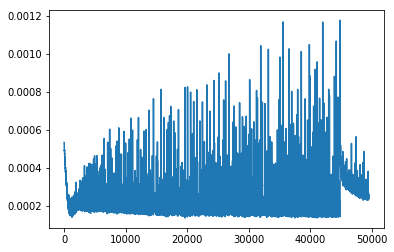

In [11]:
import matplotlib.pyplot as plt

print(x.shape)
print()

plt.plot(losses)
plt.show()

In [16]:
opt

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0

Parameter Group 1
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [12]:
dec.train(False)
enc.train(False)


x, x_inds = ds[epoch_inds[0]]
        
x = (x - 1) * log_number

hidden = enc.initHidden(batch_size).cuda(GPU_id)

#     pbar.set_description(str(x.shape[0]))

enc_out, hidden = enc(x, hidden)

#input the stop character to the stream    
out = (Variable(utils.stopChar(batch_size)).cuda(GPU_id)-1) * log_number

loss = Variable(torch.zeros(1,1,1).cuda(GPU_id))

out_list = list()
#     pdb.set_trace()
for i in range(x.shape[0]):

    out, hidden = dec(out, hidden, enc_out)    

    out_list += [out]

    loss += criterion(torch.squeeze(out,0), x_inds[i])

x_hat = utils.tensorToChar(torch.cat(out_list, 0))
x = utils.tensorToChar(x)

print(''.join(x_hat[:,2]))
print(''.join(x[:,2]))

enc.train(True)
dec.train(True)

UnboundLocalError: local variable 'embedded' referenced before assignment

In [25]:
np.log(np.exp(3.219125824868201)/28)

-0.11307868530700314

In [71]:
enc.train(False)
dec.train(False)

x_tmp, _ = ds[[np.random.randint(len(ds))]]

# x = torch.unsqueeze(x[:,0,:],1)
batch_size_tmp = x_tmp.shape[1]

hidden = enc.initHidden(batch_size_tmp).cuda(GPU_id)
out, hidden = enc(x_tmp, hidden)

#input the stop character to the stream    
out = Variable(stopChar(batch_size_tmp)).cuda(GPU_id)


#     pdb.set_trace()
out_chars = list()

for i in range(x_tmp.shape[0]):

    out, hidden = dec(out, hidden) 
    
    out_chars += [tensorToChar(out)[0,0]]
    
enc.train(True)
dec.train(True)

print(''.join(np.hstack(tensorToChar(x_tmp))))
print(''.join(out_chars))

MSLMVVSMACVGFFLLEGPW
MMHCTPCLLLMMMMMMMMMM


In [51]:
3E-4*np.log(15)

0.0008124150603306629

In [41]:
6.77e-05/np.log(15)

2.499953655676149e-05